In [1]:
import os
import json

# Upload the kaggle.json file first using the upload button in Colab
from google.colab import files
files.upload()  # Upload kaggle.json here

# Move to correct location
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permission
os.chmod("/root/.kaggle/kaggle.json", 600)


Saving kaggle.json to kaggle.json


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
# 3. DOWNLOAD DATASET FROM KAGGLE
# ---------------------------------------
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip -q leapgestrecog.zip -d leapGestRecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.11G/2.13G [00:11<00:00, 220MB/s]
100% 2.13G/2.13G [00:11<00:00, 201MB/s]


In [4]:
!mv leapGestRecog/leapgestrecog/leapGestRecog ./dataset
DATASET_PATH = "dataset"

In [4]:
import os
import cv2

IMG_WIDTH = 320
IMG_HEIGHT = 240

DATASET_PATH = "dataset"

X = []
y = []
gesture_dict = {}
label_counter = 0

for person in os.listdir(DATASET_PATH):
    person_path = os.path.join(DATASET_PATH, person)
    if not os.path.isdir(person_path):
        continue

    for gesture_folder in os.listdir(person_path):
        gesture_path = os.path.join(person_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue

        if gesture_folder not in gesture_dict:
            gesture_dict[gesture_folder] = label_counter
            label_counter += 1

        for file in os.listdir(gesture_path):
            if file.endswith(".png"):  # ✅ Updated from .pgm to .png
                file_path = os.path.join(gesture_path, file)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print("Failed to read:", file_path)
                    continue
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                X.append(img)
                y.append(gesture_dict[gesture_folder])

print("✅ Total images loaded:", len(X))
print("📌 Gesture labels:", gesture_dict)


✅ Total images loaded: 20000
📌 Gesture labels: {'07_ok': 0, '10_down': 1, '09_c': 2, '04_fist_moved': 3, '01_palm': 4, '06_index': 5, '08_palm_moved': 6, '05_thumb': 7, '02_l': 8, '03_fist': 9}


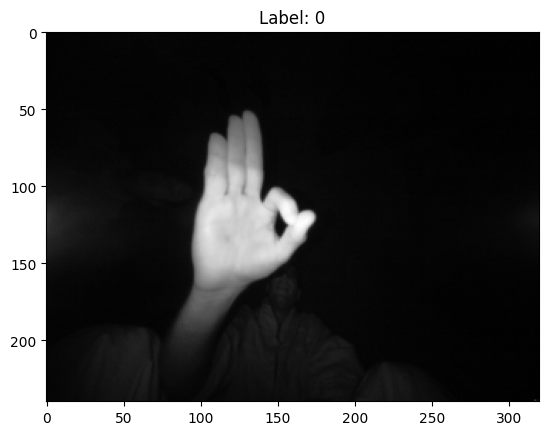

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X[0], cmap='gray')
plt.title(f"Label: {y[0]}")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(gesture_dict), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 238, 318, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 119, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 119, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 117, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 58, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 289536)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    37,060,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,080,842 (141.45 MB)

 Trainable params: 37,080,842 (141.45 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=15, batch_size=32)


ValueError: Unrecognized data type: x=[array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 7,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  3, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  6,  5],
       [ 5,  7,  5, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  5,  7, ...,  6,  4,  7],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 7,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  6,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  9, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  5],
       [ 6,  8,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  4,  5, ...,  5,  6,  4],
       [ 4,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  6,  9, ...,  3,  4,  4],
       [ 9,  8,  9, ...,  5,  5,  6],
       [ 7,  7,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  6],
       ...,
       [ 4,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  2,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  4,  5, ...,  4,  5,  5],
       ...,
       [16, 16, 16, ...,  5,  4,  3],
       [16, 15, 16, ...,  6,  6,  4],
       [16, 15, 14, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  2,  2,  3],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 7,  8,  7, ...,  3,  4,  3],
       [ 8,  9,  8, ...,  3,  5,  4],
       [ 8,  7,  9, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  7,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  3,  3,  3],
       ...,
       [ 5,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  3,  2,  4],
       [ 9,  6,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  7,  5, ...,  3,  2,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 4,  5,  4, ...,  4,  5,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  3,  4, ...,  5,  3,  5],
       [ 3,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  6,  4,  5],
       [ 6,  7,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  3,  3,  4],
       ...,
       [11, 11, 11, ...,  4,  4,  5],
       [11, 13, 13, ...,  5,  6,  5],
       [10, 11, 11, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 8,  8,  7, ...,  4,  5,  2],
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [12, 14, 18, ...,  4,  6,  5],
       [12, 15, 17, ...,  5,  4,  5],
       [13, 15, 18, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 3,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  6,  4,  4],
       ...,
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 3,  5,  3, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  3, ...,  5,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  8,  7, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  7, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 4,  5,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  3,  5],
       [ 5,  5,  7, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  3,  5,  4],
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 5,  6,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  5,  4],
       ...,
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  8, ...,  6,  6,  5],
       [ 8,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [14, 17, 18, ...,  5,  5,  4],
       [15, 19, 18, ...,  6,  5,  6],
       [15, 17, 19, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  8,  7,  6],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  3,  3],
       [ 4,  6,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  6],
       [ 4,  4,  4, ...,  7,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  8, ...,  6,  6,  5],
       [ 7,  5,  6, ...,  5,  6,  5],
       ...,
       [ 8,  7,  7, ...,  5,  6,  6],
       [ 8,  7,  7, ...,  5,  7,  5],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 8,  5,  6, ...,  6,  5,  6],
       ...,
       [ 7,  5,  7, ...,  6,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  5,  6,  4],
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 6,  8,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  2,  3,  4],
       [ 6,  5,  4, ...,  3,  3,  3],
       ...,
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  3,  4,  3],
       [ 8,  8,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  2,  3,  3],
       ...,
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  6, ...,  4,  5,  3],
       [ 7,  7,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [20, 20, 21, ...,  3,  3,  4],
       [19, 19, 19, ...,  5,  5,  5],
       [21, 19, 22, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [12, 14, 17, ...,  5,  4,  5],
       [12, 13, 16, ...,  4,  4,  5],
       [13, 13, 16, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  5,  4],
       [ 6,  7,  6, ...,  6,  5,  4],
       [ 6,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  7, ...,  4,  3,  3],
       ...,
       [ 8,  9,  8, ...,  5,  3,  4],
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 7,  9,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  4,  5,  3],
       [ 4,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [20, 19, 19, ...,  5,  6,  5],
       [18, 17, 18, ...,  4,  6,  4],
       [19, 16, 15, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 7,  7,  8, ...,  5,  6,  6],
       [ 8,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 6,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  6,  3],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  2],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  5,  5,  6],
       ...,
       [ 6,  7,  5, ...,  5,  7,  5],
       [ 6,  8,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  3],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  5,  2],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 3,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  7, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  7,  6,  5],
       [ 4,  5,  5, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  7,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  3,  5, ...,  3,  5,  3],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  2,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  9, ...,  3,  3,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  9,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  3,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 7,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  7,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 6,  7,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 8,  6,  7, ...,  4,  6,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  7, ...,  4,  6,  7],
       [ 6,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  7,  8, ...,  7,  7,  5],
       [ 6,  7,  8, ...,  7,  5,  6],
       [ 7,  6,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  3,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  6,  5,  4],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  6,  5],
       [ 7,  5,  7, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [20, 20, 20, ...,  6,  7,  6],
       [19, 20, 21, ...,  6,  7,  6],
       [19, 19, 20, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  7,  7,  7],
       [ 7,  8,  7, ...,  7,  6,  7],
       [ 7,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 7,  8,  8, ...,  7,  7,  7],
       [ 6,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  8,  7, ...,  5,  6,  7],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  5,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [17, 18, 20, ...,  5,  5,  7],
       [18, 17, 17, ...,  6,  6,  6],
       [16, 16, 17, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 8,  6,  9, ...,  3,  3,  5],
       [ 7,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [18, 17, 16, ...,  4,  6,  5],
       [17, 16, 17, ...,  6,  6,  6],
       [16, 16, 15, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  4,  6],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 4,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  5],
       [ 7,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  3,  3],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 3,  3,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  8],
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  3,  6,  5],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 8,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 4,  6,  5, ...,  3,  3,  4],
       ...,
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  3,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  5, ...,  7,  7,  7],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  6,  6,  5],
       [ 6,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  2],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 7,  9,  8, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  3,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  6,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  3],
       ...,
       [12, 12, 10, ...,  4,  6,  4],
       [12, 11, 13, ...,  4,  3,  5],
       [10, 11, 10, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [18, 18, 20, ...,  4,  3,  5],
       [16, 18, 18, ...,  4,  5,  5],
       [18, 17, 20, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 9,  7,  7, ...,  4,  5,  5],
       [ 8,  7,  7, ...,  6,  5,  5],
       [ 7,  6,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 9,  7,  9, ...,  4,  5,  4],
       [ 7,  8,  9, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 8,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 3,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [12, 12, 13, ...,  4,  5,  4],
       [10, 13, 12, ...,  4,  4,  5],
       [11, 11, 11, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 4,  6,  4, ...,  5,  4,  5],
       [ 5,  5,  3, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  4,  6],
       [ 6,  7,  7, ...,  6,  6,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  2,  4,  2],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  7, ...,  3,  4,  4],
       [ 6,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 3,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  2,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  6,  4, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 3,  5,  3, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  3, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 8,  8,  7, ...,  4,  5,  3],
       [ 7,  6,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  2,  4],
       [ 5,  6,  7, ...,  4,  5,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  5],
       [ 7,  8,  7, ...,  4,  5,  5],
       [ 7,  8,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       ...,
       [14, 16, 19, ...,  5,  5,  4],
       [16, 17, 18, ...,  4,  6,  6],
       [15, 18, 20, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  3,  5],
       ...,
       [ 4,  3,  4, ...,  4,  5,  4],
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 2,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 5,  8,  7, ...,  5,  5,  6],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  8, ...,  5,  7,  6],
       [ 6,  7,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  6,  6,  7],
       [ 7,  7,  6, ...,  6,  7,  5],
       ...,
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 5,  8,  6, ...,  6,  6,  7],
       [ 4,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  2,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 6,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 6,  6,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  6, ...,  3,  6,  4],
       [ 6,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 3,  4,  3, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 3,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  7, ...,  8,  6,  6],
       [ 7,  8,  7, ...,  6,  5,  6],
       [ 9,  8,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  2,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  2],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  8,  8, ...,  3,  4,  4],
       [ 6,  6,  8, ...,  3,  5,  4],
       [ 6,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  5,  7],
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       ...,
       [ 8,  8,  7, ...,  6,  5,  6],
       [ 7,  9,  7, ...,  6,  6,  7],
       [ 9,  8,  9, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 6,  6,  4, ...,  3,  5,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  3, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  8, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 5,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 8,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 9,  7,  7, ...,  4,  3,  4],
       [ 7,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  8,  8, ...,  4,  5,  3],
       [ 7,  6,  7, ...,  3,  2,  3],
       [ 6,  7,  9, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  3,  2,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  5,  6],
       [ 4,  5,  3, ...,  7,  6,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       ...,
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  3,  4,  4],
       [ 4,  6,  4, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  2,  3,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 4,  3,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  3,  4],
       [ 6,  5,  6, ...,  2,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  6,  6],
       [ 4,  6,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  4, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  6,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  7,  6],
       ...,
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  4,  6,  6],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  5,  4,  4],
       [ 6,  3,  6, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  2,  3],
       [ 4,  4,  3, ...,  4,  5,  3],
       ...,
       [ 4,  3,  6, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 6,  6,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 3,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  3,  6],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 8,  8,  7, ...,  5,  6,  6],
       ...,
       [ 6,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  8, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  5,  2,  5],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 7,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  2],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  5],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 6,  7,  8, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  7,  6,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 3,  3,  4, ...,  4,  4,  5],
       [ 4,  4,  2, ...,  4,  4,  5],
       [ 3,  3,  3, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  8,  6, ...,  7,  6,  6],
       [ 8,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  3, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  5,  4],
       ...,
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  7,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  8, ...,  3,  3,  4],
       [ 7,  6,  7, ...,  4,  3,  3],
       [ 7,  8,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [17, 19, 21, ...,  5,  3,  4],
       [17, 20, 19, ...,  4,  4,  4],
       [18, 19, 19, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  6],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 3,  5,  5, ...,  5,  5,  6],
       ...,
       [ 3,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [10,  9, 10, ...,  4,  5,  3],
       [ 8,  8,  9, ...,  4,  4,  3],
       [ 7,  6,  9, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 7,  7,  8, ...,  6,  5,  7],
       [ 7,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  6,  8, ...,  5,  3,  3],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  6,  4,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 6,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  7, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  7,  5],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 6,  6,  4, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  2],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 4,  6,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  3,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  3,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 3,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  7,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [16, 15, 16, ...,  5,  5,  4],
       [13, 15, 16, ...,  4,  4,  3],
       [13, 16, 17, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  7,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  5],
       [ 4,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 7,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  7,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  7,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  6, ...,  3,  4,  4],
       [ 8,  6,  8, ...,  3,  4,  5],
       [ 7,  7,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  3,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 8,  8,  9, ...,  5,  5,  6],
       [10,  9, 11, ...,  7,  7,  6],
       [11, 10, 10, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  6],
       [ 8,  7,  7, ...,  7,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  4,  6, ...,  6,  5,  5],
       [ 5,  4,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  5,  3,  3],
       [ 6,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  7,  7,  5],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 3,  3,  4, ...,  4,  3,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 8,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  8,  6, ...,  5,  6,  3],
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  3,  4],
       [ 4,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  2],
       ...,
       [11, 11, 11, ...,  4,  4,  4],
       [12, 11, 11, ...,  4,  5,  4],
       [11, 12, 12, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  8, ...,  5,  6,  6],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [20, 19, 20, ...,  5,  4,  5],
       [19, 20, 19, ...,  5,  5,  6],
       [19, 20, 18, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  3,  4,  6],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  7,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  5],
       [ 3,  3,  3, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [10, 11, 13, ...,  4,  4,  4],
       [10, 11, 14, ...,  5,  4,  3],
       [ 9, 10, 12, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 7,  7,  8, ...,  3,  3,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  5,  7,  6],
       [ 7,  6,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [18, 18, 19, ...,  6,  6,  5],
       [17, 18, 18, ...,  6,  6,  5],
       [16, 17, 18, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  3, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  2,  3],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  6, ...,  3,  5,  4],
       [ 7,  7,  8, ...,  3,  3,  4],
       [ 6,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 4,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 8,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  4],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  3,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  3,  5,  3],
       [ 8,  7,  9, ...,  5,  4,  3],
       [ 8,  8,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 6,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  3,  6,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  5,  6],
       ...,
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 8,  8,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  2,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  3,  3],
       [ 7,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  7,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  7,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  6],
       [ 7,  6,  6, ...,  7,  5,  5],
       [ 7,  6,  7, ...,  7,  6,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  3, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  7, ...,  3,  5,  4],
       ...,
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  6],
       [ 6,  7,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  3, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  7,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 8,  6,  9, ...,  4,  6,  4],
       [ 8,  7,  7, ...,  3,  5,  5],
       [ 6,  7,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  3,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  3,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  8,  6,  6],
       [ 7,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  2,  2],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  9, ...,  4,  4,  3],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  4,  5,  6],
       [ 7,  7,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  6],
       [ 5,  6,  5, ...,  7,  6,  5],
       [ 6,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  6, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 7,  6,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  3,  3],
       [ 4,  5,  3, ...,  3,  4,  4],
       ...,
       [ 7,  7,  9, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 8,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  6,  5],
       [ 5,  8,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  4,  6,  6],
       [ 6,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  4,  5,  5],
       [ 3,  3,  5, ...,  5,  6,  4],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  3, ...,  6,  5,  4],
       [ 3,  3,  3, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 7,  5,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  6,  6, ...,  2,  5,  4],
       [ 6,  7,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  5,  3,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [13, 14, 16, ...,  4,  4,  3],
       [14, 13, 17, ...,  5,  4,  4],
       [14, 13, 17, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  7, ...,  7,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  4],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  6,  5,  7],
       [ 4,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  4, ...,  4,  6,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 6,  7,  8, ...,  5,  5,  5],
       [ 8,  8,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  8,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 6,  6,  7, ...,  3,  3,  2],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  3, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 9,  9, 10, ...,  4,  4,  5],
       [ 7,  8,  9, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       ...,
       [ 8,  7,  7, ...,  6,  7,  5],
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 8,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  2,  3],
       ...,
       [ 6,  6,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  6],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  6,  6],
       [ 5,  7,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 5,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  7,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  5],
       [ 4,  4,  3, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  6,  4,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  7,  5],
       [ 6,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  3, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  3,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  6,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  6,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  2,  4,  3],
       ...,
       [ 8,  7,  6, ...,  4,  4,  4],
       [ 9,  6,  7, ...,  3,  5,  3],
       [ 6,  7,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [ 7,  7,  6, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  8,  9, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 7,  6,  9, ...,  4,  5,  5],
       [ 8,  8,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  3,  3, ...,  3,  3,  3],
       ...,
       [ 3,  5,  6, ...,  3,  2,  3],
       [ 4,  7,  6, ...,  3,  3,  4],
       [ 4,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  7],
       [ 8,  8,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  5],
       [ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  2,  4],
       ...,
       [ 5,  4,  7, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  5],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  3, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  8,  6,  7],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  6,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  2],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 7,  7,  8, ...,  5,  6,  6],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 8,  8,  9, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  6],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  6,  5,  6],
       [ 3,  4,  4, ...,  6,  5,  6],
       [ 4,  5,  6, ...,  6,  7,  5],
       ...,
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  7,  6,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  6, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  2],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  5,  3],
       ...,
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  6,  7, ...,  2,  4,  4],
       [ 7,  6,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  4],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [15, 17, 18, ...,  5,  4,  5],
       [17, 16, 18, ...,  5,  5,  5],
       [17, 15, 17, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  8, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 7,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  2,  3,  3],
       ...,
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  4,  7,  5],
       [ 7,  7,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  3, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [11, 11, 14, ...,  5,  4,  4],
       [10, 13, 15, ...,  5,  4,  5],
       [11, 11, 15, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 6,  4,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  7,  6],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  7,  5,  5],
       ...,
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 8,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 3,  3,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 5,  4,  3, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 8,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  7],
       ...,
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  9,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  7,  6],
       [ 6,  6,  5, ...,  6,  7,  7],
       [ 6,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 9,  9,  7, ...,  4,  6,  4],
       [ 8,  8,  8, ...,  6,  5,  4],
       [ 7,  8,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  2, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  5,  3,  4],
       [ 4,  4,  3, ...,  5,  4,  4],
       ...,
       [ 4,  4,  3, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  7, ...,  5,  6,  5],
       [ 6,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  2,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  3,  6,  3],
       [ 5,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  8,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 6,  5,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  5,  7, ...,  4,  3,  5],
       [ 8,  7,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  3,  3,  5],
       [ 4,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [11, 11, 11, ...,  4,  5,  4],
       [11, 11, 12, ...,  4,  4,  3],
       [11, 10, 11, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [18, 18, 18, ...,  5,  6,  6],
       [17, 17, 19, ...,  4,  5,  5],
       [17, 18, 20, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  6],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  7,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 9,  8,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  2,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  7,  8, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 7,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  6,  7,  5],
       [ 6,  5,  6, ...,  7,  6,  6],
       ...,
       [ 5,  5,  4, ...,  7,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  6],
       ...,
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 7,  9,  7, ...,  5,  5,  5],
       [ 7,  8,  9, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  6,  7],
       [ 4,  4,  5, ...,  7,  7,  5],
       [ 6,  6,  5, ...,  7,  7,  7],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  6,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [14, 15, 19, ...,  4,  5,  5],
       [14, 18, 19, ...,  4,  4,  4],
       [15, 18, 20, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  3, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  6,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  6,  6],
       [ 4,  5,  4, ...,  7,  5,  5],
       [ 4,  4,  3, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  6,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  5],
       ...,
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  5,  7],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  7,  6,  8],
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 6,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  2,  4],
       [ 6,  4,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 8,  7,  7, ...,  3,  4,  3],
       [ 6,  6,  8, ...,  5,  6,  4],
       [ 6,  7,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  7],
       ...,
       [ 7,  7,  8, ...,  7,  7,  8],
       [ 7,  7,  6, ...,  7,  7,  7],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  7,  5, ...,  5,  7,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  7,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  2],
       ...,
       [ 5,  5,  5, ...,  3,  4,  6],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 7,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 3,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 3,  4,  4, ...,  4,  3,  3],
       ...,
       [12, 12, 12, ...,  3,  5,  3],
       [11, 11, 12, ...,  5,  4,  4],
       [10, 12, 12, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  3,  3],
       [ 6,  7,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       ...,
       [18, 20, 19, ...,  4,  6,  4],
       [18, 18, 18, ...,  5,  4,  5],
       [18, 18, 17, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 7,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  7,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  6,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  2,  4],
       ...,
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 6,  6,  7, ...,  5,  4,  3],
       [ 7,  7,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  2],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  6],
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  6],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  3,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  6],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 7,  9,  7, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  4],
       [ 7,  7,  8, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  6,  3, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  2,  3],
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  6, ...,  5,  5,  3],
       [ 7,  7,  8, ...,  6,  5,  4],
       [ 6,  7,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 9,  7,  7, ...,  4,  6,  5],
       [ 8,  8,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  3, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 6,  8,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  8,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 4,  3,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  8, ...,  3,  3,  3],
       [ 8,  6,  8, ...,  6,  5,  5],
       [ 6,  7,  8, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 6,  4,  5, ...,  7,  6,  5],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  3, ...,  4,  4,  5],
       [ 4,  3,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  7],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  7,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 7,  7,  9, ...,  3,  3,  4],
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 8,  8,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  5,  2,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  3,  3, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  1,  3,  3],
       [ 4,  4,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  8,  6, ...,  5,  5,  4],
       [ 5,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 6,  6,  8, ...,  6,  6,  6],
       [ 8,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  9, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  8,  7, ...,  3,  4,  4],
       [ 8,  7,  7, ...,  4,  5,  3],
       [ 7,  7,  9, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  5,  7,  4],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  2,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  3,  4,  5],
       [ 7,  6,  9, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  9,  8, ...,  5,  5,  4],
       [ 9, 10,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 8,  7,  6, ...,  6,  6,  5],
       [ 7,  8,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  5],
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 7,  7,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 3,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  2,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 7,  9,  8, ...,  4,  4,  4],
       [ 7,  8,  6, ...,  4,  4,  5],
       [ 8,  8,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  3,  5,  5],
       [ 5,  4,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 9,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 5,  6,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  6, ...,  3,  3,  3],
       [ 6,  7,  7, ...,  3,  4,  3],
       [ 7,  8,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  6,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 8,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 7,  8,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  7,  7,  6],
       [ 5,  6,  6, ...,  7,  8,  7],
       [ 6,  6,  6, ...,  7,  7,  6],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 6,  4,  5, ...,  6,  6,  5],
       [ 5,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  7,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  7, ...,  7,  5,  7],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  2,  3],
       ...,
       [ 9,  8,  9, ...,  5,  4,  4],
       [ 9,  9,  9, ...,  3,  4,  4],
       [ 8,  9,  9, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  6,  5],
       ...,
       [ 4,  3,  3, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  4, ...,  6,  5,  4],
       [ 6,  4,  6, ...,  5,  6,  5],
       ...,
       [ 9,  7,  8, ...,  6,  6,  6],
       [ 8,  8,  9, ...,  5,  6,  6],
       [ 9,  8,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  4,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 4,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  7,  6],
       [ 6,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  3,  5],
       [ 5,  6,  6, ...,  4,  3,  5],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  2],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  3],
       [ 5,  7,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [19, 19, 19, ...,  6,  7,  6],
       [17, 20, 17, ...,  5,  6,  6],
       [17, 17, 18, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 8,  8,  9, ...,  5,  5,  5],
       [ 6,  7,  8, ...,  5,  5,  4],
       [ 8,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  4, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  4,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  9, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  2,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  3,  3, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  8,  6, ...,  7,  7,  7],
       [ 7,  6,  6, ...,  8,  6,  8],
       [ 7,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  5],
       ...,
       [18, 19, 19, ...,  5,  6,  5],
       [17, 17, 17, ...,  5,  4,  5],
       [16, 17, 17, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  5,  3,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  6,  4],
       [ 6,  6,  7, ...,  3,  4,  4],
       [ 7,  8,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  3,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 3,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  2, ...,  5,  5,  6],
       [ 5,  4,  3, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  9, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  4,  3,  3],
       [ 7,  6,  6, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  3,  3,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  3, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [20, 21, 22, ...,  5,  5,  5],
       [21, 22, 21, ...,  5,  4,  5],
       [21, 21, 21, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [15, 15, 16, ...,  6,  5,  5],
       [14, 15, 16, ...,  4,  4,  4],
       [15, 16, 17, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  5,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  5],
       ...,
       [ 8,  7,  8, ...,  4,  4,  3],
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 8,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  2,  3,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  9,  6, ...,  4,  4,  4],
       [ 9,  8,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  8,  7, ...,  5,  4,  5],
       [ 7,  9,  8, ...,  5,  6,  5],
       [ 7,  6,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  4],
       ...,
       [18, 18, 19, ...,  6,  6,  6],
       [20, 18, 18, ...,  7,  6,  7],
       [17, 17, 16, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  5],
       ...,
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [15, 14, 15, ...,  4,  5,  4],
       [14, 15, 15, ...,  5,  5,  6],
       [16, 14, 16, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 3,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  3, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 7,  4,  4, ...,  3,  5,  5],
       [ 4,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  2,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  3,  3],
       [ 7,  6,  7, ...,  4,  3,  3],
       [ 6,  6,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  2,  3,  3],
       [ 4,  5,  6, ...,  3,  4,  3],
       ...,
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 8,  6,  7, ...,  3,  3,  3],
       [ 7,  6,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  5,  3],
       [ 6,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  8,  7, ...,  4,  5,  5],
       [ 9,  8,  7, ...,  4,  3,  4],
       [ 8,  8,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [15, 17, 18, ...,  5,  5,  5],
       [16, 18, 19, ...,  5,  4,  4],
       [16, 18, 18, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  3],
       ...,
       [ 6,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  2],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  3, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 3,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  5, ...,  5,  3,  4],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  9,  7, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 4,  7,  6, ...,  7,  7,  7],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  5, ...,  7,  5,  8],
       [ 4,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 8,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  3,  3],
       ...,
       [12, 11, 13, ...,  4,  5,  5],
       [11, 10, 12, ...,  4,  4,  4],
       [11, 11, 11, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  6,  6,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  9, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  7,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [12, 14, 15, ...,  5,  4,  4],
       [13, 13, 17, ...,  5,  5,  4],
       [12, 14, 15, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  3, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  3,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  7,  7, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  2,  3],
       ...,
       [ 7,  8,  6, ...,  3,  3,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 6,  8,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  4,  6,  6],
       [ 6,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  6,  3,  5],
       [ 5,  5,  4, ...,  3,  5,  5],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 7,  7,  5, ...,  5,  3,  5],
       ...,
       [ 4,  5,  6, ...,  5,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  6],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  3],
       ...,
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  6, ...,  3,  4,  5],
       [ 8,  7,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 6,  7,  8, ...,  5,  6,  6],
       [ 7,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 7,  6,  6, ...,  5,  5,  7],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 7,  7,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  2,  3,  4],
       ...,
       [ 8,  8,  9, ...,  4,  5,  4],
       [ 8,  8,  8, ...,  3,  3,  5],
       [ 8,  7,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  2,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  6,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  7,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  6,  6],
       [ 4,  5,  5, ...,  7,  6,  6],
       [ 5,  4,  5, ...,  7,  7,  7],
       ...,
       [ 5,  5,  5, ...,  7,  5,  6],
       [ 6,  5,  4, ...,  6,  6,  6],
       [ 5,  6,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  5,  3,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  4,  6],
       [ 5,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  7,  6],
       [ 4,  5,  4, ...,  7,  6,  6],
       [ 5,  4,  5, ...,  6,  7,  6],
       ...,
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  6,  5,  4],
       [ 6,  7,  7, ...,  3,  5,  5],
       [ 6,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 8,  8,  7, ...,  4,  3,  3],
       [ 6,  7,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  3],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  3,  3, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 8,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [21, 20, 19, ...,  5,  5,  5],
       [20, 19, 18, ...,  5,  5,  5],
       [19, 18, 16, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  7,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 8,  9,  8, ...,  4,  5,  5],
       [ 7,  8,  7, ...,  5,  4,  5],
       [ 7,  8,  9, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 8,  9,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  7,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  7, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  7],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  7,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  8,  8, ...,  6,  6,  6],
       [ 7,  8,  8, ...,  6,  5,  6],
       [ 7,  8,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  5],
       [ 4,  5,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  6,  4],
       [ 6,  6,  8, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  6,  8, ...,  3,  3,  3],
       [ 7,  7,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  4, ...,  4,  5,  3],
       ...,
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  3,  4],
       [ 4,  3,  3, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  7, ...,  3,  2,  4],
       [ 6,  4,  6, ...,  3,  3,  2],
       [ 5,  6,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 8,  8,  8, ...,  5,  5,  4],
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  4, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  3,  6,  5],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 4,  4,  6, ...,  6,  5,  4],
       [ 5,  6,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  6,  8, ...,  3,  5,  4],
       [ 8,  7,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  6,  5],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       ...,
       [ 3,  4,  3, ...,  5,  5,  6],
       [ 3,  5,  4, ...,  6,  4,  5],
       [ 4,  4,  3, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  6,  4],
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  2,  4],
       ...,
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  7,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  6,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  3],
       ...,
       [20, 19, 17, ...,  5,  3,  4],
       [19, 17, 17, ...,  4,  6,  5],
       [18, 17, 16, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  6,  4,  5],
       ...,
       [ 9,  7,  8, ...,  5,  7,  7],
       [ 8,  7,  8, ...,  5,  7,  7],
       [ 8,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 6,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 3,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  3,  4,  3],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  7],
       [ 6,  6,  7, ...,  7,  6,  5],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  3],
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 7,  8,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  3],
       ...,
       [ 7,  9,  8, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  3,  3,  3],
       [ 8,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  2,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [21, 22, 20, ...,  5,  6,  5],
       [20, 20, 19, ...,  5,  5,  5],
       [18, 18, 17, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [14, 16, 15, ...,  4,  4,  4],
       [15, 15, 14, ...,  5,  4,  4],
       [15, 14, 15, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  2,  3],
       [ 3,  3,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  5],
       ...,
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  9, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 3,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  3],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  8,  7, ...,  7,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  8,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  6,  6,  5],
       ...,
       [ 6,  5,  5, ...,  4,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 5,  5,  5, ...,  5,  7,  5],
       [ 5,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  2],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  7],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  2],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 6,  5,  6, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  2,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  3,  5, ...,  3,  4,  3],
       ...,
       [ 9,  9,  8, ...,  4,  4,  3],
       [ 9,  8,  9, ...,  4,  4,  3],
       [ 8,  8,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 5,  7,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 3,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  5,  6,  4],
       [ 4,  3,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  4,  3,  5],
       [ 7,  7,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  7,  7,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 5,  7,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 6,  6,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  5,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 8,  6,  7, ...,  4,  3,  4],
       [ 5,  8,  6, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  7],
       [ 4,  6,  5, ...,  6,  5,  4],
       [ 5,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  6,  4,  6],
       [ 7,  6,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 7,  8,  7, ...,  3,  4,  5],
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 8,  9,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  2,  3],
       [ 4,  3,  3, ...,  2,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  6, ...,  2,  4,  4],
       ...,
       [ 8,  6,  7, ...,  3,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 5,  7,  6, ...,  6,  7,  7],
       [ 5,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  7,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 8,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  7,  7],
       [ 6,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  4, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 9,  7,  8, ...,  6,  5,  6],
       [ 9,  7,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 8,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  2,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [11, 12, 11, ...,  4,  4,  4],
       [10, 10, 12, ...,  4,  5,  4],
       [11, 12, 12, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  2,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  4],
       [ 5,  7,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  3, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  6],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 4,  5,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 8,  8,  9, ...,  4,  3,  5],
       [ 8,  8,  9, ...,  5,  4,  5],
       [ 8,  9,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [17, 18, 20, ...,  4,  5,  4],
       [17, 20, 19, ...,  5,  4,  5],
       [18, 19, 20, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       ...,
       [ 5,  7,  7, ...,  6,  6,  8],
       [ 7,  6,  6, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 7,  8,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [18, 19, 21, ...,  4,  4,  4],
       [19, 21, 19, ...,  4,  4,  5],
       [18, 18, 19, ..., 66, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  2,  3],
       [ 4,  3,  3, ...,  2,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 5,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  7,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [10, 10, 11, ...,  4,  4,  5],
       [10, 11, 11, ...,  3,  4,  3],
       [12, 10, 11, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  6,  7,  4],
       [ 6,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  3],
       ...,
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 6,  5,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  7,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  6],
       [ 6,  4,  6, ...,  5,  3,  4],
       [ 4,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 4,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 8,  8,  6, ...,  6,  5,  6],
       [ 7,  5,  7, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  8],
       [ 7,  6,  7, ...,  7,  6,  7],
       [ 8,  7,  8, ...,  8,  6,  7],
       ...,
       [ 6,  6,  7, ...,  6,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  6],
       ...,
       [ 5,  5,  4, ...,  7,  5,  5],
       [ 7,  6,  6, ...,  5,  7,  7],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  7,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [18, 19, 21, ...,  5,  6,  4],
       [18, 20, 21, ...,  3,  5,  4],
       [17, 19, 17, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  2],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  8, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  3, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 8,  8,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       ...,
       [ 7,  7,  8, ...,  6,  6,  7],
       [ 7,  8,  9, ...,  6,  7,  6],
       [ 9, 10,  9, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  7,  7,  6],
       [ 6,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  1,  2],
       [ 6,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  6,  5],
       ...,
       [ 8,  7,  7, ...,  7,  6,  7],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  3,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 4,  3,  3, ...,  5,  4,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 3,  2,  3, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  2,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [20, 18, 17, ...,  3,  5,  4],
       [19, 17, 17, ...,  5,  4,  5],
       [18, 16, 16, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [18, 19, 19, ...,  6,  6,  5],
       [17, 19, 18, ...,  7,  5,  5],
       [18, 17, 16, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  3,  4,  3],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  3,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  4, ...,  7,  5,  6],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  5,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  6,  5,  5],
       [ 3,  3,  3, ...,  6,  5,  4],
       ...,
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [16, 18, 17, ...,  5,  5,  5],
       [16, 17, 17, ...,  5,  5,  5],
       [16, 16, 15, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  2,  3,  3],
       [ 5,  4,  6, ...,  3,  5,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  6,  4],
       [ 6,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  2],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  5,  4,  5],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  2, ...,  4,  5,  4],
       [ 3,  3,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  2,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  7,  7,  6],
       [ 6,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  6,  7,  7],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [15, 18, 18, ...,  4,  3,  4],
       [17, 19, 20, ...,  5,  5,  4],
       [16, 19, 20, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  8,  7, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  3,  6,  5],
       [ 8,  5,  7, ...,  6,  6,  5],
       [ 5,  6,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  3, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  3,  4],
       [ 5,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 6,  6,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  4,  4,  2],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  6,  3],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 3,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  5,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  7,  9, ...,  4,  6,  4],
       [ 4,  7,  8, ...,  4,  3,  3],
       [ 5,  6,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  2],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 8,  8,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  7, ...,  5,  5,  6],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  3,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  7,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  3,  5,  3],
       ...,
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  6,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  3,  5, ...,  2,  2,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 6,  8,  8, ...,  4,  2,  4],
       [ 7,  6,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  6,  7],
       [ 8,  7,  8, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  7,  6,  7],
       [ 7,  7,  7, ...,  7,  7,  5],
       [ 7,  8,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  5, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 6,  6,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [14, 15, 17, ...,  4,  5,  5],
       [15, 17, 18, ...,  4,  5,  5],
       [16, 19, 21, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  9, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  7,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 7,  6,  8, ...,  6,  7,  7],
       [ 6,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  3,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  4],
       ...,
       [ 7,  8,  4, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  6,  6,  4],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  3],
       [ 7,  9,  8, ...,  3,  3,  4],
       [ 8,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  4,  5],
       [ 3,  5,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  3,  5, ...,  3,  6,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  7, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [17, 18, 17, ...,  5,  4,  5],
       [17, 18, 16, ...,  4,  4,  5],
       [18, 15, 14, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  5,  6,  4],
       ...,
       [ 6,  6,  8, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  2,  3,  2],
       ...,
       [ 8,  7,  7, ...,  3,  3,  3],
       [ 9,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [17, 20, 20, ...,  4,  4,  5],
       [18, 20, 20, ...,  5,  5,  5],
       [19, 19, 19, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  7,  7],
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 4,  5,  3, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  4],
       [ 3,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  6,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  4,  2],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  4, ...,  5,  4,  3],
       ...,
       [ 3,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [17, 19, 19, ...,  3,  6,  4],
       [17, 19, 22, ...,  3,  4,  4],
       [18, 17, 18, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 4,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 9,  7,  8, ...,  5,  6,  7],
       [ 8,  6,  7, ...,  6,  7,  6],
       [ 8,  8,  7, ...,  6,  7,  5],
       ...,
       [ 8,  7,  8, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 7,  8,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  6, ...,  4,  5,  3],
       [ 7,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 8,  8,  9, ...,  6,  7,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  2,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  6,  6, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 7,  5,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  2,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  7,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  6,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  5,  4,  5],
       [ 7,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 4,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  4,  5,  7],
       [ 7,  5,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  2],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  7,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [17, 18, 17, ...,  6,  4,  5],
       [17, 15, 16, ...,  5,  4,  5],
       [16, 15, 14, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  6, ...,  4,  6,  6],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 8,  7,  9, ...,  5,  6,  5],
       [ 8,  7,  8, ..., 68, 17, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  7,  6,  5],
       [ 8,  7,  6, ...,  7,  6,  7],
       ...,
       [ 8,  8,  7, ...,  7,  7,  8],
       [ 8,  7,  8, ...,  6,  6,  7],
       [ 8,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  4,  2],
       [ 5,  4,  3, ...,  4,  2,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  6,  4, ...,  4,  5,  3],
       [ 4,  5,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  5,  4,  3],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  7,  7],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  6,  5,  3],
       [ 4,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  5,  2,  4],
       [ 5,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  2],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 6,  8,  8, ...,  3,  4,  4],
       [ 6,  7,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 6,  7,  7, ...,  4,  4,  6],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  7,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       ...,
       [ 7,  7,  9, ...,  5,  8,  5],
       [ 9,  9,  9, ...,  5,  7,  6],
       [ 9, 10,  9, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  7,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  4,  6],
       [ 7,  8,  7, ...,  4,  5,  5],
       [ 9,  7,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  7,  6,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 4,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 8,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 8,  8,  7, ...,  3,  5,  5],
       [ 6,  6,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  7,  8,  7],
       [ 6,  7,  6, ...,  7,  7,  8],
       [ 5,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  2],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  6,  4, ...,  3,  3,  4],
       ...,
       [ 7,  5,  6, ...,  5,  3,  3],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  6,  3],
       [ 4,  4,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 7,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  5,  4],
       [ 5,  3,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 8,  8,  7, ...,  6,  7,  7],
       [ 4,  6,  7, ...,  5,  7,  6],
       [ 5,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  5,  7],
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  5, ...,  4,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  2,  4,  2],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  5,  3],
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 6,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [19, 18, 18, ...,  5,  6,  4],
       [19, 19, 17, ...,  5,  4,  6],
       [19, 18, 16, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 8,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 5,  7,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  6,  4],
       [ 8,  8,  8, ...,  4,  6,  5],
       [ 6,  7,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 4,  5,  4, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  4,  4],
       [ 3,  4,  4, ...,  2,  6,  3],
       [ 5,  3,  3, ...,  3,  5,  4],
       ...,
       [16, 15, 15, ...,  4,  5,  4],
       [14, 14, 15, ...,  3,  3,  2],
       [13, 13, 15, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 4,  6,  5, ...,  7,  7,  7],
       [ 6,  5,  5, ...,  7,  5,  7],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  3,  4,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  2],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 6,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  3,  3],
       [ 7,  7,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  3, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       ...,
       [ 7,  6,  7, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  3,  2,  5],
       [ 7,  8,  8, ...,  3,  3,  4],
       [ 8,  8,  9, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 7,  7,  6, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  5],
       ...,
       [ 7,  7,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 4,  6,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 8,  8,  8, ...,  7,  7,  5],
       [ 8,  7,  7, ...,  6,  6,  7],
       [ 7,  8,  7, ...,  7,  6,  6],
       ...,
       [ 7,  7,  8, ...,  7,  6,  7],
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 8,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  6,  6,  5],
       ...,
       [ 4,  4,  5, ...,  6,  6,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  2],
       [ 3,  4,  5, ...,  3,  4,  3],
       ...,
       [ 9, 10, 10, ...,  4,  5,  5],
       [ 9,  8,  9, ...,  4,  4,  4],
       [ 8, 10,  9, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 3,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  5],
       [ 3,  4,  3, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 3,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 3,  3,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  6,  6,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  2],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  3,  3],
       [ 7,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  7,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [16, 16, 17, ...,  5,  6,  5],
       [17, 17, 16, ...,  6,  5,  4],
       [17, 17, 18, ..., 66, 14, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  5,  3,  5],
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  6,  5,  4],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  3, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  7, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  3],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  6,  5, ...,  6,  3,  5],
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 5,  7,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  8, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  7],
       [ 8,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  7,  7, ...,  5,  5,  7],
       [ 8,  7,  8, ...,  6,  6,  6],
       [ 8,  8,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  7,  5,  6],
       [ 5,  6,  6, ...,  7,  5,  7],
       [ 5,  5,  5, ...,  7,  7,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 6,  7,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  8,  6],
       [ 5,  6,  7, ...,  7,  7,  6],
       [ 6,  5,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 3,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  3, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  3, ...,  3,  3,  4],
       [ 3,  3,  3, ...,  3,  3,  4],
       ...,
       [ 3,  4,  2, ...,  3,  3,  4],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  3,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  8, ...,  6,  6,  7],
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  7, ...,  6,  6,  5],
       ...,
       [ 7,  5,  6, ...,  7,  6,  7],
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 5,  7,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  5],
       ...,
       [21, 21, 21, ...,  4,  5,  4],
       [21, 19, 20, ...,  5,  5,  6],
       [19, 22, 21, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  2],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 3,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  7,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  5,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  7, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 7,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  6],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 5,  6,  4, ...,  6,  5,  8],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  6],
       [ 4,  4,  4, ...,  4,  2,  3],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  4,  5,  4],
       [ 6,  6,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 8,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  7],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [10, 14, 14, ...,  4,  5,  4],
       [10, 14, 14, ...,  4,  5,  4],
       [13, 16, 16, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  3, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 5,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  7,  5],
       [ 5,  7,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  7,  6,  7],
       [ 7,  7,  6, ...,  5,  6,  7],
       [ 8,  8,  8, ...,  6,  5,  7],
       ...,
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 5,  6,  7, ...,  7,  7,  6],
       [ 6,  7,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  9,  8, ...,  4,  4,  4],
       [ 7,  8, 10, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  4],
       ...,
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 8,  7,  9, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  2],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  7,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  8, ...,  7,  5,  7],
       [ 7,  7,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  7,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  7, ...,  4,  3,  3],
       ...,
       [ 9,  8, 10, ...,  4,  5,  5],
       [ 7,  9,  8, ...,  4,  4,  4],
       [ 8,  9,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  7,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  5],
       [ 5,  6,  4, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  7,  5,  6],
       ...,
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 4,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [16, 18, 17, ...,  4,  4,  4],
       [17, 16, 16, ...,  4,  6,  4],
       [17, 15, 14, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  3],
       ...,
       [16, 18, 17, ...,  4,  4,  4],
       [16, 17, 17, ...,  5,  4,  5],
       [16, 16, 15, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  5,  7, ...,  4,  5,  3],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 8,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       ...,
       [ 7,  6,  7, ...,  6,  4,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [23, 24, 25, ...,  6,  5,  5],
       [21, 24, 23, ...,  5,  6,  6],
       [23, 22, 22, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  6,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [13, 13, 13, ...,  5,  4,  4],
       [12, 12, 12, ...,  4,  5,  6],
       [13, 12, 12, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 5,  7,  6, ...,  5,  7,  5],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 3,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 7,  8,  8, ...,  4,  3,  3],
       [ 7,  6,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 8,  9,  7, ...,  5,  6,  5],
       [ 9,  8,  8, ...,  4,  5,  5],
       [ 8,  7,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  3],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 3,  4,  5, ...,  3,  3,  4],
       [ 4,  6,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  6,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  1],
       ...,
       [13, 12, 11, ...,  4,  4,  3],
       [11, 11, 11, ...,  4,  5,  5],
       [12, 10, 10, ..., 67, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  6],
       [ 3,  4,  3, ...,  4,  4,  5],
       [ 3,  4,  3, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  6,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  6,  4],
       ...,
       [19, 18, 19, ...,  7,  5,  5],
       [18, 19, 18, ...,  6,  6,  5],
       [17, 17, 18, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 7,  6,  8, ...,  3,  5,  5],
       [ 7,  7,  8, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  5,  7, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 8,  8, 10, ...,  6,  5,  5],
       [ 7,  7,  8, ...,  3,  4,  5],
       [ 8,  9,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  5,  5,  3],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 6,  8,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  7,  7,  7],
       ...,
       [ 8,  9,  8, ...,  5,  5,  7],
       [ 8,  8,  8, ...,  6,  7,  8],
       [ 7,  7,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  5,  2],
       ...,
       [ 5,  5,  3, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  6,  4,  4],
       ...,
       [18, 15, 14, ...,  4,  5,  5],
       [15, 14, 15, ...,  6,  5,  5],
       [13, 13, 14, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  3,  6],
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 6,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       ...,
       [ 5,  7,  5, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  3,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 4,  3,  5, ...,  3,  3,  4],
       ...,
       [12, 14, 11, ...,  4,  5,  5],
       [11, 11, 10, ...,  3,  3,  3],
       [11, 11, 12, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  5, ...,  4,  5,  6],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  2],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  3,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  3],
       [ 5,  3,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [17, 19, 21, ...,  5,  5,  4],
       [18, 19, 18, ...,  5,  5,  5],
       [17, 18, 19, ..., 67, 19, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  4,  5,  4],
       ...,
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 3,  3,  5, ...,  4,  4,  5],
       [ 4,  3,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  6,  5, ...,  5,  5,  6],
       [ 5,  7,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 7,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  5, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  6,  8, ...,  4,  3,  4],
       [ 6,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  6, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  6,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  4,  6, ...,  4,  5,  5],
       ...,
       [ 7,  8,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  8,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  7,  7, ...,  4,  6,  4],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 9,  7,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [17, 19, 20, ...,  6,  6,  5],
       [19, 17, 22, ...,  5,  5,  4],
       [17, 18, 20, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  7,  6,  7],
       [ 7,  8,  7, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  7,  4, ...,  3,  5,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  3],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  8,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  6,  4,  6],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 8,  6,  5, ...,  5,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 4,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  2,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  2],
       [ 5,  5,  4, ...,  4,  4,  2],
       ...,
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 8,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 7,  6,  9, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  8, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 6,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  5,  5,  6],
       ...,
       [ 6,  4,  6, ...,  7,  7,  7],
       [ 5,  4,  6, ...,  6,  8,  7],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  5,  3],
       [ 5,  4,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 7,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 4,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 3,  5,  5, ...,  3,  4,  5],
       [ 3,  4,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  6,  5, ...,  4,  3,  5],
       [ 4,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  2],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  8, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  6,  5,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 8,  6,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 3,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  4],
       ...,
       [ 5,  3,  4, ...,  2,  2,  4],
       [ 3,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  7],
       [ 7,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  4],
       [ 6,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  6,  7],
       [ 5,  5,  6, ...,  7,  6,  5],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  6,  8, ...,  3,  5,  4],
       [ 8,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  3,  5,  4],
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  7,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  7],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  3,  4, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  3,  4,  5],
       [ 4,  7,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  3, ...,  4,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [14, 15, 18, ...,  3,  3,  4],
       [13, 15, 16, ...,  4,  4,  4],
       [12, 15, 16, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  2],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  8, 11, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  1,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  7,  5],
       [ 7,  6,  6, ...,  5,  8,  6],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  3,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  7,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  3,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  2],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [13, 13, 11, ...,  4,  5,  4],
       [10, 13, 12, ...,  4,  5,  3],
       [12, 12, 13, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  7,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  7],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  7,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  7,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  6],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 3,  6,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 4,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  4, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  6,  4, ...,  5,  6,  6],
       [ 6,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 4,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  3,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  6,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  3,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  3,  4,  5],
       [ 7,  6,  5, ...,  5,  4,  6],
       ...,
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 4,  3,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  6,  7,  6],
       ...,
       [ 5,  7,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  7,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  2,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  5,  4,  3],
       [ 7,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [17, 18, 20, ...,  4,  5,  5],
       [16, 15, 17, ...,  6,  4,  5],
       [16, 18, 18, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  4,  5,  5],
       ...,
       [ 8,  8,  8, ...,  6,  7,  6],
       [ 8,  6,  8, ...,  7,  7,  6],
       [ 6,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  7,  6,  6],
       [ 3,  5,  4, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       ...,
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [12, 12, 12, ...,  4,  4,  5],
       [11, 11, 11, ...,  4,  4,  4],
       [10, 12, 12, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  6,  4,  4],
       [ 6,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  9,  7, ...,  4,  4,  3],
       [ 6,  7,  8, ...,  4,  4,  5],
       [ 7,  8,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 3,  5,  4, ...,  5,  6,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 4,  4,  4, ...,  6,  6,  6],
       [ 5,  4,  3, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  2,  3],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  9, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  6,  4],
       [ 7,  6,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  2],
       ...,
       [ 3,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  2,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  2,  4,  3],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  8, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  4,  4,  6],
       ...,
       [ 7,  6,  8, ...,  5,  4,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 7,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  3,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  7,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  8,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [15, 14, 17, ...,  5,  6,  6],
       [14, 16, 14, ...,  6,  5,  5],
       [15, 15, 16, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  7,  5, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  2],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  3,  6, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [15, 15, 16, ...,  5,  4,  6],
       [16, 16, 16, ...,  5,  5,  5],
       [15, 15, 16, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  7,  8, ...,  8,  7,  6],
       [ 7,  7,  5, ...,  7,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 4,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [17, 18, 16, ...,  5,  5,  4],
       [16, 16, 15, ...,  3,  5,  4],
       [16, 14, 16, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  6,  6],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 7,  5,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  9, ...,  3,  4,  5],
       [ 7,  7,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 7,  7,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  7],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  6,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  2],
       ...,
       [ 9,  8,  8, ...,  5,  3,  5],
       [ 8,  8,  8, ...,  3,  4,  5],
       [ 8,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  6],
       ...,
       [ 7,  7,  6, ...,  6,  4,  4],
       [ 6,  6,  7, ...,  6,  5,  4],
       [ 8,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  3,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 7,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  3,  3],
       [ 6,  6,  6, ...,  4,  3,  3],
       ...,
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  5, ...,  3,  3,  3],
       [ 5,  5,  8, ...,  4,  3,  4],
       [ 6,  6,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 5,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  3,  3,  3],
       ...,
       [ 6,  8,  8, ...,  3,  4,  4],
       [ 7,  8,  7, ...,  4,  5,  5],
       [ 7,  8,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  6,  7,  7],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  6,  4,  5],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  2,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  2],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  3, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 7,  5,  7, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  4, ...,  6,  5,  6],
       ...,
       [ 7,  6,  8, ...,  6,  5,  6],
       [ 8,  8,  8, ...,  6,  5,  6],
       [ 8,  9,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  3, ...,  3,  2,  3],
       [ 4,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  2,  3,  4],
       [ 5,  5,  3, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  6,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  7, ...,  3,  3,  3],
       ...,
       [ 6,  8,  7, ...,  5,  3,  4],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  4,  6],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  3, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       ...,
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 5,  8,  8, ...,  4,  4,  3],
       [ 6,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 7,  9,  7, ...,  3,  3,  5],
       [ 7,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 9,  8,  8, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  3,  4,  3],
       [ 7,  6,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  6,  4,  6],
       [ 5,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 9, 10, 10, ...,  5,  4,  5],
       [10,  8,  9, ...,  4,  3,  3],
       [ 8,  9,  9, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  6],
       [ 8,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  7,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 8,  7,  6, ...,  5,  3,  3],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 5,  6,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 6,  4,  5, ...,  5,  7,  6],
       [ 6,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 8,  6,  7, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  8,  5, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 7,  6,  7, ...,  3,  4,  5],
       [ 6,  6,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  6],
       [ 8,  6,  7, ...,  4,  4,  3],
       [ 7,  6,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 8,  7,  8, ...,  6,  5,  5],
       [ 7,  8,  9, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  6],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  6,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  7,  8, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  7, ...,  4,  5,  6],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 7,  7,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  3,  4],
       [ 5,  3,  4, ...,  2,  3,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  3,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 3,  3,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  6],
       [ 6,  7,  5, ...,  5,  4,  4],
       [ 6,  7,  8, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 7,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ...,  3,  3,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  8,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 8,  6,  6, ...,  4,  3,  3],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 8,  7,  8, ...,  7,  6,  6],
       ...,
       [ 8,  8,  9, ...,  5,  7,  6],
       [ 7,  7,  8, ...,  5,  6,  7],
       [ 9,  8,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  2,  3,  3],
       [ 5,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  7,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  6],
       ...,
       [ 5,  6,  5, ...,  7,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  7],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  7],
       [ 8,  7,  7, ...,  7,  5,  6],
       [ 6,  7,  8, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  6,  4,  4],
       [ 5,  7,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  2,  3,  4],
       [ 6,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 3,  5,  5, ...,  5,  5,  5],
       [ 3,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 3,  4,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  7,  6, ...,  4,  4,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  7,  8, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 4,  5,  6, ...,  5,  6,  7],
       [ 5,  5,  6, ...,  6,  7,  7],
       [ 7,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  4,  6],
       [ 5,  5,  6, ...,  6,  7,  6],
       ...,
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [17, 18, 19, ...,  3,  5,  5],
       [17, 18, 17, ...,  5,  5,  5],
       [15, 16, 17, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 4,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  6,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  5,  5,  3],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  4,  6],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  2,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  2,  3],
       ...,
       [ 8,  8,  9, ...,  4,  6,  4],
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 9,  7,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  7, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  5,  3,  4],
       [ 8,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 8,  8,  7, ...,  7,  6,  7],
       ...,
       [ 6,  6,  6, ...,  8,  8,  7],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 6,  7,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  6,  5,  4],
       [ 6,  7,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 8,  6,  7, ...,  7,  6,  6],
       [ 8,  8,  9, ...,  7,  6,  7],
       [ 9,  8,  8, ...,  7,  7,  6],
       ...,
       [ 6,  7,  6, ...,  7,  6,  7],
       [ 6,  6,  7, ...,  7,  7,  6],
       [ 8,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  7, ...,  5,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  7,  6],
       [ 7,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 4,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       ...,
       [ 7,  6,  5, ...,  6,  6,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  3, ...,  4,  3,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  7],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 7,  8,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  6],
       [ 6,  6,  8, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  2],
       [ 4,  4,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [ 7,  7,  8, ...,  7,  5,  7],
       [ 8,  8,  8, ...,  6,  7,  7],
       [ 7,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 8,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  6,  5,  6],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  6,  4,  6],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  6,  3, ...,  6,  6,  6],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 8,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 6,  7,  6, ...,  5,  7,  6],
       [ 5,  7,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  8, ...,  5,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [18, 18, 18, ...,  6,  5,  6],
       [16, 18, 17, ...,  5,  6,  4],
       [16, 16, 18, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  5,  3, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  7, ...,  6,  6,  5],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 7,  6,  6, ...,  3,  4,  3],
       [ 8,  9,  8, ...,  4,  3,  4],
       [ 8,  8,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 7,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 3,  3,  5, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  9,  9, ...,  4,  3,  3],
       [ 9,  8,  7, ...,  4,  3,  4],
       [ 8,  9,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [18, 20, 21, ...,  6,  8,  6],
       [18, 21, 20, ...,  5,  5,  7],
       [20, 20, 19, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 8,  8,  9, ...,  3,  5,  4],
       [ 6,  7,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 8,  6,  9, ...,  5,  6,  4],
       [ 7,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  3, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  6,  6],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  2,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 8,  8,  9, ...,  4,  4,  5],
       [ 8,  8,  9, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  3,  2,  3],
       ...,
       [ 6,  8,  7, ...,  4,  4,  3],
       [ 8,  7,  7, ...,  3,  3,  4],
       [ 8,  8,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [ 7,  5,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 6,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  6,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 5,  6,  6, ...,  5,  7,  6],
       [ 5,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  2,  2,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  6,  5],
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 4,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 8,  8,  7, ...,  5,  5,  7],
       [ 8,  8,  8, ...,  6,  6,  6],
       [ 9,  9, 10, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [13, 12, 14, ...,  4,  4,  5],
       [14, 12, 13, ...,  4,  4,  4],
       [11, 12, 11, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  3,  3,  4],
       [ 6,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  7,  7,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 8,  8,  9, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 7,  8,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  6,  6,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  4,  6],
       [ 7,  7,  9, ...,  5,  5,  5],
       [ 7,  9,  8, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  7,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  6,  5, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  6,  3,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  7,  7],
       [ 6,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [16, 17, 20, ...,  6,  4,  5],
       [17, 19, 18, ...,  4,  4,  4],
       [17, 19, 19, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 6,  8,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  6],
       ...,
       [ 7,  7,  7, ...,  6,  5,  7],
       [ 6,  6,  7, ...,  6,  7,  5],
       [ 7,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  6,  8, ...,  3,  4,  3],
       [ 7,  7,  9, ...,  4,  4,  5],
       [ 8,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  6,  7,  6],
       [ 7,  7,  6, ...,  7,  5,  6],
       [ 8,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  7,  4, ...,  7,  7,  7],
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 6,  6,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  3, ...,  3,  3,  2],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  6,  7, ...,  5,  4,  4],
       [ 7,  8,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 7,  8,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  6],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  2],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7,  8,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  3,  3],
       [ 6,  7,  6, ...,  3,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [14, 15, 17, ...,  4,  4,  4],
       [15, 16, 17, ...,  4,  4,  4],
       [15, 16, 16, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  7,  5,  7],
       [ 6,  7,  6, ...,  8,  7,  6],
       [ 7,  5,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  3,  5, ...,  4,  5,  3],
       ...,
       [16, 18, 17, ...,  4,  4,  5],
       [15, 17, 18, ...,  5,  6,  4],
       [15, 17, 17, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  8,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  5],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 8,  8,  8, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  6,  6,  7],
       [ 7,  7,  8, ...,  7,  6,  6],
       ...,
       [ 7,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  7,  7,  6],
       [ 6,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 6,  7,  6, ...,  4,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  6,  7,  5],
       [ 7,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  3,  4],
       ...,
       [ 3,  5,  5, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  2],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  3],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 7,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  3,  5],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  4,  6,  6],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  7,  5],
       [ 6,  7,  8, ...,  5,  6,  6],
       [10,  8,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  4, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  5,  4,  6],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  7,  7],
       [ 5,  6,  6, ...,  5,  7,  6],
       [ 7,  7,  7, ...,  7,  5,  7],
       ...,
       [ 7,  7,  8, ...,  7,  7,  7],
       [ 7,  6,  8, ...,  6,  6,  5],
       [ 7,  7,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 6,  4,  4, ...,  2,  3,  4],
       ...,
       [ 7,  8,  8, ...,  4,  3,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 8,  9,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  2],
       [ 5,  4,  3, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  2],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 8,  6,  6, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  3],
       [ 8,  8,  6, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  4, ...,  3,  5,  6],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  6],
       ...,
       [ 7,  6,  6, ...,  7,  5,  7],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  7,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 8,  6,  8, ...,  4,  3,  4],
       [ 7,  7,  9, ...,  5,  4,  3],
       [ 8,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  4,  2,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  4,  4,  1],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  3,  5],
       [ 5,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  2],
       [ 5,  5,  5, ...,  3,  3,  5],
       ...,
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  5,  5,  5],
       [ 8,  8,  9, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  6,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [12, 14, 15, ...,  6,  4,  5],
       [12, 16, 17, ...,  6,  5,  4],
       [12, 15, 15, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  5,  6],
       [ 4,  4,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  5,  6,  6],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  5],
       [ 4,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  3, ...,  3,  4,  2],
       ...,
       [11, 12, 14, ...,  3,  3,  4],
       [11, 10, 14, ...,  4,  4,  3],
       [11, 13, 15, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [13, 14, 18, ...,  4,  5,  4],
       [14, 17, 18, ...,  4,  4,  4],
       [15, 16, 20, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  6,  5,  6],
       [ 4,  3,  3, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  7],
       [ 5,  5,  3, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  4],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  6,  5,  4],
       ...,
       [ 2,  2,  4, ...,  5,  5,  3],
       [ 4,  3,  3, ...,  5,  6,  4],
       [ 3,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  3],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  4,  4,  2],
       ...,
       [ 6,  7,  6, ...,  2,  4,  4],
       [ 8,  8,  7, ...,  4,  5,  3],
       [ 7,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  5,  7,  6],
       [ 5,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  7,  7],
       [ 4,  5,  5, ...,  6,  6,  7],
       [ 4,  5,  4, ...,  7,  6,  7],
       ...,
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  6],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  2,  5,  4],
       ...,
       [ 8,  7,  9, ...,  5,  4,  5],
       [ 8,  8,  9, ...,  4,  4,  5],
       [ 6,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  6,  4,  6],
       [ 6,  6,  5, ...,  7,  6,  6],
       ...,
       [ 6,  5,  5, ...,  6,  5,  7],
       [ 4,  5,  6, ...,  7,  6,  7],
       [ 6,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 7,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 9,  8,  7, ...,  3,  5,  4],
       [ 6,  8,  8, ...,  3,  4,  4],
       [ 7,  9,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  3],
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  6, ...,  3,  3,  3],
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 8,  6,  8, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  3,  3, ...,  3,  5,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 7,  6,  6, ...,  4,  6,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  8,  7, ...,  6,  5,  4],
       [ 6,  7,  8, ...,  5,  6,  8],
       [ 7,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  5],
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 5,  7,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [17, 19, 21, ...,  5,  6,  5],
       [17, 18, 20, ...,  4,  4,  4],
       [17, 19, 19, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  3,  4, ...,  4,  4,  2],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  3,  3,  4],
       [ 7,  7,  5, ...,  3,  3,  4],
       [ 5,  7,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  4,  5,  4],
       [ 4,  5,  3, ...,  6,  5,  4],
       [ 3,  4,  3, ...,  4,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  6,  5],
       [ 3,  4,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  3,  2, ...,  6,  5,  4],
       [ 3,  4,  3, ...,  4,  4,  3],
       [ 3,  3,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  7,  6,  8],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  7,  7, ...,  4,  6,  5],
       [ 6,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  3,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 4,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 8,  8,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 5,  5,  7, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 7,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 3,  4,  5, ...,  4,  5,  2],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  6, ...,  7,  6,  6],
       [ 8,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  3,  4,  5],
       [ 7,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  7, ...,  4,  5,  6],
       [ 6,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  2,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  8, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 9, 12, 13, ...,  4,  6,  4],
       [10, 11, 14, ...,  5,  4,  4],
       [11, 11, 12, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  7,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  2],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  7,  5, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  6],
       [ 5,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 8,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  2,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [10, 10, 11, ...,  5,  4,  4],
       [10, 12, 11, ...,  4,  5,  4],
       [11, 11, 13, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  7,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  7,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  1,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  4, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  3,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  5,  7],
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  6,  4,  5],
       [ 4,  7,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  3, ...,  5,  5,  5],
       ...,
       [ 3,  3,  3, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  6,  5,  4],
       [ 3,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  4,  5],
       [ 4,  5,  5, ...,  3,  6,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 7,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 9,  8,  9, ...,  3,  4,  4],
       [ 9,  8,  8, ...,  3,  4,  4],
       [10,  9,  9, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [13, 11, 11, ...,  4,  4,  5],
       [12, 12, 12, ...,  3,  4,  5],
       [10, 10, 11, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  4],
       ...,
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 5,  5,  7, ...,  8,  8,  7],
       [ 6,  6,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  7, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  6,  8, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 8,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  7, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  2],
       [ 4,  4,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  6],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 7,  7,  9, ...,  6,  6,  7],
       [ 7,  8,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  5,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  2,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  4],
       [ 7,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  3],
       [ 6,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  8,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 3,  3,  4, ...,  3,  4,  3],
       ...,
       [ 7,  6,  7, ...,  4,  3,  3],
       [ 7,  7,  6, ...,  3,  3,  2],
       [ 8,  8,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  6,  6],
       [ 6,  7,  6, ...,  5,  7,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  7],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  7,  6,  6],
       ...,
       [ 5,  4,  6, ...,  5,  5,  7],
       [ 5,  5,  6, ...,  7,  6,  4],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  4,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  7,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  3],
       ...,
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 3,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  8,  6,  6],
       [ 5,  5,  6, ...,  7,  5,  6],
       [ 5,  5,  5, ...,  7,  7,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  5,  4],
       [ 4,  3,  3, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  2],
       ...,
       [12, 10, 11, ...,  5,  4,  4],
       [11, 12, 11, ...,  4,  5,  5],
       [10, 10, 11, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  7,  6],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  7, ...,  4,  3,  4],
       ...,
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  4, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  6,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  2],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  2,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  2,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  3, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  3,  5],
       [ 8,  7,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  2,  4,  2],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 3,  4,  3, ...,  3,  4,  3],
       ...,
       [ 7,  8,  9, ...,  4,  4,  3],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  8,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  3,  4],
       ...,
       [ 6,  8,  8, ...,  3,  4,  4],
       [ 7,  9,  8, ...,  4,  4,  3],
       [ 7,  8,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  5,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 5,  5,  6, ...,  5,  6,  7],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  6],
       [ 6,  7,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  7, ...,  6,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 6,  8,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 6,  5,  4, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  7, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  5],
       [ 8,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  8, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  7,  5],
       [ 7,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 8,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 3,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  7,  6, ...,  3,  4,  4],
       [ 7,  4,  7, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  4,  6,  3],
       [ 8,  7,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  3,  3,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  2,  3,  4],
       ...,
       [17, 19, 20, ...,  4,  4,  4],
       [18, 17, 20, ...,  5,  5,  4],
       [19, 20, 21, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  3,  4, ...,  5,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  2,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  7,  6,  6],
       [ 7,  5,  6, ...,  7,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 6,  5,  5, ...,  7,  5,  6],
       [ 7,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  5,  5,  3],
       [ 4,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [13, 16, 20, ...,  5,  5,  4],
       [14, 15, 18, ...,  4,  5,  5],
       [14, 17, 19, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  2,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  7,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  7,  5],
       [ 7,  6,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  7,  5, ...,  6,  6,  6],
       [ 4,  5,  7, ...,  4,  5,  5],
       [ 7,  7,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  7, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  5,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  5],
       ...,
       [ 7,  7,  8, ...,  6,  6,  7],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  8,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  2,  3,  4],
       ...,
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 5,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  3, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  2,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  3, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  6],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 3,  6,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [17, 19, 20, ...,  4,  6,  4],
       [18, 19, 21, ...,  5,  5,  4],
       [19, 19, 20, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  3,  3],
       [ 4,  5,  6, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  6,  5, ...,  6,  5,  7],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  5,  6],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  3,  4,  5],
       ...,
       [ 8,  7,  9, ...,  5,  5,  6],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 7,  6,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  2,  3],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  5,  6],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  3],
       [ 7,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  7,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  5,  7,  7],
       [ 5,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  7,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  6,  3],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  7,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 7,  5,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 7,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  3,  3,  3],
       [ 4,  6,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  7,  5,  6],
       [ 6,  7,  7, ...,  7,  6,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  3,  3],
       ...,
       [18, 20, 21, ...,  5,  5,  4],
       [17, 19, 19, ...,  4,  3,  5],
       [17, 18, 22, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  3,  4,  5],
       [ 7,  8,  6, ...,  4,  4,  3],
       [ 7,  7,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 3,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  4,  2],
       [ 5,  4,  6, ...,  4,  2,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  7, ...,  3,  6,  3],
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  8, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 8,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  3,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  2],
       [ 6,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  6],
       ...,
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  6,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  7,  6],
       [ 7,  8,  7, ...,  7,  5,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  6,  4,  4],
       [ 4,  3,  3, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  4,  4],
       [ 4,  5,  3, ...,  4,  5,  5],
       [ 3,  4,  3, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  7,  5, ...,  7,  6,  5],
       [ 5,  4,  4, ...,  5,  6,  5],
       ...,
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  5,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  3,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  6],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  8,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  7,  7,  8],
       [ 7,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  3,  3, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  2,  3,  3],
       ...,
       [ 9,  8,  8, ...,  4,  4,  4],
       [ 9,  9,  9, ...,  5,  4,  4],
       [ 8,  8,  9, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 3,  3,  3, ...,  5,  4,  4],
       ...,
       [ 3,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  3, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 4,  6,  5, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  7,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  2,  3],
       [ 5,  4,  3, ...,  4,  5,  3],
       [ 5,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 6,  6,  4, ...,  5,  5,  4],
       [ 3,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  7,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  4],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 6,  7,  7, ...,  5,  4,  3],
       [ 6,  7,  7, ...,  4,  3,  3],
       [ 7,  8,  9, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  6,  7],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 2,  4,  4, ...,  6,  6,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  7,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  3,  5,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 8,  7,  6, ...,  5,  6,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  7,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  8,  5],
       ...,
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  7,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  7,  7],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  7,  6,  5],
       [ 5,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  6,  3, ...,  3,  3,  3],
       [ 5,  3,  5, ...,  3,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  3, ...,  2,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  3,  5, ...,  4,  4,  3],
       [ 4,  6,  7, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  5,  3,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  7,  5,  4],
       [ 3,  3,  4, ...,  3,  5,  3],
       [ 3,  3,  4, ...,  4,  4,  4],
       ...,
       [ 3,  2,  3, ...,  4,  4,  4],
       [ 3,  3,  3, ...,  5,  5,  3],
       [ 3,  3,  2, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [14, 16, 19, ...,  4,  6,  4],
       [15, 15, 19, ...,  4,  5,  4],
       [15, 16, 18, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  3, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  3,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  7, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 6,  7,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  6,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 3,  5,  3, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 3,  3,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  5, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 5,  5,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  4, ...,  6,  3,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  6,  5, ...,  6,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  6,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  3,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  2],
       [ 3,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  6,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  7,  3,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  2,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  2,  3,  3],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 7,  6,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  4,  6,  5],
       ...,
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 7,  7,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  4,  6, ...,  5,  6,  4],
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  5,  7,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  7,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 9,  9,  8, ...,  5,  6,  5],
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 7,  9,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 6,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 7,  7,  6, ...,  7,  6,  5],
       ...,
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 6,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 4,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  5,  4,  4],
       ...,
       [ 7,  5,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  4,  6],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 3,  3,  4, ...,  3,  2,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [18, 18, 18, ...,  4,  5,  4],
       [18, 19, 20, ...,  5,  6,  5],
       [19, 20, 20, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  6,  6, ...,  8,  6,  5],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  7,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  2,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 8,  8,  6, ...,  5,  4,  4],
       [ 8,  8,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  5,  3,  5],
       ...,
       [ 7,  6,  9, ...,  3,  4,  4],
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 8,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  2,  2],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 7,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  3,  4,  2],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 8,  7,  7, ...,  3,  4,  3],
       [ 8,  7,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 7,  7,  8, ...,  4,  3,  3],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  7,  6],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 8,  7,  7, ...,  7,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 4,  7,  7, ...,  6,  4,  5],
       [ 7,  7,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 7,  6,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  7, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  3],
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 4,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  3, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       ...,
       [ 6,  7,  6, ...,  6,  5,  7],
       [ 6,  7,  6, ...,  7,  6,  5],
       [ 7,  8,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  2,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  8,  6, ...,  4,  4,  3],
       [ 7,  6,  8, ...,  5,  3,  5],
       [ 7,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       ...,
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 7,  6,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  5],
       [ 8,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  2,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  2,  4],
       [ 4,  5,  5, ...,  3,  4,  2],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  7,  5,  6],
       [ 6,  4,  6, ...,  5,  5,  5],
       ...,
       [ 8,  7,  8, ...,  6,  7,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  3, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  4,  5, ...,  6,  4,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 4,  4,  4, ...,  6,  6,  6],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  3],
       ...,
       [ 9,  8,  9, ...,  4,  4,  5],
       [ 7,  9,  9, ...,  3,  5,  4],
       [ 8,  8,  8, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 6,  7,  6, ...,  7,  7,  6],
       [ 6,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 9, 10,  9, ...,  4,  6,  5],
       [ 9, 10, 10, ...,  3,  4,  4],
       [ 9,  8,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 3,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 6,  7,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  3,  5,  3],
       [ 8,  6,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  6],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  6,  6,  4],
       [ 5,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 8,  8,  7, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  8,  7],
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  3,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 8,  7,  8, ...,  6,  7,  7],
       [ 7,  6,  6, ...,  7,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  4],
       [ 7,  7,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  7,  7,  6],
       [ 5,  5,  7, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  4],
       [ 5,  5,  7, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  2,  4,  3],
       ...,
       [ 6,  7,  8, ...,  3,  3,  3],
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 6,  8,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 8,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 6,  6,  5, ...,  3,  5,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  7,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  3],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  7,  7, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  6,  6],
       [ 6,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  4,  3, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  6,  6],
       [ 6,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 8,  8,  7, ...,  5,  7,  6],
       [ 7,  8,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [19, 20, 21, ...,  7,  7,  6],
       [19, 20, 20, ...,  6,  7,  6],
       [18, 19, 18, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  6,  6,  6],
       ...,
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  7],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  6,  5,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  4,  5,  4],
       ...,
       [ 6,  7,  7, ...,  5,  5,  4],
       [ 8,  6,  7, ...,  4,  6,  5],
       [ 7,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  6],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  6,  6,  7],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  7,  7, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  6,  7,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       ...,
       [ 6,  5,  5, ...,  5,  6,  3],
       [ 5,  5,  6, ...,  5,  7,  5],
       [ 5,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  7,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  3,  5, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  4,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  3, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  4],
       [ 3,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  6,  5],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  3,  5],
       [ 7,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 6,  7,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 7,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [14, 17, 19, ...,  5,  5,  4],
       [15, 16, 18, ...,  4,  4,  5],
       [15, 18, 18, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  7,  6],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 7,  7,  6, ...,  4,  6,  5],
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 6,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  7,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  3, ...,  3,  3,  4],
       ...,
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 6,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  6,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 5,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  5,  5,  6],
       [ 6,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  3,  5, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 7,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 8,  6,  6, ...,  7,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 4,  5,  4, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  4,  7,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  7,  5,  7],
       [ 5,  5,  6, ...,  7,  6,  7],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [11, 12, 11, ...,  4,  5,  4],
       [12, 11, 11, ...,  5,  4,  3],
       [12, 12, 13, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  4,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  3,  4,  2],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  3,  3,  5],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  3],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  7, ...,  4,  5,  3],
       [ 6,  4,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  6,  4,  4],
       [ 6,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 6,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  9,  8, ...,  4,  3,  3],
       [ 8,  8,  9, ...,  4,  5,  4],
       [ 9,  9,  9, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  8, ...,  4,  3,  4],
       ...,
       [ 8,  8,  8, ...,  5,  6,  4],
       [ 9,  8,  8, ...,  5,  6,  5],
       [ 8,  8,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  7,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  6,  8],
       [ 7,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  7,  5, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 6,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  2, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 3,  3,  4, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 3,  3,  3, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  4],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  6,  7],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  6,  6,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  6],
       [ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  3, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  7,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  7,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  4,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  9, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  6,  3, ...,  6,  5,  6],
       [ 4,  3,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  3,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  7,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 8,  6,  8, ...,  5,  5,  6],
       [ 5,  7,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 7,  7,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  7],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  6,  5,  3],
       ...,
       [17, 18, 18, ...,  6,  6,  6],
       [18, 19, 18, ...,  4,  5,  5],
       [17, 17, 18, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  7, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  6, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  6, ...,  3,  5,  4],
       [ 6,  9,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       ...,
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 6,  6,  7, ...,  3,  4,  4],
       [ 7,  6,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  7, ...,  5,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  4,  6],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  7,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  7,  4, ...,  3,  6,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  2,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [12, 11, 13, ...,  4,  4,  3],
       [11, 11, 14, ...,  3,  4,  4],
       [11, 12, 14, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  5,  4,  6],
       ...,
       [19, 18, 18, ...,  5,  6,  6],
       [19, 17, 18, ...,  5,  5,  6],
       [17, 19, 21, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  6,  4,  4],
       [ 4,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  5],
       [ 7,  7,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  2],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  3,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  3,  2],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  6,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [19, 21, 21, ...,  5,  5,  5],
       [20, 22, 21, ...,  5,  5,  5],
       [20, 21, 19, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  6,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  8, ...,  7,  7,  6],
       [ 8,  7,  7, ...,  7,  5,  7],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  3,  4,  2],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 6,  3,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  5, ...,  5,  4,  6],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 3,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  2],
       [ 4,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  3, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  6,  6, ...,  7,  6,  6],
       [ 8,  7,  7, ...,  6,  8,  7],
       ...,
       [ 8,  7,  9, ...,  8,  8,  6],
       [ 7,  8,  8, ...,  7,  8,  7],
       [ 8,  8,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  8,  8, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  3,  5,  5],
       [ 8,  7,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 8,  7,  7, ...,  7,  7,  7],
       ...,
       [ 6,  6,  5, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  8,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  7,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 8,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  3,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  5],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  2,  3],
       ...,
       [ 7,  5,  8, ...,  4,  5,  3],
       [ 7,  6,  8, ...,  3,  4,  3],
       [ 7,  8,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  2,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  7, ...,  7,  6,  6],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  7, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  8, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  5,  7],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 8,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 3,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  6,  5,  6],
       ...,
       [ 4,  3,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 4,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  3, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  3,  5, ...,  3,  4,  4],
       ...,
       [19, 21, 21, ...,  5,  6,  5],
       [20, 19, 20, ...,  4,  4,  6],
       [21, 21, 21, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 4,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [18, 19, 20, ...,  6,  7,  6],
       [17, 17, 17, ...,  5,  5,  5],
       [16, 16, 16, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  7, ...,  4,  4,  6],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  7, ...,  5,  6,  5],
       ...,
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  6,  6,  7],
       [ 6,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 6,  5,  4, ...,  2,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  7, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  3,  3,  5],
       [ 6,  6,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  5],
       ...,
       [ 7,  6,  7, ...,  3,  3,  4],
       [ 7,  8,  6, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  4],
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  9, ...,  4,  6,  6],
       [ 7,  7,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 4,  4,  5, ...,  8,  6,  6],
       [ 6,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  7,  5],
       [ 4,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  5],
       ...,
       [15, 18, 19, ...,  4,  5,  5],
       [14, 19, 20, ...,  2,  4,  5],
       [17, 18, 20, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 4,  3,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  3,  3,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 6,  6,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 6,  7,  6, ...,  6,  7,  5],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  4],
       [ 6,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       ...,
       [ 3,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  4,  6, ...,  4,  6,  6],
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  5,  5,  6],
       [ 7,  5,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  6],
       [ 7,  6,  5, ...,  6,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       ...,
       [ 9,  9,  8, ...,  3,  4,  4],
       [ 9,  9,  8, ...,  5,  5,  4],
       [ 8,  8,  9, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 8,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  4,  6, ...,  6,  5,  5],
       ...,
       [ 8,  6,  6, ...,  5,  6,  7],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 8,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 3,  4,  5, ...,  3,  3,  6],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  2],
       ...,
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  6],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  4,  3, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  6],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  5],
       [ 7,  7,  7, ...,  5,  5,  6],
       [ 8,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  3, ...,  4,  4,  3],
       ...,
       [ 9,  8,  9, ...,  5,  4,  5],
       [ 9,  9,  9, ...,  4,  5,  4],
       [ 8,  9,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  7],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  6,  4],
       ...,
       [ 5,  5,  5, ...,  6,  7,  5],
       [ 5,  6,  4, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  6],
       ...,
       [ 3,  3,  4, ...,  5,  5,  4],
       [ 3,  5,  4, ...,  3,  6,  4],
       [ 4,  4,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7, 10,  9, ...,  3,  5,  5],
       [ 8,  6,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  3, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 3,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  6,  4, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  3,  3],
       [ 4,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  6],
       ...,
       [ 7,  5,  7, ...,  5,  4,  5],
       [ 8,  7,  7, ...,  5,  4,  6],
       [ 7,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  4, ...,  2,  3,  3],
       [ 6,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  6],
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  5,  8, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 3,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  3,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 8,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  3,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  5,  7, ...,  7,  7,  6],
       [ 5,  6,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       ...,
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  8,  6, ...,  6,  4,  5],
       [ 7,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  6],
       [ 3,  5,  5, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 5,  3,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  2],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  3, ...,  3,  2,  3],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 6,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  6,  4],
       ...,
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  8,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  3,  3,  5],
       [ 7,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  7,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  4,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 8,  8,  7, ...,  7,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  5,  7],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 6,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 4,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 7,  4,  6, ...,  4,  3,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  6,  4, ...,  3,  4,  3],
       ...,
       [ 4,  7,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  7,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 3,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 8,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  6,  6, ...,  5,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 6,  4,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  7,  7,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [13, 15, 17, ...,  5,  4,  5],
       [13, 14, 17, ...,  6,  5,  4],
       [12, 14, 17, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 9,  7,  8, ...,  5,  5,  4],
       [ 8,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [13, 11, 13, ...,  4,  4,  5],
       [12, 12, 13, ...,  5,  5,  5],
       [12, 12, 13, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  6, ...,  2,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  7],
       ...,
       [ 8,  8,  8, ...,  6,  7,  6],
       [ 9,  8,  9, ...,  6,  6,  5],
       [ 7,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  7,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  4],
       ...,
       [ 7,  4,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  6,  3,  4],
       [ 6,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 8,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  6,  6],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  5,  3,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [17, 20, 21, ...,  4,  5,  4],
       [18, 20, 19, ...,  4,  5,  4],
       [18, 19, 18, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [13, 12, 11, ...,  2,  3,  4],
       [12, 13, 12, ...,  4,  4,  4],
       [10, 10, 13, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  4,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  9,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 7,  8,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  5,  6],
       [ 3,  6,  4, ...,  6,  4,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  4,  3, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  6,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  7,  7,  7],
       [ 5,  5,  6, ...,  8,  5,  6],
       [ 5,  6,  6, ...,  7,  6,  7],
       ...,
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  8,  6,  7],
       [ 7,  8,  7, ...,  8,  7,  7],
       [ 6,  8,  7, ...,  8,  7,  7],
       ...,
       [ 7,  7,  7, ...,  5,  8,  8],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  4, ...,  4,  5,  2],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  4,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  3],
       [ 6,  8,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  6],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  7,  5,  7],
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [14, 16, 17, ...,  5,  5,  5],
       [15, 16, 19, ...,  5,  5,  5],
       [15, 16, 19, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  3,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  6,  6,  5],
       [ 3,  4,  4, ...,  6,  4,  6],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  6,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  7,  5],
       [ 3,  4,  4, ...,  6,  5,  5],
       [ 5,  3,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 3,  5,  5, ...,  4,  6,  3],
       [ 5,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  5,  6],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  3,  4,  2],
       [ 7,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  3, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  3,  5],
       [ 7,  6,  9, ...,  4,  5,  3],
       [ 8,  8,  9, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  8,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  7],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       ...,
       [ 8,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 8,  5,  8, ...,  5,  4,  4],
       [ 7,  8,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 7,  8, 10, ...,  4,  4,  4],
       [ 8,  9,  9, ...,  4,  5,  4],
       [ 9,  8,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  2],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  6],
       [ 8,  6,  8, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 6,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  5,  4],
       [ 6,  7,  8, ...,  3,  4,  4],
       [ 7,  8,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  7,  6,  5],
       ...,
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 3,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 2,  4,  3, ...,  3,  4,  4],
       [ 4,  3,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 3,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  8, ...,  5,  5,  4],
       [ 7,  4,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  3],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  7,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  6,  3],
       [ 6,  8,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  3,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 6,  7,  9, ...,  3,  3,  4],
       [ 9,  7,  9, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  5],
       ...,
       [ 7,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  6,  5,  4],
       ...,
       [ 4,  5,  4, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  5,  5,  3],
       [ 8,  7,  7, ...,  4,  5,  6],
       [ 7,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  3,  3],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  3,  3],
       [ 8,  6,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 9,  9,  7, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 5,  6,  4, ...,  5,  6,  5],
       [ 4,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  4,  6],
       ...,
       [ 6,  5,  5, ...,  7,  6,  7],
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 4,  6,  5, ...,  5,  7,  6],
       [ 4,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  8],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  7, ...,  5,  7,  4],
       [ 6,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  1],
       ...,
       [ 8,  7,  7, ...,  5,  5,  3],
       [ 8,  6,  6, ...,  4,  4,  3],
       [ 7,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  2,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [10, 12, 10, ...,  3,  5,  3],
       [11, 11, 12, ...,  4,  3,  4],
       [11, 10, 12, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  3,  3,  4],
       ...,
       [ 8,  9,  7, ...,  3,  5,  4],
       [ 9,  8,  7, ...,  5,  4,  4],
       [ 7,  9,  9, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  2],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  7,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  6,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  8,  8, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  4,  6],
       ...,
       [ 7,  6,  6, ...,  6,  7,  8],
       [ 6,  5,  4, ...,  7,  7,  7],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [20, 22, 22, ...,  5,  5,  5],
       [18, 22, 21, ...,  4,  5,  4],
       [21, 21, 22, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  7,  5,  4],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 5,  7,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 4,  5,  7, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  3, ...,  3,  3,  2],
       [ 3,  4,  3, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 7,  5,  8, ...,  5,  4,  4],
       [ 7,  6,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  7,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  4,  6,  6],
       [ 6,  6,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  3],
       [ 6,  5,  6, ...,  5,  3,  3],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  7,  7, ...,  5,  4,  3],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  6,  5,  6],
       [ 4,  5,  6, ...,  7,  5,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  4,  5],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  2,  4],
       [ 5,  3,  3, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 8,  7,  7, ...,  5,  5,  4],
       ...,
       [ 6,  3,  4, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  3,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  7,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  7,  7],
       [ 5,  6,  6, ...,  5,  6,  7],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  7,  8, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       ...,
       [ 7,  6,  8, ...,  7,  6,  7],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 8,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 4,  7,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  4,  4, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  7],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  5,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  7,  8],
       [ 5,  5,  5, ...,  7,  6,  7],
       [ 4,  6,  6, ...,  8,  6,  7],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  5,  3,  3],
       ...,
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  5,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  8, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 6,  7,  6, ...,  6,  7,  7],
       [ 7,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  3],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  3,  3,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 4,  6,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  6,  5,  4],
       ...,
       [ 4,  3,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 2,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  3,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  5,  3,  5],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  9,  9, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 3,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  2],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  3,  4,  5],
       ...,
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  3,  3],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 6,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  3],
       [ 4,  3,  7, ...,  3,  3,  2],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  6],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  3, ...,  5,  6,  4],
       ...,
       [ 4,  5,  4, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  3,  5,  5],
       [ 6,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 6,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 4,  7,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  6],
       ...,
       [ 4,  5,  4, ...,  6,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  2,  3],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [ 9,  9,  9, ...,  3,  4,  4],
       [ 8,  9,  8, ...,  3,  4,  3],
       [ 7,  8,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  6,  4],
       [ 5,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  2,  3],
       ...,
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 3,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  5],
       ...,
       [ 6,  6,  7, ...,  7,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 7,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  7, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  2,  3,  3],
       [ 3,  3,  3, ...,  3,  4,  3],
       ...,
       [ 9,  9,  9, ...,  3,  3,  3],
       [ 8,  9,  9, ...,  4,  5,  4],
       [ 8,  9,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  5,  3],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  9,  8, ...,  4,  6,  4],
       [ 7,  7,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  6,  6],
       [ 4,  5,  4, ...,  4,  6,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  8],
       [ 6,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  3,  3,  4],
       [ 7,  6,  5, ...,  5,  4,  6],
       ...,
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  6],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  2,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  4, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  4,  6, ...,  6,  6,  5],
       [ 5,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 8,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [18, 19, 20, ...,  5,  6,  5],
       [18, 18, 17, ...,  5,  5,  5],
       [17, 19, 17, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  7,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  7],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  7,  8,  7],
       [ 6,  7,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  4, ...,  5,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  6,  4,  4],
       [ 6,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  7,  7, ...,  4,  4,  5],
       [ 8,  7,  7, ...,  3,  3,  4],
       [ 6,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 8,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  6,  7],
       [ 6,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  6,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  8,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  2,  3,  4],
       [ 4,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 5,  6,  7, ...,  7,  7,  6],
       [ 6,  7,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  5],
       ...,
       [ 9,  8,  7, ...,  6,  6,  7],
       [ 8,  7,  9, ...,  5,  6,  7],
       [ 7,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  3,  5,  5],
       [ 6,  6,  4, ...,  4,  4,  2],
       [ 6,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  3,  5, ...,  3,  3,  4],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  2,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 7,  5,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  3,  5],
       ...,
       [ 3,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 4,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  3,  4,  5],
       [ 3,  4,  5, ...,  5,  4,  4],
       ...,
       [ 8,  6,  6, ...,  5,  5,  4],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [16, 19, 20, ...,  4,  5,  6],
       [17, 18, 23, ...,  4,  4,  4],
       [16, 19, 20, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 7,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  6,  4, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  6,  5,  5],
       [ 8,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  3,  5,  5],
       ...,
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  7,  4,  5],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 8,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 7,  5,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       ...,
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 8,  7,  8, ...,  6,  6,  7],
       [10, 10, 11, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  7,  8,  7],
       [ 5,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  6,  7],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  2,  3],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  7,  5,  4],
       [ 5,  4,  6, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 7,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 6,  7,  8, ...,  4,  5,  6],
       [ 8,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  4,  5],
       [ 8,  8,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 6,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  6,  6],
       [ 4,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  5,  6,  7],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  7,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 6,  7,  8, ...,  6,  6,  5],
       [ 8,  7,  8, ...,  6,  7,  6],
       [ 8,  8,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  4,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  2,  5,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  7,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 3,  4,  4, ...,  4,  4,  2],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  3,  4,  2],
       [ 6,  7,  8, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 3,  4,  4, ...,  4,  5,  5],
       ...,
       [ 4,  3,  2, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 3,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 3,  5,  5, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 4,  5,  3, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       ...,
       [ 9,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  6,  5,  5],
       [ 8,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [16, 16, 20, ...,  4,  5,  3],
       [16, 18, 20, ...,  5,  4,  4],
       [15, 18, 21, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  7, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  5,  5,  3],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  6],
       [ 7,  7,  7, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  5,  3],
       ...,
       [19, 20, 22, ...,  4,  6,  6],
       [18, 20, 20, ...,  5,  5,  5],
       [17, 17, 20, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  2,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  7,  9, ...,  4,  4,  5],
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 7,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 3,  3,  3, ...,  5,  4,  5],
       [ 2,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 7,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [19, 18, 17, ...,  3,  4,  4],
       [19, 19, 18, ...,  5,  5,  5],
       [18, 17, 18, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  6,  5],
       ...,
       [ 7,  5,  6, ...,  8,  8,  6],
       [ 6,  6,  6, ...,  7,  8,  7],
       [ 5,  7,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  5,  3,  4],
       ...,
       [ 8,  7,  6, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  9, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  2],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  6, ...,  3,  5,  5],
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  3,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 7,  7,  7, ...,  5,  6,  5],
       ...,
       [ 7,  8,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  7,  5],
       [ 6,  6,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  2,  4,  4],
       ...,
       [ 3,  4,  4, ...,  3,  2,  2],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  6,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  7,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  8,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 8,  6,  8, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 5,  7,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       ...,
       [ 7,  7,  6, ...,  6,  7,  7],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 5,  7,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 6,  4,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  7, ...,  4,  5,  6],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  6],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  6,  3],
       [ 4,  5,  4, ...,  3,  5,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  3],
       ...,
       [ 3,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  5,  6,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 4,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  4,  6,  4],
       [ 6,  7,  6, ...,  5,  7,  5],
       [ 7,  6,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  6,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  7,  4,  4],
       [ 6,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  6],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  7,  6, ...,  4,  7,  6],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  3,  4],
       ...,
       [ 7,  6,  6, ...,  3,  3,  3],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 6,  6,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 8,  7,  7, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  4,  5,  6],
       [ 5,  6,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 4,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  3,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  9,  8, ...,  5,  4,  3],
       [ 8,  8,  8, ...,  4,  4,  5],
       [ 7,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  5,  3],
       [ 3,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  3,  3,  2],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  7,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  6,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  3,  6,  4],
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 6,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 8,  6,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  7,  6,  5],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [18, 18, 19, ...,  6,  7,  5],
       [19, 19, 22, ...,  7,  6,  7],
       [18, 21, 19, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  6,  4,  5],
       [ 3,  4,  3, ...,  5,  4,  5],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  2,  5,  5],
       [ 8,  6,  6, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  7, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  4,  5],
       ...,
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  3,  5],
       [ 6,  6,  7, ...,  6,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 4,  4,  6, ...,  4,  3,  6],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [13, 15, 17, ...,  5,  5,  5],
       [13, 15, 18, ...,  4,  5,  5],
       [13, 15, 17, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 4,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  5,  6,  6],
       [ 5,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 7,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  6,  7, ...,  4,  4,  3],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  6,  6,  5],
       [ 8,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  5,  8],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [22, 21, 21, ...,  4,  6,  4],
       [20, 22, 20, ...,  6,  5,  6],
       [22, 20, 20, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [17, 18, 17, ...,  4,  4,  5],
       [16, 16, 15, ...,  5,  5,  3],
       [16, 14, 15, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 4,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 8,  7,  6, ...,  5,  5,  6],
       [ 6,  7,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 7,  7,  5, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  3,  3,  4],
       [ 8,  8,  6, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  5, ...,  5,  6,  4],
       [ 6,  5,  7, ...,  3,  6,  6],
       [ 5,  7,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  6, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 7,  8,  6, ...,  6,  7,  6],
       ...,
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  6,  4,  4],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  7,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  6,  3,  4],
       [ 4,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  4,  5, ...,  6,  4,  6],
       [ 7,  6,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  7,  4,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  7,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  3,  4],
       [ 7,  7,  9, ...,  3,  5,  4],
       [ 5,  7,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 3,  3,  5, ...,  5,  4,  5],
       [ 3,  4,  2, ...,  4,  3,  5],
       [ 4,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 8,  9,  8, ...,  5,  6,  5],
       [ 9,  9,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 7,  8,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  6, ...,  3,  5,  4],
       [ 8,  7,  7, ...,  3,  5,  4],
       [ 7,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  6],
       [ 5,  5,  8, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  6,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  5,  4,  4],
       ...,
       [19, 19, 22, ...,  5,  4,  4],
       [19, 19, 19, ...,  4,  6,  5],
       [17, 18, 20, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  7],
       [ 6,  6,  5, ...,  6,  6,  5],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 7,  5,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  8, ...,  6,  5,  7],
       ...,
       [ 6,  6,  7, ...,  7,  6,  5],
       [ 7,  6,  7, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  7,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  3,  3,  3],
       [ 4,  6,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 7,  6,  7, ...,  3,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  2],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  6, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  8, ...,  5,  7,  6],
       [ 7,  6,  8, ...,  6,  5,  6],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 6,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  5,  4,  6],
       ...,
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  2,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  3, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  3,  5,  4],
       ...,
       [ 3,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  7,  7,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  6,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  4, ...,  3,  3,  2],
       ...,
       [ 7,  8,  7, ...,  3,  5,  3],
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 6,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  3, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  3, ..., 66, 14, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  2],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  5,  7, ...,  3,  3,  5],
       [ 6,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  3,  3],
       [ 6,  6,  9, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 9,  8,  8, ...,  6,  5,  5],
       [ 9,  9,  8, ...,  5,  6,  6],
       [ 9,  9,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  4],
       [ 4,  5,  6, ...,  4,  3,  6],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  2,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  4],
       ...,
       [ 6,  4,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  6,  5, ...,  7,  7,  6],
       [ 7,  6,  6, ...,  6,  7,  7],
       ...,
       [ 6,  6,  5, ...,  7,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  7,  5,  5],
       [ 4,  4,  4, ...,  6,  6,  6],
       [ 4,  4,  3, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  3,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  2,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 8,  6,  5, ...,  4,  4,  3],
       [ 7,  8,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  7],
       [ 4,  3,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [13, 12, 14, ...,  4,  4,  4],
       [13, 12, 15, ...,  3,  5,  5],
       [11, 14, 15, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 8,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  8,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [18, 20, 22, ...,  7,  6,  6],
       [19, 19, 22, ...,  6,  6,  6],
       [18, 18, 20, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  6],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  3,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  7],
       [ 5,  4,  4, ...,  8,  7,  6],
       [ 5,  4,  7, ...,  7,  5,  6],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  7,  6],
       ...,
       [18, 19, 19, ...,  5,  6,  5],
       [18, 18, 18, ...,  6,  6,  6],
       [16, 17, 16, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  2],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  5,  6,  4],
       [ 6,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  3,  5,  5],
       ...,
       [ 3,  4,  3, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  6,  5,  6],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 7,  7,  5, ...,  4,  4,  4],
       ...,
       [ 5,  7,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ...,  6,  5,  6],
       [ 7,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  3,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  2,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  3, ...,  2,  3,  3],
       [ 2,  4,  4, ...,  2,  3,  2],
       [ 5,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  5,  5],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       ...,
       [ 4,  6,  7, ...,  8,  7,  7],
       [ 7,  6,  6, ...,  8,  8,  7],
       [ 6,  5,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  7],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       ...,
       [ 7,  6,  5, ...,  6,  7,  6],
       [ 5,  7,  7, ...,  7,  7,  8],
       [ 7,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  7,  6,  6],
       ...,
       [ 6,  6,  8, ...,  7,  8,  8],
       [ 6,  6,  7, ...,  8,  7,  8],
       [ 7,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  5,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  2],
       [ 5,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [21, 21, 21, ...,  5,  4,  5],
       [19, 20, 22, ...,  5,  5,  4],
       [19, 20, 21, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  7,  5,  6],
       [ 6,  7,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  8,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  7,  5, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  7, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  2,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 6,  8,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  7],
       ...,
       [ 6,  7,  8, ...,  6,  6,  6],
       [ 7,  8,  7, ...,  5,  6,  7],
       [ 7,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  6,  5,  7],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  2,  5,  3],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  2],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  3, ...,  3,  3,  3],
       ...,
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 6,  7,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  7,  6, ...,  3,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  7,  7,  6],
       [ 6,  5,  6, ...,  7,  7,  6],
       [ 5,  7,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  3,  4,  5],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  3,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  4,  3],
       [11,  8, 10, ...,  4,  3,  4],
       [10,  9,  9, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 8,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 6,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  2,  4,  3],
       [ 6,  4,  3, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  5,  3],
       ...,
       [11, 11, 13, ...,  5,  6,  4],
       [11, 10, 12, ...,  5,  5,  4],
       [11, 11, 10, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  7,  8,  6],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  4,  6],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8, 10,  9, ...,  4,  5,  4],
       [ 9,  9,  9, ...,  3,  4,  3],
       [ 8,  8,  9, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 4,  4,  3, ...,  5,  5,  6],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  4,  3, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 8,  6,  7, ...,  7,  7,  7],
       [ 6,  6,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  8,  7,  7],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 4,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  3,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  6,  4,  6],
       ...,
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  4],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  7],
       ...,
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  2],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  2,  3],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  7],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  3,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  2,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  4],
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  7,  5],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 7,  6,  7, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  8,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  7,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  6,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  2],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  7,  9, ...,  4,  5,  3],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  9,  9, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 7,  5,  7, ...,  5,  4,  6],
       [ 7,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  2],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  3,  4,  3],
       [ 8,  8,  7, ...,  4,  3,  5],
       [ 7,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  4, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  3, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  2,  3,  5],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  6,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [17, 19, 20, ...,  5,  5,  6],
       [16, 18, 18, ...,  4,  5,  4],
       [15, 18, 18, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  5,  4,  3],
       [ 6,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 8,  6,  6, ...,  7,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  7,  7],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  7,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 8,  5,  6, ...,  7,  6,  5],
       [ 8,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 4,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  2,  3,  4],
       [ 4,  3,  5, ...,  3,  2,  3],
       ...,
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  6,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 7,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  3, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [12, 12, 16, ...,  4,  6,  5],
       [10, 12, 16, ...,  4,  4,  4],
       [12, 13, 14, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 8,  8,  7, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 7,  6,  7, ...,  6,  6,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  3,  3,  3],
       [ 9,  8,  9, ...,  3,  4,  4],
       [ 9,  9,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  5,  4],
       [ 6,  7,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [17, 15, 14, ...,  6,  4,  6],
       [17, 14, 15, ...,  5,  5,  5],
       [14, 14, 16, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  3,  5],
       [ 5,  7,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 8,  7,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 4,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [18, 18, 19, ...,  4,  4,  5],
       [19, 18, 18, ...,  5,  4,  5],
       [17, 18, 18, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  6,  5,  3],
       [ 4,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 3,  4,  3, ...,  5,  5,  5],
       [ 3,  4,  5, ...,  5,  5,  5],
       [ 3,  4,  3, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  6,  5],
       [ 5,  4,  3, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  6],
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 6,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 4,  6,  4, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  5,  4,  5],
       [ 3,  5,  4, ...,  6,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 3,  3,  4, ...,  5,  4,  6],
       [ 3,  4,  4, ...,  6,  5,  5],
       [ 4,  3,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  7,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  7,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  5,  3,  5],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [ 3,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 8,  8,  8, ...,  3,  4,  5],
       [ 6,  7,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  3, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 3,  2,  3, ...,  4,  4,  4],
       ...,
       [ 2,  4,  4, ...,  5,  4,  4],
       [ 3,  2,  3, ...,  5,  4,  4],
       [ 3,  3,  3, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 8,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  2,  3,  3],
       [ 4,  3,  4, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  5,  4,  3],
       [ 9,  6,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  7],
       [ 5,  7,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  3,  3,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 8,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  6,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  4,  6],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  7],
       [ 6,  7,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  5,  6,  5],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  4],
       [ 6,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 7,  7,  9, ...,  5,  4,  4],
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 8,  8,  9, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  6,  6],
       ...,
       [ 5,  4,  5, ...,  5,  5,  7],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  2,  4,  4],
       [ 6,  7,  6, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  2,  4,  2],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  3, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  5,  7, ...,  6,  5,  6],
       ...,
       [ 8,  8,  9, ...,  6,  7,  6],
       [ 8,  8,  8, ...,  6,  6,  7],
       [ 8,  7,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  4,  7],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 5,  6,  4, ...,  7,  6,  7],
       [ 6,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  2,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  6,  4, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  5,  6,  3],
       [ 8,  9,  7, ...,  3,  4,  4],
       [ 8,  8,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  5],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 3,  5,  3, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 8,  6,  7, ...,  7,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 7,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  6,  4,  5],
       [ 2,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  6],
       ...,
       [ 4,  3,  3, ...,  4,  4,  5],
       [ 3,  4,  3, ...,  4,  5,  4],
       [ 3,  4,  3, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  4,  4,  6],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  7,  7,  5],
       [ 6,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  5],
       [ 8,  7,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 4,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  5],
       ...,
       [ 8,  6,  7, ...,  4,  7,  6],
       [ 6,  6,  5, ...,  7,  5,  5],
       [ 6,  6,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [19, 20, 19, ...,  5,  6,  5],
       [17, 17, 17, ...,  6,  6,  4],
       [16, 16, 18, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  3,  3,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  2],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  3, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  7,  8, ...,  6,  7,  6],
       [ 7,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 8,  7,  8, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  8,  9, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  6,  4],
       [ 4,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  6,  5,  6],
       [ 5,  4,  6, ...,  4,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 4,  5,  4, ...,  6,  7,  6],
       [ 5,  6,  5, ...,  6,  7,  7],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  7,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  7,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [15, 16, 19, ...,  4,  5,  4],
       [14, 16, 18, ...,  4,  4,  4],
       [14, 15, 16, ..., 63, 13, 14]], dtype=uint8), array([[ 2,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  3,  4, ...,  6,  4,  5],
       [ 5,  3,  4, ...,  4,  3,  5],
       [ 3,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 4,  6,  6, ...,  3,  5,  5],
       [ 6,  5,  7, ...,  5,  7,  5],
       ...,
       [ 5,  6,  7, ...,  5,  6,  7],
       [ 7,  6,  6, ...,  6,  7,  7],
       [ 5,  7,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 7,  5,  7, ...,  4,  6,  4],
       ...,
       [ 7,  6,  8, ...,  6,  5,  6],
       [ 7,  6,  8, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  6],
       ...,
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 4,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  3],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 3,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 8,  8,  8, ...,  4,  5,  3],
       [ 7,  9,  9, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 4,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  2,  3,  4],
       [ 4,  4,  3, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  2,  3,  4],
       ...,
       [ 7,  8,  7, ...,  5,  5,  4],
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 6,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  5,  5,  5],
       [ 4,  3,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  3,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  5,  6,  6],
       ...,
       [ 8,  6,  7, ...,  7,  6,  5],
       [ 6,  6,  8, ...,  5,  6,  4],
       [ 7,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  7,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 3,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  3, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  2,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 4,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  7, ...,  6,  4,  4],
       ...,
       [ 8,  8,  9, ...,  6,  5,  5],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 6,  8,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 8,  8,  8, ..., 68, 13, 14]], dtype=uint8), array([[ 8,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  6,  5,  5],
       ...,
       [ 4,  4,  4, ...,  6,  6,  5],
       [ 4,  5,  3, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  2,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  5,  6, ...,  6,  7,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  6],
       [ 4,  5,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  3,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  4,  5,  6],
       ...,
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  7,  6,  7],
       [ 7,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 7,  7,  8, ...,  4,  4,  6],
       [ 6,  6,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  3],
       [ 7,  6,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  8,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  5,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 6,  6,  8, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  3,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  8,  8, ...,  5,  7,  6],
       [ 7,  7,  7, ...,  7,  8,  6],
       [ 8,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [14, 15, 18, ...,  4,  3,  4],
       [14, 14, 17, ...,  3,  3,  4],
       [15, 16, 17, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  4,  6, ...,  4,  4,  5],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  6,  9, ...,  4,  5,  4],
       [ 6,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  4,  6,  6],
       ...,
       [ 7,  7,  8, ...,  5,  6,  7],
       [ 8,  7,  8, ...,  7,  6,  5],
       [ 8,  7,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  9,  7, ...,  4,  5,  4],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  6,  6,  7],
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 3,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  4,  2, ...,  6,  5,  5],
       [ 2,  3,  3, ...,  5,  3,  4],
       [ 3,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  6,  3,  6],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  6, ...,  6,  5,  6],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 3,  3,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 4,  4,  6, ...,  5,  4,  3],
       [ 6,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  5,  5,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 9,  8,  9, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  2],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  2],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  3,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [20, 19, 17, ...,  4,  6,  6],
       [19, 19, 16, ...,  5,  5,  4],
       [18, 18, 17, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [12, 13, 15, ...,  4,  6,  4],
       [13, 14, 17, ...,  6,  5,  3],
       [13, 14, 16, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [11, 11, 12, ...,  4,  4,  3],
       [10, 10, 14, ...,  4,  3,  4],
       [ 9, 11, 13, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  7, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  4,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  2,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  5,  5, ...,  7,  7,  7],
       [ 5,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  6],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 2,  4,  3, ...,  4,  4,  5],
       [ 3,  3,  4, ...,  5,  3,  5],
       ...,
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  6,  4,  6],
       [ 4,  3,  3, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  6,  4,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  7,  6,  7],
       [ 5,  5,  5, ...,  6,  7,  7],
       [ 4,  5,  4, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  7,  7,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  2,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  5,  3],
       [ 5,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  3,  4],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 7,  8,  8, ...,  6,  4,  4],
       [ 9,  8,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  6,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  2],
       [ 4,  5,  5, ...,  2,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  6,  4,  5],
       ...,
       [ 6,  6,  5, ...,  6,  7,  8],
       [ 5,  7,  6, ...,  6,  8,  8],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 6,  6,  7, ...,  3,  4,  5],
       [ 7,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  7],
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  7],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 5,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 7,  8,  7, ...,  6,  6,  6],
       [ 7,  8,  7, ...,  6,  5,  6],
       [ 6,  7,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  8,  7, ...,  4,  4,  3],
       [ 6,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  7, ...,  5,  4,  4],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 5,  8,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [16, 15, 15, ...,  4,  5,  4],
       [17, 16, 15, ...,  5,  5,  5],
       [16, 15, 15, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  7,  7],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  7,  5,  6],
       ...,
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  7,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  6,  4,  6],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  6],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 3,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  3,  3],
       ...,
       [ 4,  6,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  5,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 8,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 7,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  7, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  3, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  8,  6],
       [ 8,  6,  8, ...,  7,  7,  6],
       [ 7,  6,  8, ...,  5,  6,  6],
       ...,
       [ 8,  9, 10, ...,  8,  8,  5],
       [ 8,  7,  8, ...,  7,  6,  6],
       [ 8,  9,  9, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  8, ...,  4,  5,  4],
       [ 8,  6,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       ...,
       [ 6,  4,  4, ...,  5,  3,  5],
       [ 4,  4,  5, ...,  5,  6,  4],
       [ 4,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 9,  6,  7, ...,  4,  3,  3],
       [ 7,  8,  8, ...,  3,  4,  3],
       [ 7,  8,  8, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  3],
       [ 3,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  3,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  6,  3,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 3,  4,  3, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  5, ...,  7,  5,  6],
       [ 6,  6,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [17, 21, 19, ...,  5,  5,  5],
       [17, 19, 20, ...,  2,  5,  4],
       [17, 19, 20, ..., 62, 16, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  8,  7,  6],
       [ 8,  7,  7, ...,  5,  6,  6],
       [ 8,  7,  8, ...,  7,  6,  6],
       ...,
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 5,  6,  7, ...,  7,  6,  6],
       [ 6,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  2],
       [ 6,  6,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  1,  3,  3],
       [ 5,  3,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 8,  7,  7, ...,  4,  3,  5],
       [ 7,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  2,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  2,  4,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 6,  7,  7, ...,  3,  5,  4],
       [ 7,  7,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  7,  5],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  6,  5,  7],
       ...,
       [ 5,  4,  6, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 5,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 5,  3,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  6],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  3,  4],
       [ 7,  7,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 6,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  2,  3,  3],
       [ 5,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  6,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  2],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  7,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  7,  6,  5],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ...,  7,  5,  7],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 7,  7,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  5],
       ...,
       [ 4,  4,  5, ...,  4,  2,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  6,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 4,  4,  5, ...,  5,  6,  9],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  7, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  7,  4,  5],
       [ 4,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 6,  6,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  7,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 8,  7,  8, ...,  5,  6,  4],
       [ 6,  8,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  6,  8, ...,  3,  4,  5],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  7],
       [ 4,  5,  6, ...,  6,  7,  6],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  9, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 7,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  6],
       [ 6,  7,  6, ...,  5,  3,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  3, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  7],
       ...,
       [ 7,  8,  7, ...,  7,  6,  7],
       [ 6,  7,  7, ...,  7,  8,  7],
       [ 7,  7,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 8,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       ...,
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 4,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  8, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  7,  7,  6],
       [ 6,  6,  4, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  7, ...,  6,  5,  7],
       [ 6,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [13, 11, 11, ...,  3,  4,  5],
       [12, 12, 11, ...,  5,  5,  4],
       [11, 11, 10, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  3,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 5,  4,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  2,  4],
       ...,
       [ 7,  8,  9, ...,  4,  4,  5],
       [ 8,  9,  9, ...,  4,  4,  3],
       [ 9,  9,  9, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  6, ...,  3,  4,  3],
       ...,
       [ 6,  6,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 8,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 8,  7,  5, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  2],
       ...,
       [ 7,  7,  8, ...,  4,  5,  3],
       [ 6,  8,  7, ...,  3,  5,  4],
       [ 7,  7,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 6,  6,  7, ...,  3,  4,  3],
       [ 8,  7,  8, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  7,  7,  7],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  3,  3, ...,  5,  4,  4],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 5,  6,  6, ...,  3,  4,  3],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [22, 23, 19, ...,  5,  5,  5],
       [20, 22, 19, ...,  4,  5,  6],
       [21, 18, 20, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 7,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 9,  9,  9, ...,  4,  6,  4],
       [ 8,  9,  9, ...,  4,  4,  4],
       [ 9,  9,  9, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  3,  5, ...,  5,  6,  4],
       ...,
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  5,  6,  5],
       [ 3,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  3,  4],
       [ 5,  6,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  4,  5,  3],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 9,  9,  7, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [10, 11, 12, ...,  4,  4,  5],
       [12, 10, 13, ...,  4,  5,  4],
       [11, 13, 14, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  9,  8, ...,  5,  5,  4],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  5],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 8,  6,  7, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 7,  7,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  5,  6,  7],
       [ 5,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  7,  5],
       [ 5,  5,  3, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  3, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  3],
       [ 3,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  5],
       [ 6,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 6,  7,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 8,  6,  6, ...,  7,  6,  7],
       [ 6,  7,  7, ...,  7,  7,  7],
       [ 7,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  3, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  3],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 4,  3,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  7,  7,  6],
       [ 4,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  7,  6,  7],
       ...,
       [ 4,  6,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  8,  6, ...,  4,  4,  3],
       [ 7,  7,  9, ...,  3,  5,  4],
       [ 6,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  2],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  6, ...,  4,  5,  5],
       [ 8,  7,  8, ...,  3,  3,  4],
       [ 7,  9,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  4],
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  3,  3],
       [ 7,  8,  8, ...,  6,  5,  5],
       [ 8,  9,  9, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [21, 20, 19, ...,  4,  5,  6],
       [20, 17, 17, ...,  5,  6,  4],
       [19, 17, 16, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  7, ...,  7,  7,  6],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  7,  6, ...,  6,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  6],
       [ 5,  7,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ...,  6,  5,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  7],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  5,  5],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       [ 5,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  6,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  5,  3,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  3, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  3],
       [ 6,  6,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  3,  4,  5],
       [ 6,  7,  9, ...,  3,  3,  5],
       [ 7,  8,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  7,  7, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [21, 20, 18, ...,  5,  4,  5],
       [19, 18, 18, ...,  6,  5,  5],
       [19, 18, 17, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 6,  7,  7, ...,  5,  5,  4],
       [ 7,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  6,  4,  3],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 3,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  7],
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 5,  5,  6, ...,  5,  7,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  2,  4,  3],
       [ 3,  4,  5, ...,  4,  2,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 3,  5,  3, ...,  6,  4,  4],
       [ 3,  4,  3, ...,  5,  4,  5],
       ...,
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 3,  3,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  3, ...,  3,  3,  3],
       ...,
       [ 4,  3,  3, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 3,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  4,  6,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 8,  7,  9, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 8,  8,  9, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  4, ...,  4,  5,  5],
       [ 6,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  7,  5, ...,  4,  3,  3],
       [ 5,  5,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  7,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  7,  8, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  8,  7,  7],
       [ 8,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  6,  7],
       ...,
       [ 7,  7,  8, ...,  7,  8,  7],
       [ 8,  7,  8, ...,  7,  7,  7],
       [ 7,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  8,  8, ...,  5,  6,  4],
       [ 9,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  3,  4,  3],
       ...,
       [ 4,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  7,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  6,  4,  5],
       [ 6,  5,  7, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       ...,
       [ 8,  6,  8, ...,  5,  4,  4],
       [ 7,  7,  8, ...,  5,  3,  3],
       [ 7,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  3,  3,  4],
       ...,
       [17, 17, 15, ...,  5,  6,  4],
       [18, 14, 14, ...,  4,  5,  5],
       [15, 15, 13, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 7,  8,  8, ...,  3,  2,  3],
       [ 8,  8,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  3, ...,  2,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 3,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  6,  4],
       [ 7,  8,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  6,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 3,  3,  4, ...,  4,  3,  3],
       ...,
       [ 4,  3,  5, ...,  3,  4,  5],
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 3,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  7],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  7,  6,  5],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  9, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  3,  5,  5],
       [ 6,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 9, 10, 10, ...,  5,  4,  5],
       [10,  8,  9, ...,  4,  3,  3],
       [ 8,  9,  9, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  8,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 8,  7,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 8,  8,  9, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [ 7,  8,  7, ...,  7,  6,  7],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  2],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 8,  7,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  7,  7],
       [ 4,  5,  5, ...,  7,  5,  5],
       ...,
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  8,  6],
       [ 6,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  5],
       [ 7,  6,  5, ...,  4,  7,  5],
       [ 5,  6,  7, ...,  5,  6,  6],
       ...,
       [ 9,  8,  6, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       ...,
       [ 9,  9,  8, ...,  3,  4,  4],
       [ 9,  9,  8, ...,  5,  5,  4],
       [ 8,  8,  9, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  3,  4,  4],
       ...,
       [13, 12, 12, ...,  5,  6,  4],
       [11, 10, 12, ...,  4,  4,  5],
       [11, 10, 11, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  6],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  7,  6],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  3, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  7,  6,  4],
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  3, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  6,  5,  6],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  7, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 7,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 3,  2,  4, ...,  6,  5,  6],
       [ 4,  3,  3, ...,  4,  4,  5],
       [ 4,  3,  3, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  6,  5,  4],
       [ 4,  3,  3, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [20, 18, 18, ...,  4,  5,  5],
       [18, 19, 17, ...,  5,  6,  4],
       [19, 17, 17, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  6,  7],
       [ 6,  6,  5, ...,  6,  8,  7],
       [ 5,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  9,  7, ...,  5,  4,  6],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 4,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  7,  6,  6],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  3,  3, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  3, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 8,  8,  9, ...,  6,  7,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  7,  6,  5],
       [ 8,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  8,  5, ...,  7,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  3,  3, ...,  3,  3,  3],
       ...,
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 6,  7,  9, ...,  3,  5,  3],
       [ 8,  9,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ...,  6,  4,  6],
       [ 5,  5,  4, ...,  6,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 3,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 5,  5,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [18, 17, 17, ...,  4,  5,  5],
       [17, 18, 15, ...,  4,  5,  5],
       [18, 16, 14, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 9,  8,  9, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 7,  5,  5, ...,  5,  3,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  7,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 9,  7,  8, ...,  5,  6,  6],
       [ 9,  9,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  7,  7,  7],
       [ 7,  7,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 3,  3,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  7,  6,  7],
       [ 6,  5,  5, ...,  6,  6,  8],
       [ 6,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  3,  2,  2],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [16, 17, 18, ...,  5,  5,  5],
       [18, 17, 17, ...,  5,  4,  4],
       [17, 17, 16, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  6],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  4,  4,  5],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 8,  9, 11, ...,  6,  6,  6],
       [10,  9, 10, ...,  7,  6,  6],
       [12, 10, 11, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  2,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  3,  4],
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  6,  7, ...,  3,  3,  4],
       [ 8,  6,  7, ...,  3,  4,  3],
       [ 6,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  3,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [17, 19, 20, ...,  5,  4,  5],
       [17, 20, 21, ...,  5,  5,  5],
       [19, 19, 18, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  4,  3,  4],
       [ 7,  6,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  4, ...,  5,  5,  4],
       [ 4,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  6,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  7,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  7,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  7],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  7,  6],
       [ 4,  5,  4, ...,  6,  5,  7],
       [ 4,  5,  3, ...,  4,  5,  4],
       ...,
       [ 4,  3,  3, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  5,  4,  3],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  7, ...,  5,  4,  4],
       [ 4,  7,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  7],
       [ 6,  6,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 5,  3,  4, ...,  3,  4,  3],
       ...,
       [ 9,  8,  8, ...,  3,  4,  4],
       [ 8,  8,  9, ...,  5,  5,  4],
       [ 8,  8,  9, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 6,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  7,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 8,  8,  7, ...,  5,  6,  5],
       [ 7,  8,  8, ...,  5,  6,  5],
       [ 7,  6,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       ...,
       [20, 21, 21, ...,  4,  3,  4],
       [19, 22, 21, ...,  4,  5,  4],
       [20, 21, 21, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 8,  7,  6, ...,  5,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 7,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  2,  4,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  6,  6,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       ...,
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 8,  7,  6, ...,  5,  5,  6],
       [ 7,  9,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  2,  5,  4],
       [ 6,  7,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [21, 20, 19, ...,  5,  4,  4],
       [20, 19, 18, ...,  4,  6,  4],
       [19, 17, 16, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [12, 11, 13, ...,  4,  5,  5],
       [12, 11, 12, ...,  4,  4,  4],
       [11, 12, 12, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  3, ...,  3,  3,  4],
       ...,
       [ 7,  6,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 7,  7,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  6,  5],
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  7],
       ...,
       [ 5,  5,  4, ...,  6,  7,  5],
       [ 6,  6,  5, ...,  5,  7,  6],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  6,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  6],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 3,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 4,  3,  4, ...,  5,  5,  3],
       [ 4,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 8,  8,  9, ...,  5,  6,  5],
       [ 7,  8,  8, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  7,  5,  4],
       [ 6,  5,  4, ...,  4,  6,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 6,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  7],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  5,  5,  6],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  3],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 7,  8,  7, ...,  4,  3,  4],
       [ 7,  8,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  5,  4,  5],
       [ 6,  8,  8, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  6],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  7,  7, ...,  5,  6,  5],
       [ 7,  8,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  3,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 4,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 8,  6,  4, ...,  7,  7,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 5,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  3,  4,  2],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  6,  7, ...,  3,  3,  3],
       [ 7,  8,  7, ...,  4,  3,  3],
       [ 6,  7,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  6,  6,  5],
       ...,
       [20, 18, 19, ...,  6,  5,  5],
       [18, 18, 17, ...,  6,  4,  6],
       [17, 16, 17, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 3,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  6],
       [ 6,  7,  7, ...,  5,  6,  4],
       [ 7,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  3,  4,  3],
       [ 4,  6,  6, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  6,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 3,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  2,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  6,  6, ...,  3,  4,  3],
       [ 6,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 7,  6,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  6,  5],
       ...,
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 4,  3,  4, ...,  5,  7,  6],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 7,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  7,  7,  5],
       [ 6,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  6],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  3,  6,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  3,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  7,  3, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  8,  7, ...,  6,  6,  4],
       [ 8,  8,  9, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  3,  2],
       ...,
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  2,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  6,  7, ...,  3,  3,  3],
       [ 8,  8,  7, ...,  5,  4,  3],
       [ 5,  6,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 8,  7,  7, ...,  7,  6,  6],
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  4],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  3,  2,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 6,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  5,  3,  5],
       [ 6,  5,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [15, 14, 15, ...,  5,  5,  5],
       [13, 16, 15, ...,  4,  4,  5],
       [14, 13, 15, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 4,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  8, ...,  3,  5,  3],
       [ 8,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 6,  6,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  2,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  4],
       [ 6,  7,  8, ...,  4,  4,  5],
       ...,
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  3, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  3,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  6],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 6,  7,  8, ...,  3,  4,  4],
       [ 8,  8,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  7,  7],
       [ 5,  4,  5, ...,  7,  8,  5],
       [ 6,  5,  5, ...,  7,  6,  7],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  6,  4, ...,  6,  5,  7],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  3],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  4,  6, ...,  5,  6,  6],
       [ 5,  7,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  3,  2,  4],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 7,  7,  6, ...,  4,  4,  3],
       [ 8,  7,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       ...,
       [ 8,  7,  9, ...,  4,  5,  3],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 4,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  2],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 6,  7,  7, ...,  3,  4,  3],
       [ 6,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  8, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  3,  4,  2],
       [ 7,  8,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [21, 20, 21, ...,  4,  6,  4],
       [21, 20, 22, ...,  4,  4,  5],
       [19, 22, 21, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 7,  8,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  3,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  8,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  6,  4, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  4,  6],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  7,  5,  6],
       ...,
       [ 9,  7,  6, ...,  6,  5,  5],
       [ 7,  6,  8, ...,  4,  6,  5],
       [ 7,  6,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 3,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  3,  3],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 6,  4,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  6,  5],
       [ 7,  8,  6, ...,  5,  7,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  7,  5, ...,  5,  6,  7],
       [ 6,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  6,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [16, 19, 20, ...,  4,  5,  4],
       [19, 18, 21, ...,  5,  5,  4],
       [19, 18, 20, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  8,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  5,  6,  7],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  7,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  3,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  3,  5],
       [ 4,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 3,  3,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  4,  6,  5],
       ...,
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  4],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 3,  6,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  6,  7],
       ...,
       [ 6,  5,  6, ...,  6,  4,  6],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  5,  6],
       [ 3,  3,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  6,  4,  7],
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 4,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 6,  6,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  7, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  5,  6],
       [ 6,  7,  5, ...,  6,  7,  7],
       [ 6,  5,  5, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  6,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 6,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  2,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  2,  4,  3],
       ...,
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 7,  5,  5, ...,  5,  3,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 8,  6,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  5],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 3,  5,  5, ...,  6,  7,  5],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  7,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  3,  3,  5],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  3,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 9,  8,  7, ...,  5,  4,  5],
       [ 8,  8,  7, ...,  3,  4,  4],
       [ 8,  8,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  6,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 8,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  6,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [17, 18, 15, ...,  4,  5,  6],
       [17, 17, 16, ...,  4,  5,  5],
       [16, 16, 16, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  7,  6],
       [ 5,  5,  5, ...,  7,  5,  6],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [20, 21, 22, ...,  4,  4,  5],
       [20, 21, 22, ...,  5,  5,  4],
       [19, 21, 22, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  4, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  2,  3],
       [ 4,  5,  5, ...,  3,  2,  3],
       ...,
       [ 8,  7,  7, ...,  4,  5,  3],
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  9, ...,  5,  4,  4],
       [ 8,  7,  9, ...,  5,  4,  4],
       [ 9,  7,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       ...,
       [ 7,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  7,  6],
       [ 5,  7,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 8,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  5,  6],
       [ 5,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  6,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  1],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  7, ...,  3,  4,  3],
       [ 7,  7,  6, ...,  3,  3,  2],
       [ 7,  7,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  3],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  6,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  2,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [20, 21, 18, ...,  5,  5,  5],
       [20, 19, 18, ...,  5,  6,  5],
       [19, 18, 16, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  4],
       ...,
       [ 7,  6,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  5,  3,  4],
       [ 7,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  7,  6],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 3,  4,  5, ...,  5,  5,  5],
       [ 3,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 3,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 7,  7,  7, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  4,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  6,  7],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 5,  4,  3, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  6,  6],
       [ 4,  4,  3, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  5,  3,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  2,  4],
       [ 7,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  2],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  2,  4,  3],
       [ 6,  4,  4, ...,  4,  5,  3],
       ...,
       [12, 11, 11, ...,  4,  4,  4],
       [11, 12, 11, ...,  4,  3,  4],
       [10, 11, 12, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  2],
       [ 5,  4,  4, ...,  2,  2,  3],
       ...,
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 8,  7,  8, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  4,  4],
       [ 8,  7,  7, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [17, 20, 19, ...,  4,  5,  4],
       [16, 18, 19, ...,  4,  4,  4],
       [18, 17, 19, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       ...,
       [ 4,  3,  5, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 3,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  6],
       [ 6,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  9, ...,  5,  5,  5],
       [ 8,  8,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  3,  2,  5],
       [ 4,  5,  5, ...,  3,  4,  6],
       [ 4,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [12, 11, 12, ...,  5,  3,  4],
       [10, 11, 12, ...,  5,  4,  5],
       [11, 11, 11, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 7,  6,  6, ...,  7,  6,  8],
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 8,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [13, 13, 12, ...,  5,  6,  5],
       [12, 15, 13, ...,  4,  5,  5],
       [13, 13, 14, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  4],
       [ 7,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  7],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  6,  4,  5],
       ...,
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [21, 21, 21, ...,  4,  4,  4],
       [21, 21, 21, ...,  4,  5,  3],
       [20, 20, 19, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       ...,
       [17, 17, 16, ...,  5,  5,  4],
       [17, 16, 16, ...,  5,  6,  4],
       [17, 16, 16, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  6],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  6, ...,  4,  3,  5],
       [ 4,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  4,  3],
       [ 7,  8,  9, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  7,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 7,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 3,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  3,  6,  5],
       [ 6,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  4,  5,  5],
       ...,
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 9,  8,  8, ...,  5,  4,  5],
       [ 8,  9,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  2],
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  5],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 5,  6,  7, ...,  3,  3,  4],
       [ 6,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  7,  5],
       [ 7,  7,  7, ...,  6,  4,  6],
       [ 7,  8,  6, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  7,  6,  6],
       [ 6,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  3,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 4,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  7,  7,  6],
       [ 5,  7,  6, ...,  7,  7,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 5,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [13, 12, 15, ...,  5,  5,  4],
       [13, 14, 16, ...,  5,  5,  5],
       [13, 13, 13, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  4,  5,  3],
       [ 8,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 7,  8,  8, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  7,  5],
       [ 7,  5,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  6,  4,  4],
       [ 4,  7,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 3,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  7],
       [ 6,  7,  9, ...,  7,  6,  7],
       [ 6,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  5,  4, ...,  5,  4,  5],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 4,  3,  4, ...,  6,  4,  4],
       [ 3,  3,  4, ...,  4,  5,  4],
       [ 3,  3,  3, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  4,  5,  7],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  8, ...,  6,  5,  7],
       [ 8,  8,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 7,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  7, ...,  6,  6,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  3,  3],
       [ 3,  5,  5, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  4,  1,  4],
       ...,
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 5,  8,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  6],
       ...,
       [ 7,  5,  6, ...,  6,  7,  7],
       [ 6,  6,  7, ...,  7,  8,  9],
       [ 5,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  3],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  3,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  2],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  3,  3, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  3,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  4,  6,  5],
       ...,
       [ 7,  8,  8, ...,  7,  6,  7],
       [ 8,  8,  8, ...,  5,  7,  6],
       [ 6,  8,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 9, 10, 10, ...,  4,  5,  4],
       [ 8,  9,  9, ...,  3,  4,  4],
       [ 9,  8,  9, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  3, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  2,  5],
       [ 4,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  7],
       [ 8,  7,  8, ...,  7,  7,  6],
       [ 7,  7,  7, ...,  7,  6,  7],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  7, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 7,  9,  7, ...,  3,  5,  4],
       [ 7,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       ...,
       [ 7,  6,  8, ...,  5,  4,  3],
       [ 8,  6,  6, ...,  3,  5,  4],
       [ 7,  7,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  4,  6,  4],
       ...,
       [ 6,  7,  7, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 6,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  2,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  7,  6, ...,  7,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  8,  8,  6],
       [ 5,  6,  5, ...,  8,  6,  7],
       [ 6,  5,  5, ...,  7,  7,  7],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 6,  7,  7, ...,  3,  4,  5],
       [ 6,  7,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  4,  6,  4],
       [ 3,  2,  4, ...,  5,  4,  3],
       ...,
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  3, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  5,  3,  3],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  5,  4,  6],
       [ 4,  3,  4, ...,  3,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  8,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 7,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  3,  3, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  3,  3, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  6,  6, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [16, 18, 19, ...,  4,  5,  4],
       [15, 17, 18, ...,  5,  4,  5],
       [17, 17, 17, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [ 6,  5,  5, ...,  2,  4,  4],
       [ 4,  5,  4, ...,  3,  2,  4],
       [ 3,  3,  3, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  5],
       [ 3,  4,  4, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  3,  6,  5],
       [ 8,  8,  8, ...,  4,  6,  5],
       [ 7,  8,  9, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  4,  6,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 3,  5,  5, ...,  2,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  3,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 7,  6,  7, ...,  7,  7,  7],
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  3, ...,  3,  3,  3],
       ...,
       [13, 13, 16, ...,  4,  5,  5],
       [15, 14, 13, ...,  5,  7,  4],
       [15, 13, 13, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 6,  6,  8, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  9, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  4,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 6,  5,  4, ...,  4,  5,  5],
       ...,
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 6,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  6, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  4,  3,  3],
       [ 7,  6,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  5,  6,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 4,  6,  5, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  4, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 5,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [12, 13, 13, ...,  6,  4,  4],
       [12, 12, 13, ...,  4,  5,  4],
       [12, 13, 13, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  5,  4, ...,  2,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  6,  7,  6],
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 8,  6,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  4,  7,  6],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 7,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [19, 21, 22, ...,  4,  5,  4],
       [20, 22, 23, ...,  4,  5,  5],
       [20, 21, 22, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  2,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  6,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  3,  4,  2],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  7,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  3, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       ...,
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  8, ...,  6,  7,  6],
       [ 6,  7,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  8],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 5,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  6, ...,  3,  5,  4],
       [ 8,  9,  8, ...,  6,  5,  4],
       [ 7,  7,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  3, ...,  4,  5,  3],
       [ 3,  3,  3, ...,  4,  4,  4],
       ...,
       [ 4,  3,  3, ...,  4,  3,  5],
       [ 4,  3,  3, ...,  5,  3,  4],
       [ 3,  4,  3, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       ...,
       [ 6,  7,  8, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  5,  5,  6],
       [ 5,  8,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [16, 17, 18, ...,  5,  5,  5],
       [16, 16, 18, ...,  5,  5,  4],
       [15, 17, 20, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  8, ...,  5,  6,  5],
       [ 8,  7,  5, ...,  5,  5,  5],
       [ 7,  8,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  6],
       [ 6,  5,  6, ...,  5,  3,  5],
       [ 7,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  7,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  3,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 8,  6,  7, ...,  5,  5,  5],
       [ 8,  7,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 9,  7,  9, ...,  6,  6,  6],
       [ 7,  8,  7, ...,  4,  6,  5],
       [ 8,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 6,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 8,  7,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  7, ...,  4,  6,  5],
       [ 5,  7,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 7,  6,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  6,  6],
       [ 6,  5,  4, ...,  4,  6,  5],
       [ 5,  4,  6, ...,  5,  6,  4],
       ...,
       [ 5,  4,  5, ...,  6,  5,  4],
       [ 4,  4,  5, ...,  6,  4,  6],
       [ 5,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  8,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  6],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 6,  4,  4, ...,  6,  5,  6],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 8,  6,  8, ...,  3,  3,  3],
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  9, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  6],
       [ 5,  7,  5, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  7, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  5,  5],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  8,  9, ..., 68, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  6,  7],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  3,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 8,  6,  7, ...,  6,  5,  7],
       [ 8,  6,  7, ...,  7,  6,  7],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  8,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  7,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  7, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  6,  7, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  8, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  7,  8, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  5,  6,  4],
       ...,
       [ 7,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  5,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  4,  5,  6],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [21, 23, 22, ...,  5,  4,  5],
       [22, 20, 20, ...,  6,  5,  5],
       [19, 19, 18, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  5,  3,  4],
       ...,
       [ 3,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 4,  3,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  7,  4],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  7,  6, ...,  7,  6,  5],
       ...,
       [ 6,  6,  5, ...,  6,  8,  7],
       [ 5,  6,  7, ...,  7,  7,  6],
       [ 6,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  3,  5, ...,  5,  6,  6],
       [ 5,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  3],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  7,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [14, 14, 16, ...,  7,  5,  6],
       [14, 14, 16, ...,  5,  4,  6],
       [14, 15, 15, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  2,  4,  2],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 3,  4,  3, ...,  3,  4,  3],
       ...,
       [ 7,  8,  9, ...,  4,  4,  3],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  6],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 3,  3,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 5,  4,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  7,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 3,  5,  6, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  5,  3,  5],
       [ 6,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  7,  6,  6],
       [ 5,  4,  5, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  5, ...,  7,  7,  5],
       [ 6,  5,  4, ...,  7,  6,  6],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  3,  2,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 6,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [17, 18, 17, ...,  5,  4,  4],
       [18, 17, 16, ...,  5,  5,  5],
       [16, 15, 15, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  8, ...,  3,  5,  4],
       [ 8,  6,  8, ...,  4,  4,  3],
       [ 8,  8,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  7],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 4,  7,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  4],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 6,  7,  5, ...,  7,  6,  6],
       [ 5,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  3,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  6,  4, ...,  4,  3,  4],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  7,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  6,  3],
       [ 6,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  6,  7],
       [ 7,  7,  8, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  7,  4,  6],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  7,  6,  7],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 5,  7,  5, ...,  7,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  7,  7],
       [ 5,  7,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  5, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       ...,
       [ 6,  6,  7, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  2,  3,  5],
       [ 5,  4,  3, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  3,  3],
       ...,
       [ 4,  6,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 8,  8,  8, ...,  5,  5,  5],
       [10,  8,  8, ...,  5,  6,  6],
       [ 9,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [14, 17, 18, ...,  5,  5,  4],
       [16, 18, 19, ...,  5,  5,  6],
       [16, 17, 19, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  2,  4],
       ...,
       [ 5,  4,  7, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  3, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  5,  4],
       [ 5,  6,  7, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  5],
       [ 4,  6,  6, ...,  6,  6,  5],
       [ 7,  8,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  6,  8, ...,  5,  4,  5],
       [ 7,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  2,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 2,  3,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  3,  3,  3],
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 7,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  6],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  7,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  3,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  3],
       [ 5,  7,  6, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 6,  8,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  4],
       [ 5,  5,  6, ...,  6,  6,  4],
       [ 7,  7,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  6,  7],
       [ 4,  5,  5, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  6,  8,  7],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [14, 15, 16, ...,  5,  5,  5],
       [14, 15, 17, ...,  4,  3,  4],
       [13, 15, 17, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  5,  3],
       ...,
       [ 4,  3,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  4,  5,  6],
       [ 6,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  6,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  7, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  4, ...,  3,  4,  5],
       [ 5,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  7,  6,  6],
       ...,
       [ 5,  5,  7, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  5, ...,  6,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  3,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  6,  4],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  7,  6,  5],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  2,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 8,  6,  7, ...,  4,  5,  5],
       [ 8,  9,  9, ...,  5,  3,  4],
       [ 7,  7,  9, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  7,  6,  7],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 8,  6,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 3,  3,  3, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 3,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  6,  7],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  2],
       [ 3,  4,  3, ...,  2,  3,  3],
       ...,
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  7, ...,  4,  5,  4],
       [ 4,  3,  3, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  3, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  3,  3, ...,  3,  3,  4],
       [ 3,  4,  4, ...,  2,  2,  3],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 3,  4,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  8],
       [ 6,  6,  6, ...,  6,  8,  7],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 4,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  6,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 5,  7,  5, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  3,  3,  4],
       [ 8,  8,  8, ...,  3,  5,  5],
       [ 7,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  5,  6,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 3,  3,  4, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  8,  7, ...,  5,  5,  6],
       [ 7,  6,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  5,  4],
       [ 4,  6,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  6,  7, ...,  3,  3,  4],
       [ 7,  6,  7, ...,  4,  5,  3],
       [ 8,  6,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  6,  6,  5],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  7,  6, ...,  6,  7,  6],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       ...,
       [ 8,  9,  9, ...,  4,  6,  5],
       [ 9,  7,  9, ...,  5,  5,  5],
       [ 8,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 8,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  7,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 7,  7,  6, ...,  5,  7,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  7,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 5,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  9,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 8,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 3,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 5,  3,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  4,  5],
       [ 4,  2,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  3,  4, ...,  5,  6,  5],
       [ 2,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  5,  4,  4],
       [ 8,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  2],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  3,  3, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  5],
       ...,
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 5,  6,  8, ...,  5,  5,  6],
       [ 6,  7,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 9,  9,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  4,  6,  5],
       ...,
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 4,  4,  5, ...,  5,  6,  9],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [20, 19, 18, ...,  6,  5,  5],
       [19, 19, 17, ...,  4,  4,  5],
       [18, 16, 16, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  4,  6, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  3],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  9,  8, ...,  6,  5,  5],
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  3, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ...,  4,  5,  3],
       [ 6,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  3, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  3,  5,  6],
       [ 8,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  5,  6,  5],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  7,  7],
       [ 6,  6,  5, ...,  6,  7,  7],
       [ 7,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 7,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  7,  6],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  6,  6],
       ...,
       [18, 18, 20, ...,  6,  6,  6],
       [17, 18, 18, ...,  6,  4,  6],
       [16, 17, 17, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  6,  4, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  7],
       [ 5,  7,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  7, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 7,  5,  6, ...,  7,  7,  6],
       [ 5,  7,  7, ...,  7,  6,  5],
       [ 7,  5,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  7,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 8,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 7,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  2,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 7,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  7,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  5],
       [ 6,  8,  7, ...,  3,  3,  4],
       [ 7,  6,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 3,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  6,  4,  6],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 5,  4,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  8,  6],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 8,  7,  8, ...,  6,  7,  5],
       [ 8,  7,  7, ...,  6,  7,  6],
       [ 7,  6,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  8,  7, ...,  6,  6,  7],
       ...,
       [ 6,  8,  6, ...,  6,  6,  7],
       [ 7,  6,  7, ...,  6,  5,  7],
       [ 5,  7,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  5,  6],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 3,  4,  4, ...,  4,  2,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  5, ...,  5,  7,  7],
       [ 6,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  3,  4],
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 3,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       ...,
       [10, 11, 10, ...,  4,  4,  3],
       [12, 11, 10, ...,  4,  4,  5],
       [11, 10, 11, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 3,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  6,  4, ...,  3,  5,  3],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  3,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  3,  2,  3],
       [ 3,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  5,  3, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  7,  5],
       [ 6,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 4,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  3, ...,  3,  3,  4],
       [ 3,  3,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 5,  3,  3, ...,  3,  4,  3],
       [ 5,  4,  3, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 5,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  5,  5,  6],
       [ 5,  7,  7, ...,  5,  5,  6],
       ...,
       [ 7,  6,  8, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  4],
       [ 6,  3,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  4,  4,  4],
       ...,
       [12, 10, 11, ...,  4,  4,  4],
       [12, 13, 10, ...,  5,  5,  4],
       [11, 12, 12, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  4,  4,  2],
       ...,
       [ 7,  9,  9, ...,  4,  4,  5],
       [ 7,  8,  8, ...,  3,  3,  3],
       [ 8,  8,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  7, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  7,  6, ...,  4,  4,  3],
       [ 7,  7,  6, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  8,  9, ...,  3,  4,  5],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  5,  6,  6],
       ...,
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  2,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  7, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [13, 13, 11, ...,  4,  3,  4],
       [11, 11, 11, ...,  4,  2,  4],
       [11, 11, 11, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  5,  3],
       [ 7,  7,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 8,  8,  9, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 4,  7,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  2,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  4,  6,  5],
       [ 8,  8,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  7,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  7, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  5],
       [ 5,  7,  5, ...,  5,  4,  4],
       [ 7,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  6,  6],
       ...,
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  5, ...,  7,  5,  5],
       [ 7,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  6,  7],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  7,  7],
       ...,
       [ 6,  5,  4, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  4],
       [ 8,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  3, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       ...,
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 7,  8,  8, ...,  6,  6,  6],
       [ 8,  8,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 7,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 3,  6,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  4,  5,  6],
       [ 8,  6,  6, ...,  4,  6,  5],
       [ 6,  7,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  3,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  3,  5, ...,  5,  4,  3],
       [ 3,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  3,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  5,  3],
       [ 4,  4,  4, ...,  3,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  2,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  3],
       [ 7,  6,  6, ...,  5,  4,  3],
       [ 7,  8,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [13, 13, 17, ...,  4,  4,  5],
       [12, 14, 15, ...,  5,  5,  5],
       [12, 16, 16, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  8,  9, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  4,  5, ...,  4,  6,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 7,  6,  9, ...,  5,  5,  5],
       [ 7,  6,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  7,  7, ...,  4,  3,  3],
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 7,  6,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  7,  6],
       [ 6,  6,  7, ...,  7,  6,  5],
       ...,
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 8,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  2,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 6,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  7,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  6],
       ...,
       [ 7,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 4,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  7,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  7,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  8,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  7,  6,  6],
       ...,
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  2,  3],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  3,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 8,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 8,  6,  7, ...,  7,  7,  7],
       [ 6,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  7, ...,  3,  3,  4],
       [ 8,  7,  7, ...,  3,  3,  4],
       [ 7,  8,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  2,  3],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  2,  3],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [17, 17, 16, ...,  6,  4,  5],
       [18, 16, 16, ...,  4,  6,  5],
       [16, 16, 15, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  6],
       [ 6,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  3,  3,  4],
       [ 3,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       [ 5,  6,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  2,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [17, 16, 14, ...,  5,  5,  6],
       [17, 16, 16, ...,  5,  5,  5],
       [16, 16, 14, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  4,  2,  4],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  2],
       [ 6,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  8,  8, ...,  4,  3,  4],
       [ 8,  6,  9, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  6,  7,  5],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  5,  6, ...,  7,  8,  7],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 7,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  3,  2],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 9,  8,  8, ...,  3,  4,  5],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  6,  6,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [11, 11, 11, ...,  5,  5,  4],
       [11, 11, 12, ...,  4,  4,  4],
       [11, 11, 12, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  3,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  8,  9, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  7,  8, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  2],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [19, 19, 20, ...,  4,  5,  5],
       [20, 19, 17, ...,  3,  4,  3],
       [20, 18, 18, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  7,  5],
       [ 6,  7,  5, ...,  7,  6,  5],
       [ 8,  7,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  3,  5, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 8,  7,  7, ...,  3,  4,  5],
       [ 8,  7,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  2,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  3,  3,  5],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [18, 20, 19, ...,  5,  6,  4],
       [16, 18, 18, ...,  5,  6,  5],
       [16, 17, 17, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [11, 10, 12, ...,  4,  4,  3],
       [11, 11, 12, ...,  4,  4,  4],
       [11, 13, 12, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  8,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  2],
       ...,
       [ 7,  7,  9, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  5,  6,  5],
       [ 8,  7, 10, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  4,  5],
       [ 8,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  4,  6, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  6],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  5, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  3,  5],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 7,  8,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 3,  5,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  4,  2,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  6],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  4,  6,  6],
       ...,
       [ 5,  6,  5, ...,  5,  6,  7],
       [ 7,  5,  6, ...,  6,  7,  7],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  3,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  6,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  3,  5, ...,  5,  5,  5],
       [ 3,  3,  3, ...,  4,  3,  4],
       [ 4,  3,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 7,  8,  8, ...,  5,  6,  5],
       [ 7,  8,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       ...,
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  7, ...,  6,  6,  8],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  2,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  2,  3,  4],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  8, ...,  7,  5,  6],
       [ 7,  7,  6, ...,  4,  6,  4],
       ...,
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 7,  9,  8, ...,  4,  6,  3],
       [ 8,  8,  7, ...,  4,  5,  5],
       [ 7,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  3,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  8, ...,  5,  6,  4],
       [ 6,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  2],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  6,  8, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  3],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  5,  6,  6],
       [ 5,  6,  4, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  6,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 6,  7,  7, ...,  5,  5,  4],
       [ 8,  7,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  6,  6, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 7,  8,  8, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  3,  5,  5],
       ...,
       [ 5,  7,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  6,  4],
       ...,
       [ 6,  8,  7, ...,  5,  5,  6],
       [ 9,  7,  7, ...,  5,  5,  5],
       [ 7,  8,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  2],
       [ 4,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  6,  7],
       [ 5,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  7,  5, ...,  4,  3,  3],
       ...,
       [ 8,  9,  9, ...,  5,  4,  5],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  5,  5, ...,  4,  4,  6],
       [ 5,  3,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 9,  9,  9, ...,  5,  4,  5],
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 8,  9,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  6],
       [ 4,  4,  3, ...,  5,  4,  5],
       ...,
       [ 3,  5,  5, ...,  5,  5,  6],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  5,  3,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  6, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  3, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  4, ...,  4,  6,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  3,  5,  3],
       ...,
       [ 6,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  4,  4, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  3,  2,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  3,  3],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  3,  4,  3],
       [ 7,  7,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  7,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  4,  6],
       ...,
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 6,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  7],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  7,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  7,  6,  5],
       ...,
       [ 5,  6,  6, ...,  7,  5,  6],
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 4,  6,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  2,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  7,  6,  6],
       ...,
       [ 3,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  2,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 6,  4,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  7],
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 5,  5,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  8, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  7,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 8,  8,  7, ...,  7,  6,  6],
       ...,
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  3,  3],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  7,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  7],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  8, ...,  4,  5,  6],
       ...,
       [ 7,  6,  8, ...,  6,  5,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  3,  2,  2],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  5,  6,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  6,  6],
       [ 4,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  3,  5,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 7,  6,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  2],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  5,  4,  4],
       ...,
       [ 7,  7,  7, ...,  6,  8,  7],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  8, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  4,  6],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  3, ...,  6,  5,  4],
       ...,
       [ 4,  4,  3, ...,  5,  4,  6],
       [ 3,  4,  3, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  5,  6],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  6],
       [ 4,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  5, ...,  5,  6,  6],
       ...,
       [ 4,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 7,  6,  6, ...,  6,  4,  6],
       ...,
       [ 5,  6,  7, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  7],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  2,  4],
       [ 6,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  7,  6],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  7, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  2],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  7,  6],
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 6,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [17, 19, 20, ...,  4,  5,  5],
       [17, 19, 19, ...,  3,  4,  5],
       [20, 18, 21, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  4],
       [ 4,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  2,  4,  4],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  5,  6,  5],
       [ 3,  3,  3, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  6,  7, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 6,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  3,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [12, 12, 15, ...,  5,  5,  6],
       [11, 14, 17, ...,  5,  4,  4],
       [12, 14, 16, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 6,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  6],
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 5,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  6,  7, ...,  4,  3,  4],
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  8,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  5,  4],
       ...,
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  5],
       [ 3,  3,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 7,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  5, ...,  6,  6,  4],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 7,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  1,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  3,  5,  3],
       [ 3,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  8,  7, ...,  5,  5,  6],
       ...,
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 4,  7,  7, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  2],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 3,  3,  5, ...,  5,  5,  6],
       ...,
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 3,  4,  3, ...,  6,  5,  5],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  7,  5],
       [ 6,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [18, 20, 21, ...,  4,  6,  4],
       [19, 19, 21, ...,  5,  6,  4],
       [18, 21, 20, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 4,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  3, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  2,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  3,  4,  5],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  6,  5],
       [ 7,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  7,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  8,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  6],
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 8,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  3, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  6,  4, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  3, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       ...,
       [ 6,  8,  7, ...,  6,  6,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  7,  7,  7],
       [ 5,  6,  5, ...,  7,  7,  5],
       [ 5,  6,  6, ...,  7,  8,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  3,  3, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  2],
       [ 4,  4,  4, ...,  4,  2,  3],
       ...,
       [ 3,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  9,  8, ...,  5,  6,  6],
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 7,  8,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  7,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  6, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  7,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 6,  6,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  6,  4,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  4,  6,  6],
       [ 5,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 4,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  6,  5],
       [ 5,  5,  3, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       ...,
       [20, 21, 20, ...,  5,  5,  5],
       [18, 19, 17, ...,  4,  5,  6],
       [19, 19, 17, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  7, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  2,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  3, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  4,  5,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  3],
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 8,  8,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 4,  6,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  6,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  2,  4],
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  6,  4],
       [ 3,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       ...,
       [16, 16, 15, ...,  5,  6,  4],
       [16, 15, 15, ...,  5,  6,  5],
       [16, 15, 14, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  3,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  6,  5],
       [ 5,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  5,  7, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  6,  4,  7],
       [ 6,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  3],
       [ 8,  8,  9, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  2,  3],
       [ 3,  4,  3, ...,  3,  3,  3],
       [ 3,  4,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  4],
       [ 5,  6,  7, ...,  6,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  4,  4,  6],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  5, ...,  7,  7,  5],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  3,  5],
       [ 3,  3,  4, ...,  5,  4,  5],
       [ 3,  5,  3, ...,  6,  5,  4],
       ...,
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  5],
       [ 4,  4,  3, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  6,  6,  4],
       [ 5,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  2,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  2,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  2,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  2,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  3, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  8,  8, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 8,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  7,  6,  5],
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  3,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  6,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  3],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  6,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  4,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  3,  6, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [10, 10,  8, ...,  4,  4,  5],
       [ 9,  9,  7, ...,  3,  4,  4],
       [ 7,  9, 10, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 6,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  4,  6],
       ...,
       [ 6,  7,  7, ...,  7,  8,  7],
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 5,  5,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  6,  6],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  4,  6,  4],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  6,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  9,  9, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 6,  7,  8, ...,  3,  3,  4],
       [ 8,  6,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  5,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 3,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  3,  4, ...,  3,  4,  5],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  3,  3,  5],
       [ 7,  8,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  7,  9],
       [ 6,  6,  5, ...,  7,  7,  7],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  6,  6,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 8,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  4,  6,  4],
       ...,
       [ 6,  6,  8, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  7,  5,  5],
       [ 4,  3,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 5,  3,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  8, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  7,  4,  6],
       [ 6,  6,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [ 7,  6,  7, ...,  7,  7,  7],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  6,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  6,  4],
       [ 9,  8,  8, ...,  6,  5,  5],
       [ 7,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  7,  6,  6],
       ...,
       [ 6,  5,  5, ...,  6,  4,  6],
       [ 4,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  6,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  5,  6],
       [ 5,  3,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  6, ...,  4,  3,  4],
       [ 7,  8,  7, ...,  5,  4,  5],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  6,  6,  6],
       [ 7,  6,  8, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  7,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  5,  3, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 7,  6,  5, ...,  5,  6,  5],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  9,  8, ...,  5,  3,  4],
       [ 8,  6,  8, ...,  2,  4,  5],
       [ 7,  7,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [14, 15, 17, ...,  5,  5,  4],
       [14, 14, 17, ...,  5,  5,  6],
       [15, 16, 17, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 8,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  3,  5,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  2],
       ...,
       [ 7,  8,  8, ...,  5,  4,  3],
       [ 7,  7,  9, ...,  4,  3,  3],
       [ 7,  7,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 8,  6,  5, ...,  4,  5,  6],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 8,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 7,  6,  7, ...,  7,  6,  7],
       [ 8,  7,  7, ...,  7,  7,  7],
       [ 8,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  7],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  6, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  6,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  3],
       [ 7,  6,  7, ...,  3,  5,  4],
       [ 6,  6,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  4,  6, ...,  6,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  4,  6,  4],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  6],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  7,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  2,  5],
       [ 7,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 6,  7,  7, ...,  3,  5,  4],
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 6,  6,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  6,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  3,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 8,  8,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  5],
       [ 4,  3,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 6,  4,  6, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  3,  2],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 6,  8,  7, ...,  3,  3,  3],
       [ 8,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 8,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  7,  6, ...,  4,  6,  6],
       [ 6,  8,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  9, ...,  3,  5,  3],
       [ 7,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  6,  4, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  6,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       ...,
       [20, 20, 19, ...,  5,  5,  5],
       [22, 20, 20, ...,  6,  5,  5],
       [21, 21, 19, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  8,  7, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  8,  6, ...,  4,  4,  4],
       [ 5,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 3,  5,  5, ...,  3,  2,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  3,  4,  5],
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 5,  6,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  7,  6],
       [ 6,  8,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 3,  4,  4, ...,  4,  2,  4],
       [ 5,  5,  4, ...,  4,  6,  4],
       [ 4,  4,  3, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 5,  4,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  7,  6,  7],
       ...,
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  5,  6],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  7, ...,  8,  7,  7],
       [ 5,  7,  5, ...,  6,  6,  7],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  7, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  6,  7,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 5,  6,  7, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  7,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  2,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       [ 4,  4,  3, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  5,  5, ...,  4,  3,  3],
       [ 5,  3,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  5],
       ...,
       [ 6,  6,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  7,  6,  7],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 8,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  5, ...,  5,  6,  5],
       ...,
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 6,  8,  6, ...,  4,  4,  5],
       [ 7,  8,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  2],
       ...,
       [ 6,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  7,  6],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 7,  5,  8, ...,  3,  3,  4],
       [ 9,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       [ 5,  7,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [18, 19, 15, ...,  4,  5,  5],
       [17, 15, 14, ...,  4,  5,  5],
       [16, 15, 13, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       ...,
       [ 6,  7,  7, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  4],
       [ 7,  6,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 6,  6,  5, ...,  7,  7,  8],
       [ 6,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  2,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  3, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  2,  4],
       [ 4,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 3,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  3,  4, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  3,  7, ...,  5,  4,  5],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 3,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  7,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  3],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 4,  5,  3, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  3,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 6,  7,  5, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  7, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  8, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  6,  6],
       ...,
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  7,  5, ...,  4,  4,  5],
       ...,
       [ 8,  8,  8, ...,  5,  3,  5],
       [ 8,  7,  7, ...,  5,  5,  5],
       [ 8,  8, 10, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  3,  4],
       [ 5,  3,  6, ...,  3,  3,  5],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 3,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  2,  3,  2],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 9,  7,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  3,  6,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 7,  6,  6, ...,  8,  7,  7],
       [ 6,  7,  7, ...,  7,  8,  6],
       [ 6,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  3,  2],
       [ 4,  4,  4, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  3,  5, ...,  3,  4,  4],
       [ 5,  3,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  5,  4,  5],
       [ 7,  8,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  6,  6, ...,  4,  3,  5],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 6,  7,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  3,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  7,  7,  6],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  7,  6,  6],
       [ 8,  7,  7, ...,  7,  6,  6],
       [ 7,  6,  7, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  7],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  2,  4,  4],
       ...,
       [ 4,  3,  3, ...,  4,  4,  3],
       [ 5,  4,  3, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  3,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 8,  7,  8, ...,  5,  4,  5],
       [ 8,  8,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 7,  7,  5, ...,  5,  5,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  2,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 6,  5,  6, ...,  7,  5,  5],
       [ 7,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  8, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  7,  8, ...,  6,  7,  7],
       [ 6,  6,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  5,  4],
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 4,  3,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  6],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 4,  6,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  7,  8, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  2,  3],
       ...,
       [ 8,  7,  9, ...,  5,  5,  4],
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 7,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  4,  6],
       [ 7,  8,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  6,  5,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  3, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  5,  3],
       ...,
       [11, 12, 13, ...,  4,  5,  4],
       [12, 12, 15, ...,  5,  3,  4],
       [ 9, 12, 14, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  5, ...,  7,  6,  8],
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 8,  7,  7, ...,  5,  6,  4],
       [ 8,  8,  9, ..., 67, 19, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  2,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 8,  8,  8, ...,  5,  3,  5],
       [ 7,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  4, ...,  4,  3,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  3,  3],
       [ 6,  4,  7, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       ...,
       [11, 10, 13, ...,  4,  6,  5],
       [11, 12, 11, ...,  3,  5,  2],
       [10, 10, 10, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  5,  5,  4],
       [ 8,  8,  9, ...,  4,  5,  6],
       [ 8,  9,  8, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  3],
       [ 7,  9, 10, ...,  4,  4,  3],
       [ 8,  7,  9, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  3,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 4,  3,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 7,  7,  6, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  9,  8, ...,  5,  6,  4],
       [ 8,  6, 10, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 6,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  2,  4],
       ...,
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  4],
       [ 7,  7,  7, ...,  6,  6,  5],
       ...,
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  2],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  6,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  6],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  6,  5],
       ...,
       [ 4,  4,  5, ...,  6,  6,  5],
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [12, 12, 15, ...,  5,  5,  6],
       [12, 13, 16, ...,  4,  5,  5],
       [12, 14, 15, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  5,  7],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  4,  3],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  5,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  3,  5,  3],
       [ 6,  5,  6, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 3,  4,  3, ...,  6,  4,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  7],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  4,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  7,  5],
       [ 6,  6,  7, ...,  5,  6,  4],
       [ 5,  7,  6, ...,  6,  5,  5],
       ...,
       [19, 20, 19, ...,  6,  6,  5],
       [18, 18, 19, ...,  7,  7,  6],
       [17, 16, 16, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 6,  3,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  6,  5],
       [ 5,  3,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  6,  4],
       ...,
       [ 3,  3,  4, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  8,  6,  5],
       [ 5,  4,  5, ...,  5,  6,  6],
       ...,
       [ 3,  4,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  6],
       ...,
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  7,  7, ...,  5,  6,  7],
       [ 7,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  6,  5],
       ...,
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  7,  7,  7],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  8,  9, ...,  5,  6,  5],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  9, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  8,  8, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 8,  7,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  7,  6,  5],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  4, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 7,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  6,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [11, 12, 11, ...,  4,  4,  4],
       [12, 11, 10, ...,  5,  4,  5],
       [11, 12, 13, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 7,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  2,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 3,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  7,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  6,  6,  7],
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 4,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 7,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 4,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  8],
       [ 7,  7,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 5,  6,  7, ...,  7,  7,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  7,  4, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [17, 18, 17, ...,  5,  5,  5],
       [17, 17, 15, ...,  5,  4,  4],
       [16, 16, 15, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 7,  6,  5, ...,  4,  2,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  6,  5],
       [ 8,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  7,  7],
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 6,  8,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  4,  5],
       [ 5,  3,  3, ...,  6,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 3,  3,  4, ...,  6,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       ...,
       [ 7,  8,  6, ...,  6,  6,  6],
       [ 7,  7,  8, ...,  6,  7,  5],
       [ 7,  7,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  2,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  3,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  3,  5],
       ...,
       [19, 17, 20, ...,  6,  5,  5],
       [16, 18, 19, ...,  5,  6,  5],
       [17, 17, 17, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  7,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  5,  6,  4],
       [ 6,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  7,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  8,  6, ...,  5,  5,  4],
       [ 7,  6,  8, ...,  3,  3,  5],
       [ 6,  7,  8, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [20, 18, 18, ...,  5,  6,  5],
       [19, 19, 18, ...,  7,  6,  5],
       [18, 16, 17, ..., 61, 15, 14]], dtype=uint8), array([[ 8,  5,  6, ...,  6,  6,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  6,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  6,  4],
       [ 7,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  6,  4,  6],
       [ 5,  4,  3, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       ...,
       [ 8,  7,  8, ...,  6,  7,  7],
       [ 7,  7,  8, ...,  7,  7,  7],
       [ 7,  7,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  2,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  2,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 3,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  4,  3,  4],
       [ 6,  8,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  3, ...,  3,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  6,  4,  5],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  3],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       ...,
       [ 3,  4,  4, ...,  3,  5,  3],
       [ 4,  6,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  5,  5],
       [ 6,  3,  5, ...,  5,  5,  5],
       [ 3,  5,  4, ...,  6,  5,  4],
       ...,
       [ 3,  4,  3, ...,  5,  5,  4],
       [ 3,  3,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 5,  6,  5, ...,  6,  7,  7],
       [ 7,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       ...,
       [ 4,  5,  4, ...,  6,  5,  4],
       [ 3,  6,  5, ...,  5,  6,  5],
       [ 4,  5,  3, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  6],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  3, ...,  5,  6,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  5],
       [ 4,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  7, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  5,  7,  5],
       [ 6,  7,  6, ...,  6,  5,  7],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  4, ...,  8,  5,  6],
       [ 4,  6,  6, ...,  7,  7,  7],
       [ 6,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 8,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  4,  5, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  6, ...,  3,  3,  3],
       [ 7,  6,  7, ...,  4,  3,  5],
       [ 7,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  6,  4],
       ...,
       [ 5,  4,  7, ...,  6,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 7,  7,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  2],
       ...,
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  7, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  5],
       [ 3,  4,  3, ...,  4,  4,  6],
       [ 4,  4,  5, ...,  4,  6,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 6,  4,  4, ...,  3,  5,  3],
       ...,
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  5,  3],
       [ 8,  8,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  7, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 5,  7,  6, ...,  4,  3,  4],
       [ 7,  8,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       ...,
       [ 9,  8,  9, ...,  3,  3,  3],
       [ 8,  9,  9, ...,  5,  4,  3],
       [ 8,  7,  9, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [17, 19, 20, ...,  5,  6,  5],
       [18, 19, 21, ...,  4,  5,  4],
       [18, 20, 21, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 6,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  8, ...,  6,  6,  5],
       ...,
       [ 7,  6,  7, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  6,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  4],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 7,  6,  7, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 8,  8,  6, ...,  6,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  8,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       ...,
       [ 5,  3,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [20, 22, 22, ...,  4,  5,  6],
       [22, 22, 22, ...,  4,  5,  4],
       [20, 23, 21, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  6,  5,  4],
       [ 7,  5,  6, ...,  6,  3,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  2],
       [ 5,  4,  4, ...,  5,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 7,  6,  6, ...,  4,  4,  3],
       [ 6,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 8,  9,  8, ...,  5,  4,  3],
       [ 8,  9,  9, ...,  5,  5,  3],
       [ 9,  8,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  3,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  7],
       [ 7,  6,  6, ...,  6,  3,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  7,  5,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  6, ...,  5,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  3, ...,  3,  4,  2],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  6,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  3,  3],
       [ 8,  7,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  7,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  6,  5,  5],
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 7,  9,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  4,  6],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 4,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  7,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  5,  7,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  7,  7, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  5,  5],
       [ 8,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  2,  4,  3],
       [ 6,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  2,  3],
       ...,
       [ 3,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  7,  6, ...,  3,  4,  5],
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  3,  4, ...,  2,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  3, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  6,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  6,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  3],
       [ 7,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       ...,
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 4,  2,  4, ...,  5,  5,  5],
       [ 3,  3,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  8,  6,  7],
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  7,  6,  7],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  6, ...,  7,  6,  6],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 3,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  3,  3,  3],
       [ 4,  6,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  3, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  5,  2],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [13, 15, 19, ...,  4,  4,  4],
       [16, 18, 18, ...,  5,  5,  4],
       [16, 18, 21, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  2],
       ...,
       [15, 16, 16, ...,  5,  4,  4],
       [14, 16, 19, ...,  4,  4,  5],
       [15, 14, 15, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  3],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 3,  3,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  3, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  3,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 8,  9,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 3,  4,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 6,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  6,  4,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  6,  6,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  3,  4],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 6,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [21, 24, 22, ...,  5,  5,  5],
       [21, 23, 21, ...,  5,  5,  5],
       [20, 19, 18, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  6,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 4,  6,  4, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  2,  3,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  2],
       ...,
       [ 7,  9,  9, ...,  3,  4,  3],
       [ 8,  9,  9, ...,  5,  5,  3],
       [ 8,  9,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  6,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  5,  5,  5],
       ...,
       [19, 17, 19, ...,  5,  5,  6],
       [17, 17, 17, ...,  5,  4,  6],
       [14, 16, 18, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  6],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  3, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  6],
       [ 4,  6,  7, ...,  3,  5,  6],
       [ 6,  7,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [10, 12, 14, ...,  3,  4,  5],
       [10, 11, 14, ...,  4,  5,  5],
       [11, 11, 12, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 8,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 7,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 6,  8,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  5,  4,  3],
       ...,
       [ 5,  4,  3, ...,  5,  4,  5],
       [ 2,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  3, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  2,  3,  5],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  3,  6],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 8,  8,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 3,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  6, ...,  5,  4,  5],
       [ 7,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  7,  4,  4],
       ...,
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  4],
       [ 6,  7,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 3,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  3,  3, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  3, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  5],
       ...,
       [ 4,  5,  4, ...,  7,  5,  4],
       [ 5,  6,  6, ...,  7,  7,  6],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  7,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  6],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 8,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  6,  5],
       ...,
       [ 2,  3,  5, ...,  5,  4,  6],
       [ 4,  4,  3, ...,  5,  5,  4],
       [ 4,  3,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  6,  5],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  5,  3,  4],
       [ 7,  6,  7, ...,  3,  3,  3],
       [ 7,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  6,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  9, ...,  4,  5,  4],
       [ 6,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  2,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  4,  6,  6],
       ...,
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  7,  7],
       [ 5,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  4,  5],
       ...,
       [ 4,  5,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 4,  5,  4, ...,  7,  6,  5],
       ...,
       [ 5,  5,  3, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 4,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  3],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  8, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  2],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 7,  9,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  7,  7, ...,  6,  7,  6],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 8,  7,  8, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  5, ...,  4,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  7, ...,  7,  4,  6],
       ...,
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       ...,
       [ 6,  7,  7, ...,  5,  6,  4],
       [ 7,  7,  8, ...,  6,  4,  4],
       [ 8,  8,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 7,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  2,  3,  4],
       [ 4,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 8,  8,  8, ...,  7,  7,  7],
       [ 7,  8,  7, ...,  7,  6,  6],
       [ 8,  7,  7, ...,  6,  7,  6],
       ...,
       [ 8,  6,  8, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  4,  6,  6],
       [ 7,  7,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  4,  7,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       ...,
       [ 9,  7,  7, ...,  7,  6,  8],
       [ 8,  8,  7, ...,  6,  5,  6],
       [ 9,  9,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [21, 20, 21, ...,  5,  5,  5],
       [19, 21, 21, ...,  5,  5,  5],
       [19, 19, 21, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  9,  9, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 6,  8,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  7,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [17, 19, 19, ...,  4,  5,  4],
       [20, 21, 20, ...,  4,  5,  5],
       [18, 19, 18, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 4,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  3, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  7,  5,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  3,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  3, ...,  4,  3,  2],
       [ 6,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  3,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  5,  4,  4],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  7],
       [ 5,  4,  3, ...,  5,  4,  5],
       ...,
       [ 4,  3,  4, ...,  6,  4,  5],
       [ 3,  4,  4, ...,  5,  4,  6],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 7,  7,  7, ...,  6,  4,  6],
       [ 6,  8,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  3, ...,  5,  5,  4],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  5,  5,  4],
       [ 3,  3,  3, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  7,  7, ...,  7,  7,  8],
       [ 7,  6,  6, ...,  7,  6,  8],
       [ 6,  6,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 9,  9, 10, ...,  4,  4,  4],
       [ 7,  7, 10, ...,  4,  4,  4],
       [ 9,  8, 10, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 6,  7,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  5,  3,  5],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  7,  5,  6],
       [ 7,  8,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  7,  6],
       ...,
       [ 7,  7,  7, ...,  6,  5,  7],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  4,  6],
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 4,  3,  3, ...,  6,  4,  4],
       ...,
       [ 3,  5,  3, ...,  6,  5,  6],
       [ 5,  4,  3, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  3],
       [ 5,  3,  6, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  2,  3,  3],
       ...,
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  7,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  6,  4, ...,  5,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  3,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  6],
       [ 5,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  8,  8,  5],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  6,  7, ...,  7,  7,  6],
       ...,
       [ 8,  8,  7, ...,  7,  7,  7],
       [ 8,  7,  8, ...,  7,  6,  7],
       [ 8,  7,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  3,  5,  5],
       [ 8,  8,  9, ...,  3,  4,  5],
       [ 7,  8,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  3,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  3,  3, ...,  4,  5,  5],
       [ 4,  3,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  2,  5],
       ...,
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  7,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  7,  6, ...,  6,  7,  5],
       [ 6,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  6,  4,  4],
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  4,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  5,  3],
       [ 7,  6,  8, ...,  4,  5,  4],
       [ 6,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  7, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 8,  6,  9, ...,  5,  5,  5],
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 8,  8,  9, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 8,  6,  7, ...,  4,  4,  6],
       [ 7,  7,  6, ...,  5,  4,  6],
       ...,
       [ 6,  5,  7, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 3,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  2,  3,  3],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  7],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  5,  4,  3],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 7,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 8,  7,  9, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  2],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  4,  6,  6],
       [ 6,  7,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  7,  7,  6],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 7,  7,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  2,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 8,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  3,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  6],
       [ 4,  5,  4, ...,  6,  6,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 4,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  3,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  5],
       ...,
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  6],
       [ 4,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  6,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [16, 17, 17, ...,  4,  5,  5],
       [16, 18, 17, ...,  5,  4,  5],
       [17, 16, 15, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  3,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  2],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  3,  3],
       [ 8,  7,  8, ...,  4,  5,  3],
       [ 7,  9,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  8,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 5,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  4,  3,  5],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 3,  3,  5, ...,  4,  5,  4],
       ...,
       [ 3,  3,  4, ...,  4,  5,  4],
       [ 3,  3,  3, ...,  4,  4,  5],
       [ 3,  3,  3, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  2,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  4,  7, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  3,  5,  5],
       [ 7,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 3,  6,  4, ...,  3,  2,  2],
       ...,
       [ 4,  5,  4, ...,  5,  3,  2],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  3,  4,  5],
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 8,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  7,  7, ...,  7,  6,  7],
       [ 8,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 5,  7,  6, ...,  7,  6,  5],
       [ 6,  7,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  9, ...,  3,  4,  4],
       [ 7,  8,  8, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  6, ...,  4,  4,  3],
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 8,  7,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  3,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  7,  6,  5],
       [ 6,  7,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  5,  3,  5],
       ...,
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [19, 17, 17, ...,  5,  5,  4],
       [17, 16, 17, ...,  3,  5,  6],
       [17, 17, 17, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 4,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  4,  4, ...,  7,  5,  5],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 2,  3,  3, ...,  5,  5,  5],
       [ 3,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 7,  8,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 8,  7,  7, ...,  6,  5,  5],
       ...,
       [ 7,  8,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  2,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 8,  7,  9, ...,  4,  5,  3],
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 7,  8,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 6,  7,  7, ...,  5,  6,  7],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  8,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  6,  7, ...,  7,  6,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  6],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  7,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  6],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  7,  8,  7],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  2],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 4,  5,  4, ...,  4,  6,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 8,  8,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  3,  2, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  3, ...,  3,  4,  4],
       ...,
       [ 4,  3,  3, ...,  5,  5,  6],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  6,  8, ...,  6,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 7,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  7,  7, ...,  4,  3,  3],
       [ 7,  8,  6, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 6,  5,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       ...,
       [ 6,  8,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 8,  7,  9, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 3,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 3,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  3, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  2,  4,  4],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  7,  7,  6],
       [ 7,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 6,  7,  6, ...,  7,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  2,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  6,  3],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  7,  5,  5],
       [ 7,  6,  6, ...,  6,  7,  7],
       ...,
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  3,  4,  2],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 8,  8,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 8,  8,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  6],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  4,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  7,  6],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  2],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 8,  6,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  2,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 6,  7,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  7,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  5,  5,  7],
       [ 7,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  3,  5,  5],
       [ 4,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  4,  6],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  3,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 5,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  4,  6, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  2,  2],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  6,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  7,  5],
       [ 6,  7,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  4,  2, ...,  5,  5,  5],
       [ 4,  5,  3, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  3,  3],
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [20, 20, 20, ...,  5,  5,  5],
       [20, 22, 21, ...,  3,  5,  5],
       [20, 19, 20, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 3,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  6,  5, ...,  4,  7,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  4,  4,  5],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 8,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  2,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  7,  5, ...,  4,  6,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 3,  3,  5, ...,  5,  6,  5],
       ...,
       [ 4,  3,  4, ...,  4,  4,  5],
       [ 3,  5,  3, ...,  6,  5,  6],
       [ 4,  5,  3, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  6,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  5,  5],
       [ 5,  5,  3, ...,  5,  4,  5],
       [ 2,  4,  3, ...,  6,  3,  3],
       ...,
       [ 2,  3,  3, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  5],
       [ 3,  3,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  2,  4, ...,  5,  4,  5],
       ...,
       [ 3,  3,  4, ...,  5,  6,  4],
       [ 4,  4,  3, ...,  5,  4,  5],
       [ 3,  4,  3, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  2,  3,  3],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 3,  3,  5, ...,  4,  3,  2],
       ...,
       [12, 12, 13, ...,  3,  6,  4],
       [11, 11, 11, ...,  4,  4,  3],
       [11, 10, 11, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  7,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       ...,
       [ 4,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 4,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 7,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  4,  6,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  7,  8, ...,  6,  5,  6],
       ...,
       [ 5,  4,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  7,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  8,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [13, 16, 19, ...,  5,  5,  4],
       [16, 17, 20, ...,  4,  4,  3],
       [16, 19, 20, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  4,  4, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  7,  5,  5],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  7,  5, ...,  7,  7,  7],
       ...,
       [ 4,  5,  5, ...,  7,  5,  6],
       [ 6,  6,  5, ...,  5,  7,  5],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  7,  6, ...,  5,  4,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 9,  8,  8, ...,  6,  5,  6],
       [ 8,  9,  9, ...,  5,  5,  5],
       [ 7,  8,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  6,  6,  4],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 8,  7,  7, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  7,  6,  5],
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  2],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  3,  5],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  3, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  7,  5],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  3,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  7, ...,  5,  6,  6],
       [ 5,  5,  7, ...,  5,  5,  6],
       [ 7,  7,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  6, ...,  4,  3,  5],
       [ 4,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  3,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  5,  3],
       [ 4,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [20, 22, 21, ...,  5,  5,  5],
       [19, 20, 19, ...,  5,  4,  5],
       [21, 21, 21, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  6],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  2],
       ...,
       [ 4,  5,  4, ...,  2,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  7,  4],
       [ 7,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  2,  4,  3],
       [ 6,  4,  4, ...,  3,  3,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  7,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 8,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  3, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 4,  7,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  4,  5,  5],
       [ 8,  7,  9, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  3,  5],
       [ 4,  7,  6, ...,  5,  5,  3],
       [ 5,  6,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  7,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 7,  6,  8, ...,  6,  5,  5],
       [ 7,  7,  8, ...,  6,  7,  6],
       [ 8,  9,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  6,  7,  4],
       [ 5,  6,  7, ...,  4,  6,  5],
       [ 5,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  7,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 3,  5,  5, ...,  4,  3,  3],
       [ 6,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       ...,
       [ 5,  3,  5, ...,  4,  5,  5],
       [ 3,  4,  3, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  6,  8, ...,  4,  4,  5],
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  3],
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 8,  8,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 6,  6,  8, ...,  5,  5,  5],
       [ 8,  7,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  2],
       ...,
       [10, 10, 13, ...,  4,  5,  4],
       [10, 12, 13, ...,  4,  4,  6],
       [11, 11, 15, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  2,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  3,  5,  3],
       [ 6,  7,  8, ...,  5,  5,  4],
       [ 6,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  2],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  3,  3,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  6,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  7,  7,  5],
       [ 6,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  5,  4],
       [ 8,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 8,  6,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  5],
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  6,  4,  5],
       ...,
       [ 5,  3,  5, ...,  5,  4,  5],
       [ 3,  4,  2, ...,  4,  5,  4],
       [ 5,  4,  3, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 7,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 7,  6,  7, ...,  4,  5,  3],
       [ 7,  8,  9, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  3, ...,  5,  4,  4],
       [ 4,  5,  3, ...,  4,  3,  3],
       [ 4,  3,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  2,  4],
       [ 4,  5,  5, ...,  2,  3,  3],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  3,  5],
       ...,
       [ 6,  4,  5, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  5,  3,  4],
       [ 7,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  3,  5],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  4, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 3,  4,  4, ...,  4,  3,  2],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  9, 11, ...,  4,  4,  4],
       [ 7,  8,  9, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [17, 17, 17, ...,  5,  5,  4],
       [18, 17, 16, ...,  4,  4,  4],
       [15, 15, 15, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  2,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  2],
       ...,
       [ 6,  6,  7, ...,  4,  6,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  6,  5,  7],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  4, ...,  4,  4,  6],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  8,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 4,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  6,  4,  5],
       [ 7,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 6,  5,  8, ...,  4,  5,  3],
       [ 6,  8,  6, ...,  5,  4,  3],
       [ 8,  8,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 8,  7,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  6,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  3,  3],
       [ 3,  3,  3, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  2],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  2, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  5,  5,  5],
       ...,
       [ 4,  4,  3, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  4, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  7, ...,  5,  3,  5],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 3,  3,  3, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  6,  5,  5],
       [ 4,  3,  3, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  8,  7, ...,  5,  6,  4],
       [ 7,  8,  6, ...,  4,  4,  3],
       [ 7,  6,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  3,  6, ...,  7,  6,  6],
       [ 4,  6,  5, ...,  7,  6,  5],
       [ 4,  5,  5, ...,  7,  6,  5],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 3,  4,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  4,  4],
       [ 5,  7,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  6,  4,  6],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  2,  2,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  3, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 3,  4,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 3,  5,  3, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  8,  7, ...,  4,  6,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  2,  4,  3],
       ...,
       [ 6,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  2,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  2,  3,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 3,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  6,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [11, 11, 13, ...,  4,  4,  5],
       [12, 13, 12, ...,  4,  4,  5],
       [13, 13, 14, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  7,  7,  5],
       [ 5,  6,  6, ...,  7,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  4, ...,  7,  5,  5],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 8,  6,  8, ...,  4,  3,  4],
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  3, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 7,  8,  9, ...,  5,  5,  4],
       [ 6,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 9,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 8,  8,  9, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  3,  6],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  6],
       [ 4,  5,  5, ...,  4,  5,  6],
       [ 4,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  7,  6, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  6],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  2],
       [ 5,  5,  6, ...,  2,  3,  3],
       [ 6,  5,  5, ...,  5,  3,  3],
       ...,
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  5,  4,  3],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  7,  7],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  8,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  2,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 8,  5,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  7,  6,  7],
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  6,  7, ...,  7,  6,  5],
       ...,
       [ 8,  8,  8, ...,  7,  7,  7],
       [ 6,  8,  8, ...,  6,  7,  7],
       [ 7,  9,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  3,  4,  4],
       [ 7,  5,  7, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  2,  3,  3],
       ...,
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 3,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  3, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 8,  5,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 8,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [13, 17, 17, ...,  2,  4,  4],
       [15, 15, 17, ...,  4,  4,  4],
       [14, 16, 16, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  5,  3,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  5,  5,  4],
       [ 8,  6,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       ...,
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  5,  5,  4],
       ...,
       [ 2,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  6,  4],
       [ 4,  5,  3, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  6,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 6,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  6,  5],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  5],
       ...,
       [15, 17, 21, ...,  4,  4,  4],
       [18, 18, 19, ...,  5,  3,  4],
       [17, 18, 19, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  4,  2,  3],
       [ 3,  3,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       ...,
       [17, 20, 20, ...,  3,  3,  4],
       [17, 19, 18, ...,  3,  4,  5],
       [18, 20, 19, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  6,  4],
       [ 7,  6,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  3,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 3,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  3],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 7,  5,  7, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  3,  5,  4],
       [ 8,  8,  8, ...,  4,  4,  3],
       [ 8,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  3,  5,  4],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  6,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 5,  7,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  7, ...,  5,  7,  7],
       [ 6,  7,  8, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 8,  6,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  6,  6, ...,  3,  4,  3],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  2,  4,  4],
       ...,
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  2,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  8,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 8,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  3,  3,  5],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 8,  6,  7, ...,  5,  4,  5],
       ...,
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  2,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  7],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       ...,
       [ 7,  6,  5, ...,  6,  8,  7],
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 3,  3,  4, ...,  2,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  7,  4],
       [ 6,  7,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  3,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 8,  8,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  5,  3],
       [ 6,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 3,  5,  5, ...,  4,  2,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 4,  6,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 3,  4,  3, ...,  4,  3,  5],
       [ 6,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  3,  3, ...,  4,  4,  5],
       ...,
       [ 3,  3,  4, ...,  5,  7,  5],
       [ 5,  4,  3, ...,  4,  5,  5],
       [ 3,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  5,  3],
       ...,
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  6, ...,  4,  5,  5],
       ...,
       [19, 18, 19, ...,  4,  5,  5],
       [19, 18, 17, ...,  5,  6,  5],
       [19, 18, 17, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  5],
       ...,
       [16, 18, 16, ...,  5,  4,  5],
       [17, 17, 17, ...,  5,  4,  5],
       [16, 16, 16, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  4],
       [ 3,  5,  4, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 4,  4,  4, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  6,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  2],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  9, ...,  3,  4,  5],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  4,  6],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  6],
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  3,  5],
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  5,  3],
       ...,
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  7,  6, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  7,  6,  7],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  9, ...,  3,  4,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  5,  4],
       [ 5,  7,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 3,  3,  5, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 4,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  3,  5,  5],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  8,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [17, 17, 18, ...,  5,  5,  3],
       [18, 17, 17, ...,  4,  5,  4],
       [16, 15, 15, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  3,  5, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  2,  4],
       ...,
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  7, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  4,  4,  3],
       [ 6,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  2,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [19, 21, 21, ...,  5,  6,  4],
       [20, 20, 22, ...,  6,  6,  5],
       [21, 22, 21, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  7,  5],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 8,  7,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [18, 19, 20, ...,  6,  5,  5],
       [19, 18, 17, ...,  4,  6,  5],
       [17, 16, 16, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [17, 16, 15, ...,  5,  5,  5],
       [16, 16, 14, ...,  5,  4,  5],
       [15, 15, 13, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  6,  6, ...,  3,  3,  3],
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  2,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  7, ...,  5,  4,  3],
       ...,
       [18, 17, 16, ...,  5,  5,  4],
       [16, 16, 15, ...,  5,  6,  4],
       [16, 14, 14, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  6,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  4, ...,  5,  5,  6],
       ...,
       [ 7,  8,  7, ...,  6,  6,  6],
       [10,  7,  8, ...,  5,  6,  6],
       [ 9,  9,  9, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  8,  6],
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  7,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 3,  5,  4, ...,  3,  3,  4],
       ...,
       [ 8,  6,  7, ...,  5,  4,  6],
       [ 8,  7,  8, ...,  5,  5,  7],
       [ 8,  7,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  6,  5],
       [ 5,  4,  4, ...,  6,  7,  5],
       [ 4,  5,  5, ...,  5,  6,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 3,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 7,  5,  7, ...,  4,  6,  4],
       [ 7,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  7,  5,  6],
       [ 6,  7,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  4, ...,  4,  6,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  4],
       [ 6,  8,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  4,  6],
       ...,
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  7,  5,  6],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  6],
       [ 6,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [17, 17, 15, ...,  5,  4,  4],
       [16, 16, 15, ...,  5,  6,  5],
       [15, 15, 14, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  3,  4,  6],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  8,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 7,  7,  7, ...,  4,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 8,  7,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 7,  6,  6, ...,  7,  7,  7],
       [ 7,  5,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 6,  8,  8, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  7],
       [ 7,  7,  8, ...,  6,  7,  7],
       [ 7,  8,  8, ...,  7,  7,  6],
       ...,
       [ 8,  7,  9, ...,  6,  7,  6],
       [ 8,  7,  7, ...,  6,  6,  8],
       [ 8,  9,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  4],
       [ 8,  7,  7, ...,  4,  6,  5],
       ...,
       [ 6,  7,  8, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 6,  6,  8, ...,  3,  4,  4],
       [ 8,  7,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 8,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 4,  3,  4, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  2,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  3,  3],
       [ 7,  8,  8, ...,  4,  6,  5],
       [ 7,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  5,  3,  4],
       [ 6,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  6],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 7,  8,  9, ...,  5,  4,  4],
       [ 8,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  2],
       [ 3,  4,  4, ...,  3,  2,  4],
       ...,
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 3,  4,  3, ...,  3,  3,  5],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  7,  6, ...,  7,  7,  6],
       [ 4,  7,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  7, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 9,  8,  7, ...,  5,  5,  4],
       [ 8,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  7,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  7,  7,  6],
       [ 6,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  3, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [12, 14, 18, ...,  4,  3,  5],
       [12, 16, 17, ...,  5,  4,  5],
       [14, 14, 18, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 6,  3,  4, ...,  3,  2,  4],
       [ 4,  4,  5, ...,  3,  2,  4],
       [ 4,  4,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  5],
       [ 7,  5,  7, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 7,  7,  8, ...,  4,  3,  3],
       [ 8,  7,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  9,  8, ...,  4,  3,  4],
       [ 7,  9,  7, ...,  3,  5,  5],
       [ 7,  8,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 9, 10,  9, ...,  6,  7,  6],
       [11, 11, 11, ...,  6,  7,  6],
       [12, 10, 10, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  7, ...,  7,  8,  7],
       [ 6,  7,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 7,  6,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  3,  4],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  3,  5],
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  5, ...,  7,  7,  7],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  4,  6,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 7,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  6,  7,  6],
       [ 4,  5,  5, ...,  8,  6,  6],
       [ 5,  5,  5, ...,  7,  7,  6],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  4,  4, ...,  6,  7,  5],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [18, 20, 20, ...,  6,  6,  6],
       [19, 18, 19, ...,  6,  6,  5],
       [18, 19, 20, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  5],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  2],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  5,  3,  4],
       ...,
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  5,  7, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  7,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  5, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 6,  7,  7, ...,  5,  7,  6],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  2],
       ...,
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 4,  6,  5, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 5,  7,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  5,  4],
       [ 5,  7,  6, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  6,  6],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  3,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 7,  6,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  3, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 5,  3,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  3,  6,  3],
       [ 7,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  6],
       [ 6,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  2,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 9,  8,  7, ...,  5,  5,  5],
       [ 8,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 5,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  2,  3],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 8,  6,  7, ...,  3,  3,  4],
       [ 8,  5,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  4],
       [ 7,  7,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  9,  8, ...,  4,  3,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  7, 10, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  6,  5,  5],
       [ 2,  3,  4, ...,  6,  4,  6],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  3,  3, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  3,  4, ...,  5,  3,  3],
       [ 6,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 6,  6,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 6,  7,  6, ...,  4,  3,  4],
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 6,  7,  9, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       ...,
       [ 6,  6,  6, ...,  3,  4,  2],
       [ 8,  8,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  6,  4],
       [ 5,  6,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [16, 17, 20, ...,  5,  7,  5],
       [16, 19, 21, ...,  4,  6,  4],
       [15, 17, 18, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 6,  8,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  3,  3],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  5],
       [ 7,  6,  6, ...,  6,  4,  5],
       [ 5,  7,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 8,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 8,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  7,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  6,  7,  7],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  8, ...,  7,  6,  7],
       [ 7,  6,  8, ...,  7,  7,  7],
       [ 8,  8,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 6,  7,  7, ...,  4,  3,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  3, ...,  6,  5,  5],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  6,  5,  3],
       [ 3,  3,  2, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  9, ...,  3,  4,  5],
       [ 6,  7,  7, ...,  3,  5,  3],
       [ 6,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  4, ...,  6,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  6,  5],
       [ 3,  4,  4, ...,  7,  5,  6],
       [ 4,  4,  3, ...,  5,  6,  7],
       ...,
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 3,  3,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  6],
       ...,
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  7,  8, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 7,  4,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  3,  6, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 8,  6,  5, ...,  5,  4,  3],
       [ 7,  6,  7, ...,  4,  5,  4],
       ...,
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  5,  6,  4],
       ...,
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  4,  4,  3],
       [ 5,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [11, 12, 12, ...,  4,  5,  5],
       [11, 12, 12, ...,  3,  5,  3],
       [11, 11, 12, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  8,  7, ...,  3,  4,  3],
       [ 7,  8,  8, ...,  3,  4,  3],
       [ 7,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  8,  6, ...,  3,  5,  5],
       [ 7,  5,  6, ...,  3,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  5, ...,  7,  6,  7],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  4,  3, ...,  3,  3,  3],
       [ 5,  3,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  3],
       ...,
       [ 5,  6,  3, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  2],
       [ 6,  5,  4, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  3, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  4],
       [ 6,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [16, 16, 18, ...,  4,  5,  4],
       [17, 16, 15, ...,  5,  5,  4],
       [17, 15, 14, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  5],
       [ 8,  6,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  6],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  8, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  7,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  2,  3,  4],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 6,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 7,  5,  7, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  7],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  7, ...,  3,  4,  5],
       [ 6,  6,  7, ...,  5,  3,  3],
       ...,
       [ 5,  3,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  7,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  4,  6],
       [ 8,  6,  7, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 8,  7,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  7],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  8,  6],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 7,  8,  8, ...,  3,  4,  7],
       [ 7,  8,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  4,  6, ...,  4,  5,  7],
       ...,
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  7],
       [ 6,  8,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [15, 19, 20, ...,  4,  4,  3],
       [17, 19, 19, ...,  4,  4,  5],
       [18, 18, 21, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  2],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [18, 20, 20, ...,  4,  4,  4],
       [17, 19, 21, ...,  4,  4,  3],
       [18, 18, 20, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  5, ...,  7,  6,  6],
       [ 6,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  7,  7, ...,  7,  7,  7],
       [ 8,  7,  6, ...,  7,  7,  7],
       [ 6,  7,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  3,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  3,  3, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 3,  4,  2, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  5,  3,  3],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  7,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  7,  5,  6],
       ...,
       [ 5,  6,  4, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  7,  5,  6],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  7,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  7,  5],
       ...,
       [ 8,  8,  7, ...,  6,  6,  6],
       [ 7,  7,  9, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  6,  7],
       [ 5,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  4,  4, ...,  6,  4,  6],
       [ 5,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  2,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 7,  8,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  7,  6, ...,  4,  4,  3],
       [ 8,  6,  6, ...,  4,  3,  4],
       [ 6,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  3, ...,  3,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  8,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       ...,
       [ 6,  4,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 8,  8,  7, ...,  7,  7,  6],
       [ 6,  7,  8, ...,  7,  5,  6],
       [ 7,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 3,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       ...,
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  3,  5, ...,  4,  4,  3],
       [ 3,  5,  3, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 4,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 4,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  7],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  3,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  7,  5],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  3,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  5,  6,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  7,  7,  7],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  7, ...,  5,  6,  5],
       ...,
       [ 6,  5,  5, ...,  7,  7,  6],
       [ 7,  6,  5, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  7,  7],
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 5,  5,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  6, ...,  7,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  6],
       [ 4,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 3,  4,  3, ...,  3,  2,  4],
       [ 5,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  7,  7],
       [ 5,  4,  5, ...,  6,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  6,  6],
       [ 6,  6,  4, ...,  6,  5,  7],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  6, ...,  5,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [18, 19, 18, ...,  5,  6,  5],
       [16, 17, 17, ...,  5,  5,  4],
       [15, 16, 18, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  5,  7,  5],
       [ 8,  8,  7, ...,  7,  7,  6],
       [ 7,  6,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 3,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  5,  6,  7],
       [ 6,  6,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  3],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  6,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  6,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  7],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  2],
       ...,
       [ 4,  4,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  6],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  7,  6,  7],
       [ 5,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  3, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  4],
       [ 4,  4,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  5,  5,  4],
       [ 6,  8,  7, ...,  3,  5,  4],
       [ 8,  8,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  2],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  6,  6],
       ...,
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  4,  4, ...,  4,  2,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  5,  4,  3],
       ...,
       [ 8,  8,  7, ...,  4,  6,  4],
       [ 7,  9,  8, ...,  4,  5,  4],
       [ 9,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 8,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  6,  4,  6],
       [ 7,  7,  7, ...,  5,  4,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  4,  6,  6],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 8,  7,  7, ...,  6,  7,  7],
       [ 7,  6,  7, ...,  7,  7,  7],
       [ 6,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 9,  8,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  6,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 4,  5,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  7,  8, ...,  5,  4,  3],
       [ 8,  9,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 7,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  3, ...,  5,  5,  4],
       [ 6,  6,  4, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 4,  4,  3, ...,  6,  6,  6],
       ...,
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 6,  3,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 3,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [15, 17, 17, ...,  5,  6,  6],
       [15, 17, 18, ...,  4,  6,  5],
       [16, 17, 16, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  6,  6, ...,  3,  5,  5],
       ...,
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 3,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 7,  6,  6, ...,  7,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 9,  7,  9, ...,  5,  5,  4],
       [ 7,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  8,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 6,  6,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 7,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  3],
       [ 3,  5,  4, ...,  2,  2,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 8,  8,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  3,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 8,  6,  7, ...,  4,  5,  5],
       [ 5,  7,  8, ...,  4,  3,  4],
       [ 6,  8,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  3,  5, ...,  3,  3,  4],
       ...,
       [ 8,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  1,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  3,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  3,  4,  2],
       ...,
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  7,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  7,  8],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  4],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  3,  4,  5],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  6, ...,  4,  6,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 4,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  5,  4, ...,  4,  5,  6],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  7,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  6,  5,  5],
       ...,
       [18, 20, 20, ...,  6,  7,  5],
       [17, 18, 18, ...,  5,  6,  5],
       [17, 16, 17, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  6,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 3,  3,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  2],
       [ 6,  6,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  2,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  2,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  7, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 7,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 7,  5,  5, ...,  7,  7,  7],
       [ 6,  6,  5, ...,  7,  6,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  3,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 7,  5,  7, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  6],
       [ 6,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  7],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 8,  6,  7, ...,  5,  6,  7],
       [ 8,  8,  9, ...,  6,  5,  7],
       [ 8,  8,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 8,  5,  6, ...,  5,  8,  5],
       [ 6,  6,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  5,  6,  4],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 7,  8,  9, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 7,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  2,  3],
       ...,
       [ 4,  5,  3, ...,  3,  3,  2],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 2,  4,  4, ...,  4,  4,  5],
       ...,
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  5,  4,  5],
       [ 4,  4,  3, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  2,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 9,  8, 11, ...,  5,  4,  4],
       [ 8,  9,  9, ...,  4,  4,  3],
       [ 8,  8,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  4,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       ...,
       [ 7,  7,  6, ...,  6,  7,  7],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 5,  7,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  3,  5],
       [ 8,  7,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 4,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  2,  3,  3],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  6,  5],
       ...,
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  3,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 7,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  4,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  3,  4],
       ...,
       [ 3,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  2],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 7,  6,  8, ...,  3,  4,  3],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  6,  3],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  5,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  4],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 8,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  8, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  3],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  2],
       ...,
       [ 6,  7,  7, ...,  3,  5,  4],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  5,  7,  5],
       [ 5,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  4,  5,  6],
       ...,
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  6,  6, ...,  3,  3,  4],
       ...,
       [ 6,  7,  9, ...,  4,  5,  3],
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  6,  4],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  6,  3],
       [ 3,  3,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  2,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  5,  2,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  9, ...,  4,  5,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  8,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 6,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  6],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  6,  7,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  2,  3],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  9, ...,  5,  5,  4],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 6,  5,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  7],
       [ 6,  5,  5, ...,  5,  4,  6],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  3],
       ...,
       [17, 18, 18, ...,  4,  5,  4],
       [16, 18, 18, ...,  5,  5,  4],
       [16, 16, 17, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  7,  8],
       [ 6,  6,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  2,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  3,  3],
       [ 5,  6,  6, ...,  6,  4,  5],
       [ 5,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  2,  4,  2],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  7,  8, ...,  4,  3,  3],
       [ 8,  7,  6, ...,  4,  4,  3],
       [ 6,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  7,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  5,  3],
       [ 4,  3,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  6,  5,  6],
       [ 7,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  7,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  5,  5,  5],
       ...,
       [ 4,  3,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  2,  4],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 6,  6,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  2,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  6,  5,  6],
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  6, ...,  7,  6,  7],
       [ 5,  5,  7, ...,  6,  5,  7],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [12, 11, 13, ...,  3,  4,  4],
       [11, 11, 14, ...,  4,  5,  6],
       [11, 11, 14, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  7,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  3,  3],
       ...,
       [ 8,  7,  8, ...,  4,  6,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [10,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       ...,
       [ 5,  6,  6, ...,  8,  7,  8],
       [ 6,  5,  7, ...,  8,  8,  7],
       [ 5,  7,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 8,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  3],
       ...,
       [ 5,  5,  6, ...,  6,  7,  7],
       [ 5,  5,  6, ...,  5,  5,  7],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  6,  5,  7],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  8,  7,  7],
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  7,  6,  6],
       ...,
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 4,  5,  5, ...,  6,  5,  7],
       [ 4,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  2,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  2,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  3, ...,  3,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 6,  6,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 8,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  3,  3,  3],
       ...,
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  3,  4,  3],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  8, ...,  5,  3,  4],
       [ 8,  7,  7, ...,  3,  4,  5],
       [ 7,  9,  8, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  6,  6],
       [ 8,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       ...,
       [ 7,  6,  7, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  3,  4, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  6,  5],
       ...,
       [ 6,  6,  5, ...,  5,  7,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  5],
       ...,
       [21, 19, 20, ...,  6,  7,  4],
       [20, 19, 17, ...,  5,  4,  4],
       [17, 18, 18, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 6,  6,  9, ...,  6,  6,  5],
       [ 9,  8,  7, ...,  5,  7,  7],
       [ 9,  9,  9, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  6],
       ...,
       [18, 19, 20, ...,  5,  6,  5],
       [18, 20, 18, ...,  6,  6,  5],
       [18, 18, 16, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  3,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  3, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  4,  3,  5],
       [ 8,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  3],
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  8, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 7,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [20, 18, 20, ...,  4,  5,  4],
       [20, 21, 19, ...,  5,  6,  5],
       [19, 18, 18, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  3,  5,  4],
       ...,
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  6,  6,  6],
       [ 6,  7,  5, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  7,  6,  6],
       ...,
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  6,  6],
       [ 3,  4,  4, ...,  5,  4,  3],
       [ 6,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  7,  7],
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  3,  3, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 6,  5,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  8,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  7,  7,  7],
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  8,  7,  5],
       ...,
       [ 4,  5,  6, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  8,  7, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [10,  8,  9, ...,  3,  4,  5],
       [ 8,  8,  8, ...,  3,  4,  4],
       [ 7,  9,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  5,  5,  3],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  6,  7],
       [ 7,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  4],
       [ 8,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  4,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  6,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 4,  7,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  2],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  6,  4, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  7,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  5,  3,  3],
       [ 5,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  7, ...,  4,  5,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  7,  6],
       [ 6,  7,  7, ...,  6,  5,  7],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  3, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  3,  5,  5],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  7],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  2,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 6,  6,  8, ...,  4,  5,  4],
       [ 6,  9,  6, ...,  5,  5,  5],
       [ 7,  7,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  6,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  5,  4,  5],
       ...,
       [ 3,  4,  4, ...,  6,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  3, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  2,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 6,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  2,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  3,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  6, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  5,  5],
       [ 5,  5,  7, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  6,  4],
       [ 3,  3,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  3, ...,  6,  6,  5],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  5,  3],
       [ 8,  7,  8, ...,  3,  5,  4],
       [ 8,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  6,  5,  4],
       ...,
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 3,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 4,  4,  6, ...,  2,  4,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  6,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 8,  8,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  6,  7,  7],
       [ 7,  8,  6, ...,  7,  6,  6],
       [ 8,  8,  8, ...,  6,  7,  6],
       ...,
       [ 5,  7,  7, ...,  5,  6,  7],
       [ 8,  6,  6, ...,  7,  6,  6],
       [ 7,  8,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  7,  4],
       [ 5,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 3,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  7,  4,  5],
       [ 4,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  2,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [15, 18, 18, ...,  5,  5,  5],
       [14, 16, 19, ...,  5,  5,  4],
       [15, 17, 18, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 8,  7,  9, ...,  4,  5,  4],
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 7,  6,  9, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 8,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  2,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 3,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 6,  6,  7, ...,  7,  6,  7],
       ...,
       [ 6,  4,  7, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  7,  6],
       [ 5,  7,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [11, 13, 16, ...,  6,  5,  4],
       [13, 12, 14, ...,  4,  5,  4],
       [11, 15, 17, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  2,  3,  4],
       ...,
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 6,  8,  5, ...,  2,  4,  3],
       [ 6,  8,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  7],
       [ 7,  8,  7, ...,  7,  7,  8],
       [ 8,  8,  7, ...,  6,  8,  8],
       ...,
       [ 7,  8,  8, ...,  7,  6,  6],
       [ 7,  6,  8, ...,  7,  8,  6],
       [ 7,  8,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  4, ...,  5,  5,  5],
       [ 3,  5,  4, ...,  5,  5,  5],
       ...,
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  6,  4,  5],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 6,  8,  7, ...,  3,  3,  4],
       [ 8,  8,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  7,  5],
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  6],
       [ 7,  6,  6, ...,  5,  3,  5],
       [ 4,  6,  5, ...,  5,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [17, 19, 22, ...,  4,  4,  4],
       [17, 21, 21, ...,  5,  3,  4],
       [19, 19, 19, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 6,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  6,  6],
       [ 6,  6,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  3,  6, ...,  4,  3,  3],
       [ 5,  3,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  8,  8, ...,  6,  6,  7],
       ...,
       [ 4,  4,  5, ...,  6,  7,  7],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  2,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  3,  3,  4],
       [ 8,  9,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  3],
       ...,
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  1,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  3,  5, ...,  6,  6,  4],
       [ 4,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [13, 12, 13, ...,  5,  5,  4],
       [11, 13, 14, ...,  4,  4,  6],
       [12, 13, 12, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  7,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  6,  6,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  7,  5, ...,  4,  5,  5],
       [ 7,  4,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  6,  5,  4],
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  4,  3, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  3,  4],
       ...,
       [ 4,  6,  6, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  2,  4,  2],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [19, 18, 17, ...,  4,  4,  5],
       [17, 16, 15, ...,  5,  4,  4],
       [16, 15, 14, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       ...,
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 3,  5,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [14, 16, 19, ...,  5,  6,  5],
       [14, 15, 19, ...,  4,  4,  6],
       [15, 18, 19, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  6,  7, ...,  5,  5,  7],
       [ 8,  8,  8, ...,  6,  6,  7],
       [ 8,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  3, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [ 7,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  6,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 8,  8,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  7, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  6,  5,  5],
       ...,
       [13, 15, 17, ...,  4,  5,  6],
       [14, 15, 19, ...,  5,  4,  5],
       [12, 16, 18, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 6,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  3, ...,  5,  5,  3],
       [ 3,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 7,  6,  8, ...,  4,  4,  5],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 7,  8,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  4],
       ...,
       [ 7,  6,  6, ...,  7,  7,  6],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  7,  6],
       ...,
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  5,  6,  5],
       [ 6,  6,  8, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  5,  5],
       [ 6,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 7,  6,  7, ...,  4,  5,  3],
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  6,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ...,  7,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  3, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  2,  5,  3],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  6,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  7, ...,  5,  6,  4],
       ...,
       [ 6,  7,  6, ...,  5,  3,  4],
       [ 7,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  3],
       ...,
       [ 8,  8,  7, ...,  5,  5,  6],
       [ 8,  8,  8, ...,  4,  5,  3],
       [ 7,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       ...,
       [ 7,  8,  8, ...,  6,  6,  6],
       [ 8,  8,  8, ...,  6,  5,  8],
       [10,  9, 10, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  2,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  7, ...,  6,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       ...,
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  3,  3, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [11, 11, 13, ...,  4,  4,  5],
       [11, 12, 11, ...,  3,  3,  4],
       [11, 10,  9, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  2,  3,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  4,  2],
       [ 8,  8, 10, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  3,  4, ...,  3,  5,  4],
       [ 5,  3,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  2,  4],
       [ 3,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  9,  8, ...,  3,  4,  5],
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 7,  9,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  5,  5,  5],
       [ 3,  4,  3, ...,  4,  5,  3],
       ...,
       [ 2,  3,  3, ...,  5,  4,  5],
       [ 3,  4,  3, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  5,  5,  3],
       ...,
       [ 7,  7,  9, ...,  5,  4,  4],
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 8,  9,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  7,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 8,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [13, 14, 15, ...,  5,  5,  4],
       [12, 13, 14, ...,  4,  3,  3],
       [12, 15, 15, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  6,  4],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  6,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  7,  7,  5],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  6,  6],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  5,  2],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  5,  3],
       [ 5,  5,  6, ...,  5,  3,  3],
       ...,
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  4, ...,  5,  3,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  5,  5,  3],
       ...,
       [ 4,  5,  6, ...,  4,  6,  4],
       [ 4,  6,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  6],
       [ 3,  5,  3, ...,  5,  5,  4],
       [ 3,  4,  4, ...,  4,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 3,  3,  3, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  8, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  6,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 8,  7,  8, ...,  2,  4,  4],
       [ 7,  8,  7, ...,  3,  5,  3],
       [ 7,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  8, ...,  5,  5,  4],
       [ 6,  7,  9, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  9,  7, ...,  3,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 7,  8,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  6],
       ...,
       [ 7,  8,  7, ...,  5,  4,  5],
       [ 7,  7,  8, ...,  3,  5,  6],
       [ 8,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  4,  7, ...,  5,  4,  4],
       [ 6,  6,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 4,  4,  5, ...,  2,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  4,  7],
       [ 5,  5,  4, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 7,  5,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  7],
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  3,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  8, ...,  5,  6,  6],
       [ 8,  7,  7, ...,  7,  6,  7],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  3, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  5],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  2],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  6,  7, ...,  4,  4,  5],
       ...,
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  3],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  6,  6],
       [ 7,  5,  4, ...,  4,  6,  5],
       [ 5,  5,  4, ...,  5,  4,  6],
       ...,
       [ 6,  8,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  7,  7,  7],
       [ 9,  8,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  6,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [12, 13, 15, ...,  5,  5,  5],
       [13, 15, 16, ...,  4,  5,  5],
       [13, 15, 16, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 3,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  8, ...,  7,  6,  7],
       [ 6,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  5,  7,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  2,  4,  3],
       [ 9,  7,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  7,  6,  6],
       [ 9,  9,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  6],
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 4,  3,  4, ...,  4,  5,  6],
       ...,
       [ 4,  4,  5, ...,  6,  6,  5],
       [ 5,  4,  4, ...,  5,  6,  7],
       [ 6,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 3,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  6,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  2,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  3,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 3,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  7,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  7, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  7],
       [ 6,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  4,  4,  2],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 3,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  3, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  4,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 8,  7,  7, ...,  7,  6,  7],
       ...,
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  7,  5,  6],
       [ 6,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  3,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  4,  2],
       ...,
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  7,  7,  7],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [17, 17, 17, ...,  5,  5,  3],
       [17, 16, 17, ...,  5,  5,  5],
       [17, 16, 14, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  6],
       [ 5,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  6,  7,  7],
       [ 8,  6,  8, ...,  6,  5,  7],
       [ 8,  7,  7, ...,  7,  7,  6],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  3,  5],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  2,  3, ...,  7,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 3,  4,  3, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  3, ...,  2,  3,  3],
       [ 5,  3,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  2],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 7,  5,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [20, 22, 22, ...,  5,  5,  5],
       [21, 21, 23, ...,  5,  5,  5],
       [20, 21, 20, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 7,  5,  7, ...,  5,  6,  5],
       [ 6,  8,  8, ...,  5,  5,  4],
       [ 6,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 5,  6,  7, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  6,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  6],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  7,  7,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  7,  6,  5],
       ...,
       [ 5,  4,  5, ...,  7,  6,  6],
       [ 6,  6,  5, ...,  7,  6,  5],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 9,  7,  7, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  6],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  4,  4, ...,  7,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  4, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  5],
       ...,
       [ 7,  8,  7, ...,  5,  6,  5],
       [ 8,  7,  7, ...,  7,  5,  5],
       [ 8,  7,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 4,  7,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  7, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  3],
       ...,
       [14, 16, 16, ...,  4,  4,  4],
       [14, 16, 17, ...,  5,  4,  4],
       [14, 15, 16, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  9, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  6,  5, ...,  5,  3,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 8,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  7,  8,  7],
       [ 5,  5,  6, ...,  7,  8,  7],
       [ 6,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 8,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  4],
       ...,
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  5, ...,  6,  5,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  6,  6,  7],
       [ 8,  7,  8, ...,  7,  6,  7],
       [ 7,  7,  7, ...,  7,  5,  7],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  7,  6],
       [ 6,  7,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 7,  7,  7, ...,  8,  6,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  7,  6],
       [ 5,  6,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  3,  3,  4],
       [ 6,  6,  8, ...,  3,  5,  4],
       [ 6,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  6,  7, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  9, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 8,  9,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  5,  3],
       [ 5,  3,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 6,  6,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  6,  4, ...,  5,  7,  4],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  7,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  6, ...,  3,  5,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  6,  6,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  6],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  3,  3],
       [ 6,  7,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 6,  7,  7, ...,  5,  4,  3],
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  7,  7],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  7,  5,  5],
       [ 5,  4,  5, ...,  7,  7,  5],
       ...,
       [ 4,  5,  3, ...,  6,  4,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  6,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [10, 12, 13, ...,  4,  5,  4],
       [ 8, 11, 14, ...,  3,  5,  5],
       [10, 13, 15, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  3],
       [ 7,  6,  7, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [22, 22, 23, ...,  5,  4,  5],
       [21, 21, 21, ...,  5,  5,  5],
       [21, 20, 20, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [17, 18, 16, ...,  5,  5,  5],
       [17, 16, 18, ...,  4,  5,  6],
       [16, 15, 15, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  7, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  6,  3,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  7,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  7,  4, ...,  4,  3,  4],
       [ 4,  5,  6, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  2],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  4,  3],
       [ 3,  4,  3, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [15, 15, 14, ...,  4,  3,  4],
       [15, 16, 13, ...,  4,  4,  4],
       [15, 14, 14, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  5,  6, ...,  5,  6,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  4, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  2,  5,  3],
       [ 4,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  4,  3,  2],
       [ 5,  3,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 8,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 6,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  3],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  6, ...,  4,  5,  7],
       [ 6,  6,  7, ...,  6,  4,  5],
       [ 6,  4,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  3,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 6,  5,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  7,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  6],
       [ 7,  5,  7, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  2],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  5,  7,  6],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  5,  3,  3],
       [ 2,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 3,  3,  2, ...,  5,  4,  3],
       [ 3,  3,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  6,  7,  5],
       [ 7,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  9, ...,  5,  4,  5],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 3,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 4,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 3,  5,  4, ...,  4,  4,  3],
       [ 4,  6,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  4,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 3,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  3,  4,  5],
       [ 6,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  7,  6,  5],
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 5,  4,  4, ...,  6,  7,  6],
       ...,
       [ 3,  4,  4, ...,  5,  6,  5],
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 3,  5,  3, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 5,  5,  3, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  9,  9, ...,  4,  6,  5],
       [ 8,  9,  7, ...,  5,  4,  5],
       [ 7,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  2,  4],
       [ 5,  4,  6, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  3],
       [ 6,  7,  8, ...,  5,  4,  3],
       [ 7,  7,  8, ..., 63, 13, 14]], dtype=uint8), array([[ 3,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  3,  4,  6],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  8, ...,  4,  3,  5],
       [ 8,  6,  6, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  3, ...,  4,  4,  4],
       ...,
       [18, 16, 17, ...,  5,  3,  5],
       [17, 17, 16, ...,  4,  4,  5],
       [16, 15, 14, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  6,  4,  4],
       ...,
       [ 6,  7,  8, ...,  5,  7,  5],
       [ 6,  7,  8, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 8,  7,  6, ...,  3,  5,  4],
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  4,  7, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 5,  3,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  5,  6,  7],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  2,  5,  4],
       [ 7,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 5,  7,  7, ...,  5,  6,  6],
       [ 6,  7,  5, ...,  4,  4,  5],
       ...,
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  3, ...,  4,  5,  5],
       ...,
       [ 6,  4,  4, ...,  5,  5,  7],
       [ 4,  4,  4, ...,  6,  4,  6],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 7,  6,  8, ...,  4,  6,  5],
       [ 7,  9,  8, ...,  6,  6,  4],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 6,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  3, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  3, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 8,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  2,  3,  3],
       [ 4,  5,  4, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  6, ...,  3,  5,  4],
       [ 8,  8,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  6,  5],
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [18, 18, 18, ...,  3,  4,  4],
       [18, 21, 19, ...,  4,  5,  5],
       [18, 19, 18, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  5],
       ...,
       [ 7,  8,  8, ...,  5,  5,  5],
       [ 6,  6,  8, ...,  4,  4,  3],
       [ 9,  7,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  7,  7],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 8,  8,  7, ...,  6,  5,  6],
       ...,
       [ 7,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  7,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 4,  6,  5, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  8, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  8, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 6,  7,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  3, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 9,  8,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 6,  5,  6, ...,  7,  4,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  6],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  7],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  3],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  8, ...,  5,  6,  7],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  6,  6],
       ...,
       [18, 19, 18, ...,  6,  6,  5],
       [18, 18, 18, ...,  5,  6,  6],
       [17, 14, 17, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  6],
       [ 4,  4,  4, ...,  6,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 5,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  2,  3],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 7,  8,  7, ...,  3,  3,  4],
       [ 7,  9,  7, ...,  3,  4,  5],
       [ 8,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [18, 20, 20, ...,  5,  4,  4],
       [17, 18, 19, ...,  4,  5,  4],
       [18, 18, 21, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  3],
       ...,
       [ 8,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  8, ...,  4,  2,  5],
       [ 6,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  3,  4],
       [ 7,  7,  7, ...,  5,  5,  3],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  3,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 6,  5,  4, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  5,  3,  2],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 9,  8,  8, ...,  4,  5,  3],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  5,  6,  5],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  7, ...,  6,  7,  7],
       [ 6,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  6,  8, ...,  5,  4,  4],
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 7,  7,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  3,  4,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  3,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  4,  3],
       [11,  8, 10, ...,  4,  3,  4],
       [10,  9,  9, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  7,  6],
       ...,
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  3, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  7,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 8,  7,  6, ...,  6,  5,  6],
       ...,
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  8,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  7, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 8,  7,  8, ...,  7,  6,  7],
       [ 7,  8,  6, ...,  5,  5,  6],
       [ 8,  7,  7, ...,  6,  7,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  3, ...,  6,  5,  5],
       [ 4,  6,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  2,  3,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  7,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  8,  6, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  5,  7,  5],
       [ 6,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [18, 17, 17, ...,  5,  6,  4],
       [18, 17, 15, ...,  6,  4,  4],
       [18, 17, 14, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  7,  4, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  8, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 3,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  3, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 6,  4,  4, ...,  4,  2,  2],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [13, 15, 18, ...,  4,  4,  4],
       [14, 16, 17, ...,  4,  5,  5],
       [13, 16, 17, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  3,  4],
       [ 6,  6,  7, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  7,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  3,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  2,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  3, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  5],
       ...,
       [ 3,  4,  3, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  7, ...,  4,  2,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  3, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [18, 16, 14, ...,  4,  3,  4],
       [17, 16, 16, ...,  4,  5,  6],
       [17, 15, 14, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  6, ...,  3,  4,  5],
       [ 8,  6,  8, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 4,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  2,  4],
       [ 5,  6,  6, ...,  3,  5,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  6,  4,  4],
       [ 7,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  6,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 7,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  6,  7, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 8,  9,  8, ...,  6,  5,  6],
       [ 7,  9,  8, ...,  6,  4,  5],
       [ 8,  8,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [15, 15, 15, ...,  4,  5,  3],
       [16, 16, 17, ...,  5,  4,  4],
       [14, 15, 16, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  6,  4,  6],
       [ 7,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 3,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  2,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  6],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  4,  6],
       ...,
       [ 7,  6,  7, ...,  7,  7,  8],
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 8,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 4,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  2,  4],
       [ 4,  5,  4, ...,  5,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  9, ...,  5,  5,  6],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 9,  7,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 7,  8,  6, ...,  4,  4,  6],
       [ 7,  7,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 8,  8,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  4,  5, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [12, 10, 11, ...,  3,  5,  5],
       [11, 10, 11, ...,  4,  4,  5],
       [10, 10, 10, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  6,  4],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  7,  6,  5],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  5,  6],
       [ 3,  5,  4, ...,  6,  5,  5],
       [ 4,  3,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 3,  3,  4, ...,  5,  4,  5],
       [ 4,  3,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [11, 12, 13, ...,  5,  6,  4],
       [12, 11, 11, ...,  3,  5,  5],
       [11, 11, 12, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 3,  3,  4, ...,  4,  4,  5],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 7,  8,  7, ...,  2,  4,  5],
       [ 7,  8,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  2,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  6,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 3,  4,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  6, ...,  4,  5,  2],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [14, 15, 16, ...,  5,  6,  6],
       [15, 16, 15, ...,  5,  5,  5],
       [15, 15, 16, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  6,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  7],
       [ 7,  7,  8, ...,  7,  6,  7],
       [ 7,  7,  8, ...,  7,  6,  5],
       ...,
       [ 6,  6,  7, ...,  7,  8,  8],
       [ 7,  7,  6, ...,  7,  8,  8],
       [ 6,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  3,  6,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  6,  5,  7],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  7,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [14, 16, 16, ...,  4,  5,  5],
       [15, 16, 16, ...,  5,  4,  4],
       [14, 15, 16, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  2,  3,  2],
       [ 4,  4,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 6,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  6],
       ...,
       [ 5,  4,  5, ...,  4,  3,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  2,  4],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 6,  6,  5, ...,  3,  3,  4],
       [ 6,  5,  7, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       ...,
       [ 5,  6,  6, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  2],
       ...,
       [ 4,  5,  7, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  2],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 3,  4,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 4,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 6,  7,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  2,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  7,  6,  7],
       ...,
       [ 5,  5,  5, ...,  7,  6,  7],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 6,  4,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  7,  6, ...,  4,  4,  6],
       [ 4,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  2,  5, ...,  4,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  5],
       ...,
       [ 5,  7,  6, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  3, ...,  4,  4,  5],
       [ 3,  3,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  3,  3,  4],
       ...,
       [ 3,  3,  3, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  4,  7, ...,  5,  5,  4],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  6, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  5,  8, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  6,  7,  5],
       [ 7,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  2,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  7,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 5,  7,  6, ...,  6,  4,  6],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  7,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  8, ...,  3,  5,  5],
       [ 8,  7,  6, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  3,  5,  4],
       [ 4,  3,  3, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  6,  4,  6],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  7,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  7,  5,  6],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  3],
       ...,
       [ 6,  5,  5, ...,  6,  6,  7],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  3,  3],
       ...,
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 8,  7,  6, ...,  4,  3,  5],
       [ 7,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  4, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  4],
       [ 4,  6,  5, ...,  5,  3,  3],
       [ 6,  5,  6, ...,  5,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  2,  3],
       ...,
       [ 7,  6,  7, ...,  3,  3,  3],
       [ 6,  5,  7, ...,  3,  4,  3],
       [ 5,  7,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  6,  6, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  7, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  4,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  3,  2,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 6,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  3, ...,  5,  5,  4],
       [ 4,  5,  3, ...,  5,  4,  5],
       ...,
       [ 3,  4,  5, ...,  4,  5,  4],
       [ 4,  3,  3, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  6,  5,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [18, 19, 18, ...,  6,  5,  5],
       [18, 19, 18, ...,  5,  6,  5],
       [17, 16, 18, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  6,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  3,  4, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  3,  3, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 6,  6,  4, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  7,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 8,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 7,  8,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  7],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 4,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  5,  3,  4],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [17, 18, 20, ...,  4,  5,  4],
       [19, 20, 20, ...,  5,  4,  4],
       [19, 20, 20, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  2,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 9,  8,  8, ...,  4,  4,  3],
       [ 9,  8,  8, ...,  4,  4,  3],
       [ 9,  8,  9, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  2],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 9,  8,  8, ...,  4,  4,  4],
       [ 9,  9,  9, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ...,  4,  4,  6],
       ...,
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 7,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  7,  6, ...,  6,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 8,  6,  9, ...,  3,  4,  3],
       [ 8,  9,  9, ...,  5,  4,  3],
       [ 8,  8,  9, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  6],
       [ 4,  4,  3, ...,  6,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  6,  7],
       [ 5,  3,  5, ...,  6,  6,  6],
       [ 4,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  6,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  6,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 6,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 7,  6,  9, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  9, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  4,  6,  6],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 7,  8,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  4,  2,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  2,  3],
       [ 4,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  7,  7,  7],
       [ 6,  5,  7, ...,  7,  8,  7],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 8,  8,  9, ...,  7,  8,  9],
       [ 7,  8,  8, ...,  7,  7,  8],
       [ 8,  8,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 4,  4,  3, ...,  3,  5,  4],
       ...,
       [11, 11, 12, ...,  4,  4,  4],
       [11, 12, 11, ...,  4,  5,  5],
       [11, 11, 10, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  4,  4, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  5,  5,  6],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  8,  8, ...,  5,  5,  7],
       [ 9,  8,  9, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  7],
       [ 8,  6,  6, ...,  6,  5,  5],
       [ 7,  8,  7, ...,  6,  6,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  6,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  7,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  8,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  4,  3],
       ...,
       [14, 15, 15, ...,  3,  4,  4],
       [13, 15, 15, ...,  4,  5,  4],
       [14, 15, 16, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  7],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 8,  6,  6, ...,  7,  6,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  7,  6, ...,  7,  7,  6],
       [ 6,  7,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  7,  4],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 9,  8,  8, ...,  5,  5,  5],
       [ 7,  6,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  6,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  5,  5,  3],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  7,  7, ...,  6,  7,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  7,  7,  6],
       [ 6,  6,  7, ...,  5,  7,  5],
       [ 7,  7,  6, ...,  5,  7,  6],
       ...,
       [ 5,  5,  6, ...,  5,  7,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  5],
       [ 8,  7,  7, ...,  6,  5,  6],
       [ 8,  6,  6, ...,  5,  4,  6],
       ...,
       [ 6,  6,  5, ...,  5,  7,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 6,  3,  5, ...,  2,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  3, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  5,  5,  5],
       [ 8,  7,  8, ...,  3,  4,  3],
       [ 7,  8,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  6],
       [ 6,  5,  4, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  2,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ...,  3,  3,  5],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  8,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [17, 18, 19, ...,  6,  7,  6],
       [17, 17, 16, ...,  5,  4,  5],
       [17, 17, 17, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  8,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  3],
       [ 6,  3,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  3,  5,  4],
       [ 7,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 6,  7,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  2,  2],
       ...,
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [10,  8,  9, ...,  3,  4,  5],
       [ 8,  8,  8, ...,  3,  4,  4],
       [ 7,  9,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  6,  5],
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  6,  4,  5],
       ...,
       [ 3,  3,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  6,  4,  5],
       [ 4,  3,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  3,  5,  3],
       [ 6,  6,  8, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  2],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  9, ...,  4,  5,  5],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  3],
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  3,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  2,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 8,  8,  9, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  3,  4,  5],
       [ 7,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 7,  5,  5, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 8,  8,  8, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  8,  6, ...,  4,  4,  6],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  8, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  6,  6],
       [ 5,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  4,  3,  3],
       ...,
       [11, 11, 12, ...,  5,  5,  4],
       [11, 12, 10, ...,  4,  5,  4],
       [11, 10, 13, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  7, ...,  4,  4,  6],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  3,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       ...,
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  3,  5,  3],
       [ 8,  7,  5, ...,  3,  3,  4],
       [ 6,  7,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  2,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  5],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  3,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  5,  5, ...,  6,  4,  6],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  8,  7, ...,  5,  5,  5],
       [ 7,  8,  8, ...,  5,  6,  6],
       [ 8,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  2],
       ...,
       [ 3,  4,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 8,  7,  7, ...,  5,  6,  6],
       [ 7,  7,  6, ...,  5,  5,  4],
       [ 7,  5,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  4,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  7,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  6],
       ...,
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [10, 12, 12, ...,  5,  5,  4],
       [11, 12, 11, ...,  5,  6,  4],
       [11, 10, 11, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 7,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       ...,
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 7,  8,  7, ...,  3,  6,  4],
       [ 7,  5,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  3, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  3],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 3,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  6],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 8,  8,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 7,  7,  9, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  5,  7, ...,  2,  3,  3],
       [ 3,  5,  6, ...,  3,  1,  3],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  2,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  3,  4,  3],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  4],
       [ 5,  3,  5, ...,  3,  2,  3],
       [ 4,  3,  4, ...,  2,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  3, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  5],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  3,  5],
       [ 4,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 3,  6,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       ...,
       [ 8,  6,  6, ...,  6,  6,  7],
       [ 9,  7,  7, ...,  7,  6,  6],
       [ 8,  7,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  6,  4,  4],
       ...,
       [ 5,  7,  6, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 4,  6,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  2,  4],
       [ 6,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  6,  5,  5],
       [ 4,  3,  4, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  5,  6,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  3, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  6,  4],
       ...,
       [ 6,  5,  7, ...,  5,  6,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  6, ...,  6,  5,  5],
       [ 8,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  5,  3,  4],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  2,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  5],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  8,  6],
       [ 7,  8,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 6,  3,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  3,  4,  5],
       [ 7,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 8,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  7],
       [ 7,  6,  6, ...,  6,  3,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  7,  5,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  3],
       [ 6,  6,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  4,  3,  5],
       [ 7,  7,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  4,  6,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  7,  6],
       [ 7,  7,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  7,  5],
       [ 6,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  5],
       [ 4,  7,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  7,  5,  7],
       [ 5,  5,  6, ...,  8,  5,  6],
       [ 5,  6,  6, ...,  7,  7,  5],
       ...,
       [ 5,  4,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  7,  5,  6],
       [ 5,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  3,  3, ...,  4,  2,  3],
       [ 3,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  5,  5],
       ...,
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  6, ...,  3,  4,  3],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  7],
       ...,
       [ 6,  5,  5, ...,  5,  7,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 3,  3,  3, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  2,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 6,  7,  8, ...,  3,  3,  3],
       [ 7,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  6,  6],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 3,  4,  5, ...,  4,  3,  2],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  7,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  3,  3,  3],
       [ 5,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       ...,
       [ 5,  3,  3, ...,  2,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  7],
       [ 6,  6,  5, ...,  6,  5,  7],
       ...,
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  5,  7,  7],
       [ 7,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  8,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  6,  7,  5],
       ...,
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  2,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 7,  7,  9, ...,  4,  5,  5],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  6,  5],
       [ 6,  8,  9, ...,  4,  6,  5],
       [ 8,  8,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  3, ...,  3,  2,  3],
       ...,
       [ 9,  8, 10, ...,  4,  4,  4],
       [ 8,  9,  8, ...,  4,  3,  4],
       [ 8,  8,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  3,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 7,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  2,  3,  3],
       ...,
       [ 8,  6,  7, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  5,  4,  2],
       ...,
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  2,  4],
       [ 4,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  3,  2,  4],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  3,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 7,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 4,  3,  4, ...,  5,  5,  6],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  3,  5, ...,  2,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 4,  3,  4, ...,  3,  4,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [18, 17, 16, ...,  5,  6,  5],
       [17, 18, 15, ...,  5,  6,  5],
       [17, 15, 14, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  6,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  6,  4,  4],
       [ 4,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  6,  5],
       [ 6,  4,  5, ...,  5,  5,  3],
       ...,
       [ 6,  8,  8, ...,  3,  3,  4],
       [ 7,  7,  8, ...,  4,  3,  5],
       [ 6,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  6,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 9,  8,  8, ...,  4,  4,  4],
       [ 9,  8,  8, ...,  4,  4,  5],
       [ 9,  8,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  6],
       [ 5,  4,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  2,  4,  4],
       ...,
       [ 6,  5,  7, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  6,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  3],
       [ 5,  4,  6, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 8,  8,  8, ...,  3,  5,  4],
       [ 7,  6,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 4,  4,  4, ...,  3,  2,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  5,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 7,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 8,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  2,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  3,  5],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  3, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 3,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 4,  6,  4, ...,  3,  4,  5],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  2],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  3,  4, ...,  4,  5,  4],
       [ 3,  4,  3, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  4,  6, ...,  4,  6,  5],
       [ 6,  4,  5, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  7,  7,  8],
       [ 4,  4,  5, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  7,  5,  5],
       [ 5,  5,  5, ...,  7,  5,  6],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 8,  6,  7, ...,  6,  6,  5],
       ...,
       [ 7,  8,  7, ...,  6,  7,  4],
       [ 7,  8,  6, ...,  7,  6,  7],
       [ 5,  7,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  7,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  6],
       [ 4,  6,  5, ...,  7,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  6],
       ...,
       [ 4,  3,  5, ...,  6,  4,  5],
       [ 3,  3,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  7,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 6,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  5, ...,  4,  4,  3],
       ...,
       [17, 20, 21, ...,  3,  3,  3],
       [17, 19, 22, ...,  5,  5,  4],
       [18, 19, 19, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  5,  4,  4],
       ...,
       [ 6,  4,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [10, 13, 14, ...,  5,  5,  5],
       [12, 14, 13, ...,  4,  4,  3],
       [12, 13, 13, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 8,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  6, ...,  2,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 7,  8,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  5,  5,  6],
       ...,
       [ 4,  4,  5, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  6,  5,  6],
       [ 4,  3,  3, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [14, 16, 20, ...,  5,  5,  4],
       [13, 15, 19, ...,  4,  4,  3],
       [16, 18, 20, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  9, ...,  4,  3,  4],
       [ 9, 10,  9, ...,  4,  4,  4],
       [ 8,  8, 10, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 3,  3,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  7,  7,  8],
       [ 6,  5,  5, ...,  7,  8,  6],
       [ 5,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  5,  3,  5],
       ...,
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  8,  9, ...,  4,  3,  4],
       [ 8,  8,  9, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  6,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  3,  4,  4],
       [ 5,  6,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  6,  7],
       [ 6,  5,  5, ...,  7,  7,  6],
       [ 5,  6,  6, ...,  6,  6,  7],
       ...,
       [ 5,  6,  4, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  8, ...,  4,  3,  5],
       [ 6,  4,  5, ...,  3,  5,  3],
       ...,
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  3, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 3,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  3,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  7, ...,  5,  7,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  3,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  4, ...,  4,  3,  4],
       [ 3,  7,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  3,  6],
       [ 6,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  6],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 3,  5,  4, ...,  4,  4,  5],
       ...,
       [ 6,  7,  8, ...,  6,  5,  5],
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 6,  6,  7, ...,  5,  4,  3],
       [ 8,  8,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  2,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  7,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  3,  3,  3],
       [ 4,  4,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 7,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  7],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  8,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  4,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  4],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  3],
       [ 4,  5,  5, ...,  2,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  3,  3],
       ...,
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 7,  4,  5, ...,  3,  2,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 4,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  2,  3],
       [ 5,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  7,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  2],
       [ 4,  5,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  3],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 3,  6,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  5,  5,  6],
       ...,
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 7,  7,  6, ...,  7,  7,  6],
       [ 7,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 6,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 8,  7,  6, ...,  4,  5,  3],
       [ 8,  8,  8, ...,  2,  4,  4],
       [ 6,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  6,  4],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  7, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  6,  4, ...,  3,  3,  6],
       ...,
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  7],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 6,  7,  9, ...,  3,  3,  4],
       [ 9,  7,  9, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  5, ...,  3,  5,  3],
       [ 6,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  7, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  3, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  3,  5],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  6,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  3,  5,  3],
       ...,
       [13, 15, 18, ...,  4,  5,  4],
       [15, 17, 20, ...,  4,  4,  4],
       [16, 19, 19, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  2,  3,  3],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 4,  3,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  3,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  3,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  2],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  6,  6],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  7],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  4, ...,  6,  5,  7],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  4, ...,  6,  4,  4],
       [ 7,  6,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [17, 18, 17, ...,  5,  6,  5],
       [16, 16, 17, ...,  3,  5,  5],
       [18, 16, 15, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 8,  7,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  5, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  3,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  3,  6, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 3,  4,  3, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [19, 19, 19, ...,  6,  5,  6],
       [19, 18, 18, ...,  6,  5,  5],
       [17, 17, 17, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  7,  5,  5],
       [ 8,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  5,  6, ...,  4,  5,  6],
       [ 6,  5,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  7],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  7,  6, ...,  7,  8,  7],
       [ 7,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  5,  6],
       ...,
       [ 7,  6,  6, ...,  4,  7,  6],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  5,  6],
       ...,
       [ 7,  6,  6, ...,  7,  7,  8],
       [ 6,  5,  7, ...,  7,  6,  6],
       [ 5,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  3,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  6,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  7,  4],
       ...,
       [ 8,  7,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  7, ...,  7,  7,  6],
       [ 6,  5,  7, ...,  7,  5,  7],
       [ 6,  5,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  2,  3],
       [ 7,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  3,  2,  4],
       [ 5,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [ 8,  7,  7, ...,  5,  3,  4],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  6,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  3,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  7,  5,  6],
       ...,
       [ 5,  7,  6, ...,  6,  6,  7],
       [ 6,  5,  4, ...,  6,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       ...,
       [11, 10, 13, ...,  4,  4,  5],
       [11, 11, 11, ...,  4,  4,  4],
       [11, 11, 12, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  5, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  4,  6,  6],
       [ 6,  5,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  7,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  2],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 4,  7,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  6],
       [ 6,  8,  6, ...,  6,  6,  7],
       ...,
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 7,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  3, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  5, ...,  3,  5,  4],
       [ 8,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  8,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 7,  6,  5, ...,  6,  4,  6],
       [ 7,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  3,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  7],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  5,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 3,  3,  3, ...,  4,  5,  3],
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       ...,
       [ 7,  8,  7, ...,  5,  5,  5],
       [ 8,  8,  7, ...,  5,  6,  4],
       [ 7,  6,  9, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  2],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  3, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  7,  7,  6],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 8,  7,  7, ...,  6,  6,  7],
       ...,
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  8,  7],
       [ 7,  7,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  8, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 6,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       ...,
       [14, 15, 16, ...,  4,  5,  5],
       [13, 15, 18, ...,  6,  4,  5],
       [13, 15, 17, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  3,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  3,  4,  1],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 6,  7,  8, ...,  4,  6,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  7,  7],
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 7,  7,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  6,  4,  5],
       [ 6,  5,  4, ...,  5,  5,  5],
       ...,
       [ 7,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 8,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  6,  5],
       [ 6,  6,  4, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  7,  5,  7],
       [ 8,  8,  6, ...,  5,  5,  8],
       [ 9,  7,  8, ..., 68, 17, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  3,  4],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [14, 17, 19, ...,  5,  4,  6],
       [16, 17, 21, ...,  5,  5,  4],
       [16, 18, 18, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  7,  7],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [20, 21, 23, ...,  5,  5,  4],
       [19, 20, 21, ...,  5,  4,  5],
       [19, 20, 21, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  7,  5],
       ...,
       [ 5,  6,  7, ...,  6,  8,  7],
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 7,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 7,  4,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  6,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 4,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  6],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  6],
       ...,
       [ 6,  7,  6, ...,  4,  5,  7],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  2,  3],
       [ 4,  5,  4, ...,  3,  5,  3],
       ...,
       [10,  9,  8, ...,  4,  4,  4],
       [ 8,  9,  9, ...,  3,  4,  4],
       [ 8,  8, 10, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [18, 19, 21, ...,  4,  5,  4],
       [19, 20, 20, ...,  5,  5,  5],
       [18, 19, 21, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  3,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  2,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  3,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 8,  6,  9, ...,  4,  6,  4],
       [ 8,  7,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  6,  5],
       ...,
       [ 7,  7,  8, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  4,  6,  6],
       [ 6,  6,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 8,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  2,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  5,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  7, ...,  7,  6,  6],
       [ 4,  5,  6, ...,  8,  8,  8],
       [ 5,  7,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 3,  5,  3, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       ...,
       [ 7,  7,  7, ...,  6,  7,  5],
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  3,  3],
       [ 5,  4,  3, ...,  4,  5,  4],
       [ 3,  4,  3, ...,  3,  2,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  7,  5],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  7,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  7, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  7,  6,  5],
       [ 5,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [20, 21, 21, ...,  4,  4,  5],
       [20, 21, 22, ...,  5,  5,  5],
       [22, 20, 21, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  3,  5,  4],
       ...,
       [ 3,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       ...,
       [18, 16, 15, ...,  4,  6,  5],
       [16, 15, 16, ...,  5,  5,  5],
       [14, 14, 14, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [19, 18, 19, ...,  4,  5,  6],
       [17, 18, 18, ...,  4,  4,  5],
       [18, 18, 17, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  3, ...,  5,  4,  5],
       ...,
       [ 3,  3,  4, ...,  6,  5,  4],
       [ 3,  3,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  2,  4],
       [ 3,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  7, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 7,  8,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [13, 16, 17, ...,  4,  4,  4],
       [14, 15, 16, ...,  6,  5,  4],
       [13, 16, 17, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  5],
       ...,
       [ 8,  7,  8, ...,  4,  6,  5],
       [ 8, 10,  8, ...,  5,  5,  5],
       [ 8,  8,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  4,  5, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 4,  2,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  2,  2,  5],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  6, ...,  3,  4,  3],
       [ 8,  8,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 7,  4,  6, ...,  4,  5,  6],
       [ 4,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  3,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 3,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  4,  5, ...,  3,  5,  4],
       [ 5,  7,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  7,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  3,  6,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  5, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  7,  6,  7],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  6,  8, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  7],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 6,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  3, ...,  6,  7,  6],
       ...,
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  6,  4],
       [ 4,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  6],
       [ 7,  5,  6, ...,  5,  4,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  7,  6],
       [ 4,  7,  4, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  7,  6,  8],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  7,  7,  6],
       [ 7,  7,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [13, 15, 20, ...,  4,  5,  4],
       [14, 18, 18, ...,  4,  4,  4],
       [16, 18, 19, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  7,  4],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 8,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 3,  5,  4, ...,  3,  3,  2],
       ...,
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       ...,
       [18, 17, 18, ...,  6,  4,  6],
       [17, 16, 17, ...,  4,  5,  5],
       [14, 16, 17, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  3,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 8,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  7,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [17, 18, 21, ...,  5,  4,  5],
       [18, 20, 20, ...,  4,  6,  4],
       [17, 18, 19, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  7, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  2,  3,  3],
       ...,
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  6,  7],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 3,  3,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  2],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  2,  4],
       [ 4,  5,  5, ...,  2,  4,  3],
       [ 5,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  3, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  4,  5,  6],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  6,  4, ...,  4,  4,  4],
       ...,
       [14, 15, 19, ...,  5,  5,  4],
       [15, 18, 19, ...,  4,  4,  4],
       [17, 18, 20, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 8,  6,  7, ...,  4,  6,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  6],
       ...,
       [ 8,  9,  9, ...,  5,  4,  6],
       [ 9,  8,  9, ...,  5,  5,  5],
       [ 9,  8,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  3, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  7],
       [ 7,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  4,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  5,  4,  5],
       [ 8,  8,  7, ...,  4,  3,  4],
       [ 7,  8,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  6],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  6, ...,  3,  4,  3],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  6,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  3, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 3,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  8, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 6,  4,  3, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 8,  7,  9, ...,  3,  5,  5],
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  6,  4,  6],
       [ 6,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  6, ...,  4,  3,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 3,  4,  6, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  3],
       ...,
       [10,  9,  9, ...,  4,  4,  4],
       [ 9, 10,  9, ...,  4,  5,  4],
       [ 9,  7,  9, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  4, ...,  5,  5,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  2],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 9,  8,  8, ...,  4,  3,  4],
       [ 9,  9,  9, ...,  3,  3,  4],
       [ 9,  9, 10, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  2,  3,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  2,  3,  4],
       [ 7,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       ...,
       [ 8,  7,  5, ...,  5,  5,  4],
       [ 8,  7,  8, ...,  5,  7,  5],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 5,  3,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  3,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  3,  6,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  7,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  7,  5,  5],
       ...,
       [ 6,  5,  7, ...,  5,  7,  6],
       [ 6,  6,  7, ...,  6,  8,  7],
       [ 5,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 4,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  8, ...,  6,  6,  7],
       [ 7,  8,  7, ...,  6,  5,  7],
       ...,
       [ 5,  5,  6, ...,  7,  5,  6],
       [ 6,  5,  5, ...,  7,  7,  5],
       [ 8,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 6,  6,  4, ...,  6,  7,  6],
       ...,
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  3],
       ...,
       [ 5,  5,  5, ...,  6,  6,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 6,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  3],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  7,  6, ...,  3,  3,  2],
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  5,  4,  5],
       [ 5,  3,  4, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  6,  4,  5],
       [ 5,  4,  3, ...,  5,  6,  5],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  2,  4],
       ...,
       [14, 15, 16, ...,  5,  4,  3],
       [15, 15, 18, ...,  4,  6,  5],
       [16, 14, 15, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  3],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 4,  5,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  4,  5],
       [ 5,  7,  7, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  2,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 5,  4,  6, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  5],
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 6,  5,  4, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 7,  5,  7, ...,  5,  6,  5],
       ...,
       [ 8,  7,  8, ...,  6,  6,  6],
       [ 7,  7,  8, ...,  5,  7,  6],
       [ 8,  8,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  2],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  8, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  8,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 3,  3,  3, ...,  5,  5,  4],
       ...,
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  6,  5,  4],
       [ 4,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 6,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 8,  7,  7, ...,  4,  5,  3],
       [ 8,  8,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  3,  5, ...,  4,  4,  4],
       [ 6,  3,  6, ...,  3,  5,  4],
       [ 4,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  7,  8, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  5,  4,  4],
       ...,
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 8,  6,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  2,  3],
       ...,
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  3, ...,  4,  4,  3],
       ...,
       [11, 13, 15, ...,  4,  5,  5],
       [13, 14, 17, ...,  5,  4,  4],
       [14, 14, 18, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  4,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  7,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 5,  5,  3, ...,  6,  4,  6],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  7,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  7,  7,  5],
       [ 6,  7,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  8,  8, ...,  4,  6,  4],
       [ 7,  7,  8, ...,  6,  6,  5],
       [ 7,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [17, 18, 20, ...,  5,  4,  5],
       [18, 19, 20, ...,  4,  5,  5],
       [18, 20, 19, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  3,  4,  2],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  5,  7,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 3,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  7, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  5,  5,  7],
       [ 6,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 7,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  7,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  9,  9, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 9,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  6],
       ...,
       [ 7,  7,  7, ...,  6,  5,  7],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  5],
       [ 8,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       ...,
       [ 5,  7,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  6,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  4,  6,  4],
       [ 5,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  3,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  7,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  3,  5],
       [ 4,  5,  5, ...,  5,  5,  3],
       ...,
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  2],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  5,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  3, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 7,  8,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [20, 21, 22, ...,  6,  6,  6],
       [19, 20, 19, ...,  8,  7,  7],
       [18, 19, 18, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  2,  3,  3],
       [ 5,  4,  6, ...,  3,  4,  3],
       ...,
       [ 6,  8,  7, ...,  4,  5,  3],
       [ 6,  8,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 3,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 7,  6,  6, ...,  5,  6,  4],
       [ 7,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 4,  5,  5, ...,  5,  6,  6],
       ...,
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  7, ...,  4,  3,  3],
       ...,
       [ 9,  8, 10, ...,  4,  5,  5],
       [ 7,  9,  8, ...,  4,  4,  4],
       [ 8,  9,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  4,  4],
       ...,
       [ 6,  5,  7, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 8,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  6,  4],
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 3,  4,  5, ...,  5,  5,  5],
       ...,
       [ 3,  3,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  3,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  3,  4,  5],
       [ 6,  6,  7, ...,  3,  4,  5],
       [ 6,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  7,  7,  5],
       ...,
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 4,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [19, 19, 19, ...,  5,  7,  7],
       [19, 18, 21, ...,  7,  6,  7],
       [20, 19, 20, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  6,  6],
       ...,
       [ 4,  5,  5, ...,  6,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  3,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  6,  4,  4],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  3,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  3, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  5],
       [ 5,  3,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 3,  4,  4, ...,  5,  3,  4],
       [ 3,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  8,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  2,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 5,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  4,  5,  6],
       [ 7,  8,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  3, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 8,  8,  8, ...,  3,  3,  4],
       [ 6,  6,  9, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  4],
       [ 7,  6,  8, ...,  4,  6,  5],
       [ 7,  5,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  4,  6],
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 6,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  3,  4],
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 3,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  2,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 6,  8,  7, ...,  5,  5,  4],
       [ 8,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       ...,
       [ 7,  8,  7, ...,  4,  5,  6],
       [ 7,  8,  8, ...,  6,  5,  6],
       [ 9,  7,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  7,  5],
       [ 7,  8,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 4,  6,  6, ...,  7,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  7],
       [ 7,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  2,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  6,  4],
       [ 4,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       ...,
       [ 4,  6,  5, ...,  3,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  8,  7, ...,  6,  7,  6],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 8,  8,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  3,  4,  5],
       [ 5,  8,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  6,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 9,  7,  9, ...,  4,  5,  4],
       [ 8,  9,  9, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 9,  7,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  2,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  4,  5, ...,  3,  6,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  5,  7,  5],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  3,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  7,  7, ...,  5,  3,  5],
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  6,  6,  5],
       ...,
       [ 5,  4,  6, ...,  7,  6,  6],
       [ 5,  4,  6, ...,  7,  6,  8],
       [ 5,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  6,  5],
       [ 5,  3,  4, ...,  4,  4,  2],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  4,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [20, 18, 19, ...,  6,  6,  6],
       [18, 17, 18, ...,  5,  5,  5],
       [18, 18, 16, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  3,  5, ...,  4,  3,  3],
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  3, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  6],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [11, 12, 13, ...,  4,  6,  4],
       [12, 13, 13, ...,  5,  5,  5],
       [14, 12, 13, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  5,  6,  6],
       ...,
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  7,  6,  6],
       [ 4,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  7],
       [ 6,  5,  5, ...,  7,  7,  6],
       [ 5,  5,  5, ...,  7,  7,  6],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  4,  4, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  3,  4, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 4,  5,  4, ...,  4,  2,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 5,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  7,  6, ...,  5,  4,  5],
       [ 8,  6,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  6, ...,  5,  5,  4],
       ...,
       [ 4,  3,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  6,  7,  6],
       [ 4,  4,  5, ...,  6,  5,  4],
       [ 4,  5,  4, ...,  6,  6,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  8,  6, ...,  3,  4,  4],
       [ 8,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  7,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  2],
       ...,
       [ 7,  6,  7, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 9,  7,  7, ...,  4,  4,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 3,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  3,  3, ...,  4,  4,  5],
       [ 4,  5,  3, ...,  6,  5,  5],
       [ 3,  4,  3, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  3, ...,  3,  3,  3],
       ...,
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 7,  7,  6, ...,  4,  5,  3],
       [ 7,  7,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  3, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  6],
       ...,
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 6,  5,  4, ...,  6,  5,  6],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  7,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 7,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  3],
       ...,
       [ 8,  6,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 3,  6,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  3,  5,  5],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  5,  6, ...,  5,  3,  4],
       ...,
       [ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  7,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  4,  6],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [20, 19, 21, ...,  4,  4,  4],
       [21, 23, 21, ...,  4,  4,  5],
       [20, 19, 18, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  3,  5,  6],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  4,  3,  2],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  7, ...,  4,  3,  3],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 6,  7,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  3,  5],
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 3,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 7,  5,  5, ...,  6,  5,  7],
       [ 6,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 8,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [18, 18, 18, ...,  5,  6,  6],
       [18, 18, 18, ...,  5,  6,  6],
       [16, 18, 18, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  6,  6],
       [ 3,  4,  3, ...,  4,  6,  4],
       ...,
       [ 3,  4,  5, ...,  5,  4,  4],
       [ 3,  3,  2, ...,  4,  4,  6],
       [ 4,  3,  3, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  5,  4],
       [ 9,  9,  8, ...,  5,  4,  5],
       [ 7,  8, 10, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 6,  5,  4, ...,  5,  6,  6],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  3,  5,  3],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       [ 4,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  3,  4,  3],
       ...,
       [ 5,  7,  8, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  3],
       [ 8,  7,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  7,  4],
       ...,
       [ 4,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  5,  7,  6],
       [ 5,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  8,  6, ...,  7,  7,  7],
       [ 7,  6,  6, ...,  8,  6,  8],
       [ 7,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  3, ...,  6,  4,  4],
       [ 5,  4,  3, ...,  5,  4,  5],
       ...,
       [ 4,  4,  3, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  5,  6,  4],
       [ 4,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [14, 15, 18, ...,  5,  4,  4],
       [13, 17, 20, ...,  4,  6,  4],
       [15, 16, 20, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 6,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       ...,
       [ 6,  5,  5, ...,  7,  5,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 3,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  7,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  2],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [15, 15, 19, ...,  5,  4,  6],
       [16, 20, 20, ...,  4,  4,  4],
       [15, 18, 18, ..., 65, 14, 14]], dtype=uint8), array([[ 3,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  5,  7],
       [ 7,  8,  7, ...,  6,  6,  7],
       [ 9,  8,  7, ...,  7,  7,  6],
       ...,
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  7],
       [ 6,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  4,  5,  3],
       [ 5,  4,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  7,  5,  4],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  6,  4,  4],
       ...,
       [ 7,  6,  6, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 4,  4,  3, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  6],
       [ 6,  7,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  5,  7, ...,  5,  6,  5],
       ...,
       [ 8,  8,  9, ...,  6,  8,  7],
       [ 8,  8,  7, ...,  7,  7,  6],
       [ 8,  8,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  7,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  3,  4],
       ...,
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  7,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  3,  5],
       [ 6,  4,  4, ...,  3,  4,  3],
       ...,
       [ 8,  9,  7, ...,  3,  4,  3],
       [ 7,  8,  8, ...,  3,  5,  4],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  3],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  6,  7,  6],
       [ 6,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  6],
       [ 7,  6,  8, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 7,  8,  7, ...,  8,  8,  7],
       [ 8,  7,  7, ...,  5,  5,  6],
       [ 7,  8,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  6,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 8,  8,  7, ...,  5,  5,  8],
       [ 8,  8, 10, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  3,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  6, ...,  5,  4,  3],
       [ 8,  8,  6, ...,  4,  4,  5],
       [ 7,  8,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  7],
       [ 6,  5,  7, ...,  5,  7,  6],
       [ 5,  7,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 7,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  6,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  2],
       ...,
       [ 9,  9,  9, ...,  5,  4,  5],
       [10,  9,  9, ...,  5,  6,  5],
       [10,  9,  9, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  7],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  7, ...,  4,  6,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  3,  3],
       ...,
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  3,  3],
       ...,
       [ 3,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  4],
       ...,
       [15, 19, 20, ...,  4,  5,  3],
       [15, 19, 20, ...,  5,  4,  5],
       [18, 18, 19, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  5,  6,  4],
       ...,
       [ 3,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  3, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  7,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [17, 18, 20, ...,  5,  5,  5],
       [17, 17, 17, ...,  5,  5,  6],
       [15, 17, 16, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  3,  3,  4],
       ...,
       [ 7,  5,  8, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 5,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  7,  7,  5],
       ...,
       [ 4,  5,  6, ...,  7,  5,  6],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 8,  7,  7, ...,  6,  6,  6],
       ...,
       [ 7,  7,  5, ...,  7,  5,  7],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 4,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  2,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 7,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  4,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  3, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 7,  8,  5, ...,  6,  7,  6],
       [ 7,  8,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  8,  7, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  3,  5,  5],
       [ 5,  5,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  7, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  6,  5,  5],
       ...,
       [ 4,  3,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  5,  4,  6],
       [ 5,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  6,  4,  5],
       [ 4,  3,  3, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 6,  4,  4, ...,  5,  6,  6],
       [ 6,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  4, ...,  6,  6,  5],
       [ 5,  6,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 7,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  5,  5,  3],
       [ 4,  6,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  6],
       [ 4,  3,  3, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  7,  5,  6],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  4,  4,  3],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 9,  8,  8, ...,  3,  4,  4],
       [ 8,  7,  9, ...,  5,  4,  6],
       [ 8,  9,  8, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  3,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  7,  5, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  7, ...,  6,  5,  6],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  5,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 8,  8,  6, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  5,  5],
       [ 3,  3,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  3, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 3,  4,  3, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [17, 17, 19, ...,  6,  6,  5],
       [19, 19, 17, ...,  6,  5,  6],
       [17, 17, 16, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  3,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  6],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  6,  5,  4],
       [ 6,  4,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  3, ...,  6,  5,  5],
       [ 4,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 5,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  4,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  3,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 4,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  6,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  2],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 9,  9,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 8,  9,  9, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  5,  3,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 6,  5,  4, ...,  6,  5,  6],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 7,  8,  7, ...,  5,  3,  3],
       [ 6,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 4,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  7, ...,  4,  5,  6],
       [ 6,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  7,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 3,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 8,  8,  8, ...,  7,  6,  6],
       [ 6,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  7],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  3, ...,  3,  5,  4],
       ...,
       [ 4,  3,  3, ...,  5,  4,  7],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  5],
       [ 5,  3,  4, ...,  6,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  3,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 5,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  7,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  3,  3],
       ...,
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  3, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  4,  5,  5],
       ...,
       [ 8,  7,  7, ...,  5,  6,  5],
       [ 8,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 8,  6,  7, ...,  5,  5,  5],
       ...,
       [ 8,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 3,  5,  5, ...,  2,  3,  3],
       ...,
       [ 7,  7,  7, ...,  5,  3,  3],
       [ 6,  7,  8, ...,  5,  4,  4],
       [ 7,  6,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  7,  5, ...,  7,  6,  7],
       [ 6,  7,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  2,  5,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  3,  5,  5],
       [ 7,  6,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  3,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [20, 21, 23, ...,  5,  6,  5],
       [21, 23, 22, ...,  6,  5,  5],
       [20, 23, 22, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 5,  7,  8, ...,  4,  3,  3],
       [ 8,  7,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  5,  7,  6],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  3],
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  3,  3,  2],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 8,  6,  7, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 8,  7,  6, ...,  4,  6,  5],
       ...,
       [ 5,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  4, ...,  4,  6,  4],
       [ 7,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  7],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 8,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  6, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  3,  6, ...,  3,  3,  3],
       ...,
       [ 8,  9,  9, ...,  4,  5,  3],
       [ 8,  7,  7, ...,  3,  4,  3],
       [ 6,  7,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  7,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  9, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 7,  7, 10, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  7,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  7,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [18, 19, 19, ...,  6,  6,  5],
       [19, 19, 19, ...,  6,  7,  6],
       [17, 17, 18, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  7, ...,  7,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 6,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  8,  8, ...,  5,  7,  6],
       [ 8,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 3,  4,  6, ...,  4,  4,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  2,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  7,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  2,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  7,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  2,  3,  3],
       [ 6,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  2,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       ...,
       [ 4,  2,  4, ...,  5,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  6,  4,  4],
       [ 7,  6,  7, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  4,  5],
       [ 5,  6,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  2],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  2,  3],
       ...,
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  3,  5,  3],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       ...,
       [ 8,  9,  8, ...,  5,  5,  4],
       [ 9,  9,  9, ...,  4,  5,  5],
       [ 7,  8,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  8,  7,  7],
       [ 6,  6,  7, ...,  6,  7,  7],
       [ 6,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 6,  5,  8, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  9, ...,  3,  5,  4],
       [ 6,  8,  8, ...,  3,  3,  3],
       [ 8,  8,  9, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  5,  7, ...,  4,  5,  5],
       [ 7,  6,  8, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 7,  7,  7, ...,  5,  7,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 9,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  9, ...,  4,  5,  5],
       [ 8,  8,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 7,  7,  8, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  6,  5],
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  4,  6,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 8,  7,  8, ...,  6,  6,  6],
       [ 6,  5,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 6,  7,  9, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  3,  5, ...,  5,  4,  5],
       ...,
       [ 3,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  2,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  3,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  3, ...,  4,  5,  4],
       ...,
       [ 6,  4,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 4,  2,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  7, ...,  4,  4,  4],
       [ 3,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  2,  3,  2],
       [ 5,  5,  4, ...,  2,  2,  2],
       ...,
       [ 4,  3,  3, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  3, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  6,  6,  4],
       [ 4,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 6,  6,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  6],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 4,  6,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 3,  4,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  5, ...,  4,  3,  4],
       [ 7,  7,  6, ...,  5,  6,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  5, ...,  7,  7,  6],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  7,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  2,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  5,  3],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 8,  7,  9, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  7,  6],
       [ 7,  7,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  7,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  7,  5],
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [11, 12, 10, ...,  3,  4,  4],
       [11, 10, 11, ...,  4,  3,  3],
       [11, 10, 10, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  7,  7,  6],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  4,  6],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  5,  4],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  7],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  6,  6,  6],
       [ 5,  3,  5, ...,  6,  6,  6],
       [ 4,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 7,  8,  7, ...,  3,  3,  3],
       [ 7,  9,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  2,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  8, ...,  5,  4,  3],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 8,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  2],
       ...,
       [ 8,  6,  7, ...,  4,  5,  3],
       [ 7,  7,  8, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 6,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  2, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 6,  3,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [ 9, 10,  8, ...,  4,  5,  4],
       [ 9,  8,  8, ...,  3,  5,  4],
       [ 9,  9,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  7,  5, ...,  5,  3,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  5,  6],
       [ 4,  5,  3, ...,  4,  5,  5],
       [ 4,  5,  3, ...,  4,  5,  5],
       ...,
       [ 3,  3,  4, ...,  6,  6,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 2,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  5,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  7,  5, ...,  7,  6,  6],
       [ 5,  3,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  6],
       [ 3,  4,  5, ...,  5,  4,  6],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  4,  7],
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [17, 18, 18, ...,  5,  6,  6],
       [18, 18, 19, ...,  5,  6,  5],
       [17, 17, 17, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 8,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  3],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  8, ...,  7,  7,  6],
       [ 5,  7,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  3,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  5,  6,  5],
       [ 8,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  5],
       ...,
       [ 7,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 4,  5,  4, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  6,  7,  5],
       [ 6,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 4,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 6,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  3,  5],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 6,  7,  8, ...,  7,  6,  6],
       [ 8,  6,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  6, ...,  4,  2,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 6,  8,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 8,  7,  8, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  4,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [16, 17, 21, ...,  4,  4,  5],
       [16, 16, 20, ...,  4,  4,  4],
       [17, 18, 18, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  5,  5],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  3,  4,  3],
       [ 4,  4,  7, ...,  4,  4,  3],
       ...,
       [ 9,  7,  6, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 6,  8,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  5],
       [ 6,  4,  5, ...,  7,  7,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  5, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  6],
       [ 7,  5,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  3,  3,  3],
       [ 6,  6,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  4],
       [ 5,  6,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 8,  6,  8, ...,  3,  6,  4],
       [ 7,  8,  7, ...,  4,  6,  4],
       [ 8,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [17, 18, 21, ...,  3,  5,  5],
       [18, 17, 17, ...,  4,  4,  6],
       [16, 16, 16, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  8,  7,  8],
       [ 7,  7,  7, ...,  7,  6,  7],
       ...,
       [ 6,  7,  7, ...,  8,  7,  8],
       [ 7,  7,  8, ...,  7,  7,  7],
       [ 7,  8,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  7],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 4,  4,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  5,  5,  3],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 3,  3,  3, ...,  2,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 8,  7,  7, ...,  6,  7,  6],
       ...,
       [ 7,  6,  7, ...,  9,  9,  8],
       [ 6,  6,  7, ...,  9,  8,  7],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  2,  3,  3],
       ...,
       [ 8,  7,  7, ...,  5,  4,  3],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  2,  3],
       [ 4,  4,  3, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  7, ...,  7,  7,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  6,  6,  4],
       [ 5,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 4,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       ...,
       [ 8,  6,  7, ...,  4,  5,  3],
       [ 6,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  8, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  3,  3,  3],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  2,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  2,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  6,  7, ...,  6,  4,  4],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  3,  3,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  7,  7,  8],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  2,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  8,  7, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  6,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  2,  2],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  6,  5,  4],
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 6,  7,  5, ...,  5,  4,  6],
       [ 6,  7,  6, ...,  6,  4,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 6,  6,  6, ...,  3,  3,  2],
       [ 6,  6,  7, ...,  3,  1,  2],
       [ 5,  8,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  8, ...,  5,  5,  4],
       [ 6,  7,  9, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  3,  4],
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  6,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  4],
       ...,
       [14, 15, 18, ...,  5,  5,  4],
       [15, 18, 20, ...,  5,  5,  4],
       [16, 18, 19, ..., 66, 13, 14]], dtype=uint8), array([[ 3,  3,  2, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  6],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 1,  4,  2, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 6,  7,  8, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 5,  4,  6, ...,  5,  5,  5],
       ...,
       [ 8,  7,  7, ...,  7,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 8,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  4,  3, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  5],
       ...,
       [ 5,  7,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  6,  7, ...,  6,  7,  7],
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  5,  5,  6],
       ...,
       [ 3,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  6, ...,  5,  6,  5],
       [ 4,  6,  3, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 6,  4,  6, ...,  3,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  2],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  5,  3,  4],
       ...,
       [ 9,  7,  9, ...,  6,  4,  5],
       [ 6,  8,  8, ...,  4,  5,  5],
       [ 6,  6,  9, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  2,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  8,  8, ...,  3,  3,  3],
       [ 6,  8,  7, ...,  5,  4,  4],
       [ 8,  7,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 6,  5,  6, ...,  5,  7,  3],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  6, ...,  2,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  6,  4,  4],
       [ 8,  7,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  5],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 8,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  7,  6],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 5,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  3,  5, ...,  3,  3,  5],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  2],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 3,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 3,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  6],
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 3,  3,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  6,  4,  4],
       [ 5,  5,  4, ...,  3,  2,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 3,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  7,  7,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  6,  6,  5],
       [ 6,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [11, 15, 19, ...,  5,  5,  4],
       [13, 15, 17, ...,  5,  5,  5],
       [13, 17, 16, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  6,  6],
       ...,
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  4,  6,  5],
       [ 7,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  7],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  6,  4,  5],
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 6,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  8,  4, ...,  4,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 8,  7,  7, ...,  7,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 8,  7,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 9,  7,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  2,  2,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       [ 4,  6,  4, ...,  3,  4,  4],
       ...,
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 8,  7,  7, ...,  3,  3,  3],
       [ 6,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  5,  5,  5],
       [ 6,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  4],
       ...,
       [ 6,  7,  7, ...,  6,  4,  6],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  4,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  6,  4],
       [ 6,  7,  6, ...,  6,  5,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  6,  8, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 8,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 7,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 9,  8,  7, ...,  5,  3,  4],
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  2,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  7,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  5,  8, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  4,  6, ...,  5,  7,  6],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 3,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 7,  5,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  3],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  6,  7, ...,  3,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  3],
       [ 3,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       ...,
       [17, 16, 17, ...,  4,  5,  6],
       [17, 15, 14, ...,  4,  4,  5],
       [15, 16, 15, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  7,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  7,  7,  8],
       [ 6,  7,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  8, ...,  7,  5,  6],
       [ 6,  8,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  9,  7, ...,  5,  6,  4],
       [ 8,  6,  8, ...,  5,  4,  4],
       [ 8,  9,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  5,  6,  6],
       ...,
       [ 9,  7,  8, ...,  7,  7,  6],
       [ 7,  6,  8, ...,  6,  5,  6],
       [ 7,  7,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 4,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 3,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 6,  5,  7, ...,  5,  6,  4],
       [ 7,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  3,  5, ...,  5,  3,  3],
       ...,
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  7,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  8,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  3,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  9,  6, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 8,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 7,  6,  4, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  9, ...,  4,  4,  4],
       [ 6,  6,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 5,  3,  3, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 3,  3,  3, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 3,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [19, 22, 24, ...,  6,  6,  6],
       [19, 21, 21, ...,  7,  5,  6],
       [19, 20, 21, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  3, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  5,  5, ...,  7,  6,  5],
       ...,
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  2,  4,  3],
       [ 3,  6,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  6,  5],
       [ 8,  6,  6, ...,  6,  4,  6],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  3,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 8,  8,  8, ...,  7,  7,  8],
       [ 8,  7,  9, ...,  8,  8,  7],
       [ 6,  6,  8, ...,  7,  7,  5],
       ...,
       [ 8,  8,  8, ...,  8,  8,  7],
       [ 7,  7,  8, ...,  6,  7,  7],
       [ 7,  8,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  6,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  5,  7,  7],
       [ 6,  7,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 3,  2,  3, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 2,  3,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  7,  5,  6],
       [ 5,  5,  5, ...,  6,  7,  5],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  6,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [17, 18, 15, ...,  5,  5,  5],
       [17, 15, 14, ...,  4,  4,  4],
       [15, 13, 13, ..., 62, 16, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 4,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  2],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 6,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [17, 19, 22, ...,  4,  4,  5],
       [17, 19, 20, ...,  5,  6,  4],
       [18, 19, 20, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  7,  4,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  7,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  7,  5,  6],
       [ 6,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [11, 11, 12, ...,  5,  5,  5],
       [12, 13, 13, ...,  6,  5,  5],
       [12, 12, 12, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  5],
       [ 6,  6,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  2],
       ...,
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  7,  8],
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 6,  7,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  2],
       ...,
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  2,  4,  3],
       [ 6,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [17, 19, 18, ...,  6,  5,  7],
       [19, 17, 16, ...,  5,  6,  5],
       [16, 17, 17, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  5],
       ...,
       [ 7,  5,  7, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  6,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  3,  5,  5],
       ...,
       [11, 11, 13, ...,  5,  5,  4],
       [12, 11, 13, ...,  4,  5,  4],
       [12, 12, 13, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  2,  3],
       ...,
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  6],
       [ 7,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  2],
       [ 4,  3,  5, ...,  3,  4,  3],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  6,  6,  5],
       ...,
       [ 3,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  4,  6, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  2],
       [ 6,  6,  5, ...,  6,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  6,  6, ...,  3,  4,  5],
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 7,  6,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 5,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  3],
       ...,
       [ 6,  8,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  7,  7, ...,  7,  6,  6],
       [ 6,  8,  8, ...,  5,  6,  6],
       [ 5,  6,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  3,  3],
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 8,  6,  6, ...,  5,  4,  6],
       ...,
       [ 5,  7,  5, ...,  7,  7,  5],
       [ 6,  4,  5, ...,  6,  7,  6],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 4,  6,  4, ...,  4,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 6,  6,  5, ...,  7,  6,  7],
       [ 5,  6,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 3,  6,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  6,  4,  6],
       ...,
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 3,  5,  7, ...,  4,  3,  3],
       [ 3,  4,  3, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 8,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  4,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 5,  3,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  2,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 7,  6,  7, ...,  3,  3,  3],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 9,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  8,  8, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  4,  4, ...,  4,  6,  3],
       [ 5,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 6,  7,  5, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  3,  3],
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 8,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  6,  3],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  8, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  7],
       [ 5,  4,  5, ...,  7,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 4,  4,  4, ...,  6,  6,  6],
       [ 5,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  4,  4],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  8,  7, ...,  6,  6,  5],
       [ 7,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  6,  7],
       [ 5,  4,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 4,  5,  5, ...,  5,  6,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 3,  3,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  4,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  9, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  6,  6,  5],
       [ 3,  4,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  4,  4,  5],
       ...,
       [ 4,  6,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 7,  6,  6, ...,  7,  7,  6],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  6,  4],
       [ 7,  7,  7, ...,  5,  6,  4],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  3],
       ...,
       [ 5,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  7],
       [ 7,  5,  6, ...,  4,  7,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  8, ...,  5,  6,  6],
       [ 7,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       ...,
       [ 3,  4,  4, ...,  4,  4,  6],
       [ 3,  3,  3, ...,  6,  4,  3],
       [ 4,  3,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  6,  4],
       [ 5,  4,  4, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 3,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  8,  7, ...,  6,  6,  4],
       ...,
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 8,  8,  8, ...,  5,  6,  6],
       [ 7,  7,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  4,  6],
       [ 7,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 8,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  5, ...,  4,  4,  6],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  8, ...,  4,  6,  5],
       [ 8,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  3,  3, ...,  4,  3,  3],
       [ 3,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 8,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  6,  4, ...,  3,  4,  5],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  6,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 7,  8,  8, ...,  3,  5,  4],
       [ 7,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 7,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  4,  5, ...,  5,  7,  5],
       [ 6,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  4,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  7,  6,  5],
       ...,
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [17, 16, 16, ...,  3,  4,  5],
       [18, 16, 16, ...,  4,  5,  5],
       [16, 16, 16, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  2],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  3,  3],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 6,  7,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  3,  3],
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 3,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 8,  9,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  2,  2],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  3,  4,  5],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  4,  2],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  2,  2],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  8,  7],
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [ 5,  6,  7, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  7, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  7,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 4,  6,  6, ...,  3,  5,  3],
       [ 5,  5,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  8,  7,  7],
       [ 7,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  5],
       ...,
       [13, 13, 12, ...,  4,  3,  4],
       [12, 11, 12, ...,  4,  4,  5],
       [11, 12, 13, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  8,  8,  7],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  7,  6,  7],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  5,  5,  4],
       [ 3,  3,  5, ...,  5,  3,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  4,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  4,  6, ...,  6,  6,  7],
       [ 6,  7,  6, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  6],
       [ 4,  4,  3, ...,  4,  6,  5],
       ...,
       [ 5,  4,  3, ...,  5,  5,  5],
       [ 5,  6,  3, ...,  5,  6,  5],
       [ 6,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  6,  7],
       [ 7,  6,  7, ...,  5,  7,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  8,  8],
       [ 6,  7,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  6, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  5, ...,  6,  5,  7],
       [ 5,  7,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  3,  3],
       [ 5,  6,  4, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 8,  7,  8, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  7,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  4],
       ...,
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       ...,
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  3,  5, ...,  2,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  6],
       [ 5,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  5,  6,  4],
       ...,
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  6,  4],
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  8,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  2,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 3,  3,  5, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  5,  4,  2],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  6,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  7,  5],
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 3,  3,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  3, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  6,  7, ...,  4,  5,  2],
       [ 8,  8,  7, ...,  5,  3,  5],
       [ 7,  6,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  2,  3,  3],
       [ 3,  3,  4, ...,  3,  4,  3],
       ...,
       [13, 14, 16, ...,  3,  5,  2],
       [13, 13, 15, ...,  3,  5,  4],
       [14, 15, 16, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  7,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  7, ...,  5,  4,  5],
       [ 4,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 7,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  4, ...,  3,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  2],
       [ 3,  5,  4, ...,  3,  3,  3],
       ...,
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 4,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [12, 12, 12, ...,  4,  5,  4],
       [13, 12, 12, ...,  5,  5,  5],
       [12, 13, 13, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  3,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  5],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 4,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  7,  5, ...,  5,  5,  6],
       [ 4,  5,  6, ...,  6,  5,  4],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [17, 20, 21, ...,  5,  4,  4],
       [18, 19, 21, ...,  3,  4,  4],
       [19, 20, 21, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 6,  4,  5, ...,  6,  5,  7],
       [ 5,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  4],
       [ 7,  6,  7, ...,  6,  6,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  3, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 8,  6,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 4,  6,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 8,  6,  8, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  5,  6,  6],
       [ 5,  7,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  3],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  9,  8, ...,  4,  5,  4],
       [ 7,  7,  9, ...,  4,  5,  6],
       [ 7,  8,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  5,  5,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 9,  8,  9, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  6],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 8,  8,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  7,  6, ...,  3,  3,  4],
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  1,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  6,  4],
       [ 4,  5,  3, ...,  3,  5,  4],
       [ 3,  4,  2, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  9,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  7,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  8,  6, ...,  7,  7,  6],
       [ 9,  7,  8, ...,  6,  6,  5],
       [ 7,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  7,  4,  5],
       [ 6,  6,  5, ...,  4,  6,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  7,  6,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  8,  7, ...,  4,  3,  4],
       [ 7,  6,  7, ...,  3,  5,  4],
       [ 8,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  7,  6, ...,  5,  6,  7],
       [ 7,  7,  7, ...,  7,  7,  6],
       [ 6,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  7,  6,  5],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 3,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [19, 19, 20, ...,  5,  6,  5],
       [19, 19, 20, ...,  5,  6,  5],
       [19, 19, 19, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 3,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 6,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  2,  4, ...,  4,  3,  3],
       [ 3,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 3,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 3,  5,  3, ...,  6,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       ...,
       [ 3,  3,  3, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 3,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  6,  6,  8],
       [ 5,  6,  7, ...,  6,  6,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  7],
       [ 7,  7,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  5],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  3, ...,  3,  2,  4],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 6,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  2,  3,  4],
       [ 5,  4,  5, ...,  2,  4,  3],
       ...,
       [ 7,  7,  6, ...,  5,  4,  4],
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  8,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 8,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 5,  7,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  6,  4,  5],
       [ 3,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  5,  3, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 8,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  7,  7,  5],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 5,  5,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  3,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  6,  7],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  8,  5,  5],
       [ 3,  3,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  3,  4],
       ...,
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  8, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  3, ...,  4,  6,  6],
       [ 3,  5,  3, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  5,  4,  5],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 8,  7,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  7,  8, ...,  4,  3,  4],
       [ 7,  9,  8, ...,  5,  4,  4],
       [ 6,  7,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  8,  7],
       [ 5,  5,  6, ...,  5,  7,  5],
       [ 5,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 7,  7,  5, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  2, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  3,  4, ...,  6,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  6],
       [ 4,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  3,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  8,  6, ...,  4,  3,  5],
       [ 7,  7,  7, ...,  3,  3,  5],
       [ 7,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  3],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  8, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  4],
       ...,
       [ 7,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  7, ...,  7,  6,  7],
       [ 7,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  6,  7, ...,  4,  3,  3],
       [ 7,  6,  8, ...,  5,  5,  5],
       [ 7,  9,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  6,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  4,  5,  5],
       [ 3,  5,  5, ...,  6,  4,  4],
       [ 2,  4,  3, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  6],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       ...,
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 8,  9,  9, ...,  4,  5,  5],
       [ 6,  8,  8, ...,  4,  5,  4],
       [ 9,  8,  9, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 8,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  4,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  4,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 5,  6,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  6,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  2],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  2,  3,  2],
       ...,
       [ 7,  7,  8, ...,  3,  2,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 5,  7,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  7,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  7,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  8,  8, ...,  4,  4,  3],
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 6,  8,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  5],
       ...,
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  2],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  2],
       ...,
       [ 7,  8,  9, ...,  6,  5,  5],
       [ 8,  8,  7, ...,  4,  5,  3],
       [ 8,  6,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  4,  7, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  3,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  7],
       [ 6,  7,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  6,  4],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  3, ...,  3,  2,  3],
       ...,
       [ 9,  8, 10, ...,  4,  4,  4],
       [ 8,  9,  8, ...,  4,  3,  4],
       [ 8,  8,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  8,  7, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 4,  7,  6, ...,  6,  8,  6],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [21, 20, 21, ...,  3,  4,  5],
       [20, 21, 20, ...,  4,  5,  5],
       [19, 19, 21, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  3,  7, ...,  4,  5,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  2,  3,  4],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  6,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 6,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 7,  6,  9, ...,  5,  5,  5],
       [ 7,  8,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 8,  7,  6, ...,  7,  6,  7],
       ...,
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 5,  6,  6, ...,  7,  7,  8],
       [ 5,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  4,  6, ...,  6,  4,  6],
       ...,
       [ 4,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  3],
       [ 7,  5,  8, ...,  5,  4,  4],
       [ 8,  7,  7, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 3,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  3,  3],
       [ 5,  3,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ...,  7,  7,  7],
       ...,
       [ 5,  5,  4, ...,  6,  5,  7],
       [ 6,  6,  4, ...,  5,  5,  8],
       [ 4,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 7,  5,  8, ...,  3,  3,  4],
       [ 7,  7,  9, ...,  4,  3,  4],
       [ 6,  6,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  2,  2],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  7, ...,  7,  7,  7],
       [ 7,  6,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  3, ...,  5,  5,  3],
       [ 3,  4,  3, ...,  5,  5,  3],
       ...,
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  6,  6,  4],
       [ 5,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  6,  5],
       [ 7,  8,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 4,  7,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [16, 17, 17, ...,  4,  5,  5],
       [17, 17, 15, ...,  5,  5,  4],
       [17, 17, 14, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 7,  7,  7, ...,  4,  4,  3],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [15, 16, 16, ...,  5,  5,  4],
       [16, 14, 15, ...,  4,  4,  5],
       [14, 13, 14, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 6,  5,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  5,  4,  3],
       [ 7,  8,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  6, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  6,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  7, ...,  4,  4,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  7,  5, ...,  7,  7,  5],
       [ 4,  6,  6, ...,  7,  7,  6],
       [ 6,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  4,  5, ...,  6,  5,  7],
       [ 6,  6,  5, ...,  6,  7,  7],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  3,  4],
       [ 6,  9,  8, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  6,  4],
       [ 4,  6,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  3],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  7,  6,  7],
       ...,
       [20, 20, 22, ...,  5,  6,  7],
       [20, 21, 22, ...,  6,  6,  6],
       [20, 20, 20, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  9, ...,  4,  4,  6],
       [ 7,  8,  8, ...,  5,  6,  5],
       [ 9,  7,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  6,  6,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  7,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  6,  5,  4],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       ...,
       [15, 16, 17, ...,  3,  5,  4],
       [14, 17, 18, ...,  5,  5,  5],
       [16, 17, 19, ..., 62, 13, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  3,  4,  2],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 7,  6,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  2,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  3,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  2,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 8,  7,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 6,  8,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  6,  5,  4],
       [ 3,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 4,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  3],
       [ 7,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  6,  6],
       [ 3,  3,  4, ...,  7,  5,  5],
       [ 5,  4,  6, ...,  5,  6,  6],
       ...,
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 3,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 7,  7,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 4,  6,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 3,  4,  4, ...,  4,  2,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  7,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  6, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [18, 20, 20, ...,  5,  4,  6],
       [17, 18, 20, ...,  5,  5,  5],
       [18, 19, 19, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 8,  8,  8, ...,  5,  4,  3],
       [ 7,  8,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 3,  6,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  6],
       [ 3,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  5, ...,  6,  6,  6],
       ...,
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 4,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  3],
       [ 5,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 6,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [20, 21, 22, ...,  5,  4,  4],
       [19, 20, 20, ...,  5,  5,  4],
       [18, 21, 19, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  2,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 3,  4,  4, ...,  3,  5,  3],
       [ 3,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  5],
       ...,
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 6,  3,  4, ...,  3,  3,  3],
       [ 6,  5,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  9,  8, ...,  5,  5,  4],
       [ 9,  9,  9, ...,  3,  5,  4],
       [ 8,  8,  9, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  6, ...,  3,  3,  2],
       ...,
       [ 7,  8,  7, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  2,  5,  4],
       [ 8,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  5, ...,  4,  5,  5],
       [ 7,  7,  5, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  7,  8, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  6,  4],
       [ 6,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  7,  8],
       [ 8,  7,  8, ...,  6,  6,  7],
       [ 8,  7,  6, ...,  6,  6,  7],
       ...,
       [ 6,  5,  6, ...,  7,  8,  5],
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 7,  7,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 8,  9,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 6,  6,  5, ...,  5,  6,  7],
       [ 6,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  7, ...,  3,  3,  3],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  6,  6],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  3,  6, ...,  5,  4,  6],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 3,  4,  2, ...,  4,  5,  4],
       [ 3,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  3],
       [ 5,  7,  6, ...,  4,  3,  5],
       [ 6,  7,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  7,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  3, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  3,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  5,  6,  4],
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 7,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  3,  5,  4],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 7,  6,  7, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  2,  4],
       ...,
       [ 8,  8,  6, ...,  2,  4,  4],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 8,  8,  5, ...,  5,  6,  6],
       [ 7,  7,  6, ...,  7,  5,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  7, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  7, ...,  7,  6,  8],
       [ 7,  6,  6, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  7],
       ...,
       [ 8,  6,  8, ...,  6,  6,  6],
       [ 7,  8,  8, ...,  6,  6,  6],
       [ 9,  9,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  5],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  7,  5],
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  6,  6, ...,  4,  4,  2],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 8,  7,  6, ...,  7,  5,  7],
       ...,
       [ 4,  6,  6, ...,  6,  5,  7],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  4,  5],
       [ 3,  3,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  5,  4,  5],
       ...,
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  6,  4],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 6,  8,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  6,  6,  5],
       [ 5,  5,  3, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 4,  3,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  4,  5],
       [ 5,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  3],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 8,  7,  7, ...,  7,  6,  6],
       [ 8,  7,  7, ...,  4,  5,  6],
       [ 8,  6,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 8,  7,  9, ...,  4,  6,  5],
       [ 8,  7,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  2],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 8,  6,  7, ...,  5,  6,  5],
       [ 6,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  3],
       [ 4,  3,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  3, ...,  6,  5,  5],
       ...,
       [ 3,  4,  3, ...,  4,  4,  5],
       [ 3,  4,  3, ...,  6,  5,  4],
       [ 3,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  7,  4],
       [ 6,  5,  7, ...,  4,  4,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       ...,
       [18, 19, 20, ...,  6,  6,  7],
       [19, 18, 19, ...,  7,  6,  7],
       [18, 18, 17, ..., 63, 20, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 8,  7,  7, ...,  3,  4,  5],
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  7,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  2,  3],
       [ 5,  5,  3, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  7,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  4,  7,  6],
       [ 7,  7,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  6,  7, ...,  5,  5,  3],
       [ 8,  8,  6, ...,  3,  6,  5],
       [ 8,  8,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  2,  5,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  3,  3,  4],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 8,  8,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  2,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  7,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 7,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 7,  6,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [18, 18, 21, ...,  5,  5,  5],
       [17, 19, 19, ...,  5,  6,  5],
       [16, 15, 16, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  7,  9, ...,  4,  5,  3],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  9,  9, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  3,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  3,  3],
       [ 4,  5,  3, ...,  3,  4,  4],
       [ 7,  5,  4, ...,  3,  5,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  5,  7, ...,  3,  4,  3],
       [ 6,  7,  9, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  7,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  2],
       ...,
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 7,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  2],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 8,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  6],
       [ 6,  4,  5, ...,  5,  5,  3],
       ...,
       [18, 18, 19, ...,  5,  5,  7],
       [19, 18, 18, ...,  5,  5,  5],
       [16, 16, 17, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  3,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 7,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  6,  5,  4],
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 4,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  7,  6, ...,  6,  5,  8],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  5,  5,  3],
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 3,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  7,  4,  6],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       ...,
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 3,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  8, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  4,  5],
       ...,
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 5,  5,  6, ...,  7,  9,  8],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  3, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 4,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ...,  5,  5,  4],
       ...,
       [ 4,  3,  3, ...,  4,  4,  6],
       [ 4,  5,  4, ...,  6,  5,  4],
       [ 4,  4,  3, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  3,  5,  3],
       ...,
       [12, 14, 16, ...,  6,  5,  5],
       [12, 13, 16, ...,  5,  5,  6],
       [13, 13, 17, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [11, 11, 11, ...,  5,  5,  4],
       [11, 11, 13, ...,  4,  4,  5],
       [11, 11, 11, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 3,  4,  3, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  7,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 7,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  4,  5, ...,  5,  6,  5],
       ...,
       [ 7,  6,  7, ...,  5,  7,  6],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  5,  6,  7],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 8,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  5,  3],
       [ 6,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  2,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  9, ...,  5,  6,  5],
       [ 8,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  9, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 8,  6,  6, ...,  5,  4,  5],
       ...,
       [ 8,  7,  5, ...,  5,  5,  6],
       [ 6,  7,  5, ...,  6,  7,  6],
       [ 6,  7,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 7,  6,  6, ...,  7,  8,  6],
       [ 7,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  3,  5],
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 7,  7,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  8,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  7],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 8,  5,  5, ...,  2,  2,  4],
       [ 7,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  6,  6],
       [ 5,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  3,  5],
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 5,  3,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  6,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 6,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 5,  6,  7, ...,  4,  6,  5],
       [ 7,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [16, 15, 15, ...,  4,  5,  4],
       [15, 13, 14, ...,  4,  5,  4],
       [14, 13, 14, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  5, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  3,  6,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  6],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [18, 20, 19, ...,  6,  6,  5],
       [18, 17, 17, ...,  6,  5,  6],
       [16, 17, 16, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  3,  5,  4],
       [ 5,  5,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 4,  4,  5, ...,  7,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  3,  3,  4],
       [ 7,  6,  5, ...,  4,  4,  3],
       ...,
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  2],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  7,  5,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  8, ...,  6,  5,  5],
       ...,
       [20, 18, 21, ...,  7,  7,  6],
       [19, 20, 22, ...,  6,  6,  6],
       [18, 18, 20, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  2, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 2,  4,  3, ...,  4,  4,  4],
       [ 3,  3,  3, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  6, ...,  4,  5,  4],
       ...,
       [ 4,  7,  4, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  2,  4,  4],
       [ 5,  2,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  2,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  3,  4],
       [ 7,  4,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  3,  6, ...,  4,  3,  5],
       ...,
       [ 6,  4,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  6],
       ...,
       [ 6,  7,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  7,  7,  5],
       [ 6,  7,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  3,  3,  4],
       ...,
       [11, 10, 13, ...,  4,  5,  5],
       [12, 11, 13, ...,  4,  4,  5],
       [10, 12, 15, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  6],
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  6, ...,  5,  5,  6],
       [ 8,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  3,  3],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  8, ...,  4,  5,  4],
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 8,  7,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 6,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  6,  6,  7],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  3,  2, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  6,  3,  4],
       [ 3,  3,  3, ...,  4,  4,  3],
       ...,
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  4,  3,  5],
       [ 3,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  7,  5,  5],
       [ 5,  4,  4, ...,  7,  6,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  7,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  3],
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  8, 10, ...,  5,  4,  4],
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 7,  7,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  3,  3],
       [ 9,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  7],
       [ 6,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  7,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  3,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [ 3,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 5,  4,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  3,  3, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  2],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  6],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  7,  6,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  6,  7,  5],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [21, 22, 22, ...,  5,  4,  5],
       [20, 20, 23, ...,  4,  5,  4],
       [21, 20, 21, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  6,  6],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  6],
       [ 4,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  2,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  2,  2,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  5,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  6,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 6,  5,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [19, 20, 22, ...,  5,  4,  5],
       [19, 19, 23, ...,  4,  4,  4],
       [19, 22, 22, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  2,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  3],
       [ 4,  6,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  3],
       ...,
       [ 3,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 7,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  6,  4],
       [ 4,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  6],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  6],
       [ 4,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  5, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  7],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  7,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  3, ..., 62, 16, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  4,  3,  4],
       [ 3,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  3,  3, ...,  5,  5,  5],
       [ 4,  3,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  6,  4],
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  8, ...,  4,  5,  3],
       [ 7,  6,  9, ...,  5,  5,  5],
       [ 8,  7,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  6,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 4,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  2],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  4],
       [ 7,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  2],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  4, ...,  5,  5,  3],
       [ 4,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  3,  5,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 9,  6,  7, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 8,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  3,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  6],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  7,  5,  4],
       [ 5,  5,  3, ...,  6,  6,  6],
       ...,
       [ 3,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  3, ...,  3,  2,  3],
       ...,
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  3,  3, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 3,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  7, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 3,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 5,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  8, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  7,  7],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 7,  6,  5, ...,  4,  6,  3],
       [ 5,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  7,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 6,  7,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  7,  8, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  7, ...,  6,  5,  6],
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  3,  5],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 3,  5,  3, ...,  2,  3,  4],
       [ 5,  4,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 5,  5,  3, ...,  4,  4,  3],
       [ 4,  6,  3, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 7,  8,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  7, ...,  5,  5,  7],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 5,  3,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 5,  7,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [13, 15, 17, ...,  4,  6,  4],
       [14, 17, 18, ...,  6,  4,  5],
       [13, 15, 18, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [17, 19, 22, ...,  4,  6,  4],
       [18, 18, 19, ...,  4,  4,  4],
       [18, 17, 19, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  6,  6, ...,  3,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  3,  3,  2],
       [ 7,  7,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  3,  4, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  3,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  5,  6,  6],
       [ 8,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  8, ...,  5,  7,  6],
       ...,
       [ 5,  6,  6, ...,  6,  5,  7],
       [ 4,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  2],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  3, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  6,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  5,  3],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  2],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  9, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [19, 18, 18, ...,  4,  4,  5],
       [18, 17, 18, ...,  4,  5,  4],
       [17, 16, 18, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  7,  5,  5],
       ...,
       [ 4,  4,  4, ...,  7,  4,  6],
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 3,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  2,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  3],
       [ 3,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  6,  4,  5],
       ...,
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 5,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [17, 18, 18, ...,  5,  5,  4],
       [17, 19, 20, ...,  5,  5,  6],
       [16, 17, 18, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [17, 17, 17, ...,  4,  5,  4],
       [17, 16, 16, ...,  4,  5,  4],
       [16, 15, 16, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  5],
       [ 7,  8,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 7,  8,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  2],
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 7,  7,  5, ...,  4,  5,  6],
       [ 6,  7,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  2,  4],
       ...,
       [ 6,  6,  7, ...,  3,  5,  3],
       [ 7,  6,  7, ...,  3,  4,  5],
       [ 7,  8,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  4],
       [ 5,  7,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  5,  3,  5],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 4,  4,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  3,  5],
       [ 6,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  7,  6,  4],
       [ 4,  5,  5, ...,  5,  6,  6],
       ...,
       [ 4,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 4,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  8,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  6],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 4,  6,  4, ...,  6,  5,  6],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  3,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  3,  5,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 6,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  9, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  2,  4,  3],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 8,  6,  8, ...,  5,  4,  5],
       [ 7,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 3,  3,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 3,  3,  3, ...,  4,  4,  5],
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [18, 16, 16, ...,  6,  6,  4],
       [18, 17, 16, ...,  5,  6,  6],
       [16, 16, 14, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  3,  5,  4],
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 6,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 6,  7,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 2,  3,  3, ...,  4,  4,  4],
       [ 2,  3,  4, ...,  4,  3,  3],
       [ 4,  3,  3, ...,  4,  5,  5],
       ...,
       [ 3,  3,  3, ...,  5,  4,  4],
       [ 3,  3,  4, ...,  4,  5,  5],
       [ 3,  3,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  7,  5,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  7,  7, ...,  6,  5,  7],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 9,  9, 10, ...,  4,  4,  4],
       [ 7,  7, 10, ...,  4,  4,  4],
       [ 9,  8, 10, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  5,  8, ...,  4,  3,  4],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 7,  6,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 4,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  3, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  3, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 7,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  8,  6, ...,  6,  6,  7],
       ...,
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 8,  8,  8, ...,  7,  6,  6],
       [ 7,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 3,  3,  4, ...,  2,  2,  3],
       ...,
       [11, 12, 11, ...,  4,  4,  4],
       [11, 11, 12, ...,  5,  5,  4],
       [10, 12, 13, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 6,  4,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  7, ...,  7,  7,  7],
       [ 6,  6,  5, ...,  7,  7,  8],
       [ 5,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  7,  4, ...,  4,  6,  5],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 7,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  6],
       ...,
       [ 2,  3,  4, ...,  4,  3,  4],
       [ 3,  4,  3, ...,  4,  3,  4],
       [ 3,  3,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  8, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 8,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  2],
       ...,
       [ 9,  9,  8, ...,  6,  4,  4],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 7,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  6],
       [ 7,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  4,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 3,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  6,  6, ...,  3,  4,  3],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  4],
       ...,
       [ 4,  6,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  3, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 3,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 8,  8,  9, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  3,  6, ...,  3,  4,  3],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 8,  8,  6, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [15, 15, 15, ...,  4,  4,  4],
       [16, 15, 14, ...,  4,  5,  3],
       [14, 13, 14, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  7,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 8,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  4, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  8,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 7,  7,  7, ...,  6,  7,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  6,  6],
       ...,
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 5,  4,  5, ...,  6,  7,  6],
       [ 5,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  2],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       ...,
       [ 4,  4,  5, ...,  6,  4,  5],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 5,  8,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  5,  3],
       ...,
       [ 5,  5,  4, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 6,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 7,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  5,  4],
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  5,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  5,  2,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 3,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  7,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  6],
       [ 8,  6,  7, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  7,  3, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  6,  6,  7],
       [ 6,  5,  5, ...,  6,  7,  8],
       [ 6,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [17, 18, 18, ...,  5,  6,  5],
       [18, 18, 18, ...,  5,  6,  5],
       [18, 17, 17, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  4],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  6,  4],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  3,  5, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  2,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 8,  9,  7, ...,  3,  5,  4],
       [ 7,  8,  8, ...,  4,  6,  5],
       [ 8,  8,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  4, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  5],
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 3,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [21, 22, 21, ...,  6,  6,  6],
       [21, 22, 22, ...,  4,  6,  5],
       [22, 20, 23, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  8,  6, ...,  5,  5,  6],
       [ 5,  5,  7, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 3,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  7,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [12, 11, 12, ...,  4,  4,  4],
       [13, 12, 13, ...,  3,  4,  4],
       [13, 13, 12, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  3, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  3,  4],
       [ 5,  7,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  5,  6,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 2,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 5,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 5,  5,  7, ...,  7,  7,  7],
       [ 5,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  5,  5,  5],
       [ 3,  4,  3, ...,  6,  4,  6],
       ...,
       [ 4,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  8,  8, ...,  6,  7,  7],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  2,  5],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  7, ...,  3,  6,  5],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  3, ...,  3,  3,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  6, ...,  4,  3,  2],
       ...,
       [ 8,  8,  9, ...,  4,  5,  4],
       [ 8,  8,  8, ...,  4,  3,  5],
       [ 7,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  2],
       [ 5,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 8,  7,  9, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  3, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  6,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  4,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  2],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  6,  6,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  3,  3],
       ...,
       [ 6,  4,  6, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       ...,
       [ 7,  7,  7, ...,  5,  5,  6],
       [ 9,  7,  6, ...,  6,  6,  8],
       [ 9,  7,  7, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  6],
       ...,
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       ...,
       [ 7,  8,  8, ...,  5,  6,  4],
       [ 6,  8,  9, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  6,  5,  7],
       [ 7,  7,  7, ...,  6,  7,  7],
       ...,
       [ 6,  7,  7, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 8,  8,  7, ...,  5,  5,  5],
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 9,  8,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  8, ...,  5,  6,  5],
       [ 6,  4,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  8,  7, ...,  7,  8,  6],
       [ 6,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       ...,
       [ 4,  6,  6, ...,  5,  6,  7],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  6, ...,  6,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  5,  3],
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 3,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 6,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  7,  8, ...,  3,  3,  3],
       [ 7,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  4,  5,  4],
       ...,
       [ 3,  3,  3, ...,  4,  4,  6],
       [ 3,  3,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  4,  5, ...,  6,  7,  5],
       ...,
       [ 6,  5,  6, ...,  5,  7,  7],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  7,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  7, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [17, 19, 21, ...,  4,  5,  5],
       [18, 19, 19, ...,  4,  4,  4],
       [18, 19, 17, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 8,  7,  7, ...,  4,  5,  6],
       [ 7,  6,  8, ...,  5,  4,  6],
       [ 7,  8,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 8,  8,  8, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 8,  8,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  7,  6, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  7,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 3,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  3,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 3,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  3,  3],
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  2,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  6,  4,  5],
       [ 7,  5,  7, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  7,  6, ...,  6,  5,  7],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  6,  4,  6],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  6,  6],
       [ 6,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  7,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 7,  7,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  4],
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  7,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 3,  4,  3, ...,  5,  4,  4],
       ...,
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  6,  6,  7],
       [ 6,  8,  7, ...,  6,  5,  5],
       [ 7,  8,  7, ...,  8,  6,  7],
       ...,
       [ 7,  6,  7, ...,  7,  6,  7],
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 8,  7,  8, ...,  3,  5,  5],
       [ 6,  8,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  6,  5,  6],
       [ 4,  4,  3, ...,  6,  5,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  4,  6,  5],
       [ 4,  5,  3, ...,  6,  5,  6],
       [ 4,  3,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 9,  7,  6, ...,  6,  6,  6],
       [ 8,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  7,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 7,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  5,  3,  4],
       [ 7,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  7,  7,  7],
       [ 7,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  2,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  2,  2],
       ...,
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 3,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 6,  4,  5, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  3,  2, ...,  5,  3,  4],
       [ 4,  4,  3, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 3,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  3],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  8,  6],
       [ 6,  7,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 6,  7,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  3,  3, ...,  4,  4,  5],
       [ 4,  4,  3, ...,  4,  5,  7],
       [ 4,  4,  3, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  7, ...,  4,  5,  3],
       [ 7,  8,  6, ...,  4,  5,  4],
       [ 8,  7,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 7,  6,  9, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 6,  8,  6, ...,  4,  5,  6],
       [ 6,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  5,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  2,  3,  3],
       ...,
       [ 4,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 4,  6,  7, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  2,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [12, 11, 12, ...,  4,  4,  4],
       [11, 11, 10, ...,  4,  5,  4],
       [11, 11, 11, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  4, ...,  3,  2,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  6],
       [ 4,  4,  3, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 8,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  5,  7, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  8,  7,  7],
       [ 6,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  2],
       [ 4,  5,  5, ...,  2,  3,  4],
       [ 4,  5,  3, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  2,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  4,  7, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  3,  5],
       [ 5,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  3,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  4, ...,  6,  4,  4],
       [ 7,  6,  5, ...,  5,  6,  7],
       [ 5,  6,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 7,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ...,  5,  4,  5],
       ...,
       [ 4,  3,  5, ...,  4,  5,  5],
       [ 4,  3,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [18, 20, 22, ...,  6,  5,  4],
       [16, 20, 20, ...,  4,  5,  3],
       [19, 20, 20, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  4,  5, ...,  5,  4,  3],
       ...,
       [ 6,  4,  5, ...,  5,  3,  5],
       [ 4,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 5,  7,  5, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  5, ...,  5,  7,  7],
       [ 5,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  3,  4],
       [ 4,  3,  3, ...,  5,  3,  3],
       [ 3,  3,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  3,  5, ...,  3,  6,  5],
       [ 3,  3,  3, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  2,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [15, 19, 21, ...,  4,  4,  4],
       [18, 20, 20, ...,  5,  5,  4],
       [17, 18, 18, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 3,  5,  5, ...,  5,  5,  5],
       ...,
       [ 2,  4,  3, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  4,  3],
       [ 3,  3,  4, ...,  3,  3,  2],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 3,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  3, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  6,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  6,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  5,  6,  4],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 8,  8,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  6,  3,  5],
       [ 6,  7,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  7,  8, ...,  5,  4,  4],
       [ 9,  8,  8, ...,  4,  5,  3],
       [ 6,  8,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  6,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  2],
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  9, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 5,  7,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  2,  3],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  9, 10, ...,  3,  3,  4],
       [ 9,  8,  8, ...,  4,  3,  4],
       [10,  8, 10, ..., 62, 13, 14]], dtype=uint8), array([[ 9,  7,  7, ...,  6,  6,  6],
       [ 8,  8,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  7,  6],
       ...,
       [ 6,  6,  6, ...,  7,  8,  7],
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 7,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  6],
       ...,
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  2,  3],
       [ 5,  4,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [22, 19, 19, ...,  5,  6,  6],
       [21, 20, 17, ...,  4,  5,  4],
       [21, 20, 17, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  8,  8, ...,  4,  5,  3],
       [ 6,  7,  7, ...,  5,  5,  3],
       [ 6,  6,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  3,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 3,  4,  6, ...,  2,  3,  3],
       [ 3,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  5,  3,  2],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  5,  3,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  2,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [18, 19, 20, ...,  5,  6,  6],
       [18, 18, 19, ...,  5,  5,  5],
       [19, 20, 19, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 3,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  8,  7],
       [ 6,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [22, 21, 23, ...,  3,  4,  4],
       [20, 22, 21, ...,  4,  5,  5],
       [20, 20, 20, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  6, ...,  3,  4,  3],
       ...,
       [ 8,  9,  9, ...,  4,  3,  4],
       [ 8,  7,  9, ...,  4,  3,  5],
       [ 8,  9,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  6,  4,  6],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 4,  4,  4, ...,  2,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  8,  6],
       [ 7,  5,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  4,  6],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 4,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 7,  8,  8, ...,  6,  5,  5],
       [ 8,  8,  8, ...,  6,  4,  5],
       [ 8,  8,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  7,  5],
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  5],
       [ 4,  6,  6, ...,  4,  2,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 6,  5,  6, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 6,  4,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 7,  5,  6, ...,  7,  8,  6],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  7,  5,  5],
       [ 7,  6,  8, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  5,  6],
       ...,
       [ 8,  9,  6, ...,  7,  6,  7],
       [ 8,  7,  9, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  6,  4, ...,  4,  3,  5],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  6,  5,  6],
       [ 7,  8,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  6,  7,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  6,  5,  5],
       ...,
       [ 4,  3,  4, ...,  6,  4,  4],
       [ 5,  4,  5, ...,  6,  5,  4],
       [ 4,  3,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  7, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [14, 16, 18, ...,  4,  4,  4],
       [13, 18, 19, ...,  5,  4,  5],
       [15, 18, 19, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  5,  4,  3],
       [ 3,  3,  3, ...,  4,  4,  5],
       [ 3,  3,  3, ...,  3,  4,  3],
       ...,
       [ 3,  4,  4, ...,  6,  4,  4],
       [ 3,  6,  4, ...,  5,  4,  5],
       [ 3,  3,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  4, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  4,  5],
       [ 3,  2,  4, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 3,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  3,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  3,  5],
       ...,
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  7, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  3,  4,  6],
       [ 5,  6,  4, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 7,  6,  7, ...,  5,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  3, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  6,  7,  5],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [19, 18, 18, ...,  5,  5,  5],
       [19, 18, 18, ...,  4,  4,  5],
       [17, 17, 17, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  6,  4,  6],
       [ 5,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [12, 13, 16, ...,  4,  5,  4],
       [12, 15, 15, ...,  3,  5,  4],
       [14, 14, 15, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  4,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [17, 18, 22, ...,  4,  4,  4],
       [18, 19, 20, ...,  4,  4,  4],
       [16, 19, 18, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  3, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  8, ...,  6,  5,  7],
       ...,
       [ 6,  6,  7, ...,  7,  6,  5],
       [ 7,  6,  7, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  3,  4,  6],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  5,  5],
       [ 8,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 7,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  3,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  6,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 3,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  3,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 8,  5,  5, ...,  7,  7,  6],
       [ 6,  6,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 8,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  7,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 8,  7,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  7, ...,  3,  4,  4],
       ...,
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  7,  7],
       [ 5,  4,  6, ...,  5,  6,  7],
       [ 4,  5,  5, ...,  6,  5,  7],
       ...,
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 4,  4,  4, ...,  7,  5,  5],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [18, 20, 19, ...,  4,  5,  4],
       [16, 18, 20, ...,  5,  4,  4],
       [19, 19, 21, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 7,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  7,  8, ...,  6,  6,  6],
       [ 8,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  3,  6,  4],
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  2],
       [ 8,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  6, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [ 5,  7,  6, ...,  7,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  7,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  7,  5,  6],
       [ 5,  4,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  7,  6],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 4,  3,  5, ...,  6,  5,  7],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  4,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  8, ...,  6,  6,  6],
       [ 7,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  7, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  7,  6,  6],
       [ 8,  7,  7, ...,  6,  7,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 6,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 3,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  2],
       [ 3,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  3, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 4,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 4,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  3,  5,  3],
       [ 6,  5,  6, ...,  4,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  8, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  3,  6,  6],
       [ 7,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  7,  7,  6],
       [ 7,  6,  6, ...,  7,  7,  7],
       [ 6,  5,  6, ...,  5,  6,  7],
       ...,
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 8,  6,  8, ...,  5,  5,  4],
       [ 8,  8,  8, ...,  4,  3,  5],
       [ 8,  8,  9, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 8,  9,  8, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 8,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  9, ...,  3,  5,  4],
       [ 6,  8,  8, ...,  3,  3,  3],
       [ 8,  8,  9, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  9, ...,  3,  5,  4],
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 6,  8,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [15, 14, 16, ...,  4,  6,  6],
       [15, 15, 16, ...,  5,  4,  6],
       [14, 15, 15, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  7,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  7,  5, ...,  5,  6,  5],
       [ 7,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 8,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  8,  7,  6],
       [ 5,  5,  5, ...,  7,  7,  6],
       [ 6,  4,  5, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  7,  5,  6],
       [ 4,  6,  5, ...,  6,  6,  7],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  5,  4,  7],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  2,  2],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  4,  6, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  2,  3],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 5,  7,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  5, ...,  7,  6,  8],
       [ 5,  6,  6, ...,  8,  7,  8],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  6,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  6,  7, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 8,  9,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  7,  7,  5],
       [ 5,  8,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  6,  4],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  7, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 7,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  2,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  4,  6, ...,  6,  6,  7],
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  2,  4,  4],
       ...,
       [16, 19, 20, ...,  4,  5,  3],
       [17, 19, 19, ...,  5,  4,  3],
       [16, 18, 21, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  6,  6],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 5,  7,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  8,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 8,  7,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 8,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  7, ...,  4,  4,  3],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  2,  2,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  7,  9, ...,  4,  3,  4],
       [ 8,  9,  9, ...,  4,  6,  4],
       [ 9,  8,  9, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 6,  7,  5, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  8,  7, ...,  7,  6,  6],
       [ 7,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  7,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  4,  6,  7],
       [ 6,  7,  5, ...,  5,  5,  6],
       ...,
       [ 5,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 4,  5,  3, ...,  3,  3,  2],
       [ 5,  3,  6, ...,  2,  2,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  4, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  2,  5,  3],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  5,  3, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  3,  4,  3],
       [ 8,  8,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  9,  8, ...,  3,  4,  4],
       [ 7,  6,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  5,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  4,  5,  5],
       ...,
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  7,  6,  5],
       ...,
       [ 6,  6,  6, ...,  7,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  6,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  3,  4],
       [ 5,  7,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 3,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  2,  4],
       ...,
       [ 7,  7,  6, ...,  5,  4,  5],
       [ 8,  6,  7, ...,  4,  4,  3],
       [ 7,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 8,  8,  8, ...,  6,  6,  5],
       [ 8,  7,  7, ...,  5,  5,  6],
       [ 8,  8,  8, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  2,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  6,  3],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 7,  6,  5, ...,  5,  2,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  6],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  4,  5,  6],
       [ 8,  8,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  6,  4, ...,  6,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  3, ...,  2,  3,  3],
       ...,
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  4,  6,  6],
       [ 6,  7,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  7,  7,  6],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 7,  7,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 8,  7,  6, ...,  3,  5,  4],
       [ 9,  7,  5, ...,  4,  5,  4],
       [ 6,  8,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  2],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  5,  4,  3],
       ...,
       [ 4,  6,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  6,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [13, 18, 18, ...,  3,  4,  3],
       [16, 18, 20, ...,  4,  5,  4],
       [17, 19, 20, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  5],
       [ 3,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  4,  6,  5],
       ...,
       [ 4,  3,  4, ...,  5,  3,  5],
       [ 4,  4,  3, ...,  6,  5,  5],
       [ 4,  4,  3, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  7, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  6,  4,  6],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  3],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  6,  5,  4],
       [ 6,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 4,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  4,  6],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       ...,
       [14, 16, 18, ...,  4,  5,  5],
       [14, 16, 18, ...,  5,  6,  5],
       [14, 17, 19, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  7],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  4,  6, ...,  7,  7,  6],
       [ 6,  7,  7, ...,  7,  7,  7],
       [ 5,  8,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  7,  7,  5],
       [ 5,  5,  6, ...,  5,  7,  7],
       [ 6,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  4,  6],
       [ 5,  6,  6, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  6,  9, ...,  3,  6,  4],
       [ 6,  7,  9, ...,  4,  5,  4],
       [ 7,  8,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  7,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  5, ...,  6,  5,  7],
       [ 6,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 8,  7,  8, ...,  6,  7,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 8,  7,  7, ...,  7,  5,  6],
       ...,
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 5,  7,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  3,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  2],
       ...,
       [ 6,  6,  8, ...,  3,  3,  4],
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 7,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  2,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  2,  3,  4],
       [ 4,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 6,  4,  6, ...,  3,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  4,  3],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 9,  6,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  5,  3,  4],
       [ 5,  3,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  7],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 9,  6,  7, ...,  5,  6,  6],
       [ 7,  8,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  5],
       [ 5,  4,  6, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7,  8,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  6,  8, ...,  5,  4,  4],
       [ 7,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  7,  6,  7],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       ...,
       [ 7,  7,  7, ...,  7,  5,  7],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 8,  8,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  7,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  7, ...,  7,  6,  6],
       [ 7,  5,  8, ...,  6,  5,  6],
       [ 6,  8,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  5,  5],
       [ 3,  4,  5, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  6],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  3, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  3,  5, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  5],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [18, 18, 18, ...,  4,  6,  5],
       [18, 18, 15, ...,  5,  5,  3],
       [16, 15, 16, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  7,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 4,  4,  4, ...,  4,  5,  6],
       ...,
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  8, ...,  4,  6,  5],
       [ 6,  7,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  5,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  5],
       [ 8,  8,  7, ...,  5,  5,  4],
       [ 8,  8,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  4,  6],
       ...,
       [ 6,  6,  7, ...,  7,  6,  5],
       [ 4,  5,  6, ...,  5,  7,  6],
       [ 6,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 5,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  4,  5, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  5],
       [ 6,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 8,  7,  6, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 8,  8,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  7,  6],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  6,  7],
       ...,
       [ 4,  5,  4, ...,  6,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 8,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  4, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  7,  6],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 6,  7,  8, ...,  4,  5,  5],
       [ 6,  7, 10, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  7,  5, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 7,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  3, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [13, 11, 11, ...,  4,  4,  4],
       [11, 12, 11, ...,  5,  4,  5],
       [10, 11, 12, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  4,  6,  5],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  6,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  7,  7],
       [ 6,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [18, 17, 16, ...,  5,  5,  5],
       [16, 17, 15, ...,  4,  5,  5],
       [16, 15, 14, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 3,  2,  3, ...,  3,  3,  5],
       [ 3,  3,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  6,  4,  6],
       [ 3,  3,  3, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  6,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  7, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       ...,
       [ 8,  7,  7, ...,  7,  6,  6],
       [ 7,  8,  8, ...,  7,  7,  6],
       [ 9,  9,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  8,  9, ...,  5,  5,  5],
       [ 7,  8,  8, ...,  4,  6,  4],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  3,  6],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  6,  7],
       ...,
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 5,  7,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 8,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  5,  6, ...,  5,  7,  6],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  8,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  5,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 8,  8,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 3,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  6],
       ...,
       [ 7,  7,  8, ...,  5,  4,  5],
       [ 8,  9,  8, ...,  4,  6,  4],
       [ 8,  8,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  4,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  8],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  2,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 8,  5,  8, ...,  3,  4,  4],
       [ 6,  7,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  3,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  5],
       [ 7,  7,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  3,  4,  6],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  8, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 6,  7,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  5,  3,  3],
       [ 5,  4,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  6,  4],
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 3,  5,  3, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [15, 16, 19, ...,  5,  6,  4],
       [15, 17, 19, ...,  5,  5,  4],
       [14, 17, 19, ..., 63, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  6,  5,  4],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  5,  5,  4],
       [ 9,  8,  6, ...,  4,  3,  3],
       [ 8,  8,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  3,  3],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  6],
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 7,  7,  7, ...,  5,  6,  5],
       ...,
       [ 7,  6,  7, ...,  4,  6,  6],
       [ 8,  8,  6, ...,  7,  7,  5],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  5,  5,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  6,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  3, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [18, 19, 19, ...,  6,  6,  5],
       [19, 19, 18, ...,  5,  6,  6],
       [17, 17, 16, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 9,  8,  8, ...,  4,  3,  4],
       [ 8,  7,  9, ...,  4,  4,  3],
       [ 9,  9,  9, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  3,  2,  2],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 5,  3,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 6,  8,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  6],
       ...,
       [ 5,  5,  4, ...,  5,  7,  6],
       [ 4,  4,  5, ...,  7,  7,  6],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  2, ...,  3,  3,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [14, 14, 19, ...,  5,  6,  5],
       [13, 15, 17, ...,  4,  6,  5],
       [16, 16, 16, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  2,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 8,  8,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  6],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       ...,
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  7],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  2,  3],
       [ 6,  5,  6, ...,  3,  5,  5],
       ...,
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  7,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 4,  3,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  6],
       ...,
       [ 5,  7,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  6,  4, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  6],
       [ 3,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  4],
       ...,
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 3,  5,  5, ...,  6,  6,  4],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 4,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  9,  6, ...,  5,  4,  4],
       [ 7,  7,  6, ...,  3,  4,  3],
       [ 6,  8,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  2],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  5,  6],
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 8,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  4],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 5,  7,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  8,  6, ...,  3,  5,  4],
       [ 8,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  2],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  8,  5, ...,  5,  7,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  7],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  7,  5],
       [ 6,  7,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  3,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  7,  7,  5],
       [ 3,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  3,  4,  4],
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 7,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  8, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  2],
       [ 4,  4,  4, ...,  4,  5,  2],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 6,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  7,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  6, ...,  6,  7,  8],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  4,  3,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       ...,
       [ 7,  6,  8, ...,  5,  7,  6],
       [ 9,  7,  6, ...,  6,  7,  7],
       [ 7,  7,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  3,  3,  4],
       [ 7,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  6,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  3,  4, ...,  6,  4,  7],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  3, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  2,  2],
       ...,
       [17, 18, 22, ...,  6,  5,  4],
       [18, 20, 22, ...,  7,  5,  5],
       [17, 19, 21, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  5],
       [ 5,  4,  7, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 8,  8,  8, ...,  3,  6,  4],
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 9,  9,  9, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  6,  4,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 8,  8,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  2,  5,  3],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  4,  5,  4],
       ...,
       [12, 12, 10, ...,  4,  3,  3],
       [11, 11, 11, ...,  4,  5,  4],
       [11, 11, 11, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  3, ...,  6,  4,  4],
       ...,
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  3],
       [ 5,  4,  6, ...,  3,  3,  4],
       ...,
       [ 7,  8,  8, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  4,  5,  3],
       [ 5,  7,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  6,  4],
       ...,
       [ 5,  5,  4, ...,  6,  8,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  5,  4,  7],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  5],
       [ 4,  5,  3, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  3],
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 5,  7,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 4,  4,  3, ...,  2,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  3, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  4, ...,  4,  6,  4],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  6, ...,  5,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  2,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  3,  4,  3],
       [ 6,  7,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  3,  3,  4],
       [ 8,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  2],
       [ 5,  4,  3, ...,  3,  2,  3],
       [ 4,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 7,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  2,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 6,  6,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  5,  5,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  7,  6,  5],
       [ 5,  6,  4, ...,  5,  6,  6],
       [ 4,  6,  5, ...,  7,  6,  5],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 6,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  6, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 7,  8,  9, ...,  2,  3,  4],
       [ 9,  8,  9, ...,  3,  5,  4],
       [ 9,  7,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  3,  5, ...,  4,  3,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 5,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [15, 16, 16, ...,  5,  4,  4],
       [15, 15, 14, ...,  4,  3,  4],
       [16, 15, 15, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  3,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  7,  6,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  8,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [20, 17, 20, ...,  6,  6,  5],
       [19, 18, 18, ...,  5,  5,  5],
       [19, 19, 16, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  2,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 8,  7,  9, ...,  4,  5,  5],
       [ 7,  8,  9, ...,  4,  5,  3],
       [ 8,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  7,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  7,  8],
       [ 6,  5,  6, ...,  6,  7,  8],
       [ 5,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  2,  3,  3],
       [ 5,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  8, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 8,  7,  8, ...,  6,  7,  6],
       [ 6,  7,  9, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 8,  8,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  2,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [20, 17, 18, ...,  6,  6,  5],
       [20, 17, 16, ...,  5,  4,  5],
       [20, 17, 17, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  5],
       [ 6,  8,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  6,  3,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [12, 13, 13, ...,  5,  6,  5],
       [11, 13, 13, ...,  4,  4,  4],
       [11, 13, 12, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  7,  6],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  8, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  2,  3],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [18, 16, 16, ...,  5,  3,  4],
       [18, 18, 16, ...,  5,  5,  6],
       [16, 15, 13, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 3,  4,  6, ...,  4,  4,  3],
       [ 5,  6,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  2],
       ...,
       [17, 17, 17, ...,  5,  6,  4],
       [16, 17, 15, ...,  3,  4,  3],
       [17, 16, 14, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  6,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 8,  7,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  2,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 6,  7,  6, ...,  4,  2,  4],
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 8,  7,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [16, 20, 21, ...,  5,  5,  4],
       [17, 18, 20, ...,  4,  5,  5],
       [16, 18, 19, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  6],
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  3],
       ...,
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  3,  5, ...,  2,  3,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 6,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  2,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  8, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  3, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 3,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  6,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  5,  6,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 9,  7,  8, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  7,  6],
       ...,
       [ 7,  6,  6, ...,  6,  5,  7],
       [ 5,  4,  6, ...,  5,  7,  6],
       [ 7,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 9,  7,  6, ...,  5,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  3,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  5,  6],
       [ 5,  5,  4, ...,  7,  6,  5],
       [ 3,  4,  6, ...,  6,  6,  4],
       ...,
       [ 2,  4,  3, ...,  5,  4,  3],
       [ 4,  2,  4, ...,  5,  4,  4],
       [ 3,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  3, ...,  4,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  7],
       [ 4,  2,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  6,  4],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 4,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  4, ...,  5,  5,  5],
       [ 4,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 6,  4,  4, ...,  7,  5,  6],
       [ 5,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  3],
       ...,
       [ 4,  5,  5, ...,  6,  4,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  3],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  5,  7, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  6,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  3],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  9,  9, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 9,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 3,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  4,  3],
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  3,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       ...,
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  3],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  4,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  6,  6],
       [ 7,  8,  8, ...,  7,  7,  5],
       [ 7,  7,  6, ...,  7,  6,  5],
       ...,
       [ 6,  8,  7, ...,  8,  8,  8],
       [ 7,  7,  8, ...,  7,  7,  8],
       [ 6,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  3, ...,  4,  5,  5],
       [ 3,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  6,  4, ...,  5,  6,  6],
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 5,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  2,  4,  2],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 6,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  3,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 6,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  6,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 4,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  4, ...,  5,  3,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 4,  3,  3, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  6,  4, ...,  2,  4,  4],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  7, ...,  4,  6,  5],
       ...,
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 63, 13, 14]], dtype=uint8), array([[ 3,  5,  6, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 7,  9,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  2,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  6,  3],
       [ 8,  7,  6, ...,  4,  5,  5],
       [ 6,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  7,  5, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  3,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  8,  6],
       [ 6,  6,  6, ...,  6,  8,  5],
       [ 5,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  8, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  6,  6,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 9,  7,  7, ...,  5,  7,  5],
       [ 7,  8,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  7,  5, ...,  4,  5,  4],
       [ 5,  5,  3, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  7,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  5],
       [ 3,  4,  3, ...,  5,  5,  4],
       [ 3,  4,  3, ...,  5,  4,  5],
       ...,
       [ 4,  4,  3, ...,  5,  3,  3],
       [ 3,  3,  2, ...,  3,  4,  3],
       [ 4,  3,  3, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  7,  5],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  8,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  5],
       [ 7,  5,  7, ...,  7,  7,  7],
       [ 7,  7,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 8,  8, 10, ...,  4,  4,  5],
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 8,  9,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  4, ...,  3,  3,  3],
       ...,
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  8,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [19, 19, 20, ...,  6,  6,  5],
       [18, 18, 17, ...,  6,  6,  5],
       [17, 16, 16, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 7,  5,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  2,  5,  3],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [16, 17, 16, ...,  4,  6,  5],
       [16, 15, 14, ...,  4,  5,  4],
       [15, 14, 13, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  5, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  5,  7],
       ...,
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  7, ...,  6,  7,  8],
       [ 6,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  3,  2,  4],
       [ 6,  5,  8, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  3, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 4,  6,  6, ...,  5,  4,  3],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 6,  6,  5, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  7,  7,  8],
       [ 6,  7,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  5,  5,  5],
       [ 8,  8,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       ...,
       [19, 20, 20, ...,  5,  5,  4],
       [18, 20, 21, ...,  4,  4,  5],
       [18, 18, 20, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  3,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  7,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  6,  4],
       [ 4,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  2,  5,  3],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [19, 20, 19, ...,  5,  5,  5],
       [18, 18, 20, ...,  5,  3,  5],
       [18, 18, 18, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 7,  8,  9, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  3,  3,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       ...,
       [ 6,  6,  8, ...,  5,  6,  5],
       [ 8,  5,  8, ...,  5,  4,  3],
       [ 9,  6,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 3,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  5,  5, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  7,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  7,  7,  7],
       ...,
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [11, 11, 13, ...,  5,  4,  4],
       [12, 11, 10, ...,  4,  4,  4],
       [11, 12, 10, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  3,  5,  4],
       [ 6,  7,  6, ...,  4,  6,  5],
       ...,
       [ 5,  7,  7, ...,  5,  6,  5],
       [ 8,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  7,  6,  4],
       [ 7,  6,  7, ...,  6,  7,  6],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  7],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  6],
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  4],
       ...,
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  7,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 8,  8,  9, ...,  4,  5,  4],
       [ 7,  9,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 8,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 6,  7,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  8,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  2,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 3,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  3, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 6,  7,  7, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 7,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 6,  4,  5, ...,  5,  4,  3],
       ...,
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  6,  6,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  3,  3,  3],
       [ 8,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  3,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  2,  3],
       [ 5,  5,  5, ...,  2,  4,  4],
       ...,
       [ 5,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  2,  4,  3],
       [ 8,  7,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  9,  9, ...,  5,  4,  4],
       [ 9,  7,  9, ...,  5,  3,  4],
       [ 7,  9,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  7,  5,  7],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       ...,
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  3,  4, ...,  4,  4,  2],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  4,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  5,  6,  5],
       [ 6,  7,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  7, ...,  6,  5,  5],
       ...,
       [ 8,  7,  6, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  2,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  2,  3],
       ...,
       [ 5,  5,  4, ...,  2,  2,  3],
       [ 3,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  4,  4, ...,  3,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  7,  6],
       [ 4,  3,  3, ...,  3,  4,  5],
       [ 5,  5,  3, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  7, ...,  5,  5,  4],
       ...,
       [ 8,  8, 10, ...,  5,  5,  5],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 7,  8,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  4],
       [ 4,  4,  3, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 7,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 3,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  7,  7,  7],
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  3,  4],
       [ 3,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  5],
       ...,
       [ 3,  3,  3, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 3,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 5,  7,  7, ...,  5,  6,  6],
       ...,
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  8,  7, ...,  7,  6,  6],
       [ 6,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 9,  8,  8, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  2,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  6,  8, ...,  4,  5,  5],
       [ 7,  8,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  3,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  6, ...,  5,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  2],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [18, 22, 22, ...,  5,  6,  4],
       [22, 21, 21, ...,  5,  6,  5],
       [20, 20, 20, ..., 64, 18, 14]], dtype=uint8), array([[ 3,  3,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  6,  5,  4],
       [ 5,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [11, 13, 12, ...,  4,  4,  6],
       [12, 11, 12, ...,  3,  4,  4],
       [12, 11, 12, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [13, 11, 12, ...,  4,  4,  4],
       [12, 11, 11, ...,  4,  5,  4],
       [12, 10, 12, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  6,  4, ...,  6,  5,  6],
       [ 6,  5,  4, ...,  7,  5,  5],
       [ 6,  5,  5, ...,  7,  6,  7],
       ...,
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 5,  7,  5, ...,  6,  6,  7],
       [ 6,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 7,  7,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  5,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 4,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  8, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  7,  7,  6],
       [ 5,  7,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  7,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  7,  6,  6],
       [ 3,  6,  5, ...,  7,  6,  6],
       [ 5,  4,  6, ...,  7,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  7,  5,  6],
       [ 6,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  6,  4,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [18, 19, 17, ...,  5,  5,  6],
       [17, 16, 15, ...,  5,  4,  5],
       [16, 16, 16, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 3,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  6,  4],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  6, ...,  6,  5,  3],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 4,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 8,  7,  6, ...,  4,  5,  5],
       [ 8,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 6,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  8,  7, ...,  7,  6,  7],
       [ 6,  6,  7, ...,  8,  5,  6],
       ...,
       [ 6,  6,  7, ...,  7,  6,  8],
       [ 7,  6,  6, ...,  8,  7,  7],
       [ 7,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  4,  4,  3],
       ...,
       [ 6,  8,  8, ...,  3,  4,  5],
       [ 8,  8,  7, ...,  4,  4,  3],
       [ 6,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [22, 22, 19, ...,  5,  6,  5],
       [22, 19, 20, ...,  5,  5,  6],
       [22, 19, 19, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 4,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 4,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  7,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  7,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  7, ...,  6,  7,  6],
       [ 5,  4,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  7,  9, ...,  4,  4,  3],
       [ 8,  6,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  5, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  4],
       [ 8,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  8, ...,  6,  6,  5],
       [ 5,  7,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  4,  6],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  6,  7],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  3,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 4,  6,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  7,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 9,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  5,  7, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  3],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  7,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  9,  9, ...,  5,  4,  4],
       [ 9,  7,  9, ...,  5,  3,  4],
       [ 7,  9,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  7,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  8, ...,  4,  5,  3],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  6,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  5,  3,  5],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  7,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  8,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  6, ...,  3,  4,  3],
       ...,
       [ 8,  9,  9, ...,  4,  3,  4],
       [ 8,  7,  9, ...,  4,  3,  5],
       [ 8,  9,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  2,  4,  4],
       [ 4,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  3, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  7,  6],
       [ 6,  8,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  7,  7],
       ...,
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 6,  6,  8, ...,  5,  6,  6],
       [ 6,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  6,  5],
       [ 4,  2,  4, ...,  4,  4,  4],
       [ 2,  4,  4, ...,  4,  4,  3],
       ...,
       [ 3,  3,  4, ...,  5,  4,  5],
       [ 4,  3,  3, ...,  4,  4,  5],
       [ 4,  3,  3, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  4,  3],
       [ 6,  5,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  3, ...,  3,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  2,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 3,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  4,  6, ...,  3,  5,  5],
       [ 5,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 4,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  4,  6],
       ...,
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  5,  6,  6],
       [ 8,  8,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 3,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  3,  5,  4],
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 7,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  7,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  4,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       ...,
       [ 8,  6,  6, ...,  4,  3,  3],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  5,  5],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 7,  8,  7, ...,  6,  5,  7],
       [ 7,  8,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  3],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 9, 10,  7, ...,  5,  6,  4],
       [ 9,  8,  8, ...,  5,  5,  5],
       [ 8,  8,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       ...,
       [ 7,  5,  6, ...,  5,  3,  4],
       [ 7,  6,  7, ...,  5,  5,  4],
       [ 6,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  3,  3],
       [ 5,  7,  6, ...,  3,  4,  3],
       [ 7,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  6, ...,  3,  5,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  6],
       [ 7,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  7,  5,  6],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 7,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  6,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  6,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  3,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  8, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  3,  2,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 8,  8,  8, ...,  6,  6,  6],
       [ 7,  8,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  3,  3],
       ...,
       [ 7,  6,  7, ...,  7,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 7,  7,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  3,  3,  5],
       [ 8,  6,  8, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  3,  5, ...,  4,  3,  4],
       ...,
       [16, 15, 14, ...,  5,  5,  5],
       [16, 15, 15, ...,  5,  5,  4],
       [15, 14, 14, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  8,  6,  7],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  7],
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 7,  8,  7, ...,  5,  6,  6],
       ...,
       [ 5,  4,  5, ...,  6,  6,  7],
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  8, ...,  5,  7,  6],
       [ 7,  5,  5, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       ...,
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 8,  7,  9, ...,  6,  5,  6],
       [ 8,  7,  9, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  5,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  7,  5],
       [ 6,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  2,  3],
       [ 4,  5,  5, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  2],
       [ 6,  4,  5, ...,  4,  2,  4],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  3,  4, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  7],
       [ 4,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  5,  3,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 6,  8,  7, ...,  4,  3,  4],
       [ 7,  8,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  3,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  7],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  7],
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 4,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  7,  7, ...,  3,  4,  3],
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ...,  5,  5,  6],
       [ 8,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  2],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 6,  3,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 3,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  4],
       [ 8,  8,  7, ...,  5,  5,  3],
       [ 7,  6,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  7, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [12, 13, 13, ...,  5,  4,  4],
       [11, 12, 14, ...,  5,  5,  5],
       [11, 12, 13, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 3,  5,  4, ...,  4,  3,  3],
       [ 4,  6,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  7,  5],
       [ 6,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  3,  5,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       ...,
       [ 8,  8,  8, ...,  3,  4,  4],
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  8,  6, ...,  5,  7,  5],
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [16, 17, 16, ...,  4,  4,  5],
       [16, 18, 16, ...,  4,  5,  5],
       [16, 17, 15, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  4],
       [ 4,  5,  4, ...,  5,  6,  4],
       [ 5,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  4, ...,  3,  3,  5],
       [ 4,  5,  4, ...,  4,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  3,  3, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  5,  3,  5],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  9,  8, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  3, ...,  4,  5,  2],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 5,  4,  3, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  6,  5],
       ...,
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 7,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  6, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  3,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  2],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  7, ...,  7,  6,  5],
       [ 9,  6,  8, ...,  5,  6,  5],
       [ 7,  7,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  3,  6, ...,  3,  4,  3],
       ...,
       [ 6,  6,  7, ...,  4,  3,  3],
       [ 7,  9,  9, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 6,  4,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  6,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 7,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 6,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6, 10,  7, ...,  3,  5,  6],
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 6,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  4],
       [ 8,  5,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  7,  6,  8],
       [ 6,  6,  6, ...,  8,  6,  7],
       [ 6,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  7,  8, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  6,  7],
       [ 4,  5,  5, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  2],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  3,  5],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 4,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  3,  3],
       [ 6,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  7,  6,  8],
       [ 6,  5,  6, ...,  6,  6,  6],
       ...,
       [ 4,  4,  4, ...,  7,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  3,  4,  5],
       [ 7,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [13, 14, 17, ...,  4,  5,  3],
       [12, 15, 17, ...,  4,  4,  4],
       [14, 15, 16, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  3, ...,  3,  2,  3],
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  3,  6],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  7,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  5,  3],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 5,  8,  8, ...,  5,  4,  4],
       [ 7,  8,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 8,  9,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  4],
       [ 6,  5,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 8,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  1],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  8,  7,  6],
       [ 6,  4,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  5,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 3,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  4,  6],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  6,  3,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  7, ...,  7,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 6,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  4,  4],
       [ 8,  6,  6, ...,  6,  5,  5],
       [ 8,  7,  6, ...,  6,  7,  5],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  5,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  6,  4,  3],
       ...,
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  8, ...,  4,  5,  3],
       [ 6,  6,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  2,  3],
       [ 3,  4,  3, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  6,  4,  4],
       [ 4,  4,  3, ...,  6,  4,  4],
       [ 3,  4,  5, ...,  6,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  2,  3, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [15, 16, 20, ...,  5,  5,  4],
       [14, 17, 19, ...,  5,  5,  5],
       [14, 15, 18, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  6,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 8,  8,  7, ...,  6,  6,  6],
       [ 9,  7,  9, ...,  7,  6,  6],
       [ 9,  8,  9, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 6,  7,  7, ...,  2,  3,  4],
       [ 7,  7,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  4],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 4,  6,  8, ...,  4,  5,  5],
       ...,
       [ 7,  8,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 7,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 4,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  6],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  7,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [17, 18, 22, ...,  6,  5,  4],
       [17, 19, 19, ...,  3,  5,  5],
       [16, 17, 18, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  7,  5],
       ...,
       [ 5,  6,  5, ...,  6,  8,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  6],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  3,  3, ...,  4,  4,  5],
       ...,
       [ 3,  4,  4, ...,  5,  4,  6],
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  6,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  7,  7,  6],
       [ 6,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  3, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  6,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  6],
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  7,  5,  6],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  3, ...,  2,  3,  3],
       [ 4,  4,  3, ...,  4,  2,  4],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 7,  8,  7, ...,  3,  2,  3],
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 7,  7,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  2,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  2,  3,  3],
       [ 5,  3,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 8,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 3,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  8, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  6,  6, ...,  4,  7,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  7,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  5,  7,  6],
       [ 6,  6,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  6,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  8, ...,  2,  5,  4],
       [ 7,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  7,  6],
       ...,
       [ 7,  7,  8, ...,  5,  7,  6],
       [ 8,  6,  7, ...,  6,  6,  7],
       [ 7,  7,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 3,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  3,  5,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  3],
       [ 6,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  2],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 8,  7,  7, ...,  7,  7,  6],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  7, ...,  6,  8,  7],
       [ 6,  7,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  3,  3,  5],
       ...,
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  6,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [10, 11, 13, ...,  5,  5,  5],
       [11, 10, 15, ...,  4,  5,  5],
       [11, 11, 13, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  7],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  3],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 6,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 3,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 5,  4,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  4,  6,  7],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  4,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  5,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  2,  4],
       [ 4,  6,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  3, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  3,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  4, ...,  6,  6,  5],
       [ 6,  5,  4, ...,  5,  7,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 8,  8,  9, ...,  6,  4,  5],
       [ 8,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  2,  3,  3],
       [ 3,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  3,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  5,  4],
       ...,
       [13, 12, 13, ...,  5,  5,  4],
       [12, 12, 12, ...,  6,  6,  4],
       [10, 13, 11, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  7, ...,  7,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  3],
       [ 5,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  6,  6],
       [ 4,  3,  5, ...,  5,  6,  6],
       [ 3,  5,  6, ...,  5,  6,  6],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 3,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  4,  4, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 9,  8,  9, ...,  5,  5,  6],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  9, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  5,  5,  4],
       ...,
       [ 2,  4,  3, ...,  4,  5,  5],
       [ 4,  3,  3, ...,  5,  5,  5],
       [ 4,  3,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  6,  5,  4],
       ...,
       [ 4,  5,  3, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  5,  6,  6],
       [ 4,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  4,  4],
       [ 5,  4,  6, ...,  3,  6,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  6, ...,  3,  3,  4],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 9,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  3],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 8,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [20, 18, 18, ...,  5,  5,  4],
       [20, 18, 19, ...,  4,  5,  4],
       [18, 17, 16, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  7],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  5,  2],
       [ 5,  4,  3, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  3],
       [ 6,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  3,  3,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 8,  8,  8, ...,  4,  6,  5],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 8,  6, 10, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  6, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  5,  3,  4],
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 9,  8,  8, ...,  4,  4,  5],
       [ 8,  8,  9, ...,  5,  5,  4],
       [ 7,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 3,  5,  3, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  5],
       ...,
       [ 3,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  8, ...,  4,  3,  3],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 6,  8,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  6],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 7,  7,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 7,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 8,  9,  9, ...,  5,  5,  6],
       [ 7,  8,  8, ...,  4,  4,  6],
       [ 8,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 8,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  3],
       [ 3,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [19, 19, 18, ...,  5,  5,  6],
       [19, 18, 17, ...,  5,  5,  4],
       [17, 17, 17, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  5,  4],
       [ 7,  5,  5, ...,  5,  3,  5],
       ...,
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  3,  6, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 8,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  7,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 7,  6,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  6, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 3,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  3],
       [ 7,  6,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 8,  6,  8, ...,  4,  3,  4],
       [ 8,  9,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  6],
       [ 5,  6,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [19, 19, 18, ...,  4,  5,  5],
       [19, 18, 18, ...,  5,  5,  4],
       [19, 16, 16, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [18, 18, 20, ...,  6,  6,  5],
       [18, 19, 18, ...,  5,  6,  6],
       [17, 17, 16, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  4,  6],
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  6,  4],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  8, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 8,  6,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  2,  4,  2],
       [ 8,  6,  6, ...,  3,  4,  4],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  6],
       [ 4,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 4,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 8,  7,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  7,  8, ...,  5,  4,  3],
       [ 8,  9,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 6,  4,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  7, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 4,  5,  6, ...,  3,  5,  2],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [17, 18, 18, ...,  4,  4,  5],
       [18, 19, 18, ...,  4,  5,  4],
       [18, 18, 19, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  7,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  4],
       [ 7,  5,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  4,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  6,  4],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  4,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  8,  9, ...,  5,  4,  4],
       [ 7,  6,  9, ...,  3,  4,  3],
       [ 7,  9,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  4,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  3,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  3,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 6,  7,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 3,  4,  5, ...,  4,  2,  3],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  7,  3, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 7,  8,  7, ...,  3,  4,  5],
       [ 6,  7,  7, ...,  5,  5,  3],
       [ 7,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  6,  6,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 9,  9,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  9,  6, ...,  4,  6,  4],
       [ 6,  7,  8, ...,  3,  4,  3],
       [ 6,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  6,  7,  7],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  5],
       [ 5,  7,  7, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 6,  4,  6, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  3],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  9,  8, ...,  4,  4,  4],
       [ 7,  8, 10, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 4,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  5,  3,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  2],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  3,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  4,  5, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 6,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  6,  5],
       [ 4,  4,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  2,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  5,  4,  6],
       [ 3,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  2,  4],
       [ 4,  5,  4, ...,  2,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 6,  6,  6, ...,  4,  3,  3],
       [ 7,  7,  8, ...,  4,  5,  3],
       [ 7,  6,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  8,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [17, 18, 16, ...,  5,  3,  5],
       [18, 16, 17, ...,  5,  5,  5],
       [16, 16, 15, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  2],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  6,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  2],
       [ 6,  8,  7, ...,  3,  5,  4],
       [ 9,  7,  9, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  6],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  5,  3,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  1],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  7,  5,  6],
       ...,
       [ 5,  4,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 7,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  2,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  2,  4],
       ...,
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  2],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 3,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  3],
       ...,
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 7,  7,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  8, ...,  3,  5,  3],
       [ 7,  8,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  5,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  6],
       [ 6,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  2,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  3, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  3,  6,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 3,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  4],
       [ 6,  6,  5, ...,  6,  6,  4],
       [ 6,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [16, 15, 16, ...,  5,  5,  4],
       [14, 14, 15, ...,  4,  6,  5],
       [15, 14, 15, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  5,  6],
       [ 8,  7,  7, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  7,  5,  7],
       ...,
       [ 7,  7,  6, ...,  8,  7,  8],
       [ 7,  6,  7, ...,  7,  8,  7],
       [ 6,  7,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  4],
       [ 6,  8,  6, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 8,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  7, ...,  7,  8,  7],
       [ 6,  5,  5, ...,  7,  6,  7],
       [ 5,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  7,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  6],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  6, ...,  6,  5,  5],
       ...,
       [ 5,  4,  2, ...,  6,  4,  6],
       [ 5,  3,  5, ...,  5,  6,  5],
       [ 3,  3,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 8,  6,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  6,  8, ...,  3,  5,  4],
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 6,  8,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  7, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  2,  4,  3],
       [ 6,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  8,  6, ...,  5,  6,  6],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 4,  6,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  2],
       ...,
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 5,  4,  3, ...,  5,  4,  3],
       [ 6,  4,  3, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 5,  6,  4, ...,  5,  6,  6],
       [ 4,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  8,  9, ...,  8,  7,  8],
       [ 7,  8,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  7,  7,  7],
       ...,
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 6,  8,  7, ...,  7,  7,  6],
       [ 6,  7,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  6, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  6,  6,  4],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [21, 20, 23, ...,  5,  4,  5],
       [19, 20, 22, ...,  4,  5,  6],
       [20, 20, 20, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 4,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  4,  3, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  7,  7, ...,  2,  4,  4],
       [ 6,  6,  8, ...,  4,  4,  3],
       [ 7,  7,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  6,  6,  6],
       ...,
       [ 4,  5,  3, ...,  5,  5,  6],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  4,  5, ...,  5,  6,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 6,  7,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  3],
       ...,
       [13, 17, 19, ...,  5,  5,  4],
       [14, 18, 19, ...,  5,  4,  3],
       [16, 17, 19, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  5,  3],
       ...,
       [20, 21, 22, ...,  4,  5,  5],
       [20, 21, 21, ...,  5,  5,  4],
       [20, 21, 21, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  7,  6,  7],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  6,  6],
       ...,
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 4,  4,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  2,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  3,  4, ...,  4,  3,  3],
       ...,
       [11, 10, 12, ...,  5,  7,  5],
       [12, 12, 11, ...,  4,  4,  4],
       [12, 12, 11, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  7,  7,  5],
       [ 6,  5,  7, ...,  6,  6,  7],
       [ 7,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 7,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  6,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  6,  3],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  5,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  2,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  7,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  5,  8],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  3,  4],
       [ 6,  7,  8, ...,  3,  5,  5],
       [ 7,  8,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  4,  6,  6],
       ...,
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  4,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  3],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  3,  3,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       ...,
       [19, 19, 19, ...,  4,  6,  4],
       [17, 19, 17, ...,  6,  6,  6],
       [16, 15, 19, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  4],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 8,  8,  9, ...,  7,  7,  7],
       [ 8,  7,  9, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  2,  2],
       ...,
       [ 5,  3,  4, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  7,  7],
       ...,
       [ 7,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  5, ...,  7,  6,  7],
       [ 6,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  4,  3,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  2,  4],
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 6,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [18, 18, 18, ...,  5,  5,  5],
       [18, 17, 18, ...,  4,  5,  4],
       [17, 16, 16, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  5,  4,  4],
       [ 3,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  3,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  6,  7],
       [ 4,  6,  5, ...,  7,  7,  6],
       [ 5,  5,  4, ...,  5,  7,  6],
       ...,
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  8,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  5,  3],
       ...,
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  7],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  7,  4, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  6,  4,  5],
       ...,
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 7,  8,  8, ...,  7,  6,  7],
       [ 7,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  5,  4,  6],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  6,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  6, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  3,  4, ...,  6,  5,  4],
       [ 4,  3,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  5,  6,  5],
       [ 4,  4,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  3,  3,  3],
       ...,
       [13, 15, 18, ...,  4,  4,  4],
       [15, 14, 17, ...,  4,  5,  4],
       [15, 16, 17, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 9,  8,  8, ...,  6,  6,  6],
       [ 9,  9,  8, ...,  6,  6,  5],
       [ 9,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 4,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  7],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  4,  6, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  2],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  5,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 9,  7,  8, ...,  3,  5,  5],
       [ 6,  8,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 4,  4,  3, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  9, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  2,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  6],
       [ 7,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 6,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  3,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  7],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  7,  8, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 8,  8,  8, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  9, ...,  6,  6,  5],
       [ 8,  8,  7, ...,  6,  5,  5],
       [ 7,  8,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  7, ...,  6,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  6,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  3,  4,  3],
       [ 4,  4,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  4,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  7, ...,  4,  6,  3],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 8,  7,  6, ...,  6,  8,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 7,  6,  8, ...,  3,  5,  4],
       [ 7,  7,  8, ...,  4,  6,  4],
       [ 9,  9,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  3,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 7,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  3,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  2,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  6,  7, ...,  3,  3,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 8,  6,  7, ...,  3,  3,  5],
       [ 6,  8,  8, ...,  3,  2,  4],
       [ 7,  8,  9, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  6,  6],
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 3,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  6,  4, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [17, 18, 19, ...,  5,  6,  6],
       [19, 18, 18, ...,  5,  6,  6],
       [17, 16, 16, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  8, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  7,  5,  7],
       [ 5,  7,  7, ...,  7,  7,  6],
       [ 6,  6,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  2],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 7,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  2,  4,  3],
       ...,
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [20, 22, 22, ...,  4,  5,  5],
       [21, 22, 20, ...,  5,  4,  5],
       [22, 20, 19, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  3, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  3,  4],
       [ 7,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  8,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  7, ...,  3,  3,  4],
       ...,
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  2,  2,  3],
       [ 8,  7,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  4],
       ...,
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  6, ...,  4,  6,  6],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 7,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  6,  4],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  8,  5,  6],
       [ 6,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  7,  5],
       [ 5,  5,  7, ...,  6,  5,  6],
       [ 7,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  6,  4, ...,  3,  5,  4],
       [ 4,  3,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 6,  6,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 8,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  6],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  7,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  2,  3,  5],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [17, 18, 19, ...,  6,  5,  4],
       [17, 16, 17, ...,  5,  6,  6],
       [16, 17, 18, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  4,  6,  6],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  3,  5],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  3, ...,  5,  5,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  3, ...,  2,  3,  5],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  4,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  4,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  7,  8],
       [ 6,  5,  4, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  6,  7,  6],
       ...,
       [ 5,  6,  5, ...,  7,  6,  5],
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  7,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  2],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  5,  4,  3],
       [ 7,  8,  9, ...,  4,  5,  5],
       [ 8,  8,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       ...,
       [15, 14, 14, ...,  4,  4,  5],
       [15, 15, 14, ...,  4,  4,  4],
       [14, 15, 13, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  3,  4,  3],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  8, ...,  5,  5,  7],
       [ 7,  5,  7, ...,  6,  6,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 4,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  9,  7, ...,  7,  6,  6],
       [ 9,  8,  9, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  3,  3, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [11, 11, 12, ...,  4,  5,  4],
       [11, 11, 12, ...,  5,  4,  5],
       [12, 11, 11, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  5,  4],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  6,  4, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  6],
       ...,
       [ 6,  4,  6, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  7],
       [ 7,  7,  7, ...,  6,  6,  7],
       [ 9,  9,  6, ...,  7,  6,  5],
       ...,
       [ 6,  6,  7, ...,  5,  7,  6],
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 6,  8,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  7],
       [ 4,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  3,  3, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 6,  4,  3, ...,  4,  4,  3],
       ...,
       [ 7,  6,  6, ...,  3,  4,  4],
       [ 7,  7,  6, ...,  4,  4,  3],
       [ 6,  8,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  3, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  2,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 7,  6,  5, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 6,  6,  8, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  5,  6, ...,  5,  5,  7],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 5,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [20, 19, 18, ...,  4,  5,  5],
       [19, 19, 18, ...,  5,  6,  5],
       [17, 17, 16, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  2],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  6,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  6,  4,  5],
       ...,
       [ 3,  4,  3, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 6,  6,  8, ...,  4,  4,  5],
       [ 8,  7,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  5,  6],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  7,  6],
       ...,
       [ 6,  7,  6, ...,  8,  7,  8],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 5,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  4, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  4,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  8,  7, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  4,  4, ...,  3,  4,  5],
       ...,
       [ 7,  6,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  7,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 7,  6,  8, ...,  5,  6,  6],
       [ 8,  7,  8, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  7,  6,  7],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  4,  5,  6],
       ...,
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 5,  6,  7, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 8,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  4],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  3,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [19, 19, 18, ...,  5,  6,  6],
       [19, 19, 20, ...,  5,  6,  5],
       [17, 16, 16, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  3],
       [ 6,  7,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 3,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  3, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  7,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 8,  6,  6, ...,  6,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  6,  6],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  3,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  9, ...,  3,  4,  4],
       [ 7,  9,  8, ...,  4,  5,  5],
       [ 8, 10,  8, ..., 68, 17, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  6,  6,  6],
       [ 8,  7,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  7,  7,  6],
       ...,
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  7,  6],
       [ 6,  6,  6, ...,  3,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 5,  7,  6, ...,  6,  7,  5],
       [ 6,  7,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  4,  6],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 3,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  7,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 7,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  2,  3,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  2,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  3,  3],
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  7,  6,  6],
       [ 6,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  3,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  7,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  6],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  4, ...,  3,  5,  2],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  6, ...,  5,  4,  3],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  2],
       ...,
       [ 7,  7,  6, ...,  5,  4,  3],
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 7,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  8,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  5,  7, ...,  5,  4,  5],
       [ 6,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  7,  5,  6],
       [ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  7,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 3,  3,  3, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  6],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  3],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  6, ...,  3,  4,  3],
       [ 8,  8,  7, ...,  4,  5,  5],
       [ 7,  8,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  6,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  8,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  6,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  3,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 3,  5,  5, ...,  2,  3,  4],
       ...,
       [ 7,  7,  9, ...,  5,  5,  3],
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 8,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  2,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 3,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  8,  6,  7],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 7,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  3,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 3,  3,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 8,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 3,  3,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  3,  4],
       [ 7,  7,  6, ...,  3,  5,  4],
       [ 6,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [13, 13, 17, ...,  5,  5,  5],
       [12, 14, 18, ...,  4,  6,  5],
       [12, 15, 16, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 3,  3,  3, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [17, 18, 20, ...,  4,  4,  4],
       [17, 18, 20, ...,  4,  4,  5],
       [19, 19, 18, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  2,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 8,  6,  6, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  6],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  3,  3,  2],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 7,  5,  7, ...,  3,  2,  5],
       [ 7,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  5],
       [ 4,  3,  4, ...,  2,  3,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [16, 15, 14, ...,  4,  6,  5],
       [16, 13, 13, ...,  4,  5,  5],
       [16, 14, 14, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  6,  5,  4],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 3,  5,  3, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  6,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  7,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  3,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  5],
       [ 5,  7,  7, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  5,  6,  6],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  7,  6,  7],
       [ 5,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  4,  3, ...,  4,  5,  6],
       [ 5,  5,  4, ...,  6,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  3, ...,  5,  6,  7],
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  6, ...,  3,  5,  5],
       [ 6,  7,  7, ...,  4,  3,  5],
       [ 8,  6,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  7,  3, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  6,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  4,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  2],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [18, 18, 17, ...,  4,  4,  5],
       [18, 16, 19, ...,  4,  5,  6],
       [18, 17, 17, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  2,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 3,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [16, 16, 17, ...,  5,  4,  5],
       [15, 16, 15, ...,  4,  5,  6],
       [14, 17, 16, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  6,  6],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  6,  6],
       [ 4,  5,  4, ...,  6,  5,  6],
       [ 4,  4,  3, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  5,  4, ...,  7,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  5,  7],
       [ 5,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 6,  7,  5, ...,  5,  4,  4],
       ...,
       [ 3,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [11, 11, 13, ...,  5,  5,  4],
       [12, 11, 12, ...,  3,  4,  4],
       [11, 11, 10, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  6,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [13, 12, 12, ...,  4,  5,  4],
       [10, 11, 11, ...,  3,  4,  3],
       [11, 11, 12, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  3,  4, ...,  3,  2,  3],
       ...,
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 9,  9,  7, ...,  5,  4,  5],
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  7,  5,  5],
       ...,
       [ 6,  7,  6, ...,  7,  8,  7],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 5,  7,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 6,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  6,  3,  5],
       [ 7,  7,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  7,  6],
       [ 3,  5,  6, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  7],
       ...,
       [ 6,  4,  6, ...,  6,  6,  5],
       [ 4,  5,  4, ...,  7,  6,  6],
       [ 4,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  5,  5,  3],
       [ 8,  8,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  7,  6,  7],
       [ 7,  7,  8, ...,  6,  5,  7],
       [ 6,  7,  7, ...,  6,  7,  7],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  8, ...,  7,  8,  6],
       [ 6,  6,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  4,  3, ...,  2,  4,  3],
       [ 3,  3,  4, ...,  4,  3,  2],
       [ 4,  4,  4, ...,  6,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  5,  7, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  7,  5, ...,  5,  6,  4],
       [ 4,  5,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  5,  3],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  7, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  6],
       [ 5,  4,  4, ...,  7,  5,  6],
       [ 5,  5,  4, ...,  5,  6,  6],
       ...,
       [ 3,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  8, ...,  6,  6,  7],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 9,  8,  7, ...,  4,  5,  5],
       [ 6,  7,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  6],
       ...,
       [ 5,  5,  7, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  6,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  2,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  2,  3,  3],
       [ 3,  4,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  2,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  5,  3],
       [ 6,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  3,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  2,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  5],
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 6,  6,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  9,  8, ...,  4,  5,  3],
       [ 7,  8,  9, ...,  5,  5,  5],
       [ 8,  8,  8, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  9,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  7, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 8,  5,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [20, 19, 18, ...,  4,  4,  5],
       [20, 17, 19, ...,  5,  5,  4],
       [17, 18, 16, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  7,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  7,  6,  7],
       [ 6,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  5,  3],
       [ 6,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  7],
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 7,  7,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  7, ...,  3,  3,  5],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  8,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  5,  7,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  7],
       ...,
       [ 6,  6,  7, ...,  7,  7,  6],
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 7,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  4,  6],
       [ 6,  7,  7, ...,  7,  6,  7],
       [ 6,  6,  8, ...,  6,  6,  6],
       ...,
       [ 5,  6,  7, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  4,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  2],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  3],
       [ 6,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  2,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  2],
       ...,
       [ 9,  8,  8, ...,  5,  3,  4],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  3,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  6,  9, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  7],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  3,  4],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  3, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  2,  4],
       [ 7,  8,  9, ...,  4,  5,  5],
       [ 8,  8,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  7,  5],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 7,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  2],
       ...,
       [ 7,  7,  9, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 7,  8,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 9,  7,  7, ...,  6,  5,  7],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  4, ...,  4,  3,  5],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 6,  5,  5, ...,  6,  6,  7],
       [ 6,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  6,  6, ...,  4,  3,  4],
       [ 7,  6,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  6,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  3,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  3,  3,  2],
       [ 7,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  3, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 3,  3,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 6,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  3,  5, ...,  4,  2,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [13, 14, 17, ...,  5,  4,  5],
       [11, 14, 15, ...,  4,  4,  4],
       [12, 14, 16, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [19, 17, 20, ...,  5,  4,  5],
       [17, 17, 20, ...,  5,  3,  5],
       [17, 17, 19, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  7,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [17, 21, 20, ...,  4,  5,  4],
       [19, 20, 21, ...,  4,  3,  4],
       [18, 18, 21, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       ...,
       [ 3,  3,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  8,  7, ...,  6,  6,  7],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  7,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  2,  3],
       ...,
       [13, 12, 12, ...,  4,  3,  5],
       [10, 11, 10, ...,  4,  4,  3],
       [12, 10, 10, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  4,  6, ...,  5,  2,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  7,  7, ...,  4,  3,  5],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  7],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  2,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  6,  4,  5],
       [ 6,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  3,  4,  2],
       ...,
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 4,  5,  5, ...,  5,  6,  4],
       ...,
       [ 8,  6,  7, ...,  6,  5,  7],
       [ 8,  8,  9, ...,  6,  6,  6],
       [ 8,  8,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  5,  3, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 7,  5,  8, ...,  5,  3,  3],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  5],
       [ 8,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  2,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 3,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       ...,
       [ 8,  8, 10, ...,  4,  3,  2],
       [ 8,  8,  9, ...,  4,  4,  3],
       [ 8,  9,  9, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 6,  5,  5, ...,  6,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  4, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  7,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  2,  4],
       ...,
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  7,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  7,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  3,  6, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  8, ...,  7,  7,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 6,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  7,  5],
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  8,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  7,  7,  6],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 6,  7,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  7],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 4,  6,  6, ...,  6,  6,  4],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  6,  4],
       [ 7,  6,  6, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  3,  5],
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 9,  7,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  7],
       ...,
       [ 6,  6,  5, ...,  7,  7,  8],
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  7,  6],
       [ 5,  7,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  5,  5],
       [ 4,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  4,  5, ...,  3,  4,  5],
       [ 5,  3,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  5,  4,  5],
       ...,
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  4,  5,  3],
       ...,
       [ 7,  8,  7, ...,  3,  3,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 6,  3,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  9, ...,  4,  5,  4],
       [ 6,  8,  8, ...,  4,  3,  4],
       [ 7,  9,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  2],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  5],
       [ 6,  4,  4, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  6,  4,  4],
       [ 4,  4,  3, ...,  5,  5,  4],
       [ 5,  3,  5, ...,  5,  4,  6],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 4,  6,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 3,  4,  3, ...,  3,  3,  3],
       [ 5,  5,  3, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  3],
       [ 5,  6,  7, ...,  3,  4,  5],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  3,  2],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  4,  4,  5],
       [ 7,  8,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  6,  5,  7],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  3,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  2,  2],
       ...,
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  7,  6,  8],
       [ 6,  6,  7, ...,  6,  7,  7],
       [ 5,  6,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  7,  7],
       [ 6,  5,  5, ...,  7,  6,  7],
       [ 5,  5,  5, ...,  6,  6,  7],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  7,  7,  6],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 5,  6,  8, ...,  6,  7,  7],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  8, ...,  7,  6,  5],
       [ 7,  8,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  6,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 9,  7,  8, ...,  4,  4,  3],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  7, ...,  3,  5,  4],
       [ 5,  5,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  7],
       [ 4,  5,  5, ...,  6,  4,  4],
       [ 4,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  4, ...,  4,  3,  3],
       ...,
       [ 4,  6,  6, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  7,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 7,  6,  5, ...,  6,  4,  6],
       [ 7,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  2,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  7, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  6],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  8, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  3,  4, ...,  6,  4,  4],
       [ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  4,  3, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  5],
       ...,
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 8,  6,  8, ...,  3,  3,  3],
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  9, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 7,  7,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  2,  3],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  3,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  3,  6, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 6,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 6,  6,  4, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  3,  5,  4],
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  4, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  7,  7,  6],
       [ 5,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 4,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  7,  6,  7],
       [ 6,  5,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  6,  4,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  5,  5,  6],
       ...,
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  4,  6, ...,  4,  3,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  7,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  4,  4, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  5],
       ...,
       [15, 19, 21, ...,  6,  5,  5],
       [16, 18, 21, ...,  4,  4,  5],
       [16, 18, 19, ..., 62, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 3,  3,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  3],
       [ 3,  3,  2, ...,  4,  5,  4],
       [ 2,  4,  5, ...,  5,  6,  5],
       ...,
       [ 3,  3,  4, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 3,  5,  3, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 7,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  5,  4,  5],
       [ 3,  3,  4, ...,  5,  4,  6],
       [ 4,  5,  4, ...,  5,  4,  5],
       ...,
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  2,  5, ...,  3,  3,  4],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  8, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  7,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 6,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 2,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       ...,
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 8,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  6,  4, ...,  3,  4,  3],
       ...,
       [ 8,  9,  8, ...,  4,  4,  4],
       [ 9, 10,  9, ...,  4,  4,  5],
       [ 8,  8,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  5],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 7,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  3,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 3,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 8,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  8,  7, ...,  5,  6,  5],
       [ 9,  7,  8, ...,  3,  5,  4],
       [ 7,  6,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  4,  2,  3],
       [ 3,  3,  4, ...,  3,  3,  3],
       ...,
       [11, 10, 11, ...,  4,  4,  4],
       [11, 11, 11, ...,  4,  4,  3],
       [11, 10, 10, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  6,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  3,  3],
       [ 6,  7,  7, ...,  5,  4,  3],
       [ 8,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  2,  3,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  3, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  3,  5,  4],
       [ 6,  8,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  2,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 5,  6,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 4,  4,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  6,  4,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  5,  2,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 7,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  6,  4],
       [ 4,  3,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  8,  6],
       [ 5,  6,  5, ...,  7,  8,  7],
       [ 5,  6,  5, ...,  6,  6,  6],
       ...,
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  7,  6,  6],
       [ 4,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 3,  5,  3, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  5,  4,  3],
       ...,
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  6,  7],
       [ 6,  6,  5, ...,  7,  6,  7],
       [ 5,  6,  5, ...,  6,  6,  7],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  7,  6],
       [ 6,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  5,  5],
       [ 6,  7,  7, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  3],
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 4,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  1,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  6,  4,  3],
       ...,
       [ 6,  5,  6, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  7,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  7, ...,  4,  4,  4],
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  3, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 8,  8,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 3,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  6],
       ...,
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       ...,
       [ 5,  6,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  6,  4,  4],
       [ 4,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  3,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  3, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  3,  5,  5],
       [ 5,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 8,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 3,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 3,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  5,  7],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  7,  7, ...,  5,  7,  6],
       [ 7,  6,  7, ...,  7,  6,  6],
       [ 9,  8,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  3,  3,  4],
       ...,
       [ 4,  7,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  7,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  6,  7],
       [ 7,  6,  5, ...,  7,  7,  6],
       [ 7,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  6, ...,  5,  6,  7],
       [ 8,  8,  8, ...,  5,  6,  6],
       [ 9,  7,  9, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  7,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [13, 16, 17, ...,  4,  4,  5],
       [14, 17, 18, ...,  4,  4,  4],
       [14, 16, 17, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  6],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 9, 10,  9, ...,  3,  3,  3],
       [ 8,  9,  9, ...,  4,  5,  4],
       [ 9,  9,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  6],
       ...,
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  3,  3, ...,  5,  5,  5],
       [ 4,  4,  3, ..., 63, 16, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  5,  3,  4],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 4,  6,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  8, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [12, 13, 13, ...,  5,  6,  5],
       [12, 12, 14, ...,  5,  5,  5],
       [12, 12, 13, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  8, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  6,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 6,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 3,  6,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 7,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  5,  6,  7],
       [ 7,  8,  6, ...,  4,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  8,  6,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  2],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 6,  7,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 8,  8,  7, ...,  3,  4,  3],
       [ 8,  8,  9, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  3,  3,  5],
       [ 4,  6,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 8,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 4,  6,  8, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  3,  4,  4],
       ...,
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 7,  6,  9, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  8,  7],
       [ 5,  7,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 6,  6,  8, ...,  4,  5,  3],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  6,  4],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  3,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  5],
       [ 6,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  5,  3,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  6],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  3,  5, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  6,  6,  5],
       ...,
       [ 3,  3,  3, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  5,  6,  5],
       [ 3,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  7,  4, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 4,  3,  4, ...,  5,  5,  4],
       [ 3,  4,  3, ...,  4,  5,  4],
       [ 3,  4,  3, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  6,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 7,  5,  7, ...,  6,  4,  5],
       [ 6,  8,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [20, 21, 23, ...,  3,  5,  4],
       [20, 22, 21, ...,  5,  5,  4],
       [21, 22, 21, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  3],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  3,  5,  5],
       [ 7,  7,  7, ...,  3,  5,  6],
       [ 8,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  4,  7],
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 5,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 3,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  4],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  5],
       [ 7,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  5,  7],
       [ 7,  8,  6, ...,  7,  6,  6],
       [ 7,  6,  7, ...,  5,  7,  7],
       ...,
       [ 7,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  5,  6,  3],
       [ 6,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  7,  5, ...,  6,  4,  4],
       [ 6,  7,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       ...,
       [ 8,  8,  7, ...,  5,  5,  5],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 7,  6,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  3,  4, ...,  4,  3,  2],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  7,  7, ...,  5,  7,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  7,  6],
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  6,  6,  6],
       ...,
       [ 7,  7,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 9,  8,  8, ...,  4,  3,  5],
       [ 8,  6,  8, ...,  5,  5,  4],
       [ 7,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  7, ...,  3,  4,  3],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  2],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  5,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 9,  8,  8, ...,  6,  6,  7],
       [ 8, 10,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  6,  4,  6],
       [ 5,  6,  7, ...,  7,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ...,  6,  4,  5],
       [ 4,  4,  3, ...,  4,  4,  5],
       ...,
       [ 3,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  3, ...,  6,  3,  3],
       [ 3,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [14, 16, 16, ...,  4,  3,  4],
       [14, 14, 17, ...,  3,  4,  4],
       [14, 16, 16, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 3,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  7,  5, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  4,  6,  4],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  6],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  7,  7, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  6],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 9,  9,  8, ...,  5,  6,  6],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  6],
       ...,
       [ 8,  7,  8, ...,  3,  5,  5],
       [ 8,  6,  7, ...,  4,  4,  3],
       [ 7,  9,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  2,  3,  3],
       [ 4,  3,  4, ...,  3,  3,  4],
       ...,
       [ 3,  4,  5, ...,  3,  4,  4],
       [ 3,  5,  4, ...,  3,  5,  4],
       [ 4,  3,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  5],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  2],
       ...,
       [ 7,  8,  6, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 6,  6,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  5,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 3,  4,  6, ...,  4,  4,  5],
       ...,
       [16, 17, 15, ...,  4,  5,  6],
       [17, 16, 15, ...,  5,  4,  5],
       [17, 14, 13, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  6],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  4,  4,  3],
       [ 7,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  3,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 3,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 7,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  8,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  6,  4,  6],
       [ 7,  8,  7, ...,  5,  6,  7],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 7,  7,  5, ...,  6,  5,  5],
       [ 6,  6,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  3,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  6,  4,  6],
       ...,
       [ 4,  5,  4, ...,  4,  4,  6],
       [ 6,  4,  5, ...,  7,  5,  6],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  6,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  7, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       ...,
       [ 8,  7,  8, ...,  6,  7,  6],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  3,  3],
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  3],
       ...,
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 8,  6,  7, ...,  4,  4,  5],
       [ 7,  5,  8, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  3,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  5,  4],
       [ 5,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  3],
       [ 5,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 7,  5,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       ...,
       [ 7,  6,  7, ...,  4,  6,  6],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  8,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  7],
       ...,
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  2],
       [ 5,  5,  5, ...,  2,  3,  3],
       ...,
       [ 6,  7,  5, ...,  4,  3,  3],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  4,  5,  6],
       ...,
       [ 7,  5,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 5,  7,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  2,  3],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 3,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [16, 16, 16, ...,  5,  5,  4],
       [16, 17, 16, ...,  5,  4,  5],
       [17, 15, 15, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  3,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  3],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  7,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  2],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  6,  3],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  7,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  7,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 7,  6,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  6, ...,  7,  5,  7],
       [ 6,  8,  6, ...,  6,  7,  7],
       [ 6,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  8,  6, ...,  4,  4,  5],
       [ 7,  7,  8, ...,  4,  6,  4],
       [ 7,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  5,  4,  6],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 8,  9,  8, ...,  5,  4,  3],
       [ 8,  9,  9, ...,  5,  5,  3],
       [ 9,  8,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  6,  6],
       [ 8,  8,  7, ...,  6,  7,  6],
       [ 8,  7,  6, ...,  7,  6,  7],
       ...,
       [ 6,  7,  7, ...,  7,  6,  7],
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  2],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  2,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  7,  5],
       [ 4,  4,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  7,  5,  5],
       [ 5,  7,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [17, 17, 15, ...,  5,  5,  4],
       [18, 17, 16, ...,  4,  5,  6],
       [16, 16, 13, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  3,  3, ...,  3,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  5,  3,  3],
       [ 5,  6,  7, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 4,  4,  5, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  8,  7,  6],
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 8,  6,  8, ...,  5,  6,  7],
       [ 8,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  7,  6, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  6],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  2,  2,  4],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  5,  4,  4],
       [ 6,  3,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  7,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  7, ...,  5,  3,  5],
       ...,
       [ 8,  7,  7, ...,  6,  6,  5],
       [ 8,  8,  8, ...,  6,  5,  5],
       [ 8,  7,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 7,  5,  7, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  7],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 7,  8,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  6,  7, ...,  5,  4,  3],
       [ 7,  7,  9, ...,  4,  3,  5],
       [ 7,  7, 10, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  7,  5,  6],
       [ 5,  6,  6, ...,  7,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       ...,
       [ 6,  7,  7, ...,  6,  7,  7],
       [ 7,  6,  6, ...,  8,  6,  7],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  3,  3,  2],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  7,  5, ...,  5,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  9,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  3,  4,  5],
       [ 7,  8,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  6,  5],
       ...,
       [18, 16, 15, ...,  5,  5,  5],
       [16, 17, 15, ...,  4,  5,  4],
       [16, 14, 13, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  2,  5,  3],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  4,  7,  4],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 7,  6,  7, ...,  4,  7,  5],
       [ 7,  5,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  7,  5],
       [ 8,  8,  6, ...,  6,  6,  6],
       [ 7,  7,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  7,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  7,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [18, 21, 20, ...,  5,  5,  5],
       [18, 20, 20, ...,  5,  4,  4],
       [19, 20, 19, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  3,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  3],
       ...,
       [ 6,  8,  7, ...,  5,  4,  4],
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 7,  8,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 6,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  4,  4, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  5],
       [ 7,  8,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  2,  5],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  6,  4,  6],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  2,  3,  3],
       ...,
       [ 8,  8,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  6,  9, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  7,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  3,  3],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  6, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  8,  7, ...,  6,  6,  5],
       [ 7,  7,  9, ...,  6,  7,  6],
       [ 8,  6,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 9,  9,  9, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [10,  7,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [15, 16, 16, ...,  7,  6,  5],
       [14, 16, 17, ...,  5,  5,  5],
       [14, 15, 17, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 9,  7,  9, ...,  5,  5,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  5,  2],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [20, 19, 19, ...,  4,  6,  4],
       [19, 18, 17, ...,  5,  5,  3],
       [18, 17, 18, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 8,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  5,  2,  3],
       [ 5,  5,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  7, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  6,  5],
       [ 8,  6,  8, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 8,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  2],
       [ 4,  5,  4, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  6,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 4,  4,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  2,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 2,  4,  4, ...,  4,  2,  3],
       [ 4,  5,  3, ...,  3,  1,  4],
       [ 5,  4,  5, ...,  3,  3,  2],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  2],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  4,  3,  4],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  8,  7,  7],
       [ 5,  5,  5, ...,  8,  7,  6],
       [ 5,  6,  6, ...,  7,  7,  7],
       ...,
       [ 5,  3,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  7],
       [ 4,  5,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  5],
       [ 3,  3,  2, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  6],
       ...,
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  7,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 7,  7,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  2,  3],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 8,  7,  8, ...,  3,  3,  5],
       [ 7,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  8,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  3,  6,  4],
       ...,
       [12, 15, 17, ...,  4,  5,  5],
       [14, 14, 18, ...,  5,  6,  5],
       [13, 15, 16, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  4,  2,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [12, 11, 10, ...,  5,  5,  5],
       [11, 11, 12, ...,  4,  4,  4],
       [11, 12, 13, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  5,  4],
       ...,
       [ 3,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  6],
       [ 4,  3,  4, ...,  5,  6,  4],
       [ 4,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  2],
       ...,
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 8,  6,  6, ...,  5,  3,  4],
       [ 6,  7,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  3, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  5,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  7],
       [ 6,  6,  7, ...,  6,  5,  7],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 6,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  2,  5, ...,  5,  3,  2],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  3],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  2,  4],
       [ 5,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 4,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 3,  3,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  4,  5],
       [ 4,  4,  3, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 6,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 7,  8,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  3,  2,  4],
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 6,  8,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  2,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 6,  6,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  8,  6,  6],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  4, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  6,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  2,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  7],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  6,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  3, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  6,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 3,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  2,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  7,  6],
       [ 6,  7,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [17, 20, 20, ...,  5,  5,  3],
       [18, 18, 19, ...,  4,  5,  5],
       [18, 21, 20, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       [ 4,  4,  6, ...,  4,  3,  4],
       ...,
       [ 7,  8,  6, ...,  4,  5,  4],
       [ 9,  7,  8, ...,  4,  5,  4],
       [ 6,  9,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [16, 18, 17, ...,  5,  5,  4],
       [17, 18, 17, ...,  6,  5,  5],
       [17, 16, 16, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  9, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  3,  3,  4],
       [ 7,  8,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  6],
       [ 8,  8,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  8,  7,  6],
       ...,
       [ 7,  7,  7, ...,  7,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  3,  3,  3],
       ...,
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  5,  3],
       [ 7,  7,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 3,  3,  4, ...,  5,  4,  4],
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  8, ...,  4,  5,  5],
       [ 5,  8,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [ 5,  6,  7, ...,  5,  6,  7],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  4,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  8,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  7,  6,  6],
       [ 7,  7,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  7,  9, ...,  4,  5,  3],
       [ 8,  7,  9, ...,  3,  5,  3],
       [ 7,  8,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  4,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  6],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 6,  6,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  6],
       [ 5,  6,  7, ...,  6,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  5, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  6,  5,  6],
       [ 6,  8,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  3,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  7,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  6],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  6, ...,  5,  3,  5],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  6, ...,  4,  3,  4],
       [ 6,  7,  7, ...,  3,  5,  3],
       [ 6,  6,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  7, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  2],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  9, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 3,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  7,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 5,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [18, 20, 20, ...,  4,  4,  4],
       [18, 19, 20, ...,  5,  6,  5],
       [17, 17, 19, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  2,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [18, 17, 16, ...,  5,  5,  5],
       [18, 16, 15, ...,  6,  5,  6],
       [16, 16, 15, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  3,  3],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  6,  4,  4],
       [ 7,  8,  8, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 4,  6,  7, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 8,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  8,  9, ...,  4,  5,  4],
       [ 9,  7,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  7, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  2],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  3,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  5,  6,  7],
       [ 7,  7,  5, ...,  6,  5,  6],
       ...,
       [ 6,  7,  5, ...,  6,  7,  7],
       [ 5,  6,  6, ...,  7,  7,  5],
       [ 5,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [17, 17, 15, ...,  3,  5,  5],
       [16, 18, 16, ...,  6,  5,  4],
       [17, 15, 16, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  6,  6,  6],
       [ 7,  8,  8, ...,  3,  5,  5],
       [ 8,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  6,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  7,  8, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 4,  5,  6, ...,  3,  6,  5],
       ...,
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  7,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [20, 19, 17, ...,  5,  5,  5],
       [19, 19, 19, ...,  5,  5,  5],
       [21, 19, 17, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  8,  6, ...,  6,  6,  6],
       [ 5,  7,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  7,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 6,  4,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 3,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  3,  4, ...,  5,  4,  5],
       [ 6,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 3,  4,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  6,  7, ...,  5,  3,  5],
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 7,  8,  9, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  6,  5,  4],
       [ 4,  4,  5, ...,  7,  6,  5],
       [ 4,  4,  3, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 3,  4,  3, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 8,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 4,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  5,  3,  6],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  8,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  6,  7,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [10, 12, 13, ...,  5,  4,  4],
       [11, 11, 12, ...,  4,  4,  3],
       [10, 10, 13, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  8,  6, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  3,  3,  5],
       [ 9,  7,  9, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  6],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  7,  6,  6],
       [ 4,  5,  5, ...,  6,  6,  5],
       ...,
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  6,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  5,  5,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 6,  7,  8, ...,  3,  5,  3],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 6,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  3,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  7],
       ...,
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 8,  7,  8, ...,  6,  6,  5],
       [ 9,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  4,  3,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  5],
       [ 5,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 5,  4,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  4, ...,  4,  3,  2],
       [ 3,  5,  5, ...,  3,  2,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 4,  5,  4, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  6,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  5,  6,  5],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  3,  4],
       [ 7,  8,  9, ...,  5,  4,  4],
       [ 8,  7,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  2,  3,  4],
       ...,
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 6,  6,  4, ...,  3,  4,  5],
       [ 5,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  5, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  4,  3],
       [ 5,  4,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  2,  3,  3],
       [ 4,  6,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 4,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  5,  6,  4],
       ...,
       [ 7,  6,  7, ...,  7,  7,  7],
       [ 7,  7,  8, ...,  7,  7,  7],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  3],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 4,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  7,  8,  6],
       [ 6,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  6,  5,  3],
       [ 4,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  3, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  2,  3],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  6],
       [ 5,  4,  4, ...,  6,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  2],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  3],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  4,  6, ...,  5,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  4,  6,  5],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 3,  4,  3, ...,  5,  5,  6],
       ...,
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 3,  4,  3, ...,  4,  5,  5],
       [ 4,  3,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 6,  8,  7, ...,  5,  4,  5],
       ...,
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  5,  7],
       [ 5,  5,  6, ...,  7,  6,  7],
       [ 4,  4,  5, ...,  6,  6,  5],
       ...,
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 5,  6,  4, ...,  6,  6,  5],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  5],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  3,  5,  4],
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  2,  3,  3],
       ...,
       [ 8,  7,  6, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  2,  4,  4],
       [ 7,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  5,  5,  5],
       ...,
       [ 7,  5,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  5,  5,  7],
       [ 8,  7,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  5,  7, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  5,  5],
       [ 6,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  6],
       ...,
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 4,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  7,  7],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  7],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  6, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 3,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  9, ...,  4,  5,  4],
       [ 6,  7,  8, ...,  5,  4,  3],
       [ 7,  7,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  6,  6,  4],
       [ 6,  7,  7, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  3],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  3, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  3, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  7,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  7, ...,  4,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  6,  5,  5],
       [ 5,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  3,  5,  4],
       [ 8,  7,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  3,  3],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  2,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  6,  6,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  5],
       [ 4,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 8,  8,  7, ...,  7,  6,  6],
       ...,
       [ 7,  8,  7, ...,  7,  7,  6],
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 7,  9,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  7,  6],
       ...,
       [ 6,  7,  7, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 5,  5,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 8,  6,  6, ...,  7,  6,  7],
       [ 6,  7,  7, ...,  7,  7,  7],
       [ 7,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 3,  4,  4, ...,  7,  5,  5],
       ...,
       [ 4,  3,  4, ...,  4,  6,  4],
       [ 5,  4,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [16, 20, 20, ...,  4,  5,  4],
       [17, 18, 19, ...,  5,  5,  5],
       [16, 19, 18, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  6,  4],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 3,  3,  3, ...,  5,  4,  6],
       [ 4,  3,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  6,  5,  6],
       [ 3,  3,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  8, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  7, ...,  6,  5,  5],
       ...,
       [ 7,  8,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  7,  6,  5],
       [ 7,  6,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  8,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 7,  5,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  7,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  5,  6,  4],
       [ 6,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  7,  6,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 4,  5,  5, ...,  4,  6,  6],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  2],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  7,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 4,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [11, 11, 11, ...,  5,  3,  3],
       [11, 10, 11, ...,  4,  5,  3],
       [12,  9, 11, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  8, ...,  5,  5,  5],
       [ 6,  6,  8, ...,  5,  4,  4],
       [ 7,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 4,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  8, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 7,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  2,  3,  4],
       ...,
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 7,  5,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  3,  4, ...,  4,  5,  4],
       [ 4,  3,  5, ...,  3,  3,  4],
       ...,
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  5,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [12, 11, 11, ...,  4,  3,  4],
       [11, 11, 10, ...,  3,  4,  3],
       [12, 10, 12, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  7],
       [ 6,  7,  6, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 7,  6,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  6,  3],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  7,  4,  4],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  7, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  4,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  9, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  3,  5,  6],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  7,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 5,  8,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  3,  3, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 4,  6,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  6,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  5,  3,  5],
       [ 5,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  2,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  3, ...,  4,  2,  2],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  3],
       [ 4,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  3, ...,  5,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  8,  8, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  5,  4,  5],
       [ 8,  7,  8, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  6,  3],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  7,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  3,  3,  4],
       [ 7,  6,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  3,  5],
       ...,
       [ 6,  5,  7, ...,  3,  4,  4],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  6],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       ...,
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 8,  6,  8, ...,  5,  4,  5],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 6,  6,  5, ...,  7,  7,  6],
       [ 4,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 6,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  2,  3],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  4,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  7, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  7],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  4,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  5,  6,  5],
       [ 8,  7,  8, ...,  5,  5,  3],
       [ 8,  7,  8, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 7,  7,  8, ...,  7,  7,  6],
       [ 6,  6,  8, ...,  6,  6,  7],
       [ 8,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  5,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  2],
       ...,
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 3,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  6,  5],
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 4,  6,  5, ...,  6,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  4,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [12, 16, 17, ...,  5,  6,  4],
       [13, 15, 17, ...,  4,  5,  5],
       [13, 15, 15, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  6],
       ...,
       [ 5,  5,  7, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  6,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  3,  4],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  2,  3,  3],
       ...,
       [ 4,  4,  4, ...,  2,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 4,  6,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 8,  6,  7, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  4],
       [ 6,  6,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  6,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  5],
       [ 5,  5,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  5,  5],
       [ 5,  6,  6, ...,  7,  7,  6],
       [ 5,  6,  5, ...,  6,  7,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  4,  5],
       ...,
       [ 6,  7,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  6,  5,  6],
       ...,
       [ 4,  6,  6, ...,  5,  6,  6],
       [ 4,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  7],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  5,  5],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 7,  6,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  4],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 7,  8,  8, ...,  6,  6,  6],
       [ 8,  7,  8, ...,  6,  7,  6],
       [ 8,  8, 11, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 7,  5,  5, ...,  5,  6,  5],
       ...,
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  5],
       [ 5,  7,  7, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  6,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  6,  4],
       ...,
       [ 5,  5,  6, ...,  7,  6,  8],
       [ 5,  6,  6, ...,  8,  9,  7],
       [ 6,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  3,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  4,  5],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  2,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       ...,
       [ 4,  4,  3, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 3,  3,  3, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  4, ...,  3,  3,  4],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 8,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 7,  6,  6, ...,  6,  7,  7],
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 5,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  4,  5,  3],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 6,  5,  4, ...,  6,  5,  5],
       ...,
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  5, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  5, ...,  7,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  7,  6,  6],
       [ 7,  5,  8, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  4, ...,  3,  5,  4],
       [ 4,  6,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  6,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  3,  5, ...,  4,  5,  3],
       ...,
       [ 9,  8,  9, ...,  4,  4,  4],
       [ 9,  8, 10, ...,  3,  3,  4],
       [10,  9,  9, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  4,  6],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  6,  5,  5],
       [ 5,  6,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  4],
       [ 7,  4,  5, ...,  3,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 6,  6,  7, ...,  5,  3,  4],
       ...,
       [ 6,  8,  8, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  6,  3,  6],
       [ 7,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  8,  5],
       [ 6,  7,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  3, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  6,  7,  5],
       [ 7,  6,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  5,  4,  6],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  7,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  6],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  8, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  6],
       [ 6,  4,  5, ...,  6,  5,  6],
       [ 4,  5,  4, ...,  5,  5,  6],
       ...,
       [ 7,  6,  6, ...,  6,  7,  7],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  3,  6,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 4,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [18, 20, 17, ...,  6,  6,  5],
       [18, 19, 19, ...,  6,  6,  5],
       [16, 17, 18, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  2,  4],
       [ 5,  5,  4, ...,  3,  3,  2],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  9, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  5,  4],
       [ 3,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       ...,
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  3,  3, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  3,  4],
       [ 7,  5,  7, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  2],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  6,  7],
       ...,
       [ 7,  8,  9, ...,  6,  5,  7],
       [ 9,  7,  8, ...,  6,  6,  6],
       [ 9,  9,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  8,  8, ...,  6,  7,  8],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 8,  8,  7, ...,  7,  7,  6],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  5,  7, ...,  6,  6,  7],
       [ 5,  8,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  6,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 5,  4,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  7,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  6,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  8,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  7, ...,  4,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  2],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  3,  4, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  6,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 7,  5,  4, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 7,  5,  8, ...,  5,  7,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  8,  6, ...,  6,  5,  6],
       [ 6,  5,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  2,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 8,  9, 10, ...,  4,  4,  4],
       [ 8,  9,  9, ...,  4,  4,  4],
       [ 9,  8,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  3,  4,  4],
       ...,
       [ 4,  6,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  8, ...,  3,  3,  3],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 8,  9,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  5,  4],
       [ 6,  8,  5, ...,  4,  3,  5],
       [ 7,  6,  6, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 5,  3,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  7],
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 7,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 8,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 7,  6,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  4, ...,  6,  5,  6],
       [ 4,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 4,  3,  3, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 8,  6,  6, ...,  6,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  6,  4],
       [ 4,  6,  6, ...,  4,  6,  4],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  2,  2,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  3,  4],
       [ 7,  8,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  3,  4],
       [ 8,  6,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  3,  5],
       [ 3,  3,  3, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  9,  9, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  6,  4],
       ...,
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  7,  5, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 3,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  7],
       [ 7,  7,  6, ...,  6,  7,  7],
       [ 8,  7,  8, ...,  6,  6,  7],
       ...,
       [ 7,  7,  7, ...,  8,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  5,  7,  4],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  6,  6],
       [ 8,  7,  7, ...,  4,  6,  6],
       [ 8,  9,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 3,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  5,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  7,  7, ...,  7,  6,  8],
       [ 6,  6,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  2],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  3,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 8,  8,  9, ...,  5,  5,  5],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  8,  8, ...,  3,  5,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 8,  7,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  4,  3],
       [ 7,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  3,  4,  5],
       [ 7,  7,  8, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  6,  3],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       ...,
       [ 8,  7,  7, ...,  7,  7,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 7,  8,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 3,  5,  3, ...,  3,  3,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       ...,
       [ 7,  4,  5, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  5,  6,  6],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  3],
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  2,  3,  4],
       [ 6,  4,  6, ...,  4,  3,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  3, ...,  5,  4,  6],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 3,  4,  3, ...,  4,  5,  3],
       [ 3,  3,  3, ...,  4,  5,  3],
       [ 3,  3,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  5,  3,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  4,  3],
       [ 7,  8,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 3,  5,  3, ...,  4,  5,  4],
       [ 3,  3,  4, ...,  5,  4,  5],
       [ 3,  5,  4, ...,  4,  5,  3],
       ...,
       [ 4,  2,  4, ...,  5,  5,  4],
       [ 3,  4,  3, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  7, ...,  4,  4,  3],
       [ 7,  4,  6, ...,  3,  5,  4],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  7, ...,  6,  9,  7],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 4,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  3],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  5,  7, ...,  6,  7,  7],
       [ 6,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  2,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  4, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 9,  7,  9, ...,  5,  4,  4],
       [ 8,  8,  9, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  7, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  1,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  2],
       ...,
       [ 7,  8,  9, ...,  3,  5,  4],
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 7,  8, 10, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  5],
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  3,  3],
       ...,
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 5,  5,  4, ...,  6,  7,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  8, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  6,  6],
       [ 6,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 6,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 7,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 7,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 8,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  7],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 8,  7,  9, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 8,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       [ 7,  7,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  5,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  4,  6,  4],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [18, 20, 20, ...,  6,  6,  6],
       [19, 19, 17, ...,  5,  5,  4],
       [16, 17, 16, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  5, ...,  6,  6,  7],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  7,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  9,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  4, ...,  5,  4,  5],
       [ 7,  5,  7, ...,  5,  3,  6],
       ...,
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  4,  3, ...,  4,  2,  4],
       [ 5,  5,  5, ...,  4,  2,  3],
       ...,
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  3,  5,  5],
       [ 6,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  6,  7, ...,  3,  4,  4],
       [ 8,  6,  8, ...,  4,  4,  5],
       [ 7,  8,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  2],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [13, 14, 20, ...,  4,  3,  3],
       [15, 18, 18, ...,  4,  4,  5],
       [14, 17, 20, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [11, 11, 11, ...,  4,  4,  5],
       [10, 10, 12, ...,  4,  5,  4],
       [12, 10, 12, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  8, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  7,  6,  7],
       [ 7,  7,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 9,  7,  8, ...,  4,  5,  6],
       [ 8,  9,  9, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 6,  8,  8, ...,  3,  3,  4],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 5,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 5,  6,  8, ...,  4,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  3],
       ...,
       [ 6,  8,  8, ...,  5,  3,  4],
       [ 6,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  8,  6, ...,  5,  6,  5],
       [ 8,  8,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  4,  5],
       [ 5,  6,  7, ...,  5,  5,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 7,  5,  7, ...,  6,  5,  7],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 7,  7,  9, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  6,  5],
       [ 7,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 5,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  7, ...,  5,  6,  5],
       ...,
       [ 5,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  7,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  4,  5,  6],
       ...,
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 3,  5,  6, ...,  4,  4,  4],
       ...,
       [13, 14, 17, ...,  5,  5,  5],
       [12, 14, 16, ...,  5,  6,  5],
       [14, 14, 17, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  5, ...,  6,  4,  5],
       [ 6,  7,  6, ...,  6,  4,  6],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  6,  5,  6],
       [ 5,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  6],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  7, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  6,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  2,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [15, 16, 19, ...,  5,  5,  5],
       [16, 17, 18, ...,  4,  6,  6],
       [15, 17, 16, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  7],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 8,  7,  7, ...,  6,  6,  5],
       [ 7,  7,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  3,  5,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 3,  4,  5, ...,  3,  3,  2],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  3],
       ...,
       [ 7,  8,  8, ...,  5,  7,  3],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 8,  7,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  2,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [17, 18, 20, ...,  6,  6,  5],
       [18, 18, 17, ...,  6,  6,  5],
       [16, 18, 16, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  5,  4,  5],
       [ 4,  7,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  7,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  8,  8, ...,  5,  5,  4],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  6,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  2],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  4],
       [ 7,  7,  7, ...,  5,  6,  7],
       [ 6,  5,  6, ...,  5,  6,  6],
       ...,
       [ 8,  6,  7, ...,  6,  6,  5],
       [ 7,  8,  8, ...,  6,  6,  7],
       [ 6,  6,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  7,  8],
       [ 5,  7,  6, ...,  7,  7,  7],
       [ 6,  7,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  5,  6,  4],
       [ 5,  6,  7, ...,  5,  5,  6],
       ...,
       [ 5,  6,  7, ...,  4,  7,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  6,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 4,  7,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  2,  5,  4],
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  2],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  6],
       [ 4,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  3,  3,  3],
       ...,
       [ 7,  8,  9, ...,  3,  5,  5],
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 6,  7,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  3,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [21, 20, 20, ...,  5,  5,  4],
       [21, 22, 21, ...,  4,  4,  5],
       [20, 20, 19, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  2,  3,  5],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 3,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  2],
       [ 5,  6,  5, ...,  2,  3,  4],
       [ 6,  4,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  8, ...,  5,  6,  7],
       [ 8,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 6,  8,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  5,  6,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  6,  4,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  5,  5,  3],
       [ 6,  4,  3, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 4,  3,  3, ...,  6,  5,  6],
       ...,
       [ 3,  4,  3, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 3,  4,  3, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  3,  5,  5],
       ...,
       [15, 16, 18, ...,  4,  5,  4],
       [15, 17, 18, ...,  5,  3,  4],
       [15, 16, 17, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  5,  8, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 9,  8,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  7],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  7],
       [ 7,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 5,  7,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  2,  3],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  6, ...,  4,  6,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 6,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  6,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  2],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  3,  4,  4],
       ...,
       [ 9,  8,  8, ...,  5,  4,  3],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  3,  5],
       [ 6,  5,  4, ...,  3,  3,  2],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  7, ...,  4,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  6],
       ...,
       [ 6,  4,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  4,  3,  5],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  5,  4,  6],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  3],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  7,  6],
       [ 6,  6,  5, ...,  7,  5,  4],
       [ 6,  6,  7, ...,  7,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 6,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  9, ...,  4,  4,  5],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  8,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  5,  5],
       [ 7,  8,  7, ...,  4,  3,  5],
       [ 7,  7,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  4, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  6, ...,  6,  6,  4],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 7,  5,  7, ...,  3,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 3,  5,  6, ...,  3,  5,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 8,  7,  8, ...,  7,  8,  7],
       [ 9,  8,  8, ...,  7,  6,  6],
       [ 8,  6,  7, ...,  7,  8,  7],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 8,  6,  6, ...,  7,  7,  7],
       [ 7,  8,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  6, ...,  7,  5,  7],
       [ 7,  7,  9, ...,  6,  7,  5],
       [ 6,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  7,  6, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  2],
       ...,
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  3, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  4],
       [ 6,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [11, 13, 14, ...,  5,  5,  3],
       [11, 12, 13, ...,  5,  6,  4],
       [12, 13, 12, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  7, ...,  5,  3,  3],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  5,  3],
       [ 6,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 7,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  6],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  5,  5,  3],
       [ 3,  4,  4, ...,  6,  5,  5],
       [ 3,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  3],
       [ 4,  4,  2, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  9,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  7,  4],
       [ 5,  5,  6, ...,  7,  6,  7],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 5,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 3,  4,  5, ...,  6,  5,  5],
       ...,
       [ 3,  3,  5, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  4,  5,  4],
       ...,
       [ 6,  7,  5, ...,  7,  6,  8],
       [ 5,  6,  6, ...,  6,  7,  8],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 3,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  6,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  8,  4,  5],
       [ 5,  5,  5, ...,  6,  7,  6],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 8,  6,  8, ...,  4,  3,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 6,  7,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  3,  3, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  3, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  3, ...,  2,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 3,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 2,  4,  4, ...,  5,  3,  3],
       [ 4,  4,  3, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  2,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 8,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  6],
       ...,
       [ 6,  7,  6, ...,  6,  5,  4],
       [ 6,  7,  8, ...,  5,  6,  6],
       [ 7,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  4],
       [ 3,  4,  3, ...,  2,  3,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  3,  2,  4],
       [ 4,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  9, ...,  4,  4,  5],
       [ 7,  6,  8, ...,  3,  3,  5],
       [ 7,  8,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  3,  5, ...,  2,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  3,  3,  4],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  6,  5,  6],
       ...,
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  5,  3,  5],
       ...,
       [ 7,  8,  7, ...,  3,  5,  4],
       [ 7,  8,  9, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  5],
       [ 6,  4,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  3,  3, ...,  4,  3,  3],
       ...,
       [15, 15, 15, ...,  5,  4,  3],
       [17, 14, 14, ...,  5,  4,  5],
       [14, 16, 12, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [12, 11, 14, ...,  5,  4,  4],
       [10, 13, 13, ...,  3,  5,  4],
       [ 9, 12, 13, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  5],
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 5,  7,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 9,  8,  8, ...,  4,  5,  5],
       [ 7,  6,  9, ...,  5,  5,  5],
       [ 8,  8,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  4,  3, ...,  6,  5,  5],
       [ 4,  6,  5, ...,  6,  4,  6],
       ...,
       [ 6,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  7,  6],
       [ 6,  6,  5, ...,  5,  4,  6],
       [ 5,  6,  4, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 8,  7,  8, ...,  5,  4,  3],
       [ 8,  8,  8, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 5,  4,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  7,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  5,  4,  4],
       [ 7,  6,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 4,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  7,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  7],
       [ 4,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  4, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  7,  8,  6],
       ...,
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  6,  7, ...,  3,  3,  4],
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [16, 16, 17, ...,  5,  4,  4],
       [16, 16, 15, ...,  6,  5,  5],
       [17, 17, 15, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  5,  7],
       [ 7,  8,  7, ...,  7,  7,  6],
       [ 7,  7,  7, ...,  7,  7,  6],
       ...,
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 5,  8,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 8,  8,  8, ...,  4,  4,  6],
       [ 7,  8,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  7,  4, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  7,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 3,  3,  4, ...,  4,  6,  5],
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  5,  4],
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  4],
       ...,
       [ 3,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  2, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 8,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  3,  4],
       [ 5,  6,  7, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  5,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  2,  4],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [17, 18, 17, ...,  4,  5,  5],
       [18, 16, 16, ...,  5,  4,  4],
       [17, 16, 16, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 4,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  8,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  2],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  9, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [17, 19, 18, ...,  6,  6,  5],
       [16, 16, 17, ...,  6,  6,  5],
       [15, 18, 17, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  4,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  7,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  3, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  4,  3,  3],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  2,  3,  4],
       ...,
       [ 4,  3,  4, ...,  2,  6,  4],
       [ 4,  6,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  6,  4],
       [ 4,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  6,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  2,  2],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  3,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  8, ...,  5,  6,  6],
       [ 8,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  3,  5],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  4,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  5,  4,  3],
       [ 6,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 8,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  3],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  7, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  6,  5,  4],
       [ 6,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 6,  8,  9, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 5,  7,  6, ...,  6,  6,  5],
       ...,
       [ 5,  7,  7, ...,  6,  5,  7],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 3,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  6,  3],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  7, ...,  5,  3,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 4,  7,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  6, ...,  5,  7,  7],
       [ 5,  5,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 6,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 3,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  2,  4],
       [ 5,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 7,  8,  7, ...,  4,  6,  5],
       [ 7,  6,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [19, 19, 19, ...,  5,  6,  5],
       [20, 19, 19, ...,  4,  5,  4],
       [20, 17, 18, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  7,  6,  5],
       [ 4,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  3,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  5,  6,  5],
       ...,
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  4,  6,  4],
       [ 6,  7,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  3,  3],
       [ 4,  5,  5, ...,  2,  4,  4],
       ...,
       [ 6,  6,  7, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  4,  6,  6],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 6,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  3,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  2,  2],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  2],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  2,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  7,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 8,  8,  7, ...,  6,  5,  4],
       [ 6,  7,  8, ...,  4,  5,  5],
       [ 9,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  6,  5],
       [ 5,  4,  7, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [19, 20, 19, ...,  4,  5,  4],
       [20, 18, 18, ...,  5,  4,  5],
       [19, 16, 18, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  4,  6],
       [ 8,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  5,  5,  5],
       [ 8,  6,  8, ...,  3,  5,  4],
       [ 8,  9,  9, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  7, ...,  4,  4,  5],
       ...,
       [ 6,  4,  3, ...,  4,  2,  3],
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  3],
       [ 4,  3,  3, ...,  4,  2,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  4,  5,  6],
       [ 7,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  6,  5],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 6,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  6,  4],
       [ 5,  6,  7, ...,  6,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  7,  7,  6],
       [ 6,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  6,  3],
       [ 7,  7,  6, ...,  6,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  3,  5,  5],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  4],
       [ 5,  6,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  2],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  3,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [16, 17, 19, ...,  3,  4,  3],
       [16, 20, 20, ...,  4,  4,  3],
       [16, 18, 19, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  6],
       [ 4,  3,  3, ...,  5,  5,  6],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  4,  7,  4],
       [ 6,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  9, ...,  6,  4,  5],
       [ 8,  9,  8, ...,  6,  5,  5],
       [ 8,  8,  9, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  3,  4,  3],
       [ 5,  7,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 5,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  7,  7],
       [ 4,  4,  5, ...,  5,  6,  7],
       [ 6,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 7,  7,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  4,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  4,  5,  5],
       ...,
       [ 8,  7,  7, ...,  5,  5,  6],
       [ 8,  6,  7, ...,  5,  6,  5],
       [ 7,  8,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  2],
       ...,
       [ 7,  8,  6, ...,  4,  5,  4],
       [ 6,  6,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  3, ...,  3,  2,  4],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 6,  5,  6, ...,  6,  4,  6],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  3, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  2,  5],
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 3,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  4, ...,  2,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  8,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [13, 15, 17, ...,  4,  6,  5],
       [12, 16, 17, ...,  5,  7,  5],
       [13, 14, 15, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  6,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  5, ...,  5,  5,  4],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  2,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  7,  6,  6],
       [ 7,  6,  8, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       ...,
       [ 7,  5,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  5,  4,  5],
       [ 5,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  3,  3],
       ...,
       [ 5,  6,  4, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  6],
       [ 4,  3,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 3,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 5,  8,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 5,  6,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  3,  6, ...,  4,  3,  2],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  4, ...,  4,  6,  4],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  3,  5, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 3,  3,  4, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  3, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  6,  7,  7],
       [ 7,  8,  8, ...,  5,  6,  7],
       [ 7,  7,  7, ...,  7,  6,  7],
       ...,
       [ 6,  7,  7, ...,  8,  8,  8],
       [ 6,  6,  6, ...,  8,  8,  8],
       [ 6,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  6,  5,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 8,  9,  8, ...,  6,  6,  6],
       [ 8,  7,  8, ...,  5,  6,  5],
       [ 6,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  8, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  4],
       [ 6,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  6,  7],
       [ 5,  5,  6, ...,  7,  6,  5],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  3,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 8,  8,  7, ...,  5,  6,  5],
       [ 7,  8,  9, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  3,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  5,  7, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  6,  6,  4],
       [ 6,  5,  5, ...,  5,  4,  6],
       ...,
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 7,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  8],
       [ 6,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [20, 20, 20, ...,  5,  4,  5],
       [20, 18, 17, ...,  5,  5,  4],
       [19, 19, 16, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 3,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 6,  7,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  3, ...,  2,  2,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 9,  8,  8, ...,  4,  3,  4],
       [ 9,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  7,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  4,  6],
       [ 6,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 7,  6,  7, ...,  7,  5,  6],
       [ 6,  6,  7, ...,  5,  7,  6],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  3,  5,  5],
       [ 7,  8,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 4,  6,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 7,  7,  6, ...,  3,  5,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  7, ...,  6,  7,  6],
       [ 6,  7,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 3,  4,  3, ...,  4,  4,  4],
       ...,
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 3,  3,  5, ...,  6,  4,  5],
       [ 4,  3,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  6,  3],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 4,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  7,  7,  6],
       [ 5,  5,  5, ...,  5,  7,  6],
       [ 6,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  5,  3,  3],
       [ 4,  3,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  3,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  6,  4,  6],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  3,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 7,  6,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       ...,
       [ 7,  5,  5, ...,  3,  4,  6],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  6,  6,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  3,  3, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  5,  6,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  8,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  7,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  3,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 8,  6,  8, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  3,  3,  4],
       [ 8,  8,  8, ...,  3,  5,  4],
       [ 7,  8,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  4,  7],
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 5,  7,  5, ...,  7,  5,  7],
       ...,
       [ 6,  4,  5, ...,  6,  6,  6],
       [ 4,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  7],
       [ 6,  7,  5, ...,  5,  6,  5],
       [ 6,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       ...,
       [ 7,  7,  6, ...,  8,  6,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  3, ...,  6,  5,  5],
       [ 3,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  2, ...,  5,  5,  5],
       [ 4,  5,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  5,  7, ...,  4,  6,  6],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  6,  7, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  7,  5, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 9,  8,  7, ...,  5,  5,  4],
       [ 8,  8,  7, ...,  5,  5,  4],
       [ 9,  7,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 4,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  6],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  5],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 8,  8,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  3,  3],
       [ 7,  6,  8, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [14, 16, 18, ...,  5,  4,  5],
       [15, 16, 18, ...,  4,  5,  4],
       [15, 15, 18, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  3],
       [ 6,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  3,  5, ...,  4,  3,  3],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  7,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  7,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  3, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  5,  5,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 8,  8,  9, ...,  5,  7,  5],
       [ 7,  7,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 8,  8,  8, ...,  3,  4,  5],
       [ 8,  8,  8, ...,  3,  4,  5],
       [ 8,  8,  9, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  2,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 6,  7,  5, ...,  4,  5,  6],
       [ 7,  6,  8, ...,  7,  6,  5],
       [ 6,  7,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 8,  7,  9, ...,  4,  6,  5],
       [ 6,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  6,  7],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  7,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  3,  5],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  2],
       ...,
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 3,  3,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  7,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  5,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 5,  6,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       ...,
       [ 4,  5,  3, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 4,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  5],
       ...,
       [ 6,  8,  8, ...,  5,  5,  4],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 6,  8,  9, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [15, 15, 17, ...,  6,  5,  4],
       [14, 16, 16, ...,  5,  5,  5],
       [15, 14, 14, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  3],
       ...,
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  5,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  4,  4, ...,  5,  5,  4],
       ...,
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  2],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 3,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  6],
       [ 6,  5,  7, ...,  4,  3,  3],
       ...,
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  2,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 8,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  6,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  8, ...,  5,  6,  4],
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  7,  8, ...,  6,  6,  6],
       [ 5,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  4, ...,  4,  6,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       ...,
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 8,  7,  6, ...,  5,  6,  6],
       [ 7,  6,  5, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  7,  7,  6],
       [ 6,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 8,  7,  8, ...,  7,  5,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 4,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 6,  7,  5, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  2,  3],
       ...,
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  9, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  2,  4],
       ...,
       [ 7,  6,  8, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 8,  8,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  3,  3, ...,  5,  6,  6],
       ...,
       [ 5,  5,  3, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  6,  6,  6],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 3,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  3, ...,  3,  3,  4],
       [ 5,  3,  3, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  8,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 7,  7,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  6,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 8,  7,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 8,  8,  8, ...,  7,  6,  6],
       [ 8,  8,  8, ...,  7,  7,  6],
       [ 7,  7,  7, ...,  6,  7,  6],
       ...,
       [ 6,  6,  6, ...,  7,  5,  6],
       [ 6,  6,  7, ...,  8,  6,  6],
       [ 6,  6,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  7,  8, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  8,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  4,  4, ...,  4,  4,  5],
       ...,
       [18, 20, 21, ...,  5,  5,  5],
       [16, 19, 20, ...,  5,  5,  4],
       [17, 19, 19, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 6,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  7, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  6,  4],
       [ 5,  6,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  6,  6],
       [ 4,  6,  4, ...,  4,  5,  5],
       ...,
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  6,  5,  7],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  4, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 6,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 8,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  6,  5],
       [ 3,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  6,  6,  5],
       ...,
       [ 4,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  8, ...,  6,  6,  6],
       [ 8,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 7,  8,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  6,  5,  6],
       ...,
       [ 7,  7,  6, ...,  6,  7,  4],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  8,  6, ...,  5,  5,  6],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  7],
       [ 4,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  4],
       [ 5,  8,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [21, 20, 18, ...,  5,  4,  6],
       [21, 19, 17, ...,  4,  5,  5],
       [20, 17, 17, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  2,  4,  3],
       [ 6,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  2],
       [ 6,  7,  8, ...,  4,  4,  5],
       [ 7,  8,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 7,  6,  7, ...,  4,  5,  6],
       ...,
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  7,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 6,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 3,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  2],
       [ 5,  4,  3, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 9,  8,  7, ...,  6,  6,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 8,  8,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  7,  8, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  2,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  3,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  3,  3,  5],
       ...,
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  2],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       ...,
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 7,  7,  9, ...,  4,  6,  5],
       [ 7,  6,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 7,  6,  7, ...,  3,  3,  3],
       [ 7,  8,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  7,  6],
       [ 7,  7,  8, ...,  8,  7,  7],
       [ 8,  8,  7, ...,  6,  6,  6],
       ...,
       [ 8,  7,  7, ...,  7,  7,  6],
       [ 7,  7,  8, ...,  7,  6,  7],
       [ 8,  8,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 3,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 4,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  2],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  2,  3],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  3, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  7,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  6,  7, ...,  7,  6,  6],
       [ 6,  5,  7, ...,  7,  7,  6],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  3,  4, ...,  3,  2,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 5,  5,  4, ...,  3,  5,  5],
       [ 5,  4,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       [ 6,  7,  6, ...,  6,  4,  5],
       ...,
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  6],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 8,  7,  8, ...,  5,  6,  6],
       [ 8,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  7,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 7,  4,  7, ...,  4,  5,  3],
       ...,
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 7,  8,  9, ...,  3,  4,  5],
       [ 8,  8,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  2],
       ...,
       [ 6,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 3,  5,  5, ...,  4,  5,  4],
       ...,
       [11, 12, 11, ...,  4,  5,  4],
       [10, 11, 12, ...,  3,  3,  4],
       [10, 10, 11, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  7,  5],
       [ 7,  6,  7, ...,  6,  7,  4],
       ...,
       [ 6,  6,  8, ...,  4,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  2],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  8,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 7,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  6,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 7,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  3,  4,  4],
       [ 7,  8,  7, ...,  4,  3,  5],
       [ 7,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  4, ...,  4,  6,  5],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 3,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 8,  8,  7, ...,  6,  7,  6],
       [ 9,  6,  7, ...,  6,  5,  7],
       ...,
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  7,  6,  5],
       [ 7,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  2,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  6,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 7,  8,  9, ...,  2,  3,  4],
       [ 9,  8,  9, ...,  3,  5,  4],
       [ 9,  7,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  2,  5],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  4,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  3,  6, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  5, ...,  5,  6,  6],
       [ 6,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 7,  6,  6, ...,  7,  6,  5],
       [ 5,  6,  6, ...,  5,  7,  5],
       [ 8,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  6,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  3,  5],
       ...,
       [ 4,  5,  3, ...,  4,  5,  6],
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 3,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  6, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  7,  7, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  6,  4],
       ...,
       [ 7,  6,  6, ...,  7,  4,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  7,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 5,  6,  7, ...,  6,  5,  6],
       [ 5,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  3,  5],
       [ 6,  6,  4, ...,  3,  4,  3],
       ...,
       [ 5,  7,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  2,  4],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  5,  4,  3],
       ...,
       [ 3,  3,  3, ...,  4,  4,  5],
       [ 2,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  6,  4,  6],
       [ 5,  6,  7, ...,  7,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  3,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  2],
       ...,
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 3,  3,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  3,  5,  3],
       [ 6,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  6,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [19, 17, 17, ...,  5,  6,  5],
       [16, 15, 15, ...,  5,  6,  5],
       [14, 15, 15, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 5,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  4,  2],
       [ 3,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  2,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  7],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  6],
       ...,
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 7,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  9, ...,  3,  4,  4],
       [ 8,  8,  8, ...,  3,  3,  4],
       [ 5,  7,  9, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       ...,
       [ 8,  7,  9, ...,  5,  5,  5],
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 8,  7,  9, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  3,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  2,  3,  4],
       ...,
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 3,  3,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  4,  5],
       ...,
       [19, 20, 21, ...,  4,  4,  4],
       [19, 18, 21, ...,  4,  4,  5],
       [20, 21, 23, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       ...,
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  7,  6,  5],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  7,  7],
       [ 8,  7,  6, ...,  6,  7,  5],
       [ 7,  6,  7, ...,  6,  7,  8],
       ...,
       [ 7,  8,  7, ...,  7,  5,  8],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  6,  5],
       [ 5,  3,  4, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  7,  7,  7],
       ...,
       [ 7,  7,  6, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  6,  8,  7],
       [ 6,  7,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 4,  4,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 4,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  6,  4,  6],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 7,  8,  8, ...,  5,  5,  5],
       [ 7,  8,  9, ...,  5,  5,  4],
       [ 9,  7,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 8,  8,  8, ...,  4,  5,  3],
       [ 7,  9,  9, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  3,  6,  4],
       [ 5,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  4,  5, ...,  3,  2,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  4, ...,  6,  7,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  7,  5,  5],
       [ 6,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  6,  4,  6],
       [ 5,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  7,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 7,  6,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  7,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  7, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  6,  5],
       [ 5,  5,  3, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 8,  8,  7, ...,  7,  6,  6],
       [ 8,  8,  7, ...,  5,  6,  6],
       [ 9,  8,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  7,  6, ...,  5,  6,  6],
       [ 6,  7,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  8, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  2,  3,  2],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 7,  6,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  7,  7,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  4, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 7,  5,  7, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [19, 20, 19, ...,  6,  6,  5],
       [18, 17, 18, ...,  6,  6,  6],
       [15, 16, 18, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  3,  5],
       ...,
       [ 9,  8,  8, ...,  4,  5,  6],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  7,  6],
       ...,
       [ 7,  8,  7, ...,  7,  6,  5],
       [ 7,  7,  8, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 3,  4,  5, ...,  4,  4,  3],
       ...,
       [ 3,  2,  3, ...,  4,  4,  4],
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 3,  3,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  3,  5, ...,  3,  2,  5],
       ...,
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 3,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  3,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  4,  5,  3],
       [ 8,  8,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  6,  4,  4],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  5],
       ...,
       [ 7,  6,  7, ...,  4,  4,  5],
       [ 7,  8,  7, ...,  6,  3,  4],
       [ 8,  8,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  6,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 4,  5,  5, ...,  7,  6,  5],
       [ 5,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  3,  5,  3],
       [ 4,  3,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  6,  4,  5],
       [ 4,  5,  5, ...,  4,  2,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  6,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  9, ...,  5,  5,  2],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 4,  4,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  6],
       [ 4,  3,  4, ...,  4,  6,  3],
       ...,
       [ 3,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  3, ...,  5,  5,  5],
       [ 3,  3,  3, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [11, 12, 12, ...,  4,  5,  3],
       [11, 12, 12, ...,  3,  4,  4],
       [11, 11, 11, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  6,  4, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  6,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  4,  3, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  6,  3],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 7,  7,  8, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  7,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 9,  7,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 3,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 6,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  7,  6,  7],
       [ 5,  6,  5, ...,  7,  6,  6],
       ...,
       [ 4,  5,  4, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  4,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  7],
       [ 7,  5,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  3,  4, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  4,  5],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  9,  8, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  7, ...,  4,  5,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  6],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  3, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  7],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 3,  3,  5, ...,  3,  4,  3],
       ...,
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  3,  3,  3],
       [ 7,  8,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [13, 16, 18, ...,  4,  4,  4],
       [13, 15, 17, ...,  4,  5,  5],
       [15, 15, 17, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  3,  5],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 6,  8,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  9,  7, ...,  4,  4,  4],
       [ 6,  6,  8, ...,  4,  4,  5],
       [ 6,  7,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  2,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 6,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 8,  7,  8, ...,  5,  4,  5],
       [ 8,  7,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  3, ...,  3,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 5,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  7],
       [ 6,  8,  7, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  7,  6,  7],
       ...,
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 5,  7,  7, ...,  5,  7,  6],
       [ 7,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  2],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 7,  9,  8, ...,  3,  5,  3],
       [ 7,  8,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  7,  4,  7],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  7,  5],
       [ 5,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  5],
       [ 5,  6,  6, ...,  2,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  9,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  2],
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  3,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  2],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 8,  6,  8, ...,  7,  8,  8],
       [ 7,  7,  7, ...,  8,  8,  7],
       [ 8,  7,  8, ...,  7,  7,  7],
       ...,
       [ 7,  8,  8, ...,  7,  7,  7],
       [ 8,  8,  7, ...,  7,  8,  7],
       [ 7,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       ...,
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 7,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  5,  7],
       [ 4,  6,  5, ...,  6,  6,  6],
       ...,
       [ 4,  6,  6, ...,  5,  6,  7],
       [ 5,  6,  7, ...,  6,  7,  5],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  6,  4,  5],
       [ 4,  5,  4, ...,  5,  6,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 4,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  2,  4],
       [ 5,  4,  6, ...,  3,  3,  3],
       ...,
       [ 7,  6,  7, ...,  2,  4,  3],
       [ 8,  6,  7, ...,  3,  4,  5],
       [ 6,  5,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 3,  6,  5, ...,  4,  3,  3],
       [ 5,  3,  4, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       ...,
       [ 7,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  7,  5,  6],
       [ 4,  6,  5, ...,  7,  7,  6],
       [ 4,  5,  6, ...,  7,  7,  6],
       ...,
       [ 6,  6,  5, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  3, ...,  7,  7,  6],
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  7,  7,  7],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 4,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  6,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  5,  5],
       [ 8,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  9, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  3,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 8,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  7,  5,  5],
       [ 3,  4,  3, ...,  5,  5,  4],
       [ 5,  4,  3, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  6,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  6,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  7,  6,  7],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  5],
       ...,
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       ...,
       [ 5,  6,  6, ...,  8,  7,  8],
       [ 6,  5,  7, ...,  8,  8,  7],
       [ 5,  7,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  7],
       [ 5,  6,  5, ...,  6,  5,  8],
       ...,
       [ 4,  5,  4, ...,  6,  6,  5],
       [ 3,  5,  6, ...,  6,  5,  5],
       [ 3,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  5, ...,  7,  6,  8],
       [ 5,  6,  6, ...,  8,  7,  8],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  4],
       ...,
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  2],
       [ 6,  5,  7, ...,  4,  4,  3],
       [ 6,  6,  4, ...,  4,  2,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       [ 4,  6,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  7,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  3, ...,  7,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  7,  5],
       [ 4,  5,  4, ...,  5,  7,  6],
       [ 5,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  6,  6,  5],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  3, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  6,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  6,  7],
       [ 6,  7,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  7],
       [ 7,  7,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  4,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  4],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 4,  6,  5, ...,  6,  7,  6],
       ...,
       [ 7,  6,  8, ...,  7,  7,  6],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  8,  6, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  4,  6,  6],
       [ 7,  6,  6, ...,  7,  5,  6],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  3],
       [ 4,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [14, 14, 12, ...,  4,  4,  4],
       [12, 11, 10, ...,  4,  4,  5],
       [11, 11, 10, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  7, ...,  7,  5,  4],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  8,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  7],
       [ 6,  5,  7, ...,  5,  7,  6],
       [ 5,  7,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  7, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  3,  6,  5],
       [ 5,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [14, 17, 19, ...,  3,  3,  4],
       [16, 15, 17, ...,  4,  5,  3],
       [14, 16, 18, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  7,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 8,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  7,  5,  5],
       [ 7,  7,  7, ...,  6,  7,  6],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 4,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  3,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 8,  8,  8, ...,  3,  4,  5],
       [ 8,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  6,  4],
       ...,
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  5,  6, ...,  5,  5,  6],
       [ 7,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 7,  8,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  7],
       [ 7,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  4,  5],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [10, 12, 10, ...,  5,  5,  4],
       [12, 13, 12, ...,  4,  4,  4],
       [10, 11, 12, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  6, ...,  5,  7,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       ...,
       [ 6,  5,  7, ...,  7,  8,  7],
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 7,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  2],
       ...,
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  5,  5,  4],
       [ 3,  3,  5, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  5],
       ...,
       [ 3,  3,  2, ...,  5,  5,  5],
       [ 3,  3,  4, ...,  4,  5,  3],
       [ 3,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 4,  5,  7, ...,  5,  5,  3],
       [ 5,  5,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  5,  4,  6],
       [ 7,  8,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 8,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  3,  3,  2],
       [ 8,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  3,  4],
       ...,
       [ 8,  7,  9, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  3,  5,  4],
       [ 7,  8,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [16, 17, 17, ...,  5,  5,  5],
       [16, 15, 18, ...,  5,  5,  5],
       [16, 17, 17, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  6,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 6,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 8,  7,  7, ...,  7,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  4],
       [ 6,  7,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 4,  5,  6, ...,  6,  5,  6],
       ...,
       [ 7,  8,  6, ...,  5,  6,  5],
       [ 8,  8,  7, ...,  6,  6,  7],
       [10,  6,  9, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  8,  7, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 8,  7,  8, ...,  6,  5,  6],
       [ 8,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  4,  4, ...,  4,  6,  7],
       [ 5,  3,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  4,  2,  2],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  2, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  7,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  7,  5,  5],
       [ 7,  6,  7, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [18, 19, 20, ...,  4,  4,  4],
       [17, 19, 21, ...,  4,  4,  4],
       [18, 19, 19, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  8, ...,  2,  3,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  5,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [ 5,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  7,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  5,  5,  7],
       [ 5,  6,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  6],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 7,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 6,  5,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  8,  8, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  8, ...,  6,  6,  5],
       ...,
       [ 7,  6,  7, ...,  7,  6,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  5,  7,  6],
       ...,
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  4, ...,  6,  5,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  4,  6, ...,  5,  5,  5],
       ...,
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 8,  8,  7, ...,  5,  6,  5],
       [ 8,  7,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 6,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  6,  4],
       ...,
       [ 4,  3,  3, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  3,  5],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [11, 10, 10, ...,  4,  4,  3],
       [11, 11, 11, ...,  6,  3,  3],
       [10, 11, 12, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  3,  5,  5],
       [ 8,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  7,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 5,  6,  6, ...,  6,  4,  6],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  7,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  2,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  3, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 8,  8,  8, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  7],
       [ 7,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  5,  5],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  6,  5,  6],
       [ 4,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  3,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 6,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  6],
       [ 4,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  7,  4, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  3, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  2,  4,  3],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  7, ...,  4,  2,  4],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 6,  7,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  5],
       ...,
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  3,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  6,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  5,  4],
       [ 3,  3,  3, ...,  4,  3,  2],
       [ 5,  5,  5, ...,  4,  4,  2],
       ...,
       [ 6,  5,  4, ...,  5,  3,  3],
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  7,  5,  6],
       [ 5,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  7, ...,  4,  6,  4],
       [ 7,  7,  7, ...,  4,  6,  5],
       [ 8,  8,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 3,  4,  5, ...,  4,  2,  1],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 8,  7,  7, ...,  6,  7,  7],
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  7,  6, ...,  3,  3,  3],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  2,  3,  4],
       [ 3,  4,  3, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  5,  3, ...,  3,  3,  4],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  5],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  2,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  7,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  7,  5],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  7,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  6,  4,  4],
       ...,
       [ 8,  8,  7, ...,  5,  5,  5],
       [ 9,  9,  9, ...,  5,  6,  7],
       [ 8,  8,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  5,  7,  7],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  8, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 3,  3,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  2],
       [ 4,  3,  4, ...,  3,  3,  2],
       [ 4,  3,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  5, ...,  7,  5,  6],
       [ 5,  7,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 8,  7,  6, ...,  3,  3,  4],
       [ 8,  8,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  2,  4],
       [ 7,  6,  6, ...,  6,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  3,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  8,  7, ...,  5,  6,  6],
       ...,
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  3,  4,  5],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  5, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  3,  3,  3],
       [ 4,  3,  3, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  8, ...,  4,  4,  5],
       ...,
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  4,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  6,  4,  5],
       ...,
       [ 8,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [23, 21, 20, ...,  5,  5,  5],
       [20, 19, 21, ...,  4,  4,  4],
       [20, 21, 19, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 6,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  8,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  3,  3,  4],
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 7,  8,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  3,  4,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  5,  3,  5],
       [ 5,  4,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 4,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  5,  3, ...,  4,  3,  3],
       [ 4,  3,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  4, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  4],
       [ 5,  7,  7, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  2,  4],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  6,  3,  4],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  7],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  7,  5,  6],
       ...,
       [ 6,  6,  7, ...,  6,  4,  5],
       [ 6,  7,  6, ...,  7,  6,  7],
       [ 6,  7,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  3,  6],
       ...,
       [ 7,  7,  7, ...,  4,  6,  7],
       [ 9,  7,  8, ...,  5,  6,  6],
       [ 8,  8,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 6,  7,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 4,  6,  6, ...,  4,  4,  3],
       ...,
       [ 6,  8,  8, ...,  4,  6,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  4,  6,  5],
       ...,
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  8, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  2],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  2,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  2],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  9, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  3, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  7, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [11, 10, 12, ...,  3,  3,  3],
       [11, 11, 10, ...,  4,  5,  4],
       [11, 10, 12, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  2],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  2,  5, ...,  3,  4,  2],
       [ 5,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 8,  7,  7, ...,  7,  6,  7],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 5,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  6,  4,  6],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  5,  3, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 4,  6,  4, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  3,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  6, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       ...,
       [19, 20, 21, ...,  5,  7,  7],
       [20, 23, 23, ...,  7,  6,  6],
       [20, 20, 21, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  3,  3],
       [ 8,  7,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  3,  3],
       ...,
       [ 4,  6,  5, ...,  5,  4,  6],
       [ 4,  4,  4, ...,  2,  4,  5],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 8,  9,  8, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  7,  5,  7],
       [ 8,  7,  7, ...,  7,  6,  7],
       ...,
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 7,  6,  6, ...,  7,  7,  6],
       [ 8,  8,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  5,  5,  5],
       ...,
       [16, 15, 14, ...,  5,  5,  5],
       [14, 14, 14, ...,  6,  5,  5],
       [15, 14, 14, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [16, 14, 13, ...,  5,  4,  5],
       [15, 15, 14, ...,  4,  4,  5],
       [16, 14, 15, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  6],
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 7,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  3,  5],
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  7],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  7,  5,  5],
       [ 5,  7,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  5],
       [ 8,  6,  7, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  7,  6,  6],
       ...,
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  6,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  2,  5,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  5,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  6, ...,  4,  5,  3],
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 7,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  8,  7,  6],
       [ 4,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  7,  4, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  8,  7,  7],
       [ 4,  7,  5, ...,  7,  6,  7],
       ...,
       [ 5,  6,  5, ...,  7,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  7],
       [ 6,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 3,  4,  3, ...,  3,  4,  2],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 6,  7,  8, ...,  5,  6,  4],
       [ 8,  8,  9, ...,  5,  4,  4],
       [ 8,  8,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  6,  4],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       ...,
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  2,  4],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  2,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  8, ...,  5,  6,  7],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 5,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 4,  6,  5, ...,  6,  6,  7],
       [ 4,  5,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  6, ...,  5,  4,  4],
       [ 6,  7,  7, ...,  3,  5,  3],
       [ 8,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  9,  8, ...,  4,  5,  5],
       [ 8,  8,  7, ...,  6,  4,  4],
       [ 8,  9,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  7, ...,  6,  6,  7],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  5, ...,  5,  7,  6],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  7],
       [ 8,  7,  8, ...,  6,  7,  8],
       [ 7,  7,  7, ...,  7,  7,  7],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  2,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  5],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 7,  5,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  5,  3, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 7,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 4,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  7,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  7],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  3,  5],
       ...,
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  6],
       ...,
       [ 6,  7,  6, ...,  4,  5,  7],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  5,  7,  5],
       [ 8,  5,  8, ...,  6,  6,  6],
       [ 7,  7,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [21, 19, 19, ...,  5,  5,  4],
       [19, 20, 19, ...,  4,  4,  6],
       [19, 18, 17, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [12, 10, 11, ...,  3,  4,  3],
       [10, 13, 11, ...,  4,  5,  4],
       [11, 11, 12, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  4,  5],
       ...,
       [ 6,  7,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  7,  6],
       [ 8,  7,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 7,  7,  8, ...,  4,  2,  4],
       [ 9,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  3,  6],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  3,  3],
       [ 6,  4,  6, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  2,  4],
       ...,
       [11, 12, 15, ...,  4,  5,  4],
       [10, 12, 15, ...,  4,  4,  4],
       [10, 13, 15, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  6],
       [ 4,  2,  3, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  3,  3, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  2,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  6,  7,  6],
       [ 6,  7,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  6,  7,  6],
       [ 4,  5,  5, ...,  5,  6,  6],
       ...,
       [ 4,  3,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  6,  4],
       [ 5,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  4,  4],
       [ 8,  7,  7, ...,  4,  3,  3],
       [ 7,  7,  9, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  7, ...,  6,  7,  7],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  7,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [19, 18, 19, ...,  5,  5,  5],
       [18, 20, 20, ...,  5,  5,  5],
       [20, 19, 21, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  6,  4,  5],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  6,  3, ...,  5,  6,  4],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  7,  5,  7],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 7,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  7,  4],
       ...,
       [18, 19, 18, ...,  6,  6,  5],
       [17, 17, 16, ...,  5,  5,  5],
       [17, 17, 19, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  6,  7,  5],
       [ 7,  5,  7, ...,  5,  5,  6],
       ...,
       [ 7,  7,  6, ...,  7,  5,  6],
       [ 6,  7,  6, ...,  5,  7,  6],
       [ 6,  7,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  7,  7, ...,  7,  8,  6],
       [ 7,  6,  7, ...,  7,  6,  6],
       [ 4,  7,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  6],
       [ 8,  6,  5, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  5,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  9, ...,  5,  5,  4],
       [ 8,  7,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  6,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [21, 21, 18, ...,  5,  4,  5],
       [22, 19, 18, ...,  5,  5,  4],
       [19, 20, 17, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 6,  7,  8, ...,  5,  4,  3],
       [ 7,  8,  8, ...,  3,  3,  4],
       [ 6,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  8, ...,  5,  4,  4],
       [ 9,  7,  8, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 2,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ...,  5,  3,  4],
       ...,
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  3, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  4,  7, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  7,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  5,  4, ...,  2,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  2,  4],
       ...,
       [11, 12, 11, ...,  4,  5,  4],
       [10, 10, 12, ...,  6,  4,  4],
       [11, 11, 12, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  3,  4],
       [ 7,  4,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [20, 20, 23, ...,  5,  5,  4],
       [21, 21, 23, ...,  5,  4,  4],
       [22, 21, 20, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  2,  4],
       [ 4,  6,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  2,  4,  3],
       ...,
       [ 6,  6,  7, ...,  4,  5,  6],
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 6,  5,  4, ...,  3,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 3,  3,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 3,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  4,  2],
       [ 3,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 3,  3,  4, ...,  5,  6,  5],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  3,  3, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  3,  3,  3],
       [ 3,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  3,  3, ...,  4,  3,  4],
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  4,  5],
       [ 3,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 5,  5,  7, ...,  3,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 7,  5,  7, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  4, ...,  5,  3,  5],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  5,  2,  4],
       ...,
       [ 8,  6,  8, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  3,  3],
       [ 7,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  6],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 8,  7,  8, ...,  7,  8,  6],
       [ 7,  8,  7, ...,  6,  7,  7],
       [ 7,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  8, ...,  6,  7,  7],
       ...,
       [ 7,  8,  7, ...,  7,  7,  8],
       [ 8,  7,  7, ...,  7,  7,  7],
       [ 7,  8,  9, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 7,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  3,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  2],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  6,  3,  5],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  4,  5],
       [ 4,  4,  3, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  6,  5,  4],
       ...,
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 3,  3,  3, ...,  5,  3,  4],
       [ 3,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  3,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  3,  4],
       ...,
       [ 6,  7,  5, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 8,  8,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 4,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  5],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  7, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 6,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  4],
       [ 6,  5,  7, ...,  4,  7,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  6],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  6,  4, ...,  3,  2,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  2],
       ...,
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 5,  6,  8, ...,  3,  4,  3],
       [ 6,  7,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  3,  2],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [20, 21, 22, ...,  4,  5,  3],
       [20, 21, 21, ...,  6,  5,  5],
       [19, 20, 20, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  7],
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [16, 15, 15, ...,  5,  5,  5],
       [14, 14, 13, ...,  3,  5,  5],
       [14, 14, 14, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  9, ...,  4,  4,  6],
       [ 7,  8,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  5,  4,  3],
       [ 8,  7,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  5,  6,  4],
       [ 8,  7,  7, ...,  5,  4,  5],
       [ 7,  8,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 3,  4,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  4,  6,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  4,  7,  5],
       ...,
       [ 6,  5,  6, ...,  7,  7,  6],
       [ 6,  6,  5, ...,  5,  6,  7],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  6,  4],
       [ 7,  9,  9, ...,  4,  4,  5],
       [ 6,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 8,  6,  8, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  4,  6,  5],
       [ 6,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  3,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  7,  5,  5],
       [ 8,  6,  7, ...,  7,  7,  6],
       [ 6,  5,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 8,  8,  8, ...,  6,  7,  6],
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 8,  7,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 7,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 6,  6,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  6,  6,  6],
       [ 3,  5,  4, ...,  7,  6,  5],
       [ 4,  5,  4, ...,  5,  6,  5],
       ...,
       [ 4,  4,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  6,  5,  4],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 4,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  3,  5, ...,  6,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  3,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  7,  7],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  8,  7, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  8,  7,  8],
       [ 7,  7,  7, ...,  8,  8,  6],
       [ 8,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  6],
       [ 5,  4,  4, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [12, 13, 13, ...,  5,  4,  4],
       [11, 11, 14, ...,  4,  5,  4],
       [12, 12, 12, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 3,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  3,  3, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [19, 19, 19, ...,  6,  6,  5],
       [19, 19, 18, ...,  5,  4,  5],
       [18, 19, 18, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  6, ...,  3,  3,  4],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  3,  6,  4],
       [ 5,  4,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  4,  6],
       [ 7,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 7,  6,  6, ...,  3,  3,  3],
       [ 8,  8,  8, ...,  3,  4,  4],
       [ 7,  6,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  3, ...,  5,  5,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  3, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [17, 17, 16, ...,  5,  5,  5],
       [18, 16, 16, ...,  4,  6,  5],
       [15, 15, 13, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 4,  3,  4, ...,  5,  5,  6],
       [ 4,  3,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  6,  4, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  7,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 8,  6,  7, ...,  4,  6,  6],
       [ 7,  7,  7, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  4,  3],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 2,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 3,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  6,  6],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  6,  6,  6],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 2,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  2, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [10, 11, 11, ...,  3,  4,  4],
       [11, 12, 12, ...,  5,  4,  4],
       [11, 10, 11, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  2],
       [ 5,  6,  5, ...,  3,  5,  3],
       [ 4,  5,  6, ...,  4,  4,  3],
       ...,
       [ 9,  7,  8, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  5,  4,  3],
       [ 7,  7,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  3,  5,  4],
       ...,
       [ 6,  7,  7, ...,  6,  7,  7],
       [ 7,  8,  6, ...,  6,  6,  7],
       [ 7,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  2],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 8,  8,  8, ...,  3,  5,  5],
       [ 7,  6,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  2,  5, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  4,  7, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 6,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  6,  3,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       ...,
       [ 4,  3,  5, ...,  4,  5,  6],
       [ 4,  4,  3, ...,  5,  4,  4],
       [ 4,  3,  3, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  2,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 4,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  3,  4,  5],
       [ 7,  8,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  2, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 7,  5,  6, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  4],
       ...,
       [ 7,  7,  6, ...,  5,  4,  5],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 4,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 3,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  2],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  7],
       [ 7,  5,  6, ...,  6,  7,  5],
       [ 6,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  3],
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  5,  5,  3],
       ...,
       [ 8,  7,  6, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  5,  3,  4],
       [ 7,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  8, ...,  7,  6,  6],
       [ 8,  7,  7, ...,  7,  7,  6],
       ...,
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 6,  8,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  6,  3, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  2,  2,  2],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  3,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  7,  7,  5],
       [ 6,  7,  7, ...,  5,  6,  7],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  7,  8,  6],
       [ 7,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  5,  3,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [20, 17, 18, ...,  4,  5,  5],
       [20, 18, 19, ...,  5,  5,  5],
       [17, 18, 17, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  4,  5],
       [ 4,  4,  5, ...,  7,  6,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  7,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  7,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 4,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  2,  3],
       [ 4,  5,  4, ...,  3,  5,  3],
       ...,
       [10,  9,  8, ...,  4,  4,  4],
       [ 8,  9,  9, ...,  3,  4,  4],
       [ 8,  8, 10, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  7,  8, ...,  5,  5,  6],
       [ 7,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  5],
       [ 4,  5,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 6,  4,  5, ...,  3,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  2],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  4, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  6,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  7,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 8,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  8,  8],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 8,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 4,  6,  7, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  7, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 6,  5,  4, ...,  3,  4,  5],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  6,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 8,  7,  8, ...,  5,  5,  6],
       [ 8,  8,  8, ...,  4,  6,  5],
       [ 8,  8,  9, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  6,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       ...,
       [ 8,  7,  6, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  5,  4, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  4, ...,  4,  4,  3],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 5,  7,  7, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  6,  4,  4],
       ...,
       [ 4,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  3,  5],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  8, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  7],
       [ 7,  7,  7, ...,  5,  7,  6],
       [ 7,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  6,  4,  6],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  5],
       [ 5,  7,  7, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  8,  6,  6],
       [ 6,  6,  5, ...,  6,  8,  5],
       [ 5,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  6],
       ...,
       [ 7,  8,  8, ...,  6,  6,  6],
       [ 9,  8,  9, ...,  7,  6,  7],
       [ 9, 10,  9, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  7,  5,  5],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  6,  6,  5],
       [ 7,  8,  8, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  3],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  2,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  4,  4,  5],
       [ 8,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  5, ...,  7,  6,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  6, ...,  3,  3,  3],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  2,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 8,  7,  7, ...,  3,  5,  4],
       [ 8,  8,  7, ...,  4,  3,  4],
       [ 7,  7,  9, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  2],
       ...,
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  6,  4,  6],
       [ 6,  4,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  8, ...,  6,  6,  5],
       [ 8,  7,  7, ...,  5,  5,  5],
       [ 8,  8,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 8,  6,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 8,  8,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 8,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  7,  7],
       [ 8,  8,  8, ...,  8,  7,  6],
       [ 7,  7,  6, ...,  7,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  7, ...,  7,  7,  8],
       [ 6,  5,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  7,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  3],
       ...,
       [ 7,  9,  7, ...,  4,  5,  5],
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  2,  2,  3],
       ...,
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 6,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 3,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  7,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 3,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  3,  5,  5],
       ...,
       [ 6,  4,  5, ...,  5,  4,  3],
       [ 4,  7,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  2],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 3,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  3,  4],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  8,  7, ...,  6,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       ...,
       [ 6,  5,  7, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  7,  5],
       [ 5,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  7, ...,  5,  7,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 7,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  2,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  8,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  7,  6],
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 5,  7,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [16, 16, 16, ...,  4,  3,  5],
       [17, 17, 14, ...,  6,  4,  4],
       [17, 16, 15, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 6,  6,  8, ...,  4,  3,  4],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  9, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 7,  6,  9, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 6,  7,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  8,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  3,  3],
       [ 3,  4,  4, ...,  2,  5,  3],
       [ 4,  4,  3, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  4,  5,  4],
       ...,
       [ 4,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  6,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [17, 17, 17, ...,  5,  4,  5],
       [17, 17, 16, ...,  5,  6,  5],
       [17, 16, 16, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 7,  6,  7, ...,  6,  7,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  7,  5,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  7],
       [ 5,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  6,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  6,  3,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  2],
       ...,
       [ 9,  8,  9, ...,  4,  5,  3],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  9, ..., 66, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 3,  3,  3, ...,  4,  5,  4],
       ...,
       [ 3,  3,  3, ...,  4,  4,  5],
       [ 2,  3,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  2,  3],
       [ 3,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 9,  7,  8, ...,  4,  5,  4],
       [ 5,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 9, 10, 10, ...,  4,  5,  4],
       [ 8,  9,  9, ...,  3,  4,  4],
       [ 9,  8,  9, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  7,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  6,  5],
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  3,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  6,  4, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  6,  4],
       ...,
       [ 8,  7,  9, ...,  5,  5,  4],
       [ 8,  8,  8, ...,  3,  4,  5],
       [ 8,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  2,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  3],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  7, ...,  7,  5,  7],
       [ 5,  6,  5, ...,  5,  7,  6],
       [ 6,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  3,  2],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [20, 20, 19, ...,  5,  5,  4],
       [18, 18, 19, ...,  4,  4,  5],
       [19, 18, 16, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  6,  4,  6],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  2,  3],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  7,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  7],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  5,  4,  4],
       [ 5,  4,  3, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [11, 12, 12, ...,  5,  5,  5],
       [11, 11, 11, ...,  4,  5,  4],
       [11, 11, 12, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  6, ...,  3,  3,  5],
       [ 7,  7,  9, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 5,  7,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  3],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  7,  5],
       [ 5,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  7, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  5,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  7,  6, ...,  5,  4,  7],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  7,  8, ...,  6,  7,  6],
       [ 7,  7,  6, ...,  4,  6,  6],
       [ 7,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  6,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 8,  5,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  5, ...,  6,  7,  6],
       [ 5,  6,  4, ...,  6,  8,  5],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  5,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  4,  4,  5],
       ...,
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  3, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  3,  5,  4],
       [ 7, 10,  9, ...,  4,  4,  4],
       [10,  8,  9, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  5],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  3, ...,  6,  4,  5],
       [ 4,  4,  3, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  7,  5,  5],
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  3,  2,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  3,  3,  4],
       [ 6,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  6,  5],
       ...,
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 8,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  7,  5,  7],
       [ 5,  5,  5, ...,  6,  5,  7],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  6,  3,  4],
       [ 4,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  2,  4,  4],
       [ 6,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 7,  5,  5, ...,  6,  4,  5],
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  2],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [19, 19, 20, ...,  5,  5,  5],
       [20, 19, 19, ...,  5,  5,  5],
       [18, 18, 18, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  7,  7],
       [ 7,  5,  6, ...,  7,  7,  6],
       [ 6,  6,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 4,  6,  6, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  2,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  3,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  6],
       ...,
       [ 6,  5,  6, ...,  7,  5,  7],
       [ 6,  5,  7, ...,  6,  7,  7],
       [ 5,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  2,  5, ...,  3,  4,  3],
       [ 4,  5,  3, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  9, ...,  4,  5,  3],
       [ 7,  7,  8, ...,  4,  3,  4],
       [ 7,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 4,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  4,  7, ...,  3,  3,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  5,  6,  5],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 9,  7,  8, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  2,  2,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  6,  5],
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [21, 22, 21, ...,  5,  5,  5],
       [19, 20, 20, ...,  5,  6,  4],
       [20, 21, 19, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  3],
       ...,
       [ 4,  5,  5, ...,  6,  4,  5],
       [ 5,  7,  4, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  8, ...,  6,  6,  7],
       [ 7,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  5,  3],
       [ 6,  5,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  4, ...,  3,  3,  5],
       [ 6,  6,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  3,  5,  2],
       ...,
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 8,  9,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 7,  6,  6, ...,  4,  4,  2],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 7,  6,  8, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  5,  6],
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  3, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  3],
       [ 4,  4,  3, ...,  6,  4,  6],
       [ 3,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  7,  5, ...,  2,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  7, ...,  3,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  8,  7,  6],
       [ 4,  5,  4, ...,  6,  6,  7],
       [ 5,  4,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  5,  7,  6],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  3, ...,  3,  5,  3],
       ...,
       [ 9, 10,  9, ...,  4,  4,  4],
       [ 9,  9, 10, ...,  4,  4,  4],
       [ 9,  8,  9, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 6,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [10, 13, 15, ...,  4,  5,  4],
       [11, 15, 15, ...,  5,  5,  5],
       [13, 14, 16, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [13, 13, 17, ...,  5,  4,  5],
       [13, 15, 16, ...,  5,  4,  6],
       [14, 14, 17, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  6,  5,  4],
       [ 4,  3,  2, ...,  5,  6,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 4,  3,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 7,  6,  6, ...,  8,  7,  7],
       [ 6,  7,  7, ...,  7,  8,  6],
       [ 6,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  4,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  5,  7],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  6,  5],
       ...,
       [ 4,  5,  3, ...,  6,  4,  5],
       [ 4,  5,  4, ...,  4,  6,  6],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  4,  4,  5],
       ...,
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  3],
       [ 6,  4,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  6,  6],
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  6],
       ...,
       [ 7,  5,  7, ...,  7,  5,  6],
       [ 6,  6,  5, ...,  7,  5,  7],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  6,  6,  4],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  7, ...,  5,  7,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  7,  5],
       [ 7,  7,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  8,  7],
       [ 6,  7,  6, ...,  5,  8,  6],
       [ 6,  6,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  3,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 8,  7,  9, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  5,  5,  3],
       [ 8,  7,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 7,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  3,  2,  3],
       [ 4,  5,  4, ...,  3,  3,  2],
       [ 3,  4,  3, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  2,  5,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  3, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 8,  6,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 3,  6,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 8,  6,  8, ...,  5,  5,  4],
       [ 8,  5,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 8,  6,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  8,  6,  7],
       [ 7,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  3],
       ...,
       [18, 17, 16, ...,  4,  5,  5],
       [18, 16, 15, ...,  5,  5,  5],
       [15, 15, 14, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  2],
       ...,
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 6,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [18, 17, 16, ...,  4,  4,  4],
       [17, 18, 18, ...,  5,  5,  3],
       [16, 15, 15, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  6,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  3, ..., 68, 13, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  6,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  3],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  5,  5],
       ...,
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  2,  4],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 7,  8,  6, ...,  5,  5,  5],
       [ 7,  8,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       ...,
       [19, 17, 18, ...,  4,  4,  4],
       [18, 17, 17, ...,  4,  4,  5],
       [19, 16, 17, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [16, 19, 21, ...,  3,  4,  3],
       [18, 20, 20, ...,  5,  5,  5],
       [18, 18, 21, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  2],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  3,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  3,  5],
       [ 4,  5,  4, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  7, ...,  6,  6,  6],
       [ 6,  6,  8, ...,  4,  5,  5],
       [ 5,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  6,  5],
       [ 7,  7,  8, ...,  4,  5,  6],
       [ 8,  8,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  5,  4,  5],
       [ 8,  8,  7, ...,  4,  4,  3],
       [ 8,  7,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  3,  4,  5],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  3,  5,  6],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  9,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 3,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 3,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  2],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  2],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  3,  5, ...,  3,  4,  5],
       [ 6,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 8,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  4],
       [ 3,  4,  4, ...,  3,  2,  4],
       [ 4,  3,  4, ...,  3,  2,  4],
       ...,
       [ 4,  4,  4, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  7, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  4,  6,  3],
       [ 5,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  5,  5,  6],
       [ 6,  7,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  4, ...,  5,  5,  5],
       ...,
       [ 8,  7,  8, ...,  5,  6,  7],
       [ 8,  7,  8, ...,  7,  5,  7],
       [ 8,  9,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  3,  4, ...,  5,  4,  3],
       [ 4,  4,  3, ...,  4,  4,  3],
       ...,
       [10, 12, 14, ...,  3,  4,  4],
       [11, 13, 15, ...,  4,  4,  5],
       [10, 13, 14, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  5,  4,  6],
       [ 4,  3,  5, ...,  4,  4,  5],
       ...,
       [ 3,  3,  3, ...,  6,  5,  5],
       [ 4,  4,  3, ...,  4,  5,  4],
       [ 3,  4,  3, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  4],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  5,  5],
       [ 2,  3,  3, ...,  4,  3,  4],
       [ 2,  3,  3, ...,  4,  4,  4],
       ...,
       [ 3,  3,  4, ...,  4,  5,  4],
       [ 3,  5,  2, ...,  4,  4,  4],
       [ 3,  3,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  7,  6,  7],
       ...,
       [ 6,  4,  6, ...,  5,  6,  7],
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  7,  7,  6],
       [ 7,  7,  7, ...,  7,  5,  6],
       [ 7,  7,  8, ...,  5,  6,  7],
       ...,
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  8],
       [ 6,  5,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 5,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 4,  7,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 8,  7,  8, ...,  7,  7,  7],
       [ 8,  7,  8, ...,  6,  6,  7],
       [ 7,  7,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 6,  7,  8, ...,  4,  3,  5],
       [ 8,  7,  7, ...,  3,  4,  3],
       [ 6,  6,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  7, ...,  6,  7,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  5,  4, ...,  3,  3,  2],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 8,  9,  8, ...,  4,  4,  5],
       [ 7,  6,  9, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  3,  4],
       ...,
       [ 8,  6,  9, ...,  4,  5,  4],
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 8,  9,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  3,  3],
       ...,
       [ 8,  8,  8, ...,  3,  4,  4],
       [ 6,  8,  8, ...,  5,  5,  4],
       [ 8,  8,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  5],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 4,  7,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  2,  3],
       [ 5,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  7,  8, ...,  4,  5,  3],
       [ 8,  8,  7, ...,  3,  5,  4],
       [ 7,  7,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 8,  8,  7, ...,  4,  4,  5],
       [ 8,  7,  8, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       ...,
       [ 4,  6,  5, ...,  3,  5,  5],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  3,  4,  5],
       [ 7,  8,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 7,  4,  4, ...,  5,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 9,  9,  9, ...,  4,  6,  4],
       [ 8,  9,  9, ...,  4,  4,  4],
       [ 9,  9,  9, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  7,  7, ...,  5,  6,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  6,  6],
       [ 6,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  3,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  7,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  7, ...,  7,  6,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 8,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  6,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 3,  7,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  6],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 4,  5,  6, ...,  5,  4,  6],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  8, ...,  5,  4,  3],
       [ 9,  7, 10, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  7],
       [ 7,  7,  7, ...,  6,  4,  4],
       [ 7,  7,  8, ...,  5,  5,  6],
       ...,
       [ 7,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  7,  5],
       [ 5,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  3],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  3],
       ...,
       [ 8,  7,  8, ...,  4,  5,  3],
       [ 7,  9,  9, ...,  4,  5,  5],
       [ 7,  8,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  3,  6, ...,  2,  5,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 6,  7,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  2,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  3],
       [ 5,  5,  7, ...,  4,  6,  5],
       [ 5,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  9, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  3,  3],
       [ 6,  8,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  3,  3, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  2,  3,  3],
       ...,
       [ 9,  8,  8, ...,  4,  4,  4],
       [ 9,  9,  9, ...,  5,  4,  4],
       [ 8,  8,  9, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  7,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [17, 17, 18, ...,  5,  5,  6],
       [18, 18, 15, ...,  5,  6,  4],
       [17, 17, 15, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [19, 19, 19, ...,  5,  6,  5],
       [18, 18, 18, ...,  6,  6,  6],
       [21, 16, 16, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  2,  5,  4],
       [ 6,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  2,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  3,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  7,  4,  5],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 3,  6,  6, ...,  6,  5,  6],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 3,  3,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  7,  6,  5],
       [ 6,  8,  7, ...,  6,  6,  6],
       ...,
       [ 7,  5,  6, ...,  7,  8,  6],
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 3,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  3, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  6],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  6, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  3,  3, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  7],
       [ 4,  3,  3, ...,  5,  5,  6],
       [ 3,  4,  3, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  2],
       ...,
       [ 5,  5,  5, ...,  4,  6,  3],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 3,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  2,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 6,  4,  6, ...,  4,  6,  4],
       [ 4,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  2],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  2],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  5,  5,  4],
       [ 4,  3,  3, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  5,  6,  6],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  3, ...,  6,  5,  6],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 8,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 4,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  7,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  7,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  7,  8,  7],
       [ 6,  5,  5, ...,  7,  7,  7],
       [ 5,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  6],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  6,  6,  4],
       [ 4,  7,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  4],
       [ 7,  7,  6, ...,  4,  5,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  7,  7],
       ...,
       [ 7,  8,  8, ...,  6,  6,  5],
       [ 7,  8,  7, ...,  5,  7,  7],
       [ 7,  8,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 6,  6,  8, ...,  5,  4,  4],
       [ 6,  6,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 6,  5,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  9,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7,  7,  6, ...,  3,  5,  4],
       [ 6,  9,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  6,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [14, 15, 17, ...,  4,  4,  5],
       [14, 17, 19, ...,  5,  5,  6],
       [15, 17, 19, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  2,  4,  5],
       ...,
       [ 4,  4,  6, ...,  5,  3,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  3,  5,  5],
       [ 4,  6,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  4],
       [ 7,  6,  6, ...,  6,  6,  4],
       [ 5,  6,  7, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  4,  6],
       [ 5,  4,  6, ...,  5,  6,  7],
       [ 5,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  6],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 3,  3,  3, ...,  5,  6,  6],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  7,  6, ...,  6,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  6,  5, ...,  7,  6,  7],
       [ 4,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  7,  7,  6],
       [ 5,  5,  5, ...,  6,  6,  7],
       ...,
       [ 7,  5,  5, ...,  7,  6,  7],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 8,  6,  7, ...,  4,  3,  3],
       [ 8,  7,  8, ...,  3,  5,  4],
       [ 7,  8,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  2],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  4],
       [ 6,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 4,  6,  6, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 5,  5,  4, ...,  5,  6,  7],
       [ 4,  5,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  9,  7, ...,  5,  4,  4],
       [ 8,  6,  8, ...,  4,  5,  5],
       [ 7,  8,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  6,  7],
       [ 5,  5,  5, ...,  7,  6,  6],
       ...,
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  6,  5, ...,  6,  6,  6],
       [ 4,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [20, 18, 18, ...,  5,  5,  4],
       [19, 18, 18, ...,  5,  4,  4],
       [20, 17, 17, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  6, ...,  2,  5,  3],
       ...,
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  6,  3],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  3,  3,  3],
       [ 7,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  3,  4, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  6,  6],
       [ 4,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  2,  4,  4],
       [ 3,  4,  5, ...,  3,  3,  2],
       [ 4,  4,  3, ...,  1,  2,  2],
       ...,
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  6, ...,  6,  7,  5],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  2,  3,  5],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 3,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  2],
       [ 5,  6,  5, ...,  2,  3,  4],
       [ 6,  4,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  8,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 5,  6,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  6, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  4],
       ...,
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  3,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  3,  4,  5],
       [ 5,  7,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  6,  3,  3],
       [ 5,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 8,  9,  7, ...,  7,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  8,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  4,  6,  5],
       ...,
       [18, 18, 20, ...,  6,  6,  6],
       [17, 17, 19, ...,  6,  6,  6],
       [16, 16, 16, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 9,  7,  7, ...,  4,  4,  5],
       [ 8,  8,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  1,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  3,  4],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 6,  5,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 3,  4,  3, ...,  3,  4,  2],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 6,  7,  8, ...,  5,  6,  4],
       [ 8,  8,  9, ...,  5,  4,  4],
       [ 8,  8,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 8,  7,  7, ...,  5,  6,  7],
       ...,
       [ 6,  5,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  8,  7,  8],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  2,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 8,  8,  8, ...,  3,  5,  5],
       [ 8,  7,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  2,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  3,  4],
       [ 7,  4,  4, ...,  3,  3,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  2,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 7,  8,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  2,  5,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  3,  3],
       ...,
       [ 6,  7,  8, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  2,  4,  4],
       [ 7,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  3, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  6,  4],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  4,  5,  3],
       [ 6,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  7,  6],
       [ 6,  8,  7, ...,  6,  7,  6],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  8,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  6, ...,  3,  5,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  3,  7,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  8,  6,  7],
       [ 6,  5,  6, ...,  8,  6,  7],
       [ 5,  7,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  3,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  4,  3,  2],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 3,  6,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  2,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  5],
       ...,
       [ 8,  7,  8, ...,  5,  4,  5],
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 6,  8,  9, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  2],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 8,  8,  7, ...,  6,  7,  6],
       [ 7,  5,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  2],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  5],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 6,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  5, ...,  7,  6,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  7,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  6,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  7,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  2,  4,  3],
       [ 4,  3,  3, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  2,  4,  4],
       ...,
       [ 4,  3,  4, ...,  4,  2,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  6,  7],
       [ 5,  5,  4, ...,  7,  6,  7],
       [ 4,  5,  5, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 4,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  6,  4],
       ...,
       [ 8,  6,  8, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  5,  4],
       ...,
       [ 3,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  3, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  7,  8,  6],
       [ 5,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  6,  6],
       [ 4,  6,  4, ...,  5,  5,  6],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [14, 16, 16, ...,  4,  5,  5],
       [13, 17, 19, ...,  5,  4,  4],
       [13, 18, 18, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  5,  5,  7],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       ...,
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  7,  5],
       [ 6,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 5,  6,  4, ...,  6,  5,  8],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  7],
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  7,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  7,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  6,  7,  7],
       [ 7,  7,  7, ...,  6,  7,  5],
       [ 6,  6,  7, ...,  6,  5,  7],
       ...,
       [ 7,  5,  6, ...,  7,  6,  7],
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 5,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  7,  7,  7],
       [ 6,  7,  7, ...,  7,  6,  4],
       [ 6,  7,  5, ...,  6,  6,  5],
       ...,
       [ 4,  6,  5, ...,  6,  5,  7],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  7,  7,  7],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 4,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 5,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 7,  8,  7, ...,  5,  5,  4],
       [ 6,  7,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  2,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [11, 13, 13, ...,  6,  6,  6],
       [12, 12, 12, ...,  5,  4,  5],
       [13, 12, 12, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 3,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 7,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  2,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  2,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  6,  5],
       [ 7,  4,  4, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  4, ...,  6,  7,  6],
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 6,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  8, ...,  4,  5,  6],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  2],
       [ 4,  3,  5, ...,  3,  3,  4],
       ...,
       [ 3,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  3, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  6],
       [ 4,  6,  4, ...,  5,  3,  5],
       [ 3,  4,  3, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 4,  3,  4, ...,  5,  5,  6],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [19, 18, 19, ...,  6,  6,  5],
       [19, 17, 18, ...,  5,  6,  7],
       [16, 16, 19, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  4,  3,  3],
       [ 6,  5,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  7,  5],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  4,  2],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  4],
       [ 4,  4,  3, ...,  3,  2,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  2,  4],
       [ 5,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  7,  7],
       [ 4,  5,  5, ...,  5,  5,  7],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 6,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  4,  2,  6],
       [ 5,  4,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  2,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  6],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 6,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 4,  4,  6, ...,  6,  5,  5],
       [ 5,  7,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  8, ...,  5,  6,  5],
       [ 8,  7,  8, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 7,  6,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  6],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  6,  3,  4],
       [ 4,  6,  3, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 7,  6,  5, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  2,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  5,  5,  3],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  3,  5,  5],
       [ 9,  6,  8, ...,  3,  4,  4],
       [ 8,  7,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  7,  5,  5],
       [ 5,  4,  5, ...,  5,  6,  7],
       [ 4,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  6],
       ...,
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  3,  5],
       [ 9,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  4, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  4,  6, ...,  6,  6,  5],
       [ 5,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 6,  8,  7, ...,  5,  4,  4],
       [ 8,  7,  7, ...,  5,  5,  3],
       [ 8,  6,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  8, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [17, 19, 18, ...,  5,  5,  6],
       [18, 19, 17, ...,  6,  5,  4],
       [18, 16, 17, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  3],
       ...,
       [ 6,  5,  8, ...,  3,  3,  4],
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 8,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  2,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       [ 4,  4,  3, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 7,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 9,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  6],
       ...,
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 4,  3,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  6],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 4,  6,  3, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 8,  7,  7, ...,  2,  4,  4],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  6, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  6,  7, ...,  4,  3,  4],
       [ 9,  8,  8, ...,  5,  4,  5],
       [ 7,  8,  8, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  3, ...,  3,  5,  3],
       [ 4,  3,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 7,  8,  6, ...,  6,  6,  5],
       [ 7,  8,  7, ...,  6,  7,  6],
       [ 6,  7,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  7,  5,  6],
       ...,
       [ 6,  6,  8, ...,  6,  5,  7],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  6,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  3],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  4,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  3,  3],
       ...,
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  5,  4, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  7,  6],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  7,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 3,  3,  5, ...,  5,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 6,  6,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  6,  3],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  4,  6],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 8,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 7,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  2,  4],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       ...,
       [ 6,  6,  6, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  6,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  3,  3],
       [ 5,  7,  6, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  5,  4],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 3,  4,  3, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 3,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  3,  5],
       [ 6,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [17, 18, 19, ...,  5,  6,  6],
       [18, 17, 17, ...,  6,  5,  6],
       [16, 16, 17, ..., 64, 18, 14]], dtype=uint8), array([[ 8,  5,  4, ...,  4,  4,  2],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [13, 16, 19, ...,  5,  4,  4],
       [15, 17, 20, ...,  5,  4,  5],
       [16, 16, 19, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  6,  4, ...,  5,  4,  4],
       [ 5,  7,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  7,  7, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  7,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  8,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 7,  7,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 7,  7,  7, ...,  5,  3,  4],
       [ 7,  7,  6, ...,  3,  4,  4],
       [ 7,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  3,  4],
       ...,
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  6, ...,  3,  2,  2],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 7,  7,  9, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  6],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  2,  3,  4],
       [ 7,  5,  7, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  6,  6,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  3,  3],
       [ 4,  6,  5, ...,  5,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  9, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  4,  3],
       [ 8,  8,  8, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 8,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  4,  6,  6],
       [ 6,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  5,  5],
       [ 4,  3,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  3,  3, ...,  4,  5,  6],
       [ 4,  3,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  7,  5, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 6,  7,  6, ...,  6,  3,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  7, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 8,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  6,  5,  4],
       ...,
       [ 9,  6,  7, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  2,  4,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  2,  3,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  6,  4,  5],
       [ 6,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [18, 21, 20, ...,  5,  4,  5],
       [19, 20, 21, ...,  5,  6,  6],
       [17, 18, 18, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  4,  5,  6],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  3],
       [ 4,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  3, ...,  4,  3,  4],
       ...,
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 8,  7,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  2,  5],
       [ 5,  5,  5, ...,  2,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  2],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  4, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 8,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  3,  5,  5],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  2,  3,  3],
       [ 6,  5,  4, ...,  4,  3,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  3],
       [ 8,  7,  6, ...,  3,  4,  4],
       [ 7,  8,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  7, ...,  5,  4,  3],
       [ 7,  8,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  5,  6,  4],
       [ 8,  8,  6, ...,  5,  5,  6],
       [ 7,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  9, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 7,  7, 10, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  5,  4,  6],
       [ 8,  8,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  6,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 4,  6,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  7,  5,  6],
       ...,
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 5,  7,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  7,  4,  7],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  7,  7],
       [ 7,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  5,  4, ...,  6,  5,  5],
       [ 7,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  6],
       ...,
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  7,  7,  7],
       [ 6,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  3,  5,  3],
       [ 7,  7,  8, ...,  3,  3,  3],
       [ 7,  7,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 5,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 8,  7,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  7,  7,  6],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  5,  5,  7],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  7,  6,  8],
       [ 7,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 7,  5,  5, ...,  6,  5,  5],
       ...,
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  6, ...,  3,  3,  4],
       [ 7,  8,  8, ...,  3,  4,  3],
       [ 6,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  6,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [19, 18, 20, ...,  6,  5,  5],
       [16, 19, 20, ...,  5,  7,  5],
       [16, 17, 16, ..., 62, 20, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  5,  3, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 3,  3,  4, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  3,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  6,  7],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 8,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  7,  5, ...,  6,  5,  6],
       ...,
       [ 6,  5,  4, ...,  7,  6,  6],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 5,  7,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  4],
       [ 7,  8,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 5,  6,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [17, 19, 19, ...,  5,  5,  5],
       [16, 18, 20, ...,  4,  6,  5],
       [18, 17, 19, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  3],
       [ 9,  8,  8, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  5,  6,  3],
       [ 6,  5,  7, ...,  3,  6,  6],
       ...,
       [ 7,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  5,  7,  5],
       [ 6,  6,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  2,  3,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 7,  7,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  7,  7],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  4,  6, ...,  7,  7,  6],
       ...,
       [ 4,  7,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  3,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  7,  5,  6],
       [ 4,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  7,  5],
       [ 7,  6,  6, ...,  7,  5,  7],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  8,  7, ...,  5,  6,  7],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  8,  8, ...,  4,  3,  4],
       [ 8,  8,  8, ...,  3,  4,  5],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 5,  3,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  2,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  6],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  7,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  6,  4,  5],
       [ 5,  7,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  2,  3],
       [ 4,  3,  3, ...,  2,  5,  2],
       ...,
       [15, 16, 17, ...,  3,  5,  4],
       [16, 16, 15, ...,  4,  4,  5],
       [15, 15, 16, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  3, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 4,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  6,  5],
       ...,
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  4,  7,  4],
       ...,
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 6,  7,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  5],
       [ 5,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  6],
       [ 5,  7,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  6,  5],
       [ 7,  7,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 6,  4,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  3,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  2],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [19, 22, 23, ...,  4,  6,  4],
       [19, 21, 21, ...,  4,  5,  6],
       [20, 21, 20, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  9,  8, ...,  5,  5,  4],
       [ 9,  9,  9, ...,  3,  5,  4],
       [ 8,  8,  9, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 8,  6,  7, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  4,  4],
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 6,  4,  5, ...,  5,  5,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  7,  4, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 7,  8,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 8,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  7,  6, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  4],
       [ 6,  9,  8, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  2,  3,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  2,  3],
       [ 4,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  3,  2,  4],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 7,  8,  9, ...,  4,  5,  5],
       [ 7,  7,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  8,  6, ...,  3,  4,  3],
       [ 7,  8,  7, ...,  4,  3,  3],
       [ 6,  6,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  6,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  6,  3],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  5],
       ...,
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 4,  7,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  5],
       [ 4,  5,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 7,  5,  8, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  3, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  6,  4, ...,  5,  3,  5],
       [ 6,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  2,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  5, ...,  4,  4,  5],
       [ 8,  6,  9, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  6,  3, ...,  2,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 8,  8,  8, ...,  3,  3,  4],
       [ 6,  6,  9, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  8,  7, ...,  4,  4,  3],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  6, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 3,  2,  4, ...,  3,  2,  4],
       [ 4,  5,  3, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 5,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  3,  4,  3],
       [ 7,  7,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  8, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  8,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [19, 20, 19, ...,  4,  5,  5],
       [20, 18, 17, ...,  4,  5,  4],
       [17, 16, 15, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  3,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  3],
       [ 4,  6,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  2,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  6],
       [ 4,  4,  4, ...,  6,  4,  4],
       [ 6,  3,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  6,  6,  7],
       [ 6,  6,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  5,  5,  7],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  7,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  2],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  7,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  3,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  3,  5, ...,  3,  3,  3],
       ...,
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [11, 11, 13, ...,  4,  4,  4],
       [11, 12, 11, ...,  4,  4,  4],
       [11, 11, 13, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 3,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 8,  7,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  4],
       [ 7,  7,  7, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  5],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [20, 18, 19, ...,  6,  6,  6],
       [19, 17, 19, ...,  5,  4,  4],
       [18, 17, 17, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [11, 13, 12, ...,  4,  5,  5],
       [12, 11, 11, ...,  5,  3,  3],
       [10, 12, 11, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  5,  4,  5],
       [ 6,  8,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [19, 18, 18, ...,  5,  5,  6],
       [19, 17, 18, ...,  5,  5,  5],
       [16, 17, 16, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  6],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  3, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [16, 17, 17, ...,  5,  4,  6],
       [17, 17, 16, ...,  4,  5,  5],
       [15, 15, 15, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  6,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 8,  6,  7, ...,  6,  6,  5],
       ...,
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  8, ...,  4,  3,  5],
       [ 6,  8,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  3,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  2,  1,  3],
       [ 6,  4,  3, ...,  2,  2,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 3,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  6],
       [ 4,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  2],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  2,  3],
       [ 4,  5,  4, ...,  3,  5,  3],
       ...,
       [10,  9,  8, ...,  4,  4,  4],
       [ 8,  9,  9, ...,  3,  4,  4],
       [ 8,  8, 10, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  5],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  6,  3,  5],
       [ 7,  8,  8, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  3],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 5,  7,  6, ...,  7,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  7],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 6,  8,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  7,  6],
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  3,  5, ...,  3,  2,  4],
       ...,
       [ 7,  5,  5, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [14, 18, 21, ...,  6,  5,  5],
       [16, 15, 20, ...,  5,  6,  5],
       [16, 17, 18, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  3,  3],
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 7,  7,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  3,  3,  3],
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 7,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  3,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  4,  6],
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  2,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  3,  6, ...,  4,  3,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 4,  4,  5, ...,  6,  3,  6],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       ...,
       [ 4,  3,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  6,  3],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  3,  2,  3],
       [ 5,  3,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  5],
       [ 5,  3,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [18, 17, 16, ...,  4,  6,  5],
       [16, 17, 15, ...,  4,  4,  4],
       [16, 16, 15, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 3,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 8,  5,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  7],
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 5,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  4,  3],
       [ 4,  4,  3, ...,  4,  4,  2],
       [ 4,  3,  4, ...,  3,  3,  4],
       ...,
       [ 7,  7,  9, ...,  5,  5,  3],
       [ 8,  9,  9, ...,  4,  4,  4],
       [ 8,  8,  9, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  7],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ...,  6,  4,  6],
       [ 6,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  9,  8, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  6,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 3,  3,  4, ...,  4,  4,  4],
       ...,
       [ 3,  4,  4, ...,  6,  4,  6],
       [ 3,  4,  3, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  6,  7,  6],
       [ 4,  6,  6, ...,  7,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  4,  6],
       [ 4,  7,  6, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  3,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  8,  7, ...,  5,  4,  3],
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 8,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 4,  6,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [18, 16, 15, ...,  4,  5,  5],
       [17, 17, 14, ...,  4,  4,  4],
       [17, 15, 14, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [16, 17, 18, ...,  3,  5,  4],
       [16, 18, 19, ...,  5,  5,  4],
       [17, 18, 19, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  7, ...,  4,  5,  6],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  3,  5,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  6],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 5,  6,  7, ...,  6,  6,  6],
       ...,
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  3, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 7,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  5],
       [ 6,  5,  5, ...,  3,  5,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 9,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 3,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 9,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 7,  6,  8, ...,  5,  6,  6],
       [ 7,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  8, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 5,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  7,  5, ...,  6,  7,  7],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  6,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  6,  4],
       [ 6,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  6,  5,  6],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  6,  6,  4],
       ...,
       [ 5,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  4,  6,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [19, 21, 18, ...,  5,  5,  4],
       [20, 19, 18, ...,  4,  4,  4],
       [20, 17, 17, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 5,  6,  5, ...,  6,  7,  7],
       [ 7,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  2,  4,  3],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  2,  2],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 8,  6,  7, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  3],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  6,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  6],
       [ 5,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  4,  3,  3],
       [ 7,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 4,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 5,  3,  4, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 3,  5,  4, ...,  4,  5,  4],
       [ 3,  3,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  3,  4,  4],
       ...,
       [14, 15, 17, ...,  4,  4,  4],
       [15, 15, 18, ...,  4,  4,  5],
       [15, 15, 16, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 6,  5,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [18, 20, 20, ...,  5,  5,  5],
       [17, 19, 19, ...,  5,  5,  5],
       [18, 18, 18, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 8,  6,  8, ...,  6,  7,  6],
       [ 7,  6,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  5,  4, ...,  6,  5,  5],
       ...,
       [ 7,  8,  7, ...,  6,  6,  6],
       [ 9,  6,  9, ...,  6,  7,  5],
       [ 8,  8,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  4,  4],
       [ 8,  8,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [19, 17, 14, ...,  5,  4,  4],
       [17, 16, 16, ...,  4,  6,  6],
       [16, 14, 13, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [ 8,  7,  9, ...,  3,  4,  4],
       [ 8,  7,  8, ...,  3,  4,  5],
       [ 6,  7,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  4,  5],
       [ 7,  7,  7, ...,  7,  6,  4],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 8,  6,  6, ...,  6,  6,  6],
       [ 7,  8,  8, ...,  7,  6,  6],
       [ 9,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  8],
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 7,  5,  6, ...,  8,  6,  6],
       [ 6,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 9,  8,  8, ...,  4,  3,  4],
       [ 8,  7,  9, ...,  4,  4,  3],
       [ 9,  9,  9, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  2,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  7,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  6,  8,  7],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  4, ...,  7,  7,  5],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  4,  6, ...,  7,  7,  7],
       ...,
       [ 5,  5,  5, ...,  6,  7,  7],
       [ 5,  5,  4, ...,  7,  6,  6],
       [ 5,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  5,  7,  5],
       ...,
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  7,  5,  6],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  5],
       ...,
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 3,  5,  3, ...,  3,  4,  5],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  6],
       [ 6,  7,  8, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  5,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 5,  7,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  7,  7, ...,  5,  6,  5],
       ...,
       [ 3,  5,  6, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  7,  5],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  6],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  3,  3],
       [ 5,  5,  7, ...,  5,  5,  4],
       ...,
       [ 7,  7,  8, ...,  6,  5,  5],
       [ 8,  8,  9, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  2,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  5,  5,  5],
       [ 6,  7,  8, ...,  4,  4,  5],
       [ 5,  7,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 8,  9,  8, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  2,  2],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  2,  3],
       ...,
       [ 8,  5,  7, ...,  4,  3,  3],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 6,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  6,  4, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  3,  5,  4],
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 7,  8,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  2],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 7,  7,  5, ...,  5,  4,  4],
       ...,
       [ 5,  3,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  3, ...,  1,  3,  2],
       ...,
       [ 6,  4,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  3, ...,  5,  5,  4],
       [ 3,  4,  3, ...,  2,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       ...,
       [16, 18, 18, ...,  3,  5,  5],
       [15, 17, 18, ...,  5,  5,  4],
       [17, 17, 16, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  7,  7, ...,  5,  6,  4],
       [ 7,  8,  7, ...,  3,  2,  4],
       [ 6,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 5,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  6],
       [ 8,  6,  8, ...,  6,  6,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 5,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  3, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  4,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  3, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  2,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  3,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  3, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  4,  5],
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  7,  5, ...,  6,  7,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 7,  7,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  2],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  5],
       ...,
       [ 7,  6,  7, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 8,  7,  7, ...,  5,  4,  4],
       [ 7,  7,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  8, ...,  5,  5,  4],
       [ 8,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 8,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  5,  5, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  2,  2],
       [ 4,  5,  6, ...,  4,  4,  3],
       ...,
       [ 9,  9,  7, ...,  5,  4,  5],
       [ 7,  6,  7, ...,  5,  3,  4],
       [ 8,  8,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  2,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  6,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  7,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  4,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  8,  8, ...,  5,  6,  4],
       [ 8,  8,  9, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 4,  3,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [19, 18, 19, ...,  5,  5,  4],
       [19, 18, 18, ...,  5,  4,  5],
       [18, 16, 18, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  3,  2,  3],
       ...,
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  5,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 8,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  2,  3,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  5],
       [ 8,  8,  7, ...,  3,  4,  4],
       [ 7,  6,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  2,  4],
       ...,
       [11, 13, 15, ...,  4,  4,  4],
       [12, 15, 15, ...,  3,  5,  4],
       [13, 15, 16, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  6,  7],
       ...,
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 8,  7,  7, ...,  3,  3,  4],
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 6,  8,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  5,  3],
       ...,
       [ 6,  5,  7, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  3, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  3,  3,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  7, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 3,  4,  3, ...,  3,  4,  3],
       [ 5,  3,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  3,  4, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  2,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  4,  6,  4],
       [ 6,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  4],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 4,  3,  5, ...,  3,  5,  4],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  3,  3,  2],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  6, ...,  3,  4,  3],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  6,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 7,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  7],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 7,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  3,  5,  5],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  5,  6, ...,  4,  6,  5],
       [ 4,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [20, 22, 18, ...,  4,  5,  5],
       [19, 18, 17, ...,  5,  5,  5],
       [19, 18, 17, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 7,  6,  4, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       ...,
       [ 7,  7,  6, ...,  7,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 8,  7,  8, ...,  5,  4,  5],
       [ 8,  7, 10, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  7, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  4,  6, ...,  5,  3,  3],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  7],
       [ 7,  6,  6, ...,  7,  5,  4],
       [ 6,  7,  6, ...,  6,  6,  5],
       ...,
       [ 7,  5,  7, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  6,  8,  7],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  7, ...,  7,  8,  7],
       [ 7,  5,  6, ...,  6,  9,  8],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  7, ...,  3,  3,  4],
       [ 4,  7,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 3,  3,  5, ...,  6,  5,  4],
       [ 5,  3,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 3,  4,  3, ...,  4,  5,  4],
       [ 3,  4,  3, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  6,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  4,  3, ...,  5,  4,  4],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 3,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 4,  6,  4, ...,  4,  5,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 4,  4,  5, ...,  6,  5,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 2,  5,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 6,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  5,  3],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  3,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  5,  6],
       [ 7,  7,  7, ...,  6,  5,  6],
       [ 9,  8,  7, ...,  7,  7,  6],
       ...,
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  5,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  6,  8,  8],
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       ...,
       [ 7,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  3,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  3],
       [ 4,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       ...,
       [20, 20, 20, ...,  6,  7,  4],
       [20, 19, 19, ...,  5,  5,  4],
       [18, 19, 18, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  8, ...,  6,  7,  6],
       ...,
       [19, 20, 22, ...,  6,  7,  6],
       [19, 20, 20, ...,  6,  6,  6],
       [18, 19, 18, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  7,  5],
       [ 3,  4,  5, ...,  5,  6,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  6,  4,  4],
       [ 4,  4,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  6,  3,  5],
       [ 7,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  2,  3,  4],
       [ 5,  4,  4, ...,  5,  3,  5],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  3,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  8, ...,  5,  4,  4],
       [ 7,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  7,  5,  7],
       [ 5,  7,  8, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 5,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 7,  6,  5, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  7,  6,  8],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  3,  3,  3],
       ...,
       [ 6,  8,  7, ...,  4,  5,  3],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  8,  7, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  5,  4,  6],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  7,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  3,  6],
       ...,
       [ 7,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [17, 17, 16, ...,  4,  6,  4],
       [17, 18, 16, ...,  6,  5,  5],
       [17, 14, 15, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  5,  4,  3],
       [ 8,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 3,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  4,  3, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  4],
       ...,
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 6,  4,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  2,  4,  4],
       [ 4,  6,  5, ...,  3,  5,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 7,  7,  6, ...,  4,  6,  5],
       [ 8,  6,  7, ...,  5,  5,  5],
       [ 9,  7,  8, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 7,  5,  6, ...,  6,  6,  5],
       [ 7,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  7, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  6,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  7],
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 8,  7,  8, ...,  7,  6,  7],
       [ 8,  9,  7, ...,  6,  7,  7],
       [ 8,  6,  6, ...,  7,  6,  5],
       ...,
       [ 8,  6,  6, ...,  5,  6,  6],
       [ 4,  6,  6, ...,  5,  6,  6],
       [ 6,  8,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  7, ...,  6,  6,  5],
       ...,
       [ 6,  4,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  7,  7],
       [ 5,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 8,  8,  8, ...,  3,  5,  5],
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 7,  7,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  7,  6,  7],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 7,  5,  7, ...,  7,  7,  6],
       ...,
       [ 4,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  7,  6,  6],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 4,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  6,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  6, ...,  5,  7,  6],
       [ 3,  4,  4, ...,  5,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  2,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 9,  9,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  3, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  8,  7, ...,  4,  5,  5],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 6,  8,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  3,  3],
       [ 6,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  2,  4],
       [ 4,  6,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 6,  7,  8, ...,  3,  5,  5],
       [ 7,  8,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 60, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  2,  5],
       ...,
       [ 5,  5,  4, ...,  3,  6,  4],
       [ 6,  4,  4, ...,  3,  4,  5],
       [ 4,  3,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  6,  4,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 7,  6,  9, ...,  5,  6,  5],
       [ 7,  7,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 8,  6,  7, ...,  5,  5,  6],
       [ 8,  7,  7, ...,  6,  5,  6],
       [ 8,  7,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  8,  6,  6],
       [ 5,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  6,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 3,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [22, 22, 20, ...,  4,  4,  4],
       [21, 21, 23, ...,  4,  5,  4],
       [21, 22, 21, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 6,  7,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  7],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  3],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  7,  6,  5],
       [ 6,  5,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  6,  4,  4],
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  5,  6,  5],
       ...,
       [ 3,  4,  3, ...,  5,  5,  3],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  3, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  3,  4,  2],
       [ 7,  9,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  8, ...,  6,  5,  6],
       [ 8,  7,  8, ...,  6,  6,  7],
       [ 7,  8,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  6,  6,  5],
       [ 6,  4,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  5, ...,  6,  5,  7],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  2],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  7,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  9,  9, ...,  3,  5,  5],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  7,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  4,  5,  3],
       [ 3,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 3,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  2,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  7,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  5,  4],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 3,  3,  4, ...,  3,  4,  3],
       ...,
       [ 7,  6,  7, ...,  4,  3,  3],
       [ 7,  7,  6, ...,  3,  3,  2],
       [ 8,  8,  9, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  6,  4],
       ...,
       [ 5,  5,  6, ...,  7,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 5,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 6,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  5,  7,  5],
       [ 6,  7,  7, ...,  5,  4,  5],
       [ 6,  5,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  3,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  4, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  5,  6],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  2,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  6,  2],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  5,  4, ...,  5,  7,  5],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  8,  6],
       [ 6,  6,  6, ...,  7,  8,  9],
       [ 6,  7,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  6,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  3,  2],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 7,  8,  7, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  7,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  7,  5],
       [ 7,  7,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  7,  6],
       [ 7,  6,  8, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  2,  5],
       [ 8,  7,  7, ...,  4,  4,  5],
       [ 7,  8,  8, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  3,  3],
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 6,  7,  6, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 3,  4,  5, ...,  4,  6,  4],
       [ 4,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  5,  3,  3],
       [ 7,  7,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 6,  6,  8, ...,  5,  5,  6],
       [ 7,  7,  8, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       ...,
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  6,  6],
       ...,
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 4,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  3,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  7,  7,  8],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 3,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  5,  2,  4],
       [ 2,  4,  3, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  5,  8],
       [ 5,  5,  6, ...,  6,  7,  5],
       [ 6,  6,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  3],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  8, ...,  3,  4,  5],
       [ 8,  8,  8, ...,  5,  5,  4],
       [ 6,  8,  8, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  2],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 7,  6,  8, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 8,  8,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  3,  4],
       ...,
       [ 6,  6,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  3,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 3,  3,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  5,  6,  4],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  7,  7, ...,  6,  7,  6],
       ...,
       [ 7,  8,  7, ...,  6,  7,  5],
       [ 8,  6,  7, ...,  6,  5,  6],
       [ 8,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 6,  7,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 6,  8,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  7, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  6],
       [ 6,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  3,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  7, ...,  6,  6,  7],
       [ 4,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  6],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 3,  5,  3, ...,  6,  5,  5],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 6,  6,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 7,  7,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  5],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       ...,
       [ 5,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  4,  5],
       [ 5,  3,  4, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 3,  3,  4, ...,  4,  5,  4],
       [ 2,  2,  3, ...,  4,  4,  4],
       [ 3,  3,  3, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  2,  3,  5],
       [ 3,  4,  3, ...,  3,  3,  3],
       ...,
       [ 4,  7,  5, ...,  3,  2,  3],
       [ 5,  6,  6, ...,  3,  3,  3],
       [ 6,  8,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  6,  8, ...,  4,  3,  3],
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 7,  6,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  2],
       [ 5,  4,  3, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [21, 21, 21, ...,  5,  4,  4],
       [20, 20, 23, ...,  6,  5,  5],
       [20, 21, 20, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  6,  6,  4],
       ...,
       [ 6,  6,  6, ...,  7,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  4,  6,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 8,  7,  7, ...,  5,  4,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  5,  5, ...,  6,  6,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 6,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  7,  5,  6],
       ...,
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 5,  7,  6, ...,  7,  7,  7],
       [ 6,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 7,  5,  6, ...,  6,  8,  7],
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 6,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  8,  6, ...,  6,  6,  7],
       [ 7,  6,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 8,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  6,  8, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 8,  8,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  6],
       [ 6,  4,  5, ...,  6,  6,  6],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  7,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  2,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  5,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  6, ...,  5,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 5,  7,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  7, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  7,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  3,  3, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  3],
       [ 6,  3,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  9, ...,  4,  5,  4],
       [ 6,  8,  8, ...,  4,  3,  4],
       [ 7,  9,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  7,  7,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  3, ...,  5,  4,  5],
       [ 4,  4,  6, ...,  5,  5,  3],
       [ 5,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 6,  4,  6, ...,  6,  4,  5],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  4],
       [ 6,  5,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  7,  5, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  7, ...,  6,  6,  4],
       [ 6,  6,  8, ...,  5,  6,  5],
       [ 7,  8,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 6,  8,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 5,  4,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  8,  7, ...,  7,  5,  6],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  8],
       ...,
       [ 7,  7,  6, ...,  7,  7,  6],
       [ 6,  6,  5, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  7],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  7,  6],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  3,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  3,  3, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  6,  4, ...,  4,  6,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  7],
       [ 5,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  3],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  4,  4,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 7,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  2,  3, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  3,  3, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  4,  5,  5],
       [ 3,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  6,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ...,  5,  4,  5],
       [ 7,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  4,  4],
       [ 7,  7,  5, ...,  6,  6,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       ...,
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 5,  7,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 7,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  8, ...,  5,  4,  3],
       [ 8,  8,  8, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 8,  8,  7, ...,  5,  5,  5],
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  9, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 7,  8,  8, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  5,  4,  4],
       [ 7,  8,  9, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  2,  7,  4],
       [ 5,  5,  7, ...,  6,  5,  4],
       ...,
       [ 6,  7,  8, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 8,  7,  8, ...,  7,  8,  6],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  2],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 3,  4,  3, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  2,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 8,  7,  8, ...,  6,  7,  6],
       [ 7,  7,  8, ...,  5,  7,  6],
       [ 6,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  7, ...,  5,  7,  5],
       [ 6,  7,  7, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  5],
       [ 6,  4,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  3,  2,  4],
       [ 6,  4,  4, ...,  3,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  2],
       [ 5,  3,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  2,  5],
       [ 5,  5,  7, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  7,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 3,  5,  3, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  7],
       [ 5,  7,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  5, ...,  5,  6,  5],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  4,  6],
       [ 8,  7,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  2,  3,  3],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  6,  7,  5],
       [ 6,  5,  7, ...,  7,  7,  6],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  6],
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  6,  3, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  6,  5,  5],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  9, ...,  3,  5,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  5,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 3,  4,  4, ...,  6,  5,  6],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  5],
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 3,  3,  3, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  3,  4],
       ...,
       [ 6,  8,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  3,  5,  1],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 8,  6,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 3,  3,  3, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  3, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  6,  4,  4],
       ...,
       [ 6,  6,  7, ...,  3,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  3,  4,  4],
       [ 6,  7,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 8,  6,  8, ...,  5,  4,  5],
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 7,  8,  9, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  3, ...,  2,  4,  3],
       [ 4,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 6,  6,  4, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  7,  6,  9],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  3,  4,  6],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  4,  5],
       ...,
       [ 6,  6,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  4, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  4,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  3, ...,  4,  4,  4],
       [ 3,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  4,  6],
       ...,
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 4,  3,  3, ...,  6,  6,  5],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  7, ...,  5,  4,  3],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  1,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  8,  9, ...,  3,  3,  4],
       [ 8,  7,  7, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 5,  5,  7, ...,  4,  5,  4],
       ...,
       [ 6,  8,  7, ...,  7,  5,  6],
       [ 7,  8,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       ...,
       [ 8,  6,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 9,  8,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 8,  6,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  2,  5,  4],
       ...,
       [ 6,  8,  7, ...,  3,  3,  5],
       [ 6,  7,  8, ...,  3,  3,  4],
       [ 8,  7,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 7,  5,  7, ...,  7,  7,  7],
       ...,
       [ 7,  6,  6, ...,  7,  7,  8],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  7,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  7,  7, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  5],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  4,  7, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  2],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  3,  5, ...,  4,  6,  3],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [17, 17, 18, ...,  5,  6,  5],
       [18, 19, 17, ...,  6,  4,  4],
       [15, 16, 16, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  8],
       [ 6,  5,  7, ...,  7,  7,  6],
       [ 7,  7,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  3,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  2],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  3,  2,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  4,  4],
       ...,
       [ 8,  6,  6, ...,  4,  6,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  6,  3],
       [ 6,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [ 8,  9,  8, ...,  3,  5,  4],
       [ 8,  8, 10, ...,  4,  4,  5],
       [ 9,  9, 10, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  6, ...,  5,  7,  5],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  2],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 8,  6,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ..., 60, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       ...,
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 3,  5,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  3,  5,  5],
       [ 5,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  6, ...,  7,  4,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 6,  7,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  6],
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 3,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  5,  6],
       [ 4,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  4,  6],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  8,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  4,  5, ...,  5,  6,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  6,  6,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  4,  3,  4],
       ...,
       [ 6,  4,  4, ...,  3,  6,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  3],
       ...,
       [ 7,  8,  8, ...,  4,  3,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 7,  7,  9, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  5,  7],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 4,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  6],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 6,  5,  7, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  4, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  6,  5,  5],
       [ 6,  8,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 5,  7,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  2],
       ...,
       [ 8,  7,  7, ...,  3,  5,  5],
       [ 9,  6,  9, ...,  5,  5,  5],
       [ 8,  9,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  2],
       ...,
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 3,  3,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  6],
       [ 3,  4,  4, ...,  6,  4,  4],
       [ 4,  4,  4, ...,  3,  5,  5],
       ...,
       [ 4,  4,  4, ...,  7,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  4],
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  4,  6,  5],
       ...,
       [ 6,  5,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 8,  8,  9, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  2],
       [ 4,  7,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 9,  8, 10, ...,  4,  5,  5],
       [ 9,  8,  9, ...,  4,  4,  6],
       [ 7,  7,  9, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  5,  7,  5],
       [ 7,  6,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  3],
       ...,
       [14, 16, 18, ...,  6,  5,  5],
       [15, 16, 19, ...,  4,  5,  5],
       [15, 17, 18, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 6,  6,  6, ...,  8,  6,  7],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  6,  3],
       [ 7,  7,  8, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  4,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  7,  6,  6],
       [ 6,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 3,  4,  3, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  4],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  5,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  2],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 7,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  8,  6, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 7,  7,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 8,  9,  8, ...,  4,  4,  4],
       [ 9,  8,  8, ...,  4,  3,  4],
       [ 9, 10,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 3,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 8,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  6],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 6,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  7, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  3],
       [ 9,  7,  8, ...,  3,  3,  4],
       [ 6,  6,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  7],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  5,  6, ...,  7,  7,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  5,  7, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  6,  4,  7],
       [ 6,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 7,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 6,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  7,  6],
       [ 8,  7,  6, ...,  5,  6,  7],
       [ 7,  8,  7, ...,  7,  7,  7],
       ...,
       [ 6,  6,  7, ...,  7,  5,  7],
       [ 6,  7,  7, ...,  6,  5,  7],
       [ 6,  7,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  7,  7, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  3, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  5,  3],
       [ 5,  5,  6, ...,  4,  3,  5],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 6,  8,  8, ...,  4,  5,  4],
       [ 6,  8,  9, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  7,  6, ...,  5,  6,  6],
       ...,
       [18, 20, 23, ...,  7,  7,  6],
       [19, 22, 21, ...,  6,  7,  6],
       [18, 19, 21, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  7,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  7,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  4,  5,  5],
       ...,
       [19, 20, 22, ...,  4,  4,  4],
       [20, 22, 23, ...,  4,  4,  4],
       [20, 22, 22, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  5],
       ...,
       [ 3,  3,  4, ...,  4,  5,  4],
       [ 3,  2,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  2,  3],
       [ 4,  5,  4, ...,  3,  5,  3],
       ...,
       [10,  9,  8, ...,  4,  4,  4],
       [ 8,  9,  9, ...,  3,  4,  4],
       [ 8,  8, 10, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  2,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  7, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  7,  6,  5],
       [ 7,  7,  7, ...,  6,  7,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  7,  7, ...,  7,  7,  7],
       [ 7,  8,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  3,  3],
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       ...,
       [ 8,  7,  8, ...,  4,  2,  3],
       [ 8,  7,  6, ...,  3,  3,  4],
       [ 7,  6,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  7,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 7,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  7,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 3,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  4,  5,  5],
       [ 2,  3,  3, ...,  4,  5,  5],
       ...,
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 3,  4,  3, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  3,  4,  4],
       [ 6,  5,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  3,  3],
       [ 7,  7,  7, ...,  4,  3,  5],
       [ 7,  8,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 8,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  5],
       [ 7,  7,  8, ...,  8,  8,  7],
       [ 7,  8,  7, ...,  8,  7,  7],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 8,  7,  6, ...,  7,  7,  7],
       [ 7,  6,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 8,  6,  8, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  9, ...,  3,  4,  4],
       [ 8,  8,  8, ...,  3,  3,  4],
       [ 5,  7,  9, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  7,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  7, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 6,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 8,  5,  7, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  7,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  5,  3,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  7],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  6,  5],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  6,  5,  5],
       ...,
       [ 2,  4,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  4,  4,  6],
       ...,
       [ 6,  6,  6, ...,  5,  8,  6],
       [ 6,  7,  8, ...,  5,  6,  6],
       [ 7,  6,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  6,  5, ...,  7,  7,  6],
       [ 6,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  6, ...,  7,  8,  6],
       [ 5,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  5,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  7,  7],
       [ 6,  6,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [22, 22, 20, ...,  6,  5,  5],
       [22, 21, 21, ...,  4,  5,  6],
       [20, 20, 21, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  5,  8,  6],
       [ 7,  7,  7, ...,  7,  7,  7],
       ...,
       [ 8,  8,  8, ...,  7,  7,  7],
       [ 8,  8,  7, ...,  7,  6,  7],
       [ 7,  9,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  2,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 7,  6,  7, ...,  7,  7,  6],
       [ 7,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  2,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  2,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       ...,
       [ 5,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  2,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  6,  6],
       [ 5,  6,  6, ...,  4,  6,  5],
       ...,
       [ 7,  8,  7, ...,  5,  8,  6],
       [ 5,  6,  6, ...,  7,  7,  5],
       [ 5,  6,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  2,  3,  3],
       ...,
       [11, 11, 11, ...,  5,  4,  4],
       [11, 12, 14, ...,  5,  4,  4],
       [11, 12, 10, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 4,  4,  4, ...,  5,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  7],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  8, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  6,  6, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [20, 20, 21, ...,  4,  5,  4],
       [19, 19, 19, ...,  4,  5,  5],
       [17, 19, 20, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  6,  6],
       ...,
       [ 4,  4,  4, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  5,  5,  5],
       [ 6,  7,  8, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  3,  5],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  5,  4,  6],
       [ 5,  6,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 7,  6,  8, ...,  4,  5,  3],
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 7,  9,  8, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  2,  4,  4],
       [ 5,  3,  6, ...,  3,  5,  4],
       [ 5,  5,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 7,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  7,  8,  6],
       [ 5,  5,  5, ...,  6,  5,  7],
       [ 5,  5,  5, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 8,  8,  7, ...,  5,  4,  4],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 9,  7,  7, ...,  4,  5,  3],
       [ 8,  8,  8, ...,  5,  5,  5],
       [ 7,  8,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  6,  4,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  3],
       [ 8,  9,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       [ 7,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  4,  6,  5],
       [ 7,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 3,  5,  3, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  5,  6],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  3],
       [ 3,  4,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  8, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  7,  5],
       [ 4,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  6,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 3,  3,  6, ...,  5,  4,  5],
       [ 4,  4,  3, ..., 67, 20, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  4,  5,  4],
       [ 4,  5,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       ...,
       [ 3,  3,  4, ...,  5,  4,  5],
       [ 3,  3,  3, ...,  5,  3,  4],
       [ 3,  3,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  7,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  2],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 3,  3,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  7, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  3,  6,  5],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  5,  6],
       ...,
       [ 4,  7,  6, ...,  5,  7,  8],
       [ 7,  7,  7, ...,  6,  7,  7],
       [ 6,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  7,  7, ...,  4,  5,  4],
       [ 6,  5,  9, ...,  5,  4,  4],
       [ 6,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 3,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  6,  5,  4],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 3,  3,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 6,  4,  4, ...,  3,  6,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  6,  6,  4],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  4,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  7,  7,  6],
       [ 5,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  7,  5,  6],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 3,  4,  3, ...,  5,  5,  5],
       ...,
       [ 4,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 3,  5,  2, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  5,  4,  3],
       [ 4,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  5,  7, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  8, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  5,  6,  6],
       ...,
       [ 7,  7,  6, ...,  7,  7,  7],
       [ 6,  6,  7, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  6,  4, ...,  3,  4,  3],
       ...,
       [ 8,  9,  8, ...,  4,  4,  4],
       [ 9, 10,  9, ...,  4,  4,  5],
       [ 8,  8,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  3,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  3,  3,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  7, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  7,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  3,  5,  3],
       [ 3,  3,  3, ...,  4,  3,  3],
       ...,
       [10, 13, 14, ...,  4,  4,  4],
       [ 9, 12, 14, ...,  4,  4,  4],
       [11, 13, 14, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  7,  5],
       [ 8,  7,  7, ...,  6,  5,  5],
       [ 7,  8,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  4, ...,  5,  4,  3],
       [ 6,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  3,  3, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  2,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 3,  3,  4, ...,  3,  4,  3],
       ...,
       [ 6,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  6,  6,  6],
       ...,
       [ 4,  4,  4, ...,  7,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  2,  3,  3],
       [ 6,  5,  4, ...,  3,  4,  4],
       ...,
       [ 8,  7,  9, ...,  4,  5,  3],
       [ 6,  8,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       ...,
       [15, 14, 15, ...,  5,  5,  5],
       [14, 15, 16, ...,  5,  6,  5],
       [14, 14, 16, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  2],
       [ 5,  5,  7, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  5,  5,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  6,  6],
       [ 4,  4,  3, ...,  7,  6,  6],
       [ 5,  4,  3, ...,  6,  6,  5],
       ...,
       [ 5,  3,  4, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  5,  7, ...,  5,  6,  5],
       [ 7,  6,  8, ...,  3,  5,  5],
       [ 6,  6,  7, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  2],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 8,  7,  8, ...,  3,  4,  3],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  4,  5,  3],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  2,  3],
       [ 6,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 3,  3,  4, ...,  4,  3,  4],
       ...,
       [ 8,  9,  9, ...,  3,  5,  3],
       [ 8,  9,  9, ...,  4,  4,  3],
       [ 9,  9,  9, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  3, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ...,  7,  5,  5],
       [ 6,  5,  5, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  7,  7,  8],
       [ 4,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  3],
       [ 5,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  4,  7, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  6,  4],
       ...,
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  7,  6],
       [ 7,  6,  4, ...,  5,  6,  5],
       [ 6,  7,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  7, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  7,  4],
       ...,
       [ 4,  4,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [11, 11, 11, ...,  4,  3,  4],
       [12, 12, 12, ...,  4,  4,  5],
       [10, 12, 12, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [10, 11, 13, ...,  3,  4,  4],
       [10, 13, 14, ...,  4,  4,  4],
       [12, 12, 13, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  5],
       [ 4,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 8,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 7,  4,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  2,  3,  4],
       [ 4,  5,  4, ...,  2,  3,  3],
       [ 6,  5,  6, ...,  4,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  7,  5,  5],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  3,  2,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  2,  2,  3],
       ...,
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  6,  5, ...,  3,  3,  4],
       [ 5,  3,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  7, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  3,  6,  4],
       [ 5,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  4,  7, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  8, ...,  8,  6,  7],
       [ 6,  6,  7, ...,  6,  5,  7],
       [ 8,  7,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  2],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  8,  6, ...,  4,  3,  4],
       [ 7,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  4, ...,  4,  5,  3],
       ...,
       [ 9,  9,  8, ...,  5,  5,  4],
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 6,  8,  7, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  7,  5],
       [ 4,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  9,  6, ...,  6,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  6,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 5,  7,  6, ...,  5,  7,  5],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  3,  3,  4],
       [ 7,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 5,  7,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  8, ...,  6,  6,  5],
       [ 7,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  5,  4,  5],
       [ 4,  3,  3, ...,  5,  6,  5],
       [ 3,  3,  3, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 3,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  5,  3],
       [ 5,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  6,  4],
       [ 4,  3,  4, ...,  4,  5,  4],
       ...,
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  3,  3],
       [ 5,  4,  5, ...,  2,  4,  4],
       ...,
       [ 6,  8,  7, ...,  4,  5,  3],
       [ 6,  6,  7, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [20, 21, 20, ...,  5,  6,  4],
       [21, 20, 20, ...,  4,  4,  3],
       [20, 22, 20, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  6, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  3,  5, ...,  4,  2,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  9, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 4,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  6,  6],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  5],
       ...,
       [20, 20, 19, ...,  5,  4,  5],
       [20, 22, 20, ...,  5,  5,  6],
       [20, 20, 19, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  3,  2,  2],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  5, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  6,  7, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  3,  6,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 4,  7,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  7,  8, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  8,  7,  6],
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 5,  7,  7, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  6,  6],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 3,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  8, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  7,  6,  7],
       [ 5,  5,  6, ...,  5,  7,  6],
       [ 5,  7,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  2,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 3,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [18, 20, 22, ...,  6,  5,  5],
       [17, 20, 20, ...,  5,  4,  4],
       [18, 19, 19, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 5,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  4,  5],
       [ 6,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  5,  4,  3],
       [ 6,  7,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  6],
       ...,
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 5,  4,  4, ...,  6,  5,  7],
       [ 4,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  6, ...,  4,  5,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  3,  5],
       [ 6,  6,  5, ...,  3,  5,  5],
       [ 5,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 6,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  7,  5],
       [ 5,  6,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  7,  5,  6],
       [ 7,  6,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  3, ..., 60, 14, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  6,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  3,  4, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [15, 17, 17, ...,  4,  3,  4],
       [14, 16, 18, ...,  4,  4,  4],
       [15, 18, 16, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 4,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  5,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 8,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  4,  6, ...,  7,  4,  6],
       [ 4,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  6,  6, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  2,  4,  2],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  2,  4,  5],
       ...,
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  7,  7,  7],
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  6,  7, ...,  7,  7,  7],
       ...,
       [ 6,  7,  7, ...,  7,  8,  7],
       [ 8,  7,  7, ...,  8,  5,  7],
       [ 8,  8,  9, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  3,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  7,  5,  5],
       [ 6,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  7, ...,  6,  6,  6],
       [ 7,  5,  7, ...,  8,  6,  6],
       [ 7,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  8,  7,  7],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 6,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  2,  3,  2],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  6,  5, ...,  3,  5,  4],
       ...,
       [ 6,  4,  6, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  2],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  5,  4,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  4,  7, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  6],
       ...,
       [ 7,  5,  6, ...,  5,  7,  7],
       [ 7,  7,  7, ...,  6,  8,  6],
       [ 8,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  2,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 6,  4,  5, ...,  3,  5,  3],
       [ 4,  3,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  3,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  3,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  3, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 4,  3,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  8,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 8,  7,  8, ...,  3,  3,  5],
       [ 7,  8,  8, ...,  4,  3,  3],
       [ 7,  8,  9, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 7,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  4, ...,  4,  2,  3],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  6,  5, ...,  2,  4,  3],
       ...,
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  6, ...,  3,  3,  4],
       [ 6,  6,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  6,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  6,  5, ...,  6,  5,  7],
       [ 5,  7,  7, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 6,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  2],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 9,  7,  8, ...,  5,  4,  3],
       [ 8,  7,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 6,  8,  7, ...,  3,  5,  4],
       [ 7,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  6,  5, ...,  5,  5,  4],
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  5,  5],
       [ 3,  3,  4, ...,  6,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  6,  5,  4],
       [ 4,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  3,  5,  4],
       [ 6,  7,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 7,  6,  9, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 3,  3,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  7, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  5,  5,  7],
       [ 6,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  8, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 7,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  6,  4, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  7, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  4,  6, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  4,  2,  4],
       [ 8,  8,  9, ...,  4,  6,  5],
       [ 8,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [12, 10, 13, ...,  5,  5,  5],
       [12, 11, 12, ...,  5,  5,  4],
       [11, 11, 11, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 6,  7,  6, ...,  3,  4,  4],
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 7,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  7, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  4,  4,  5],
       ...,
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 7,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 7,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  3],
       [ 7,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  8, ...,  6,  5,  6],
       ...,
       [ 7,  8,  9, ...,  6,  6,  7],
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 7,  8,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 8,  8,  8, ...,  5,  4,  5],
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 8,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  3,  3,  5],
       [ 7,  7,  6, ...,  3,  3,  4],
       [ 7,  6,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  3],
       [ 8,  8,  9, ...,  4,  4,  5],
       [ 7,  7,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [10, 11, 11, ...,  4,  4,  3],
       [11, 11, 11, ...,  3,  4,  3],
       [10, 12, 12, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  8,  5, ...,  5,  5,  4],
       [ 6,  7,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  6,  7, ...,  7,  7,  4],
       [ 8,  7,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 6,  5,  5, ...,  7,  7,  6],
       ...,
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  7,  6,  4],
       [ 4,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  6,  8, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  2,  2,  3],
       [ 5,  4,  4, ...,  4,  3,  2],
       [ 4,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  6,  3],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  3,  5,  5],
       ...,
       [ 2,  3,  3, ...,  5,  3,  5],
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 4,  4,  3, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  2,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  3,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 7,  7,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  3,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  2,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  8, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 7,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  2],
       ...,
       [ 5,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  2,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  2],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  4,  4],
       ...,
       [ 9,  8,  8, ...,  5,  5,  5],
       [ 7,  7,  9, ...,  3,  4,  4],
       [ 7,  9,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  8,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  7,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  7,  5,  7],
       [ 7,  6,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  6,  4,  4],
       ...,
       [ 8,  7,  8, ...,  6,  5,  5],
       [ 7,  6,  8, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 8,  6,  6, ...,  5,  5,  6],
       ...,
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  3,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  6, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  4,  6,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  8,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       ...,
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  6, ...,  5,  5,  3],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  6,  6,  7],
       ...,
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  7,  5, ...,  5,  7,  6],
       [ 5,  6,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  4, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  7,  5,  7],
       [ 5,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  6,  3,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  5,  3,  4],
       ...,
       [ 7,  5,  5, ...,  6,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 8,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 7,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  4, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  3,  5],
       [ 6,  6,  5, ...,  5,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 6,  4,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  7, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  3, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  7,  6,  5],
       [ 5,  6,  4, ...,  6,  4,  5],
       [ 4,  4,  4, ...,  6,  5,  6],
       ...,
       [ 3,  4,  2, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 2,  3,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  2,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  3,  5],
       [ 5,  6,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  2,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  7],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  6,  5],
       [ 6,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  3],
       [ 6,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  3,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 9,  8,  8, ...,  4,  6,  4],
       [ 7,  5,  7, ...,  2,  4,  3],
       [ 7,  8,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 8,  8,  8, ...,  3,  5,  5],
       [ 7,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 4,  5,  6, ...,  5,  5,  7],
       [ 6,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  6,  4,  3],
       [ 6,  6,  7, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  3, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 7,  5,  6, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  6,  4,  4],
       ...,
       [ 4,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  5,  5,  7],
       [ 6,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  5,  5, ...,  5,  4,  4],
       [ 3,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  4],
       [ 7,  7,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 6,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  3],
       [ 6,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 3,  3,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 3,  4,  3, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  4,  3, ...,  7,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 8,  6,  6, ...,  6,  6,  6],
       [ 8,  6,  7, ...,  5,  6,  6],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  8, ...,  6,  7,  6],
       [ 6,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  5,  7],
       [ 7,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 6,  5,  7, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 6,  5,  8, ...,  3,  3,  4],
       [ 7,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  7,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  3,  5],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  6,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  7,  4],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  8,  7,  7],
       [ 6,  6,  6, ...,  7,  6,  8],
       [ 5,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  8,  6,  8],
       [ 6,  5,  5, ...,  6,  7,  8],
       [ 6,  7,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  7, ...,  5,  5,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  2],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  3,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 3,  4,  3, ...,  3,  4,  4],
       ...,
       [20, 23, 21, ...,  5,  5,  4],
       [20, 21, 22, ...,  4,  6,  5],
       [21, 22, 21, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  6,  6,  4],
       ...,
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 7,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 4,  3,  5, ...,  5,  3,  5],
       ...,
       [17, 20, 21, ...,  4,  4,  6],
       [19, 20, 20, ...,  3,  5,  5],
       [18, 18, 18, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  5,  3],
       ...,
       [10, 11, 10, ...,  4,  3,  4],
       [11, 11, 13, ...,  4,  4,  5],
       [11, 10, 12, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 6,  7,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 6,  5,  7, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  3,  4,  5],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  7,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  3,  3,  3],
       [ 3,  5,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  2],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 9,  8,  9, ...,  4,  4,  4],
       [ 8,  9,  9, ...,  3,  4,  4],
       [ 8,  8, 10, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  8, ...,  4,  5,  3],
       [ 7,  8,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  2,  2,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [15, 16, 16, ...,  4,  4,  4],
       [13, 17, 16, ...,  4,  4,  5],
       [14, 16, 16, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  3,  3,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  5],
       [ 4,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  2,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  6],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  2,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  3,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  4],
       [ 5,  4,  4, ...,  6,  5,  5],
       [ 4,  6,  4, ...,  5,  5,  6],
       ...,
       [ 4,  4,  4, ...,  5,  6,  5],
       [ 3,  4,  3, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  7,  5,  7],
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  8,  6,  5],
       ...,
       [ 4,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  7,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  5,  4,  3],
       ...,
       [ 5,  7,  7, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 8,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [12, 11, 11, ...,  3,  4,  5],
       [12, 12, 11, ...,  4,  5,  4],
       [11,  9, 11, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 6,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  6,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 5,  7,  6, ...,  5,  7,  6],
       [ 4,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  2,  4,  4],
       ...,
       [ 6,  8,  8, ...,  4,  4,  5],
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  3, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 4,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       ...,
       [12, 11, 12, ...,  5,  5,  4],
       [12, 12, 12, ...,  4,  4,  4],
       [11, 10, 12, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  6,  6,  4],
       [ 6,  7,  6, ...,  4,  4,  6],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  7,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  7],
       [ 4,  5,  5, ...,  8,  6,  6],
       [ 6,  5,  5, ...,  8,  5,  7],
       ...,
       [ 6,  7,  5, ...,  7,  6,  6],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  7,  5],
       [ 5,  5,  7, ...,  6,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  7,  7, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 8,  9,  8, ...,  5,  5,  5],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  6,  6,  5],
       [ 6,  5,  4, ...,  6,  6,  6],
       [ 5,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 3,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 7,  5,  6, ...,  7,  6,  7],
       [ 5,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  6],
       [ 4,  4,  6, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 3,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  3],
       ...,
       [17, 18, 18, ...,  4,  6,  5],
       [16, 18, 18, ...,  5,  4,  5],
       [17, 17, 18, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  6,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 5,  4,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  2,  3],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  3,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  4,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 3,  4,  7, ...,  4,  3,  3],
       [ 4,  4,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  4, ...,  6,  3,  5],
       [ 6,  4,  4, ...,  4,  5,  6],
       ...,
       [ 4,  4,  5, ...,  6,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  6,  3, ..., 65, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  2,  4,  4],
       [ 4,  4,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  6, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 6,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  7,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  6,  6,  7],
       ...,
       [ 4,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  4, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  2,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  7,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  6,  6,  4],
       [ 5,  5,  6, ...,  6,  6,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  4,  5],
       [ 4,  6,  4, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  6,  6, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  6,  6, ...,  4,  2,  3],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 9,  7,  8, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 8,  6,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  8,  8,  8],
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 5,  7,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  6,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  5,  3],
       [ 8,  8,  5, ...,  5,  3,  5],
       [ 8,  8,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [18, 18, 17, ...,  4,  5,  4],
       [17, 17, 16, ...,  5,  5,  5],
       [16, 15, 15, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  3,  4,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  8, ...,  5,  5,  5],
       ...,
       [ 4,  3,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [19, 18, 18, ...,  5,  4,  5],
       [19, 18, 18, ...,  5,  5,  5],
       [18, 16, 17, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 3,  5,  6, ...,  3,  5,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 8,  5,  8, ...,  5,  4,  4],
       [ 6,  8,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  3,  4, ...,  2,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  8,  5, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  6, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  2],
       [ 5,  3,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  7,  6,  7],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  7,  6,  6],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  5],
       [ 7,  6,  7, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  3,  4, ...,  5,  4,  5],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 5,  4,  3, ...,  5,  4,  6],
       [ 3,  4,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  2,  5,  3],
       [ 4,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  6,  7],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [12, 12, 12, ...,  4,  5,  4],
       [12, 11, 11, ...,  4,  4,  4],
       [11, 10, 12, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  4],
       [ 3,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  6,  5,  6],
       ...,
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 8,  6,  7, ...,  7,  6,  6],
       [ 8,  7,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  6,  6,  4],
       ...,
       [ 6,  6,  7, ...,  7,  5,  5],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  4],
       ...,
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  3],
       [ 6,  6,  3, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  7,  5],
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  7,  7, ...,  5,  5,  7],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       ...,
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 6,  4,  3, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  5,  6],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 6,  7,  8, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  6,  4,  6],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  7,  5,  5],
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 6,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  8, ...,  4,  4,  3],
       [ 6,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 6,  7,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  3,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  2,  3,  5],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 8,  7,  9, ...,  4,  3,  5],
       [ 6,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  4,  5, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 6,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  3,  5,  5],
       [ 6,  7,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  2,  3,  4],
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  2,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  6,  5,  6],
       [ 7,  6,  5, ...,  7,  7,  6],
       [ 8,  7,  7, ...,  7,  7,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  8,  5],
       [ 6,  7,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  5, ...,  3,  4,  2],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  6,  6],
       [ 7,  7,  8, ...,  7,  7,  7],
       [ 8,  8,  7, ...,  7,  6,  7],
       ...,
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 7,  6,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 6,  6,  5, ...,  7,  6,  4],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  5,  5,  4],
       [ 8,  7,  8, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  7,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  5,  4,  5],
       [ 7,  7,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  2,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  6,  4,  5],
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  7, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 6,  7,  7, ...,  5,  4,  4],
       [ 9,  7,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  6,  4,  3],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 7,  6,  7, ...,  3,  4,  5],
       [ 7,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  7,  7, ...,  6,  4,  6],
       [ 8,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  3,  3,  3],
       [ 6,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 7,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 3,  4,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  4,  3,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  5,  3],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  3],
       ...,
       [ 6,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 5,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 7,  6,  8, ...,  6,  7,  7],
       [ 6,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  5, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  6,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 4,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 6,  7,  9, ...,  6,  5,  5],
       [ 6,  7,  9, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 7,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 3,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  6,  5, ...,  7,  8,  6],
       [ 6,  7,  7, ...,  6,  7,  7],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  6],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  7,  6],
       [ 3,  4,  3, ...,  6,  6,  5],
       [ 4,  3,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  2,  3,  4],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  6],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [10, 10,  8, ...,  4,  4,  5],
       [ 9,  9,  7, ...,  3,  4,  4],
       [ 7,  9, 10, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  3,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  5,  7,  6],
       [ 6,  7,  6, ...,  7,  6,  6],
       [ 7,  6,  6, ...,  6,  7,  5],
       ...,
       [ 7,  7,  7, ...,  7,  7,  6],
       [ 8,  7,  7, ...,  7,  6,  7],
       [ 7,  6,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 6,  8,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       ...,
       [18, 18, 19, ...,  6,  6,  5],
       [17, 18, 17, ...,  6,  6,  5],
       [16, 16, 18, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  6,  7],
       [ 6,  7,  6, ...,  6,  7,  7],
       [ 5,  5,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  8,  7,  7],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  6,  3, ...,  4,  3,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  5, ...,  7,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 5,  6,  5, ...,  6,  7,  8],
       [ 6,  6,  6, ...,  6,  8,  8],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  6,  5],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  3],
       ...,
       [ 7,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  7,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  2,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  4],
       [ 7,  7,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 3,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  4,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  4],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  6,  4,  5],
       [ 3,  5,  4, ...,  6,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  4,  3, ...,  6,  7,  6],
       [ 4,  3,  3, ...,  5,  4,  7],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 7,  6,  6, ...,  7,  6,  5],
       [ 5,  6,  6, ...,  5,  7,  5],
       [ 8,  7,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  5,  3,  4],
       [ 6,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  6,  6,  5],
       ...,
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 7,  5,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  6,  5,  3],
       [ 5,  5,  5, ...,  4,  6,  5],
       ...,
       [ 8,  9,  8, ...,  6,  6,  6],
       [ 8,  7,  7, ...,  4,  4,  5],
       [10,  9,  8, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  6,  6,  4],
       [ 5,  7,  7, ...,  6,  5,  4],
       ...,
       [ 7,  8,  8, ...,  5,  5,  5],
       [ 7,  6,  8, ...,  5,  6,  4],
       [ 6,  7,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  7,  5,  4],
       [ 4,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  6,  7,  6],
       [ 6,  7,  7, ...,  6,  5,  4],
       [ 7,  6,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  3, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  2,  4,  4],
       [ 3,  6,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  6, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  5,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  2],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  9,  9, ...,  4,  4,  3],
       [ 8,  9,  8, ...,  4,  4,  3],
       [ 9,  9,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  6,  4],
       ...,
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 8,  6,  6, ...,  4,  3,  4],
       [ 7,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  5,  4,  4],
       ...,
       [ 6,  7,  6, ...,  5,  4,  4],
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 7,  7,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  3,  2],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  7,  5, ...,  5,  4,  6],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  6,  7, ...,  3,  3,  4],
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 7,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  2,  5,  4],
       [ 4,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  5,  8, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  6],
       ...,
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  4],
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 4,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  7,  9, ...,  4,  5,  5],
       [ 8,  6,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 7,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  5,  3],
       [ 7,  6,  7, ...,  4,  5,  3],
       [ 7,  8,  9, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  2],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 7,  9,  8, ...,  4,  5,  3],
       [ 7,  7,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 9,  9,  9, ...,  5,  3,  4],
       [ 8,  8,  8, ...,  4,  5,  5],
       [ 8,  8,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 3,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  6,  5,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  7,  7, ...,  3,  5,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  2],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 8,  7,  7, ...,  4,  3,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  8, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 7,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  8,  9, ...,  5,  5,  4],
       [ 7,  8,  7, ...,  6,  5,  5],
       [ 8,  7,  9, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  4,  6, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  7, ...,  4,  4,  3],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  6,  4,  6],
       ...,
       [17, 19, 18, ...,  5,  6,  5],
       [18, 18, 17, ...,  5,  5,  5],
       [17, 15, 17, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  7, ...,  3,  3,  4],
       ...,
       [ 5,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 3,  4,  5, ...,  3,  3,  2],
       ...,
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  7,  7],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  6,  4, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  3,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [16, 16, 16, ...,  5,  4,  4],
       [17, 15, 14, ...,  5,  5,  5],
       [17, 14, 15, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  5,  5],
       [ 8,  6,  7, ...,  6,  5,  7],
       [ 6,  6,  7, ...,  7,  6,  7],
       ...,
       [ 6,  7,  6, ...,  8,  9,  7],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  7, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 7,  7,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 4,  6,  6, ...,  7,  5,  7],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  5,  7],
       [ 4,  5,  4, ...,  7,  5,  7],
       [ 5,  5,  4, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  6,  6,  6],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 9,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  8, ...,  4,  5,  3],
       [ 7,  6,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  7,  6,  7],
       [ 6,  5,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  2,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  3,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 8,  7,  8, ...,  5,  5,  6],
       [ 7,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  8,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  3,  5,  4],
       ...,
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 7,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 7,  5,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  5,  4,  4],
       ...,
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  3, ...,  3,  4,  5],
       ...,
       [ 7,  7,  8, ...,  5,  3,  4],
       [ 7,  8,  7, ...,  2,  5,  5],
       [ 6,  7,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  8,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       ...,
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  2,  3,  3],
       [ 5,  6,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  2,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 8,  6,  7, ...,  4,  3,  4],
       [ 6,  7,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 6,  6,  5, ...,  2,  5,  4],
       ...,
       [ 7,  6,  6, ...,  3,  4,  4],
       [ 6,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  7,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  5, ...,  5,  6,  6],
       ...,
       [ 8,  9,  7, ...,  6,  6,  7],
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  7,  5,  6],
       ...,
       [ 6,  5,  5, ...,  5,  6,  7],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  5,  3,  3],
       [ 4,  5,  5, ...,  2,  3,  3],
       ...,
       [ 8,  8,  6, ...,  3,  4,  4],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 8,  6,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  5, ...,  5,  6,  5],
       ...,
       [ 8,  7,  7, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  8,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  5,  6,  4],
       [ 7,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  3,  3, ...,  3,  3,  2],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  3,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 8,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 8,  7,  8, ...,  6,  7,  7],
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ...,  7,  7,  6],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  3,  4,  3],
       [ 5,  3,  5, ...,  5,  3,  4],
       [ 4,  4,  6, ...,  2,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  6,  6,  4],
       [ 6,  6,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  2,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       [ 6,  4,  5, ...,  5,  6,  4],
       ...,
       [ 9,  6,  7, ...,  4,  3,  4],
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 9,  7,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  4,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  7],
       [ 5,  6,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [18, 20, 20, ...,  6,  6,  4],
       [18, 18, 21, ...,  5,  6,  5],
       [18, 18, 19, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  4],
       ...,
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  7, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  5,  5,  5],
       [ 6,  8,  9, ...,  5,  4,  4],
       [ 9,  7,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  6,  6,  5],
       [ 6,  4,  4, ...,  6,  6,  5],
       [ 5,  7,  7, ...,  7,  8,  6],
       ...,
       [ 5,  6,  6, ...,  6,  7,  7],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  3,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       ...,
       [12, 12, 12, ...,  4,  5,  4],
       [11, 11, 12, ...,  4,  6,  4],
       [12, 12, 12, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  3, ...,  5,  4,  3],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  8,  7, ...,  4,  3,  4],
       [ 6,  8,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 8,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  6,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 8,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  5],
       [ 5,  4,  4, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  2],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [12, 11, 11, ...,  4,  4,  4],
       [12, 11, 12, ...,  4,  4,  5],
       [ 9, 11, 12, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  5,  3],
       ...,
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  6,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  3,  5,  4],
       [ 6,  7,  8, ...,  4,  5,  4],
       [ 8,  6,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  5,  5,  4],
       [ 4,  5,  3, ...,  6,  5,  5],
       ...,
       [ 4,  3,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  6,  6,  5],
       ...,
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 6,  7,  6, ...,  6,  6,  7],
       [ 7,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  6,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 3,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  2,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  4,  6,  4],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 7,  6,  6, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  2,  4],
       [ 4,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  6,  4],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 7,  8,  8, ...,  4,  6,  6],
       [ 7,  8,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 6,  5,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       ...,
       [ 8,  8,  9, ...,  5,  5,  4],
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 9,  8,  9, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  4,  4],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 8,  6,  6, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  3,  4,  4],
       [ 6,  8,  7, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  4,  6, ...,  4,  4,  5],
       ...,
       [ 6,  8,  9, ...,  4,  5,  5],
       [ 9,  8,  9, ...,  4,  4,  4],
       [ 8,  9,  8, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  4, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  6],
       [ 6,  4,  6, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  5,  6],
       [ 8,  6,  6, ...,  6,  6,  5],
       [ 7,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  6, ...,  4,  3,  3],
       ...,
       [ 7,  9,  9, ...,  4,  2,  4],
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 8,  7,  9, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  2,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  8,  9, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  4,  3,  3],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  4,  4,  5],
       [ 8,  6,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  2],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  6,  6,  5],
       [ 7,  9,  8, ...,  4,  5,  5],
       [ 8,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  2,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  3,  2],
       [ 4,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  7, ...,  3,  5,  3],
       [ 7,  6,  7, ...,  3,  4,  4],
       [ 6,  6,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  2],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  2,  3,  3],
       ...,
       [ 8,  8,  8, ...,  3,  5,  4],
       [ 7,  7,  5, ...,  5,  5,  4],
       [ 6,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  6,  7],
       ...,
       [ 5,  6,  4, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  3,  5, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  5,  6, ...,  3,  2,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  3],
       ...,
       [ 6,  3,  4, ...,  4,  5,  3],
       [ 6,  5,  4, ...,  4,  3,  5],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  8,  7, ...,  5,  4,  3],
       [ 7,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  5,  6,  7],
       [ 7,  8,  8, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       ...,
       [ 4,  6,  5, ...,  7,  7,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 6,  4,  5, ...,  5,  3,  4],
       ...,
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 8,  8,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  8,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ...,  6,  7,  5],
       [ 5,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  7],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       ...,
       [ 4,  3,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  5,  6],
       [ 4,  3,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  3,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  6,  6, ...,  3,  5,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  3],
       ...,
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  5,  4,  4],
       ...,
       [ 7,  7,  8, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  4],
       [ 7,  8,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 8,  8,  7, ...,  6,  7,  6],
       [ 7,  7,  8, ...,  5,  5,  7],
       [ 8,  7,  7, ...,  7,  6,  7],
       ...,
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  6,  7],
       [ 7,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  6,  6],
       [ 5,  4,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  6,  4,  5],
       ...,
       [ 4,  5,  4, ...,  6,  5,  4],
       [ 4,  3,  4, ...,  6,  4,  5],
       [ 5,  3,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 8,  7,  8, ...,  5,  6,  4],
       [ 8,  6,  9, ...,  4,  5,  6],
       [ 9,  7,  9, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  4, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  6,  4,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  7,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  2],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  6, ...,  3,  4,  2],
       [ 5,  4,  3, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 8,  7,  8, ...,  3,  5,  4],
       [ 7,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  4,  6,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  3,  3, ...,  4,  4,  5],
       [ 3,  3,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  4],
       [ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  6,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  6,  3,  5],
       [ 6,  6,  6, ...,  7,  6,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  7,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  2,  2],
       [ 4,  4,  4, ...,  3,  2,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  6,  5,  6],
       [ 5,  5,  4, ...,  5,  5,  6],
       [ 6,  5,  4, ...,  6,  5,  6],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 9,  6,  7, ...,  6,  5,  6],
       [ 9,  7,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  5,  5,  4],
       [ 4,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       ...,
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  5,  5,  5],
       [ 8,  7,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  5],
       ...,
       [ 6,  7,  8, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 4,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [18, 20, 21, ...,  4,  6,  4],
       [17, 20, 19, ...,  5,  6,  6],
       [19, 21, 19, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  4, ...,  3,  3,  3],
       [ 3,  5,  3, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 8,  6,  6, ...,  4,  4,  3],
       [ 7,  7,  9, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  2,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  6,  4, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  2],
       ...,
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  3,  5],
       [ 5,  5,  3, ...,  4,  4,  4],
       [ 3,  4,  2, ...,  5,  4,  4],
       ...,
       [ 3,  3,  3, ...,  4,  4,  5],
       [ 3,  3,  4, ...,  4,  3,  5],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  7,  6],
       [ 5,  5,  5, ...,  6,  7,  6],
       [ 6,  5,  5, ...,  7,  7,  6],
       ...,
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 4,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  7,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  6,  3],
       [ 5,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  3,  3, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 8,  7,  7, ...,  3,  3,  5],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  5,  4,  6],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  5],
       [ 3,  4,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  5,  7,  5],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  6,  5],
       [ 4,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  4],
       [ 7,  7,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  4,  6,  5],
       ...,
       [19, 17, 19, ...,  6,  6,  5],
       [18, 18, 18, ...,  5,  6,  5],
       [15, 16, 18, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  5],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 9,  8,  8, ...,  4,  4,  4],
       [ 6,  8,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  7, ...,  5,  5,  4],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  7,  4],
       [ 7,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 3,  2,  2, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  2,  3, ...,  4,  4,  4],
       ...,
       [ 3,  5,  3, ...,  5,  4,  3],
       [ 4,  4,  3, ...,  6,  4,  4],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  2, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 5,  3,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  5,  7],
       [ 7,  7,  5, ...,  6,  5,  6],
       [ 7,  6,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 8,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  7,  8, ...,  6,  5,  5],
       [ 8,  7,  8, ...,  4,  3,  5],
       [ 8,  6,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  7,  7, ...,  7,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 5,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       ...,
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  6],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  3,  5, ...,  4,  5,  7],
       [ 4,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  7,  6],
       [ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  3,  4,  5],
       [ 7,  5,  7, ...,  5,  4,  5],
       ...,
       [ 4,  4,  6, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  3,  3,  5],
       [ 6,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  5],
       [ 5,  6,  7, ...,  4,  5,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  8, ...,  5,  6,  5],
       [ 6,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  6,  6],
       [ 6,  4,  6, ...,  6,  7,  6],
       [ 6,  7,  5, ...,  6,  7,  6],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  5,  5,  5],
       [ 7,  5,  7, ...,  4,  3,  5],
       [ 6,  7,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  3],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  7],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 7,  8,  7, ...,  6,  5,  7],
       [ 7,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  6, ...,  4,  6,  4],
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  3,  4],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 6,  4,  4, ...,  5,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  3,  4],
       [ 7,  5,  7, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  6,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  8,  7, ...,  5,  5,  6],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  5,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  4,  4],
       [ 5,  3,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  6],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  7,  5, ...,  3,  4,  3],
       ...,
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  3,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 3,  5,  4, ...,  5,  4,  6],
       [ 4,  4,  4, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  7,  6,  4],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  7, ...,  6,  4,  5],
       ...,
       [ 7,  7,  8, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  7, ...,  6,  5,  6],
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  8,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [12, 14, 13, ...,  5,  5,  5],
       [12, 13, 11, ...,  4,  5,  5],
       [12, 13, 14, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  7,  7,  7],
       [ 6,  5,  5, ...,  7,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 4,  4,  4, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  8,  8, ...,  3,  3,  3],
       [ 9,  8,  9, ...,  3,  4,  4],
       [ 9,  9,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 4,  5,  4, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  4,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       ...,
       [ 6,  5,  6, ...,  6,  6,  7],
       [ 5,  4,  4, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  2,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 3,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  2,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  2,  4,  3],
       [ 5,  5,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  6, ...,  4,  3,  5],
       [ 7,  7,  7, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  6,  7, ...,  4,  5,  4],
       [ 7,  8,  7, ...,  4,  4,  5],
       [ 7,  6,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  4,  5],
       [ 7,  7,  6, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  7,  6,  6],
       [ 6,  4,  5, ...,  6,  6,  5],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 8,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 8,  7,  9, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  6],
       [ 7,  6,  6, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       ...,
       [ 6,  6,  4, ...,  6,  7,  6],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 8,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  8,  8, ...,  5,  5,  5],
       [ 7,  7,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  7,  7, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  6,  6],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 7,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  8,  7, ...,  3,  2,  3],
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 7,  7,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  3,  5],
       ...,
       [ 3,  3,  3, ...,  4,  4,  5],
       [ 3,  3,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  3],
       [ 6,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  7, ...,  4,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  7,  6, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 7,  4,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 3,  5,  5, ...,  2,  4,  4],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  2,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  4],
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 6,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  3,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  4, ...,  5,  4,  5],
       [ 7,  7,  8, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  8,  6, ...,  6,  6,  5],
       [ 6,  6,  9, ...,  6,  7,  6],
       [ 7,  6,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  2],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  3, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  6],
       [ 6,  4,  5, ...,  5,  4,  6],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  5,  6,  6],
       [ 5,  3,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  2,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  2,  3,  3],
       [ 4,  4,  4, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  7,  5, ...,  4,  5,  5],
       ...,
       [ 7,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  7,  6],
       ...,
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [17, 19, 21, ...,  5,  4,  4],
       [16, 18, 21, ...,  5,  5,  5],
       [18, 19, 19, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  5,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  7, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  2,  4,  4],
       [ 4,  5,  3, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  3],
       [ 6,  6,  4, ...,  4,  3,  3],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  2],
       ...,
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 7,  8,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  3],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  3,  4,  4],
       [ 8,  9,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  6, ...,  3,  4,  3],
       [ 5,  6,  4, ...,  3,  5,  4],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 6,  4,  5, ...,  6,  5,  6],
       ...,
       [ 5,  7,  5, ...,  5,  6,  7],
       [ 5,  5,  5, ...,  7,  6,  7],
       [ 5,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  6,  6, ...,  5,  6,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  3],
       ...,
       [ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  2,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  2],
       [ 6,  5,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 7,  8,  8, ...,  8,  6,  7],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 6,  7,  7, ...,  6,  7,  7],
       ...,
       [ 6,  7,  6, ...,  7,  7,  6],
       [ 5,  6,  5, ...,  4,  5,  7],
       [ 5,  8,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  3,  2,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  2,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  8, ...,  5,  4,  5],
       [ 8,  8,  8, ...,  5,  4,  6],
       [ 9,  7,  9, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 3,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  6,  4],
       [ 4,  4,  6, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  4,  5],
       ...,
       [18, 17, 20, ...,  6,  6,  6],
       [18, 16, 17, ...,  5,  5,  6],
       [16, 17, 17, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  5,  6,  4],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 3,  4,  4, ...,  4,  4,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  6,  4,  5],
       [ 4,  3,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  6,  5],
       [ 5,  5,  4, ...,  3,  4,  5],
       ...,
       [ 7,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 6,  7,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  6],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  7,  7,  7],
       [ 6,  6,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  3,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  5,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 7,  7,  7, ...,  5,  6,  7],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  7, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  7,  7, ...,  4,  3,  3],
       [ 6,  7,  6, ...,  3,  4,  5],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  6,  4],
       ...,
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  5],
       ...,
       [ 6,  6,  4, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 4,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  5,  6,  5],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 9,  7,  9, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  2,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  5,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [14, 14, 15, ...,  3,  5,  4],
       [15, 18, 16, ...,  3,  5,  3],
       [15, 15, 17, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 7,  6,  6, ...,  7,  8,  7],
       [ 6,  6,  7, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  3,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  7,  6, ...,  4,  3,  4],
       ...,
       [ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  7,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  7],
       [ 5,  6,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [11, 10, 12, ...,  4,  4,  3],
       [11, 11, 10, ...,  4,  4,  4],
       [11, 11, 12, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  6,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  6,  6],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 3,  3,  3, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  4, ...,  4,  5,  4],
       ...,
       [ 3,  4,  4, ...,  4,  3,  5],
       [ 3,  3,  3, ...,  4,  4,  4],
       [ 3,  3,  3, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 3,  5,  3, ...,  4,  5,  5],
       ...,
       [ 4,  4,  3, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  2],
       [ 4,  4,  5, ...,  5,  3,  3],
       ...,
       [ 6,  4,  5, ...,  2,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  1,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 6,  8,  7, ...,  4,  3,  3],
       [ 6,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 8,  7,  7, ...,  6,  7,  7],
       ...,
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 7,  6,  6, ...,  6,  7,  7],
       [ 6,  7,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 5,  7,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       ...,
       [ 7,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 4,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  6,  4],
       ...,
       [ 7,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [15, 15, 15, ...,  5,  4,  4],
       [16, 16, 16, ...,  5,  6,  5],
       [15, 16, 15, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [18, 19, 19, ...,  4,  6,  6],
       [18, 20, 18, ...,  7,  7,  6],
       [17, 17, 17, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 4,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  2,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  6],
       [ 5,  5,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  5,  4],
       ...,
       [ 7,  8,  8, ...,  3,  5,  4],
       [ 8,  8,  9, ...,  3,  5,  4],
       [ 7,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 5,  7,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  3,  4],
       [ 5,  6,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  5],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  6,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  7,  5],
       [ 7,  7,  7, ...,  6,  6,  7],
       [ 7,  7,  7, ...,  5,  6,  7],
       ...,
       [ 6,  6,  8, ...,  6,  5,  7],
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 5,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  8,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ...,  6,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  6,  7],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  7,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  6, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  2,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  3, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  5],
       ...,
       [ 8,  7,  9, ...,  5,  4,  5],
       [ 8,  9,  8, ...,  4,  6,  4],
       [ 8,  8,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  4,  5],
       ...,
       [ 6,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  9, ...,  4,  5,  5],
       [ 7,  8,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  6,  5],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  3],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  7,  7],
       [ 5,  6,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  5],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 4,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  3,  4,  4],
       [ 3,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  3,  3],
       [ 5,  4,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  2,  3,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  3,  3,  5],
       ...,
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 8,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  7,  7, ...,  5,  7,  5],
       [ 6,  7,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  4, ...,  4,  4,  3],
       [ 4,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  6,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  7],
       [ 9,  7,  8, ...,  6,  7,  7],
       [ 8,  7,  7, ...,  6,  6,  6],
       ...,
       [ 7,  7,  8, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  8,  7, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  7,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  6],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  5],
       [ 6,  4,  3, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  8, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  7,  5,  6],
       [ 7,  5,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       ...,
       [17, 19, 19, ...,  5,  7,  6],
       [19, 19, 17, ...,  4,  6,  5],
       [20, 17, 17, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  3],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  7, ...,  5,  4,  6],
       [ 6,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 5,  3,  4, ...,  5,  4,  5],
       [ 4,  5,  3, ...,  5,  6,  5],
       [ 4,  3,  3, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  7,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  4, ...,  6,  5,  5],
       ...,
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 8,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  5,  6,  6],
       [ 7,  7,  5, ...,  6,  7,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 6,  7,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  6,  4],
       [ 5,  6,  5, ...,  4,  4,  2],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  6,  4],
       [ 4,  5,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  6, ...,  3,  2,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 8,  7,  7, ...,  3,  4,  5],
       [ 7,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  3,  5],
       [ 7,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  2,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 8,  9,  7, ...,  3,  5,  4],
       [ 7,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  7,  8, ...,  6,  7,  7],
       [ 7,  8,  6, ...,  8,  7,  6],
       [ 7,  7,  6, ...,  7,  8,  7],
       ...,
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  2,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  3,  3,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  4,  6,  6],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 7,  7,  7, ...,  7,  6,  5],
       [ 7,  8,  6, ...,  6,  6,  5],
       [ 7,  6,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  3,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  7, ...,  6,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  3,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  7,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  6,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  6],
       [ 6,  4,  5, ...,  6,  7,  6],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  6],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 7,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  7],
       [ 7,  7,  6, ...,  7,  7,  6],
       [ 6,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  6, ...,  7,  5,  5],
       [ 6,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  2,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  3],
       [ 5,  6,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  6,  4,  5],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  2,  3,  4],
       [ 5,  3,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  5,  4, ...,  4,  6,  4],
       [ 4,  4,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  2,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  9, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 6,  7,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  3,  4],
       [ 5,  4,  6, ...,  4,  3,  2],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  3],
       [ 6,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  4,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  2,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  5,  4],
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  5,  6, ...,  4,  5,  3],
       [ 4,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  7,  9, ...,  4,  3,  4],
       [ 9, 10,  9, ...,  4,  4,  4],
       [ 8,  8, 10, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 7,  7,  8, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 3,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  6,  6],
       ...,
       [ 8,  8,  8, ...,  7,  5,  6],
       [ 7,  8,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 7,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 8,  8,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  2],
       [ 5,  5,  4, ...,  3,  4,  5],
       ...,
       [ 8,  7,  8, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  6,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  2,  4],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 5,  8,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  6],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  2,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  2,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 6,  7,  8, ...,  4,  4,  2],
       [ 8,  7,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  7,  9, ...,  4,  4,  3],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  6,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  2,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  7, ...,  3,  4,  4],
       ...,
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  8, ...,  4,  3,  4],
       [ 6,  7,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  2],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  6],
       [ 5,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  7, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  6,  7, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  5,  4,  4],
       ...,
       [17, 18, 18, ...,  4,  5,  5],
       [17, 18, 17, ...,  5,  5,  5],
       [17, 17, 17, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 7,  6,  7, ...,  4,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 8,  7,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  6],
       [ 4,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  2,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 8,  8,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  7,  6],
       [ 7,  8,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 7,  7,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  3,  4,  3],
       [ 5,  4,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  7, ...,  4,  5,  6],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  5],
       [ 5,  4,  5, ...,  4,  2,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  7,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  6,  7, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [18, 19, 19, ...,  5,  6,  5],
       [19, 20, 20, ...,  3,  4,  5],
       [18, 18, 19, ..., 66, 13, 14]], dtype=uint8), array([[ 8,  6,  7, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  3, ...,  6,  6,  6],
       [ 5,  4,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 4,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  5],
       ...,
       [ 6,  4,  4, ...,  3,  3,  3],
       [ 6,  3,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 5,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  7,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  6,  7,  5],
       [ 6,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [20, 22, 22, ...,  5,  6,  4],
       [19, 21, 22, ...,  5,  5,  5],
       [22, 21, 20, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  3],
       ...,
       [ 7,  6,  8, ...,  5,  5,  5],
       [ 8,  7,  9, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  4,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 8,  6,  8, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  6,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  7, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  6,  7,  5],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 4,  7,  5, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 8,  7,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  6],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  6,  4,  6],
       [ 5,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  7,  4, ...,  4,  5,  6],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  7,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  5],
       [ 3,  4,  3, ...,  2,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  2,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  3,  3,  4],
       [ 7,  8,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  7, ...,  5,  5,  3],
       [ 4,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  5],
       [ 6,  4,  5, ...,  6,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  5,  7, ...,  5,  6,  4],
       [ 6,  7,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  3,  4, ...,  4,  2,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  6],
       ...,
       [ 6,  4,  7, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  6],
       [ 5,  6,  7, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  4,  5],
       [ 4,  5,  4, ...,  7,  5,  5],
       [ 3,  4,  5, ...,  5,  5,  5],
       ...,
       [ 3,  5,  4, ...,  5,  6,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 6,  6,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  7,  5],
       [ 6,  6,  7, ...,  6,  6,  5],
       ...,
       [ 6,  8,  6, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       [ 7,  8,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  7, ...,  4,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  7,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 3,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 3,  6,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  3,  3],
       [ 4,  5,  3, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  4, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  7,  8],
       [ 8,  7,  7, ...,  7,  7,  6],
       [ 9,  7,  8, ...,  8,  6,  6],
       ...,
       [ 6,  7,  6, ...,  7,  7,  7],
       [ 6,  6,  7, ...,  8,  8,  7],
       [ 7,  7,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 8,  6,  8, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  7,  5, ...,  5,  3,  4],
       ...,
       [ 7,  7,  9, ...,  5,  4,  4],
       [ 7,  8,  9, ...,  5,  4,  5],
       [ 9,  7,  8, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       ...,
       [19, 20, 20, ...,  5,  6,  5],
       [21, 21, 22, ...,  5,  4,  5],
       [21, 23, 22, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  8,  6, ...,  4,  5,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  4],
       ...,
       [ 6,  7,  7, ...,  4,  5,  6],
       [ 6,  6,  6, ...,  4,  4,  6],
       [ 8,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  7,  5,  6],
       [ 5,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  3],
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  3],
       ...,
       [ 5,  6,  7, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 4,  6,  5, ...,  6,  8,  6],
       [ 6,  6,  6, ...,  7,  6,  5],
       [ 5,  6,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  3, ...,  3,  5,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  4, ...,  2,  5,  4],
       [ 6,  5,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  2,  2,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  7,  5],
       [ 8,  7,  8, ...,  5,  7,  6],
       [ 7,  6,  7, ...,  7,  5,  5],
       ...,
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  8, ...,  6,  7,  7],
       [ 6,  7,  8, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 3,  4,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  3,  3],
       [ 4,  3,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  5,  3,  5],
       [ 4,  4,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  6],
       [ 5,  5,  4, ...,  6,  5,  4],
       [ 4,  5,  4, ...,  5,  5,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  2,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  5,  4,  4],
       [ 6,  6,  8, ...,  4,  4,  6],
       [ 7,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  3,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  2,  3, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       ...,
       [ 7,  9,  8, ...,  6,  4,  4],
       [ 9,  8,  8, ...,  4,  4,  5],
       [ 8,  7,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 6,  4,  5, ...,  4,  5,  4],
       ...,
       [14, 16, 17, ...,  4,  5,  5],
       [15, 15, 21, ...,  5,  4,  5],
       [13, 16, 18, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  7,  7, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  7,  4],
       ...,
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  3,  2,  3],
       [ 7,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  3, ...,  4,  4,  3],
       [ 6,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  5,  7,  6],
       [ 7,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 7,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  4,  6,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  6,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  7,  5,  6],
       [ 6,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  7,  6, ...,  4,  4,  2],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  2],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  5,  3,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  7, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  3,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       ...,
       [ 5,  7,  6, ...,  5,  5,  4],
       [ 5,  7,  6, ...,  5,  4,  5],
       [ 6,  7,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  4,  6, ...,  6,  6,  6],
       [ 4,  4,  3, ...,  6,  5,  5],
       ...,
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 4,  3,  4, ...,  6,  4,  4],
       [ 5,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  4,  3,  5],
       [ 5,  6,  4, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 5,  5,  7, ...,  3,  4,  3],
       [ 6,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 5,  7,  7, ...,  6,  4,  5],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  5,  5, ...,  6,  7,  7],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  3, ...,  5,  6,  6],
       [ 4,  3,  3, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 7,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  6,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  7,  6,  6],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  7,  5, ...,  6,  5,  7],
       [ 6,  6,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       ...,
       [ 7,  7,  6, ...,  4,  4,  5],
       [ 9,  7,  7, ...,  5,  4,  3],
       [ 8,  8,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 8,  7,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 8,  6,  8, ...,  6,  6,  6],
       ...,
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  7,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  6,  6],
       [ 4,  3,  4, ...,  4,  5,  5],
       [ 5,  6,  4, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 6,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  4, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 4,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  7,  7,  6],
       [ 6,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  6, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  7,  5,  6],
       [ 7,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 8,  8,  7, ...,  3,  4,  5],
       [ 7,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  3,  3],
       [ 6,  6,  6, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  6,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 6,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  5],
       ...,
       [ 7,  9,  8, ...,  4,  3,  5],
       [ 8,  8,  9, ...,  5,  5,  4],
       [ 7,  7,  9, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  7,  8,  6],
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 8,  7,  7, ...,  7,  7,  6],
       ...,
       [ 5,  6,  6, ...,  7,  6,  7],
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 8,  7,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  5,  6],
       [ 4,  3,  4, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  6,  5,  6],
       [ 5,  5,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  4,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  6,  4,  4],
       [ 4,  3,  3, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 3,  3,  3, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 7,  6,  7, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  6,  5],
       [ 6,  6,  7, ...,  3,  5,  5],
       [ 7,  6,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  6,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 7,  6,  7, ...,  7,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  6],
       [ 5,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  7,  6,  7],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  9, ...,  4,  4,  5],
       [ 7,  7,  7, ...,  4,  5,  5],
       [ 8,  8,  8, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 8,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  7, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  6,  5,  7],
       [ 5,  7,  5, ...,  7,  7,  6],
       [ 6,  5,  5, ...,  5,  6,  6],
       ...,
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 5,  6,  5, ...,  6,  7,  5],
       [ 5,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  2,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 4,  6,  6, ...,  5,  3,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  3,  5,  5],
       [ 7,  5,  6, ...,  5,  3,  5],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  2],
       [ 5,  5,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  2,  5,  3],
       ...,
       [ 6,  7,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  7,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  5,  7,  4],
       [ 6,  6,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  5,  6, ...,  5,  6,  6],
       [ 5,  4,  6, ...,  2,  4,  4],
       [ 5,  7,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       [ 5,  3,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  8,  6,  7],
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  2,  4,  2],
       ...,
       [ 7,  8,  8, ...,  3,  3,  3],
       [ 9,  9,  7, ...,  4,  4,  4],
       [ 7,  7,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  3,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  6,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  2,  3],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 7,  7,  6, ...,  6,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  7, ...,  6,  6,  4],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  5,  3],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  3, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  3,  5,  4],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  5,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  6],
       [ 5,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  3,  5],
       [ 3,  5,  5, ...,  3,  4,  5],
       [ 4,  3,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  2],
       ...,
       [15, 17, 18, ...,  4,  6,  4],
       [14, 18, 20, ...,  5,  4,  6],
       [17, 17, 19, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  7,  9, ...,  4,  4,  5],
       [ 8,  7,  8, ...,  4,  4,  4],
       [ 7,  9,  8, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  3,  3,  3],
       ...,
       [ 4,  5,  3, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  2],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  5],
       ...,
       [ 7,  7,  8, ...,  7,  7,  6],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 8,  7,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  5,  4,  3],
       ...,
       [ 6,  8,  8, ...,  5,  5,  4],
       [ 7,  6,  8, ...,  4,  4,  4],
       [ 8,  9,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  7, ...,  7,  7,  6],
       [ 5,  5,  5, ...,  7,  7,  7],
       [ 6,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  7, ...,  3,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  3],
       [ 4,  5,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  3,  2,  3],
       [ 4,  3,  5, ...,  4,  3,  2],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  6],
       ...,
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  3,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 4,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 7,  5,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 6,  6,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  7, ...,  5,  5,  7],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 8,  8,  6, ...,  6,  6,  5],
       [ 8,  7,  8, ...,  5,  6,  6],
       [ 9,  8,  9, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 9,  8,  9, ...,  5,  5,  5],
       [10,  8,  9, ...,  3,  4,  4],
       [ 8,  9,  9, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 4,  4,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  3,  5,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 7,  8,  9, ...,  3,  3,  4],
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  5,  6],
       [ 4,  3,  2, ...,  6,  5,  5],
       [ 5,  4,  3, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  3,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  6],
       [ 5,  5,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  2,  3],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  3, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  3,  5],
       ...,
       [ 5,  4,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  7],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  7,  5,  7],
       [ 5,  7,  6, ...,  7,  7,  5],
       [ 5,  4,  4, ...,  6,  6,  6],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  6,  6,  6],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 8,  8,  8, ...,  5,  5,  6],
       [ 8,  7,  8, ...,  4,  3,  5],
       [ 8,  8,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  4,  5,  6],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  4, ...,  5,  6,  5],
       [ 4,  5,  4, ...,  6,  4,  4],
       [ 5,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  3,  6,  4],
       ...,
       [10, 12, 11, ...,  3,  3,  4],
       [12, 12, 11, ...,  5,  4,  6],
       [12, 11, 10, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 4,  3,  5, ...,  3,  3,  4],
       [ 4,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  2],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  2],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 7,  7,  6, ...,  3,  4,  3],
       [ 7,  7,  6, ...,  4,  4,  3],
       [ 7,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  6],
       [ 5,  6,  6, ...,  5,  3,  5],
       ...,
       [ 6,  5,  7, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  3,  4,  4],
       [ 6,  6,  7, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  6],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  5,  5,  5],
       ...,
       [ 7,  8,  7, ...,  5,  6,  6],
       [ 9,  8,  9, ...,  6,  6,  7],
       [ 9, 10, 10, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ...,  5,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  5,  5, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  3,  5, ...,  4,  3,  3],
       [ 3,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 6,  9,  8, ...,  5,  4,  4],
       [ 8,  8,  7, ...,  5,  4,  4],
       [ 7,  9,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  4],
       [ 3,  4,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  7, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       ...,
       [ 4,  5,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  8,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  4],
       ...,
       [ 7,  7,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  6,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  7,  4, ...,  3,  3,  3],
       [ 4,  5,  6, ...,  5,  3,  3],
       ...,
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  5, ...,  2,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  5],
       [ 3,  4,  3, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 3,  3,  3, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  3, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  7,  7, ...,  3,  4,  3],
       [ 7,  7,  8, ...,  5,  4,  4],
       [ 6,  8,  9, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 3,  4,  6, ...,  3,  2,  3],
       ...,
       [ 6,  6,  7, ...,  4,  4,  2],
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  8,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  6],
       [ 8,  8,  8, ...,  5,  4,  4],
       [ 7,  8,  9, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  7,  6,  6],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  7,  5, ...,  4,  5,  6],
       [ 5,  6,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  7,  5,  5],
       [ 7,  6,  7, ...,  4,  5,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  2,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 3,  4,  4, ...,  3,  4,  3],
       ...,
       [ 9,  8,  8, ...,  4,  4,  3],
       [ 9,  8,  8, ...,  4,  4,  3],
       [ 9,  8,  9, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  6,  7,  5],
       [ 5,  4,  4, ...,  7,  7,  7],
       ...,
       [ 4,  3,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  7,  5,  4],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  9, ...,  5,  4,  4],
       [ 7,  8,  7, ...,  4,  3,  4],
       [ 7,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  4, ...,  5,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  2,  4,  4],
       [ 5,  6,  4, ...,  3,  3,  4],
       ...,
       [ 8,  6,  7, ...,  5,  4,  4],
       [ 7,  7,  8, ...,  5,  5,  5],
       [ 6,  7,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 8,  6,  8, ...,  6,  6,  6],
       ...,
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  8,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  3,  5],
       [ 5,  4,  6, ...,  4,  6,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  8, ...,  5,  5,  3],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 6,  6,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  7,  5, ...,  4,  4,  5],
       [ 6,  5,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  5,  6,  6],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  7,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  7,  5],
       [ 4,  4,  5, ...,  7,  7,  6],
       [ 4,  5,  5, ...,  7,  6,  6],
       ...,
       [ 5,  4,  5, ...,  5,  6,  6],
       [ 4,  6,  5, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [11, 11, 12, ...,  4,  5,  4],
       [12, 11, 11, ...,  5,  5,  6],
       [10, 12, 11, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  7,  7,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ...,  4,  6,  6],
       [ 6,  7,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  4,  4,  2],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 8,  7,  7, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  7,  6,  8],
       [ 8,  7,  7, ...,  7,  6,  7],
       [ 7,  7,  9, ...,  7,  7,  7],
       ...,
       [ 8,  8,  8, ...,  7,  6,  7],
       [ 8,  8,  8, ...,  6,  7,  7],
       [ 8,  9,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  8,  8, ...,  5,  6,  7],
       [ 7,  8,  8, ...,  5,  5,  6],
       [ 6,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 7,  7,  8, ...,  6,  5,  6],
       [ 8,  7,  7, ...,  5,  6,  6],
       ...,
       [ 6,  7,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       [ 7,  7,  8, ...,  7,  6,  7],
       ...,
       [ 6,  7,  7, ...,  7,  7,  7],
       [ 6,  6,  7, ...,  7,  6,  6],
       [ 6,  6,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  7,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 8,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  7, ...,  4,  5,  4],
       [ 6,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  7,  6,  5],
       [ 5,  5,  5, ...,  6,  4,  6],
       [ 6,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  6,  4],
       [ 5,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  3, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  6,  3, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  7, ...,  5,  5,  4],
       ...,
       [ 6,  7,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  3,  5],
       [ 5,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 8,  7,  9, ...,  5,  5,  5],
       [ 8,  6,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 6,  8,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 3,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 6,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 6,  6,  4, ...,  4,  5,  3],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  4,  7, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 3,  4,  5, ...,  4,  3,  4],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 9,  7,  8, ...,  4,  4,  5],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 8,  7,  9, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  2,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 8,  6,  8, ...,  4,  6,  3],
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 8,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  3,  4,  4],
       [ 7,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  8,  8, ...,  3,  6,  4],
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 6,  7,  6, ...,  4,  5,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 3,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  6],
       [ 5,  7,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  6,  5,  5],
       ...,
       [ 4,  5,  5, ...,  6,  5,  7],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  3,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  6,  6],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 5,  6,  6, ...,  8,  7,  6],
       [ 6,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  3,  5, ...,  2,  3,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  4,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 7,  8,  7, ...,  5,  4,  4],
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  7,  8, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  8,  7, ...,  3,  4,  5],
       [ 9,  6,  8, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  7],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [ 7,  6,  6, ...,  6,  7,  6],
       [ 7,  6,  6, ...,  5,  6,  7],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  2,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  5],
       [ 5,  5,  3, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  3,  3,  3],
       ...,
       [ 8,  8,  8, ...,  3,  5,  4],
       [ 8,  8,  9, ...,  4,  4,  2],
       [ 9,  8,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 3,  4,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  3,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  2,  3,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 5,  4,  4, ...,  4,  5,  6],
       ...,
       [ 6,  4,  4, ...,  6,  6,  6],
       [ 4,  4,  6, ...,  6,  5,  4],
       [ 5,  5,  3, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  3],
       ...,
       [ 4,  5,  7, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  8,  7,  6],
       [ 5,  7,  7, ...,  7,  7,  7],
       [ 5,  6,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  2],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 8,  7,  8, ...,  5,  5,  4],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  8, 11, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  5,  5,  6],
       ...,
       [ 6,  7,  6, ...,  6,  7,  6],
       [ 6,  5,  7, ...,  6,  6,  5],
       [ 5,  6,  7, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  7,  6,  6],
       [ 7,  5,  8, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       ...,
       [ 7,  6,  7, ...,  6,  6,  6],
       [ 7,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 8,  8,  8, ...,  6,  4,  5],
       [ 7,  7,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 7,  8,  7, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  5,  7],
       [ 6,  7,  5, ...,  5,  5,  6],
       ...,
       [ 7,  6,  7, ...,  4,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 3,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  6,  4, ...,  5,  2,  4],
       [ 6,  6,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 3,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  9, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  3,  4,  4],
       [ 8,  7,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  5,  4],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  7,  8, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  2],
       [ 4,  4,  5, ...,  4,  2,  3],
       [ 7,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  4,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       ...,
       [ 5,  4,  7, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  4,  5],
       [ 6,  5,  4, ...,  6,  7,  6],
       [ 4,  5,  3, ...,  4,  5,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  3, ...,  5,  5,  5],
       [ 3,  4,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  3,  3,  4],
       [ 6,  6,  5, ...,  3,  3,  4],
       [ 7,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  3,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 5,  6,  7, ...,  4,  5,  6],
       ...,
       [ 6,  6,  8, ...,  5,  6,  7],
       [ 8,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  7, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  6,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  5,  4, ...,  5,  5,  7],
       [ 5,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  6, ...,  5,  5,  5],
       [ 6,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  7,  5,  7],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  7,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 6,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  7, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  7, ...,  6,  6,  3],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  5,  6,  7],
       [ 4,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  4,  3,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  7, ...,  5,  4,  6],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       ...,
       [ 8,  7,  8, ...,  4,  5,  4],
       [ 8,  7,  8, ...,  3,  5,  3],
       [ 8,  7,  7, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  5, ...,  3,  3,  5],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  6,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 4,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  3,  4,  5],
       [ 3,  4,  3, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  5,  5,  4],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  3,  2, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  3,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  7,  6,  7],
       [ 5,  6,  5, ...,  7,  6,  7],
       [ 4,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  8,  6,  7],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  5,  4,  5],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  6,  4],
       ...,
       [ 6,  6,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  4,  6, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  6,  6],
       [ 4,  7,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 60, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       ...,
       [16, 16, 17, ...,  4,  5,  4],
       [16, 17, 15, ...,  5,  5,  5],
       [16, 15, 15, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  6,  5],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  5,  4],
       [ 4,  6,  6, ...,  4,  6,  4],
       [ 5,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  7,  4],
       [ 6,  6,  7, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  3,  2],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  7,  6,  5],
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 4,  5,  6, ...,  6,  6,  5],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  7,  6,  6],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  7,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  6,  5,  4],
       ...,
       [ 7,  5,  8, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  3,  4,  6],
       [ 7,  6,  7, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  5,  4,  5],
       [ 6,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 3,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  6,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  7, ...,  6,  7,  5],
       [ 6,  5,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 4,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  5,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  2,  3,  4],
       [ 4,  5,  3, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 7,  5,  7, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  7,  5, ...,  5,  4,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 8,  7,  7, ...,  6,  6,  6],
       [ 9,  8,  7, ...,  5,  7,  7],
       [ 9,  8,  9, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 5,  6,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  2,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  6],
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  3],
       [ 6,  6,  4, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  7,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  6,  8,  7],
       [ 5,  5,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  2,  5,  4],
       [ 5,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  7,  5,  7],
       [ 6,  7,  6, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  7],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 7,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  5,  4,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  3,  4,  4],
       [ 7,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  4, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  5,  5],
       [ 8,  8,  9, ...,  5,  4,  4],
       [ 7,  7,  8, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ...,  4,  2,  4],
       [ 6,  4,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 7,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  3,  2,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  3],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 3,  3,  5, ...,  5,  4,  5],
       ...,
       [ 4,  4,  3, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 4,  4,  3, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  2,  3],
       ...,
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  3,  3,  4],
       [ 6,  5,  4, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 5,  7,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  5,  3],
       [ 6,  6,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       ...,
       [13, 17, 19, ...,  5,  6,  5],
       [13, 15, 17, ...,  5,  5,  6],
       [13, 15, 17, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  6,  5,  5],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  3],
       [ 7,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  7,  5],
       [ 4,  5,  4, ...,  7,  6,  5],
       ...,
       [ 4,  4,  5, ...,  7,  5,  5],
       [ 5,  4,  4, ...,  6,  5,  4],
       [ 4,  4,  3, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  5,  3,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 6,  8,  6, ...,  6,  7,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 7,  8,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 5,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 3,  5,  4, ...,  2,  3,  2],
       ...,
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  4,  6],
       [ 6,  5,  6, ...,  6,  6,  4],
       [ 6,  6,  5, ...,  6,  6,  4],
       ...,
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 8,  7,  7, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 6,  7,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  6,  5,  6],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  5,  6],
       ...,
       [ 4,  5,  3, ...,  4,  4,  6],
       [ 4,  4,  5, ...,  4,  6,  6],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  3,  2],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  6,  3],
       [ 8,  7,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 4,  6,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  6,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  6,  7, ...,  6,  5,  6],
       ...,
       [ 7,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  6,  6, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  4],
       ...,
       [ 9,  8,  9, ...,  3,  3,  3],
       [ 8,  9,  9, ...,  5,  4,  3],
       [ 8,  7,  9, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 5,  4,  4, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  2,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  7,  6,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  3,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  6,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  6,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  7,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  5,  6,  5],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 3,  4,  2, ...,  4,  2,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [13, 12, 13, ...,  5,  5,  4],
       [11, 11, 10, ...,  5,  4,  4],
       [10, 10, 12, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 6,  6,  7, ...,  6,  8,  6],
       [ 5,  6,  7, ...,  7,  6,  6],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  3,  4,  3],
       [ 6,  7,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  3],
       [ 3,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  3,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 3,  5,  3, ...,  3,  3,  3],
       [ 4,  7,  4, ...,  2,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  6,  5],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  2,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  3,  6, ...,  1,  3,  3],
       [ 4,  5,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 4,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  5,  6,  6],
       [ 7,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  7,  7, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  2],
       [ 5,  6,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  4,  3],
       [ 5,  6,  7, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 4,  3,  3, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  6,  4,  4],
       [ 3,  3,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  6,  5,  4],
       [ 4,  6,  6, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  2,  4],
       ...,
       [ 7,  8,  6, ...,  4,  4,  5],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  3,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  6,  6],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  4],
       [ 8,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  6],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  4,  3],
       [ 7,  5,  7, ...,  5,  4,  4],
       [ 7,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  4,  6],
       [ 4,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 5,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  6, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  6, ...,  5,  4,  3],
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  4,  7, ...,  5,  6,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [13, 15, 16, ...,  5,  4,  5],
       [12, 13, 16, ...,  4,  5,  4],
       [13, 14, 17, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  7,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  5,  3,  4],
       [ 4,  4,  4, ...,  5,  3,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  5,  4,  6],
       [ 5,  4,  3, ..., 60, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  4],
       [ 5,  4,  3, ...,  2,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  2,  4],
       [ 4,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 4,  6,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  6,  7, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  6,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  7,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  5, ...,  5,  6,  6],
       ...,
       [ 5,  6,  6, ...,  5,  7,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  7,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  3,  5, ...,  3,  4,  4],
       ...,
       [ 8,  8,  9, ...,  4,  5,  5],
       [ 7,  8,  9, ...,  4,  4,  4],
       [ 7,  9, 10, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       ...,
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  5,  5,  3],
       ...,
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 4,  6,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  3,  4, ...,  4,  5,  3],
       [ 6,  3,  4, ...,  3,  3,  4],
       ...,
       [ 8,  9,  9, ...,  3,  5,  4],
       [ 9, 10, 10, ...,  3,  5,  5],
       [ 8,  8,  9, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  3, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 7,  6,  5, ...,  5,  5,  6],
       [ 8,  7,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  3,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  3,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  3,  4],
       [ 4,  5,  7, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  7,  5],
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  7],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 4,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  3, ...,  3,  4,  3],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  6, ...,  3,  4,  4],
       [ 6,  7,  7, ...,  4,  6,  4],
       [ 5,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 3,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  6,  8, ...,  6,  6,  5],
       [ 6,  8,  8, ...,  5,  6,  6],
       [ 6,  8,  7, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  6,  3,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  5,  7, ...,  4,  4,  3],
       [ 6,  7,  7, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 5,  7,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  3],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  7,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  7,  6,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  3,  4],
       [ 6,  7,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  3,  4,  2],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 6,  4,  6, ...,  4,  4,  3],
       ...,
       [ 7,  8,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 5,  7,  8, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  5],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  7, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 8,  6,  7, ...,  5,  7,  6],
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 7,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 4,  5,  4, ...,  4,  3,  5],
       ...,
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  7, ...,  3,  6,  4],
       [ 4,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 6,  5,  6, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 3,  4,  5, ...,  6,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  4,  6],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  4,  4,  5],
       [ 5,  7,  7, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  5,  4,  5],
       [ 8,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  3],
       ...,
       [ 5,  5,  4, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 2,  3,  4, ...,  5,  5,  5],
       [ 3,  3,  4, ...,  4,  5,  4],
       [ 3,  3,  3, ...,  4,  4,  5],
       ...,
       [ 4,  4,  3, ...,  5,  6,  5],
       [ 3,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  3, ...,  5,  6,  6],
       [ 4,  4,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 5,  5,  5, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  2,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  2],
       [ 6,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  6,  4, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 6,  3,  4, ...,  4,  4,  3],
       ...,
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  6,  4],
       ...,
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  7,  6],
       [ 6,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  4, ..., 60, 18, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  5,  3,  4],
       ...,
       [ 5,  3,  4, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  7,  5, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  6,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  2,  3,  4],
       [ 4,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 6,  4,  6, ...,  3,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  6,  5],
       ...,
       [19, 17, 21, ...,  5,  6,  6],
       [18, 19, 18, ...,  5,  6,  6],
       [17, 16, 16, ..., 63, 20, 14]], dtype=uint8), array([[ 8,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  5,  6,  6],
       ...,
       [ 7,  6,  7, ...,  7,  7,  7],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  5,  3],
       ...,
       [ 6,  4,  5, ...,  4,  6,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  5],
       [ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  7,  7, ...,  7,  5,  6],
       ...,
       [ 6,  6,  6, ...,  7,  8,  7],
       [ 6,  5,  5, ...,  7,  7,  7],
       [ 5,  6,  7, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  2,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  3, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [12, 15, 17, ...,  5,  5,  4],
       [12, 14, 16, ...,  5,  4,  4],
       [12, 13, 16, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  5,  7, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  3,  3,  3],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  6],
       ...,
       [ 4,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  5,  7],
       [ 6,  7,  7, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 4,  3,  6, ...,  3,  4,  3],
       ...,
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  6,  7, ...,  3,  3,  4],
       [ 7,  8,  7, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  4,  4, ...,  3,  3,  4],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 7,  8,  6, ...,  3,  3,  4],
       [ 7,  7,  8, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  6],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  5,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  3, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  2,  2,  4],
       [ 4,  4,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  3, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  4],
       [ 6,  7,  6, ...,  4,  6,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  5,  6,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  7],
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 6,  6,  6, ..., 68, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  3,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 6,  7,  4, ...,  5,  4,  4],
       [ 7,  8,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  5, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  3,  4,  5],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  6,  6],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 8,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  7,  4, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 8,  6,  6, ...,  5,  6,  4],
       [ 6,  5,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  6,  7, ...,  4,  3,  4],
       [ 7,  8,  8, ...,  4,  3,  4],
       [ 8,  7,  7, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 7,  6,  7, ...,  7,  6,  5],
       [ 7,  6,  7, ...,  6,  6,  6],
       ...,
       [ 5,  7,  7, ...,  6,  5,  7],
       [ 6,  6,  7, ...,  5,  7,  6],
       [ 6,  8,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  2],
       [ 4,  3,  4, ...,  3,  3,  3],
       ...,
       [ 9,  8,  8, ...,  4,  3,  4],
       [ 9,  9,  9, ...,  3,  3,  4],
       [ 9,  9, 10, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 8,  8,  8, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  5, ...,  7,  6,  6],
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 4,  4,  6, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  6],
       [ 4,  4,  3, ...,  7,  4,  5],
       [ 3,  5,  5, ...,  5,  6,  5],
       ...,
       [ 4,  3,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  3,  5],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  3,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 68, 19, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  5,  5,  5],
       ...,
       [ 4,  5,  4, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  6,  6,  5],
       [ 4,  4,  3, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 61, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  4],
       [ 7,  6,  5, ...,  5,  5,  4],
       [ 5,  7,  5, ...,  5,  5,  5],
       ...,
       [ 4,  5,  7, ...,  5,  4,  5],
       [ 5,  5,  7, ...,  3,  5,  5],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  2,  4,  2],
       [ 4,  5,  4, ...,  3,  5,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  3,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  2],
       [ 3,  4,  3, ...,  4,  3,  3],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [16, 16, 18, ...,  5,  4,  5],
       [17, 18, 17, ...,  6,  4,  5],
       [16, 17, 18, ..., 64, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  3,  5,  3],
       [ 4,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 7,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  4,  3],
       [ 7,  8,  7, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  8,  7, ...,  5,  5,  6],
       [ 6,  7,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 4,  4,  3, ...,  2,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 3,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  6,  7, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  6,  6,  8],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  3,  3],
       [ 4,  6,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  4,  3,  5],
       [ 7,  6,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 8,  7,  7, ...,  6,  5,  6],
       [ 7,  7,  8, ...,  6,  6,  6],
       [ 7,  6,  8, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  5,  7],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 4,  6,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  2,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  2],
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 7,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  3],
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  4,  2],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  3,  5],
       [ 5,  6,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 3,  4,  5, ...,  4,  5,  3],
       ...,
       [ 5,  6,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 68, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  3,  5,  4],
       ...,
       [ 5,  7,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 8,  7,  9, ..., 68, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  6],
       [ 5,  5,  7, ...,  6,  6,  5],
       ...,
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  4,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  6,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  2,  4],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       ...,
       [14, 14, 15, ...,  4,  5,  6],
       [14, 15, 15, ...,  5,  5,  5],
       [14, 13, 13, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 6,  5,  8, ...,  6,  6,  5],
       [ 6,  6,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  7],
       [ 6,  5,  7, ...,  5,  5,  6],
       ...,
       [ 6,  6,  5, ...,  5,  5,  7],
       [ 5,  6,  5, ...,  6,  6,  6],
       [ 7,  6,  7, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 8,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 9,  8,  8, ...,  5,  4,  4],
       [ 6,  7,  7, ...,  3,  3,  3],
       [ 8,  8,  9, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  2,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  6,  5,  5],
       [ 6,  4,  5, ...,  7,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  6,  6,  6],
       [ 9,  6,  7, ...,  6,  6,  7],
       [ 8,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  5,  7, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  7,  5,  5],
       ...,
       [ 5,  7,  6, ...,  5,  6,  6],
       [ 4,  7,  7, ...,  6,  7,  7],
       [ 6,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  3,  3, ...,  4,  3,  3],
       [ 4,  3,  3, ...,  6,  5,  4],
       [ 3,  3,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 7,  7,  8, ...,  3,  5,  4],
       [ 7,  8,  9, ...,  5,  5,  4],
       [ 8,  6,  8, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 7,  7,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       ...,
       [ 7,  6,  8, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  5,  4,  5],
       [ 8,  8,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  4,  5,  3],
       ...,
       [ 8,  6,  6, ...,  3,  4,  4],
       [ 7,  7,  7, ...,  4,  3,  3],
       [ 6,  6,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  6, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  6],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  4,  5],
       ...,
       [ 6,  6,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  3,  3],
       ...,
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  5],
       [ 6,  6,  7, ...,  4,  6,  5],
       [ 7,  7,  6, ...,  6,  4,  5],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  5,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  6],
       [ 5,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 5,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 7,  6,  8, ...,  4,  6,  6],
       [ 7,  6,  7, ...,  7,  7,  6],
       [ 7,  6,  7, ...,  6,  6,  5],
       ...,
       [ 9,  8,  7, ...,  6,  5,  5],
       [ 8,  8,  8, ...,  6,  6,  7],
       [ 8,  7,  7, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  3,  3,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  3,  5,  5],
       [ 5,  5,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  3,  3,  5],
       [ 7,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  2],
       [ 5,  3,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  7,  7],
       [ 6,  7,  6, ...,  7,  6,  6],
       [ 7,  6,  6, ...,  6,  6,  7],
       ...,
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 7,  8,  7, ...,  6,  7,  7],
       [ 8,  8,  8, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  2,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 3,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  3, ...,  4,  4,  3],
       ...,
       [ 9,  8,  9, ...,  5,  4,  5],
       [ 9,  9,  9, ...,  4,  5,  4],
       [ 8,  9,  8, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 7,  8,  6, ...,  4,  2,  3],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  8, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  2,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 8,  7,  6, ...,  3,  3,  3],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  5,  4,  5],
       ...,
       [ 7,  7,  6, ...,  4,  5,  5],
       [ 7,  6,  9, ...,  5,  6,  5],
       [ 5,  7,  6, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  4,  3],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 60, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 3,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 3,  4,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  7, ...,  7,  6,  6],
       [ 5,  5,  5, ...,  7,  6,  7],
       [ 5,  4,  4, ...,  6,  6,  6],
       ...,
       [ 5,  6,  5, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  6,  4,  6],
       [ 5,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  3],
       ...,
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       ...,
       [ 6,  8,  7, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  5,  4],
       [ 7,  8,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  7,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  6,  7,  5],
       [ 4,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  6,  7],
       [ 5,  6,  7, ...,  7,  6,  5],
       [ 6,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  3],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  3,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  6,  4,  4],
       [ 4,  5,  4, ...,  6,  4,  4],
       [ 4,  3,  5, ...,  5,  5,  4],
       ...,
       [ 3,  4,  4, ...,  5,  5,  6],
       [ 4,  3,  3, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  3,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  6,  6, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 3,  4,  6, ...,  4,  5,  5],
       [ 5,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  7,  5, ...,  5,  5,  4],
       [ 4,  6,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  5,  5, ...,  4,  5,  4],
       [ 7,  5,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  7,  8, ...,  5,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  3],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  6,  4,  5],
       [ 5,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  7,  7],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  5,  5,  6],
       ...,
       [ 6,  5,  6, ...,  7,  6,  7],
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 5,  6,  6, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  3],
       [ 6,  6,  6, ...,  3,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  6, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 4,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 6,  6,  5, ...,  4,  3,  4],
       ...,
       [ 7,  6,  9, ...,  5,  4,  4],
       [ 9,  7,  7, ...,  4,  4,  5],
       [ 8,  7,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  5],
       ...,
       [ 7,  7,  7, ...,  3,  3,  3],
       [ 8,  7,  8, ...,  4,  4,  3],
       [ 6,  7,  7, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  3,  5,  3],
       ...,
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  6],
       [ 7,  7,  6, ...,  7,  6,  5],
       [ 7,  7,  7, ...,  7,  7,  6],
       ...,
       [ 5,  5,  7, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  6,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  6,  4],
       [ 7,  6,  5, ...,  5,  6,  5],
       [ 6,  5,  5, ...,  5,  6,  4],
       ...,
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  5],
       [ 8,  6,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  4,  3],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  3,  4, ...,  6,  5,  5],
       ...,
       [ 5,  5,  4, ...,  6,  5,  6],
       [ 4,  4,  4, ...,  5,  5,  7],
       [ 5,  4,  4, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  4,  3],
       [ 6,  6,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 3,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ..., 60, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  4,  4, ...,  4,  3,  5],
       ...,
       [ 5,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  6],
       [ 6,  6,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  4,  6],
       [ 4,  5,  3, ...,  7,  5,  5],
       [ 4,  5,  4, ...,  6,  6,  6],
       ...,
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  7,  6,  5],
       [ 3,  3,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [15, 15, 14, ...,  4,  4,  4],
       [13, 14, 14, ...,  3,  5,  4],
       [14, 14, 13, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  3],
       [ 5,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  3,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 6,  7,  7, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       [ 6,  6,  7, ...,  4,  5,  4],
       ...,
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [12, 12, 11, ...,  4,  5,  4],
       [12, 11, 12, ...,  5,  4,  6],
       [11, 13, 13, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  4,  5,  3],
       [ 6,  4,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 2,  4,  3, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 8,  8,  8, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  4,  5,  3],
       [ 8,  7,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  7,  6, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  6,  7],
       [ 6,  5,  5, ...,  6,  6,  5],
       [ 6,  6,  5, ...,  5,  4,  5],
       ...,
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  7, ...,  5,  5,  5],
       [ 7,  5,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [11, 10, 12, ...,  4,  4,  4],
       [10, 12, 15, ...,  4,  4,  3],
       [10, 11, 14, ..., 65, 14, 14]], dtype=uint8), array([[ 4,  4,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  4, ...,  4,  3,  4],
       ...,
       [ 4,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  7, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  3,  4],
       [ 5,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  5,  3,  5],
       [ 6,  7,  8, ...,  4,  6,  5],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  6,  5],
       [ 6,  7,  6, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  7, ...,  6,  6,  7],
       [ 6,  6,  8, ...,  6,  7,  6],
       [ 7,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 7,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  7, ..., 68, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 4,  6,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  5, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  6],
       ...,
       [ 4,  5,  5, ...,  6,  6,  6],
       [ 6,  4,  5, ...,  6,  5,  7],
       [ 6,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 4,  4,  3, ...,  4,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  3, ...,  4,  4,  3],
       [ 3,  3,  3, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  3,  5,  5],
       ...,
       [ 6,  6,  4, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [19, 20, 20, ...,  5,  5,  4],
       [18, 20, 21, ...,  3,  4,  5],
       [17, 19, 21, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  2],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 5,  6,  6, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  5],
       ...,
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 7,  7,  6, ...,  6,  5,  6],
       ...,
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  3],
       ...,
       [ 6,  7,  5, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  6,  7,  5],
       [ 5,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  2,  3,  3],
       [ 5,  3,  5, ...,  3,  2,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 7,  7,  7, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 7,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  6,  5,  5],
       [ 4,  6,  6, ..., 68, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  4,  6,  6],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 7,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [ 7,  5,  8, ...,  2,  4,  4],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 7,  8,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 65, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  3,  3, ...,  4,  4,  4],
       ...,
       [ 4,  2,  4, ...,  5,  5,  5],
       [ 4,  4,  2, ...,  5,  4,  6],
       [ 5,  3,  3, ..., 66, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       ...,
       [ 8,  7,  7, ...,  4,  4,  3],
       [ 7,  7,  7, ...,  5,  4,  3],
       [ 7,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  3,  4],
       [ 4,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  7, ...,  3,  3,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  3, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  5,  4,  5],
       [ 5,  5,  3, ...,  4,  5,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  3,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  6,  6,  6],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  5, ...,  6,  5,  4],
       [ 6,  5,  6, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  5,  3,  5],
       ...,
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  5,  5, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  6,  6,  5],
       ...,
       [ 7,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ..., 60, 14, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 5,  7,  4, ..., 60, 19, 14]], dtype=uint8), array([[ 7,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  4,  6, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  4,  6,  5],
       [ 5,  6,  7, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  3],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  5,  4,  3],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  5,  3],
       [ 4,  4,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  6,  5,  6],
       [ 7,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 7,  6,  6, ...,  7,  6,  7],
       [ 5,  5,  7, ...,  6,  5,  7],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  3,  4],
       [ 6,  5,  7, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  6,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 7,  4,  5, ...,  4,  5,  3],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 8,  8,  8, ...,  4,  6,  4],
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 8,  8,  9, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  6,  4,  5],
       [ 4,  4,  4, ...,  5,  6,  4],
       ...,
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  6,  6,  6],
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  6,  5, ...,  7,  6,  6],
       [ 5,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  3,  3, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  4,  4,  3],
       ...,
       [ 7,  8,  8, ...,  4,  4,  3],
       [ 7,  9,  9, ...,  5,  4,  4],
       [ 8, 10,  9, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  6,  5],
       [ 4,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  5],
       [ 6,  8,  7, ...,  5,  6,  5],
       [ 6,  7,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  4, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  3,  2],
       [ 4,  3,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 3,  3,  4, ...,  3,  3,  4],
       [ 5,  4,  5, ...,  4,  2,  4],
       [ 5,  5,  4, ..., 63, 16, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 7,  5,  7, ...,  6,  6,  6],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  2],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  5,  3, ...,  3,  3,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 3,  4,  4, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  3, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       ...,
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  5, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  2,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  6,  4,  4],
       [ 6,  5,  6, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  4],
       [ 4,  6,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  2,  5,  4],
       [ 6,  5,  5, ...,  3,  3,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 4,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       ...,
       [ 7,  7,  8, ...,  6,  6,  7],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 7,  8,  8, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  6,  4],
       [ 4,  5,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  5,  6,  4],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  3],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 63, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  5,  3],
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 6,  4,  6, ...,  4,  4,  5],
       [ 4,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  7,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  4,  4],
       ...,
       [ 9,  7,  7, ...,  4,  3,  4],
       [ 7,  7,  7, ...,  3,  4,  3],
       [ 9,  8,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  4,  5,  5],
       ...,
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  5,  7, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 6,  7,  8, ...,  5,  5,  4],
       ...,
       [ 6,  6,  8, ...,  6,  6,  5],
       [ 7,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 7,  5,  5, ...,  5,  6,  5],
       ...,
       [ 6,  6,  7, ...,  7,  5,  6],
       [ 5,  5,  7, ...,  5,  5,  5],
       [ 6,  6,  7, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  8, ...,  5,  5,  5],
       [ 5,  5,  7, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  7,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  6,  5, ...,  5,  6,  6],
       [ 6,  4,  6, ...,  6,  7,  7],
       [ 7,  7,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  3,  4,  2],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 3,  5,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ...,  6,  5,  7],
       [ 6,  7,  8, ..., 60, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  5,  5],
       [ 4,  6,  6, ...,  5,  7,  6],
       [ 5,  4,  4, ...,  5,  5,  5],
       ...,
       [ 3,  4,  4, ...,  6,  5,  4],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  3, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  5,  5],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 3,  5,  5, ..., 68, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  6,  7, ...,  5,  5,  6],
       [ 7,  6,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  7,  7,  8],
       [ 5,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  4,  2],
       [ 4,  3,  4, ...,  4,  3,  4],
       [ 4,  6,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  2,  4,  4],
       [ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  6,  4],
       [ 7,  7,  9, ...,  4,  5,  5],
       [ 9,  8,  8, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  5,  5,  4],
       [ 7,  6,  8, ...,  5,  5,  5],
       ...,
       [ 4,  6,  6, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  7,  7, ...,  4,  6,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  7,  5, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 3,  5,  4, ...,  3,  1,  3],
       ...,
       [ 7,  7,  8, ...,  3,  4,  4],
       [ 8,  7,  7, ...,  5,  4,  3],
       [ 6,  8,  7, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 8,  7,  9, ...,  3,  4,  3],
       [ 8,  8, 10, ...,  4,  3,  4],
       [ 8,  9,  9, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 64, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  3,  3,  4],
       [ 6,  5,  4, ...,  3,  3,  4],
       [ 4,  3,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [12, 12, 12, ...,  4,  4,  5],
       [11, 12, 11, ...,  5,  4,  3],
       [10, 11, 12, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  5,  5,  4],
       [ 4,  3,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  4],
       ...,
       [ 3,  3,  3, ...,  4,  5,  5],
       [ 4,  4,  3, ...,  4,  5,  4],
       [ 3,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  7,  5, ...,  5,  3,  3],
       ...,
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  3,  4,  3],
       [ 6,  8,  7, ...,  6,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 3,  3,  4, ...,  4,  6,  4],
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  4],
       ...,
       [ 4,  2,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  5,  5,  6],
       [ 5,  3,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  3,  3,  3],
       [ 3,  3,  4, ...,  3,  3,  3],
       ...,
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 66, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 5,  4,  6, ..., 60, 19, 14]], dtype=uint8), array([[ 4,  3,  6, ...,  4,  4,  4],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  3],
       [ 3,  3,  3, ...,  3,  2,  3],
       [ 4,  4,  4, ...,  3,  4,  2],
       ...,
       [ 8,  8,  7, ...,  4,  4,  3],
       [ 8,  8,  9, ...,  4,  5,  3],
       [ 8,  8,  9, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 9,  8,  8, ...,  3,  5,  4],
       [ 7,  6,  8, ...,  4,  5,  3],
       [ 6,  7,  9, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  3, ...,  4,  3,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  3,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  6,  5,  5],
       ...,
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  6],
       [ 6,  7,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  2,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  4, ..., 60, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [14, 14, 16, ...,  3,  4,  3],
       [14, 17, 17, ...,  4,  3,  4],
       [15, 15, 17, ..., 67, 17, 14]], dtype=uint8), array([[ 5,  8,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  2,  3,  3],
       [ 3,  4,  4, ...,  3,  2,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  5,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  4,  4, ...,  5,  3,  5],
       [ 4,  5,  5, ...,  5,  4,  3],
       [ 5,  5,  4, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  5, ...,  2,  4,  5],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  5, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  6,  6,  4],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  4, ...,  5,  6,  4],
       ...,
       [ 6,  6,  5, ...,  6,  7,  6],
       [ 6,  6,  5, ...,  5,  8,  7],
       [ 5,  5,  5, ..., 64, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  2],
       [ 4,  3,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 68, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  5],
       ...,
       [ 7,  8,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 7,  8,  9, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 7,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  6,  6, ...,  6,  7,  5],
       [ 6,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  7,  6],
       [ 6,  7,  7, ...,  7,  6,  7],
       [ 8,  8,  7, ...,  7,  7,  5],
       ...,
       [ 6,  6,  6, ...,  7,  7,  6],
       [ 6,  6,  6, ...,  7,  8,  7],
       [ 6,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 7,  5,  7, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  6,  4,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  5],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  3, ...,  4,  4,  6],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 18, 16]], dtype=uint8), array([[ 4,  6,  4, ...,  5,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  6, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  7,  4,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 7,  7,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  6,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  4,  6, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  3, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  3,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 5,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  4,  6, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  6,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 9,  8,  9, ...,  3,  4,  4],
       [ 9,  8,  8, ...,  3,  4,  4],
       [10,  9,  9, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  4,  4],
       [ 4,  4,  4, ...,  5,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 5,  5,  5, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  6, ...,  4,  4,  3],
       ...,
       [ 5,  4,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 4,  5,  4, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 4,  4,  5, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 4,  6,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  7, ...,  3,  5,  4],
       [ 5,  5,  4, ...,  2,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  6, ...,  5,  6,  4],
       [ 7,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  7,  6, ..., 64, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  5,  5],
       ...,
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  5,  3,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  7,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  7,  5],
       [ 6,  6,  6, ...,  6,  7,  7],
       [ 7,  7,  6, ...,  5,  5,  6],
       ...,
       [ 5,  6,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  6,  6,  6],
       [ 5,  7,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 4,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  6,  5,  4],
       [ 6,  6,  7, ...,  5,  5,  7],
       [ 7,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  6,  5, ...,  6,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  5],
       [ 6,  6,  6, ..., 64, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 5,  6,  5, ...,  4,  4,  3],
       ...,
       [ 7,  6,  7, ...,  3,  5,  3],
       [ 8,  7,  7, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  5,  3,  5],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  6,  8, ...,  4,  5,  4],
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 7,  8,  8, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  3,  4],
       [ 5,  7,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  5, ...,  6,  6,  5],
       [ 6,  6,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  6,  5],
       [ 4,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 8,  8,  8, ...,  7,  6,  7],
       [ 9,  9,  9, ...,  6,  6,  7],
       [10,  9, 10, ..., 63, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  3],
       ...,
       [ 6,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  5,  3,  3],
       [ 4,  5,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 8,  7,  8, ...,  6,  6,  6],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 7,  6,  6, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  6,  5, ...,  6,  5,  4],
       [ 6,  6,  6, ...,  7,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  3,  5,  3],
       ...,
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  8, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  7,  8, ...,  6,  5,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  7, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  6,  6,  7],
       [ 6,  6,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  6,  5, ..., 68, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  2,  4,  3],
       [ 6,  5,  4, ...,  4,  4,  3],
       ...,
       [ 8,  9,  7, ...,  4,  5,  4],
       [ 8,  8,  8, ...,  4,  3,  4],
       [ 8,  6,  8, ..., 64, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  5],
       [ 7,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  6,  6, ...,  5,  5,  4],
       [ 6,  5,  7, ...,  4,  6,  5],
       [ 6,  5,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  4,  3,  2],
       [ 5,  4,  5, ...,  3,  3,  2],
       ...,
       [ 6,  7,  7, ...,  4,  3,  4],
       [ 7,  6,  6, ...,  2,  3,  4],
       [ 7,  7,  6, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  3,  2,  2],
       [ 5,  5,  5, ...,  2,  4,  4],
       ...,
       [ 8,  6,  7, ...,  4,  3,  3],
       [ 8,  9,  9, ...,  4,  6,  4],
       [ 7,  7,  8, ..., 65, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  3,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  5,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  4,  4,  6],
       [ 4,  5,  6, ...,  3,  5,  4],
       ...,
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  6,  5, ...,  5,  4,  3],
       [ 4,  6,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  4, ...,  3,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  4,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 4,  3,  3, ...,  4,  3,  3],
       ...,
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 4,  4,  3, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 6,  5,  5, ...,  6,  5,  6],
       [ 4,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 6,  8,  7, ...,  5,  5,  3],
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 8,  7,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  2,  4,  3],
       [ 4,  3,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 7,  6,  6, ...,  4,  2,  3],
       [ 7,  6,  7, ...,  4,  4,  5],
       [ 8,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  6,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 7,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  5,  6],
       [ 6,  6,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  4],
       ...,
       [ 7,  7,  8, ...,  4,  4,  3],
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  7,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  6,  6, ...,  4,  4,  6],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  5,  3,  4],
       ...,
       [ 5,  6,  5, ...,  3,  5,  5],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 67, 14, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  3,  5, ...,  2,  4,  3],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  4,  4,  5],
       [ 7,  8,  8, ...,  4,  5,  5],
       [ 7,  6,  7, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [19, 20, 22, ...,  4,  5,  5],
       [19, 19, 20, ...,  5,  5,  5],
       [19, 20, 21, ..., 67, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  7],
       [ 4,  5,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  6,  6,  6],
       [ 4,  5,  5, ...,  6,  5,  7],
       ...,
       [ 4,  5,  4, ...,  6,  5,  6],
       [ 4,  4,  5, ...,  6,  5,  6],
       [ 5,  4,  4, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  4, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  5,  4],
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  4,  6, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  4,  6],
       [ 6,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 4,  6,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [ 5,  6,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 4,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  5,  5, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  5,  5,  3],
       [ 5,  6,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  5, ...,  6,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 5,  6,  7, ..., 63, 19, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  7,  6],
       [ 7,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  7, ...,  6,  7,  8],
       ...,
       [ 7,  5,  6, ...,  6,  5,  6],
       [ 7,  7,  7, ...,  6,  6,  5],
       [ 6,  8,  7, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 63, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  6],
       [ 8,  6,  7, ...,  5,  7,  6],
       [ 8,  7,  6, ...,  7,  6,  6],
       ...,
       [ 7,  7,  7, ...,  7,  6,  7],
       [ 7,  6,  7, ...,  6,  7,  7],
       [ 6,  7,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  2,  5,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 68, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  5,  4],
       [ 4,  3,  4, ...,  5,  3,  3],
       [ 5,  5,  6, ...,  5,  5,  5],
       ...,
       [15, 14, 14, ...,  4,  5,  5],
       [16, 14, 15, ...,  5,  6,  5],
       [15, 13, 13, ..., 67, 19, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  5,  4,  5],
       [ 4,  5,  4, ...,  6,  5,  5],
       [ 6,  5,  3, ...,  6,  4,  5],
       ...,
       [ 5,  4,  4, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  4, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  3,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  5],
       [ 5,  6,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 5,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  5,  5,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  5],
       ...,
       [ 3,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  4],
       ...,
       [ 8,  9,  8, ...,  4,  4,  4],
       [ 8,  7, 10, ...,  4,  5,  5],
       [ 7,  8,  9, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  6],
       [ 7,  5,  7, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  7,  7,  7],
       [ 5,  5,  5, ...,  7,  8,  6],
       [ 5,  5,  6, ...,  6,  7,  6],
       ...,
       [ 5,  5,  6, ...,  7,  5,  5],
       [ 5,  5,  4, ...,  6,  6,  7],
       [ 4,  5,  4, ..., 62, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  5,  4],
       [ 3,  5,  3, ...,  3,  4,  4],
       [ 5,  3,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       [ 8,  7,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 7,  6,  5, ...,  5,  6,  6],
       [ 7,  7,  7, ..., 67, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 7,  6,  6, ...,  4,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 8,  8,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  4, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 4,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  4,  6, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 6,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  5,  5,  3],
       ...,
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  2,  3],
       ...,
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  7, ...,  4,  4,  5],
       [ 7,  7,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  6],
       ...,
       [ 6,  5,  7, ...,  5,  6,  5],
       [ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  5,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  4,  5],
       ...,
       [ 3,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  5,  5],
       [ 4,  4,  4, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  2,  2],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  5,  5,  5],
       [ 4,  3,  4, ...,  4,  5,  5],
       ...,
       [ 3,  3,  4, ...,  3,  5,  4],
       [ 3,  4,  4, ...,  4,  4,  3],
       [ 3,  5,  3, ..., 63, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  3],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  7, ...,  5,  4,  6],
       [ 6,  6,  7, ...,  5,  5,  5],
       ...,
       [ 6,  6,  8, ...,  7,  7,  6],
       [ 5,  6,  6, ...,  7,  7,  7],
       [ 5,  6,  6, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 7,  6,  5, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  6,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 7,  5,  5, ...,  4,  5,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  3,  4, ...,  2,  4,  4],
       [ 5,  4,  4, ...,  5,  5,  3],
       ...,
       [11, 11, 11, ...,  4,  4,  3],
       [10, 10, 11, ...,  4,  4,  4],
       [11, 11, 11, ..., 63, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  4,  6, ...,  5,  7,  6],
       ...,
       [ 6,  7,  6, ...,  7,  5,  5],
       [ 7,  6,  5, ...,  6,  6,  7],
       [ 7,  6,  6, ..., 67, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  6,  4,  5],
       [ 7,  7,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  6,  6],
       [ 5,  6,  7, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 3,  3,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  7, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  7,  6,  5],
       ...,
       [ 6,  6,  7, ...,  6,  5,  6],
       [ 7,  7,  6, ...,  6,  6,  5],
       [ 8,  7,  8, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  6,  5, ...,  5,  5,  5],
       [ 6,  5,  4, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 62, 20, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  4],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 7,  6,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  7, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  5],
       [ 7,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  3],
       [ 6,  5,  5, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  4,  6,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  7,  5, ...,  5,  5,  5],
       ...,
       [ 6,  7,  7, ...,  5,  6,  6],
       [ 7,  7,  6, ...,  6,  5,  4],
       [ 6,  7,  7, ..., 62, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 66, 19, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  5,  5, ...,  4,  4,  6],
       ...,
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  6,  4, ...,  4,  3,  5],
       [ 4,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  3,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 7,  7,  6, ...,  4,  4,  4],
       [ 7,  7,  9, ...,  5,  4,  4],
       [ 8,  7,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  2],
       [ 5,  6,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  6,  4],
       [ 6,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  5,  5,  4],
       ...,
       [14, 17, 18, ...,  5,  5,  4],
       [15, 17, 19, ...,  3,  4,  5],
       [14, 16, 19, ..., 62, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 67, 20, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  4,  4],
       [ 8,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  6, ..., 64, 15, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  4,  4,  4],
       [ 7,  6,  7, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  7,  6],
       [ 5,  5,  5, ...,  5,  6,  6],
       [ 5,  5,  4, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  6,  7, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  3,  4,  5],
       ...,
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 4,  6,  5, ...,  5,  4,  5],
       [ 4,  5,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  4, ...,  4,  5,  5],
       ...,
       [ 5,  6,  6, ...,  4,  6,  5],
       [ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  4, ...,  5,  4,  3],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [20, 20, 22, ...,  6,  4,  5],
       [19, 20, 21, ...,  4,  5,  5],
       [18, 20, 19, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 7,  5,  7, ...,  5,  5,  5],
       ...,
       [ 7,  6,  7, ...,  5,  6,  6],
       [ 5,  7,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  6,  7, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 7,  5,  7, ...,  6,  5,  6],
       [ 8,  5,  7, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       ...,
       [ 6,  5,  6, ...,  5,  6,  6],
       [ 6,  4,  6, ...,  6,  5,  6],
       [ 5,  6,  5, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 7,  6,  8, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 68, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ...,  5,  5,  4],
       [ 3,  5,  3, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  5,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  5,  4,  4],
       ...,
       [ 4,  3,  6, ...,  4,  5,  4],
       [ 6,  5,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  2,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  3],
       [ 6,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  7,  7,  6],
       [ 4,  6,  5, ...,  7,  6,  5],
       ...,
       [ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  5,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  4,  6, ...,  3,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  5,  5],
       [ 6,  4,  4, ...,  5,  4,  4],
       [ 5,  6,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  5],
       ...,
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  5,  4,  6],
       [ 4,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  3,  5,  3],
       ...,
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 8,  8,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ...,  4,  6,  5],
       ...,
       [ 6,  7,  6, ...,  4,  5,  6],
       [ 7,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  4, ..., 63, 13, 14]], dtype=uint8), array([[ 8,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  7,  7, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  7,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  7,  8, ...,  5,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  6],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 8,  7,  7, ...,  6,  6,  5],
       [ 6,  7,  8, ...,  6,  6,  5],
       [ 7,  7,  7, ...,  5,  6,  7],
       ...,
       [ 5,  7,  6, ...,  6,  5,  7],
       [ 7,  7,  6, ...,  7,  7,  7],
       [ 5,  6,  7, ..., 64, 16, 14]], dtype=uint8), array([[ 3,  5,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  3,  4,  3],
       ...,
       [ 4,  5,  3, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  5,  4,  4],
       [ 4,  4,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  3,  5],
       [ 6,  5,  4, ..., 67, 13, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 9,  8,  9, ...,  5,  5,  5],
       [10,  8,  9, ...,  3,  4,  4],
       [ 8,  9,  9, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       ...,
       [ 6,  4,  5, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  5,  3],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  3,  5,  4],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  8,  7, ...,  3,  4,  5],
       [ 6,  7,  7, ...,  4,  5,  4],
       [ 8,  8,  8, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 65, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  3],
       [ 6,  7,  6, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  4],
       [ 6,  6,  5, ...,  4,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  5,  3],
       [ 4,  4,  7, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  2,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  7,  8, ...,  4,  5,  5],
       [ 7,  8,  8, ...,  5,  5,  3],
       [ 7,  8,  7, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  3,  5],
       [ 5,  4,  4, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 61, 17, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  7,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 6,  5,  8, ...,  4,  5,  3],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  4,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  6, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  6,  6,  5],
       [ 3,  3,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  5],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 6,  4,  4, ...,  7,  6,  6],
       [ 5,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  5,  4,  3],
       ...,
       [ 5,  6,  5, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  6,  7, ...,  4,  6,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ...,  5,  6,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  6,  5],
       [ 5,  7,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 5,  5,  7, ...,  4,  3,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  6,  3,  4],
       [ 4,  4,  6, ...,  5,  5,  4],
       [ 5,  6,  6, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  4],
       [ 6,  6,  8, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  7,  5,  7],
       [ 6,  5,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 5,  5,  7, ...,  4,  3,  3],
       [ 6,  5,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  6,  5,  5],
       [ 6,  5,  5, ...,  6,  7,  6],
       [ 5,  5,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  5,  4,  3],
       ...,
       [ 8,  8,  7, ...,  5,  5,  5],
       [ 8,  6,  8, ...,  5,  4,  5],
       [ 7,  6,  8, ..., 61, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  4,  4,  3],
       [ 7,  7,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  4,  5],
       ...,
       [ 4,  6,  5, ...,  6,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 4,  6,  5, ..., 67, 19, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       [ 7,  6,  6, ...,  5,  6,  6],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  7,  7, ..., 68, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  4],
       [ 4,  5,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  3,  4],
       [ 6,  6,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 4,  3,  4, ...,  3,  3,  4],
       [ 4,  3,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  6,  5],
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 3,  5,  5, ...,  4,  5,  3],
       [ 5,  5,  4, ...,  4,  5,  3],
       ...,
       [ 7,  7,  5, ...,  4,  4,  3],
       [ 8,  8,  7, ...,  3,  4,  5],
       [ 7,  8,  8, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  5],
       [ 7,  7,  7, ...,  6,  4,  6],
       [ 6,  6,  6, ...,  6,  5,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 63, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  6,  6, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  4,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 5,  6,  4, ..., 66, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  6, ...,  4,  3,  3],
       [ 6,  5,  7, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  6,  5, ...,  3,  5,  4],
       [ 5,  6,  5, ..., 65, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  3,  5],
       [ 4,  4,  5, ...,  4,  3,  4],
       ...,
       [ 5,  5,  3, ...,  5,  5,  4],
       [ 4,  6,  4, ...,  3,  6,  5],
       [ 4,  5,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  3],
       [ 6,  4,  5, ...,  3,  3,  3],
       [ 6,  4,  6, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  7, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 60, 14, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  5,  6],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  5],
       [ 4,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 8,  8,  7, ...,  5,  4,  4],
       [ 8,  7,  8, ...,  5,  5,  5],
       [ 8,  8,  9, ..., 64, 17, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  3,  5],
       [ 4,  4,  5, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  6, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  4, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  6,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  3,  3, ...,  4,  5,  4],
       ...,
       [ 4,  4,  4, ...,  6,  5,  5],
       [ 6,  4,  4, ...,  5,  5,  7],
       [ 4,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  3,  5,  4],
       ...,
       [ 6,  6,  7, ...,  4,  3,  4],
       [ 8,  8,  7, ...,  4,  4,  3],
       [ 8,  6,  6, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 5,  5,  5, ...,  6,  4,  5],
       [ 6,  6,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  2,  3,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 3,  4,  3, ...,  4,  3,  4],
       [ 5,  3,  5, ..., 63, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 5,  6,  4, ...,  4,  5,  5],
       [ 6,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  4,  5,  2],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  4,  4, ...,  5,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  3,  3],
       [ 6,  4,  5, ...,  4,  3,  5],
       ...,
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ..., 65, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  3,  3],
       ...,
       [ 5,  6,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 5,  5,  5, ..., 62, 20, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  2],
       ...,
       [ 8,  8,  7, ...,  6,  4,  4],
       [ 9,  7,  7, ...,  4,  4,  4],
       [ 7,  6,  9, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  3,  3,  4],
       [ 4,  5,  6, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 7,  6,  6, ...,  5,  3,  4],
       [ 7,  8,  7, ...,  4,  4,  4],
       [ 8,  8,  7, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  8,  7, ...,  4,  7,  6],
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  6, ...,  5,  6,  6],
       ...,
       [ 7,  6,  6, ...,  4,  6,  4],
       [ 6,  7,  6, ...,  6,  6,  6],
       [ 6,  6,  7, ..., 66, 14, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  7,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ..., 63, 13, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  5, ...,  5,  3,  4],
       ...,
       [ 6,  6,  5, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  6],
       [ 6,  6,  7, ..., 67, 15, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  4,  5],
       [ 5,  5,  7, ...,  5,  5,  4],
       [ 4,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  7,  4,  5],
       [ 6,  6,  7, ...,  5,  4,  3],
       [ 6,  7,  6, ...,  6,  5,  5],
       ...,
       [ 4,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  7,  6, ..., 62, 13, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 5,  4,  5, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       [ 6,  4,  4, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  3,  4, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       [ 6,  6,  5, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  5,  2,  5],
       [ 7,  6,  5, ...,  5,  6,  5],
       ...,
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 6,  5,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 4,  5,  6, ...,  5,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  7],
       [ 5,  5,  6, ..., 68, 19, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  3,  5,  4],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  4, ...,  4,  4,  5],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  5],
       [ 5,  5,  4, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  6,  6, ...,  5,  7,  6],
       [ 7,  6,  7, ...,  5,  6,  7],
       [ 8,  6,  7, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  6,  5,  4],
       [ 5,  4,  5, ...,  5,  6,  5],
       [ 4,  3,  4, ...,  5,  5,  4],
       ...,
       [ 3,  5,  4, ...,  6,  5,  5],
       [ 4,  4,  3, ...,  5,  6,  6],
       [ 3,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 7,  6,  6, ...,  4,  3,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  3,  4,  5],
       [ 6,  5,  4, ...,  4,  3,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       ...,
       [ 5,  5,  4, ...,  4,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  3],
       [ 4,  4,  4, ..., 63, 17, 14]], dtype=uint8), array([[ 3,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  4,  4,  2],
       ...,
       [ 5,  5,  5, ...,  3,  4,  6],
       [ 5,  6,  4, ...,  5,  5,  5],
       [ 6,  6,  5, ..., 64, 19, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  5,  4,  5],
       [ 5,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       ...,
       [ 6,  5,  7, ...,  6,  5,  6],
       [ 5,  6,  7, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 65, 19, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  5,  5,  4],
       [ 6,  6,  5, ...,  6,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  6],
       ...,
       [ 7,  7,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  4],
       [ 7,  6,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 6,  8,  7, ...,  7,  7,  6],
       [ 7,  6,  6, ...,  6,  6,  7],
       [ 6,  5,  6, ..., 68, 16, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  5],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 4,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  6,  6, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 6,  5,  5, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  3,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  4],
       [ 6,  5,  6, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  4,  3, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  6, ...,  5,  5,  5],
       ...,
       [ 3,  3,  2, ...,  5,  4,  3],
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 4,  4,  4, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 7,  6,  8, ...,  5,  4,  4],
       [ 6,  7,  6, ...,  4,  3,  3],
       [ 7,  8,  8, ..., 67, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  6, ...,  4,  5,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  5,  5],
       [ 5,  6,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  3,  3,  3],
       ...,
       [ 8,  8,  8, ...,  4,  5,  4],
       [ 7,  7,  8, ...,  2,  3,  4],
       [ 7,  7,  7, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  2,  4,  4],
       [ 5,  4,  4, ..., 60, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  6,  6,  4],
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       ...,
       [ 5,  7,  6, ...,  5,  5,  5],
       [ 6,  7,  6, ...,  5,  6,  6],
       [ 6,  5,  6, ..., 68, 14, 14]], dtype=uint8), array([[ 4,  4,  7, ...,  4,  4,  3],
       [ 4,  4,  5, ...,  4,  5,  3],
       [ 5,  5,  3, ...,  4,  3,  4],
       ...,
       [11, 14, 17, ...,  3,  4,  4],
       [12, 14, 16, ...,  4,  5,  5],
       [12, 14, 16, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  6, ...,  5,  4,  5],
       [ 7,  5,  5, ...,  3,  3,  3],
       [ 4,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 3,  4,  4, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  4,  4,  3],
       ...,
       [ 5,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 5,  3,  6, ..., 67, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  5],
       [ 6,  7,  6, ...,  4,  5,  4],
       [ 5,  6,  5, ...,  5,  4,  3],
       ...,
       [ 5,  4,  5, ...,  5,  3,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  6],
       [ 5,  7,  6, ...,  4,  4,  5],
       [ 7,  6,  6, ...,  5,  4,  4],
       ...,
       [ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  5,  5, ..., 67, 17, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  4,  5],
       [ 4,  3,  5, ...,  4,  5,  4],
       [ 3,  4,  3, ...,  4,  5,  4],
       ...,
       [ 4,  4,  3, ...,  5,  5,  5],
       [ 3,  3,  4, ...,  4,  4,  4],
       [ 4,  3,  4, ..., 66, 15, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  4, ...,  5,  5,  6],
       ...,
       [18, 20, 19, ...,  4,  6,  4],
       [19, 19, 18, ...,  6,  5,  5],
       [17, 16, 15, ..., 65, 15, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  3,  4, ...,  3,  3,  4],
       [ 4,  4,  3, ...,  3,  3,  3],
       ...,
       [ 5,  4,  4, ...,  3,  3,  4],
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 5,  5,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 4,  4,  3, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  3],
       ...,
       [ 6,  7,  7, ...,  3,  5,  3],
       [ 7,  6,  7, ...,  3,  4,  3],
       [ 6,  5,  7, ..., 63, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  5,  5,  3],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 4,  5,  4, ...,  6,  4,  4],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 7,  6,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  3,  3,  3],
       [ 4,  5,  5, ...,  4,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 5,  5,  6, ...,  3,  4,  5],
       [ 5,  6,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  3],
       ...,
       [ 7,  6,  8, ...,  3,  4,  4],
       [ 8,  6,  7, ...,  4,  5,  4],
       [ 8,  6,  9, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  6,  6,  6],
       [ 6,  4,  5, ...,  6,  5,  7],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 6,  6,  6, ...,  7,  7,  7],
       [ 6,  6,  6, ...,  5,  7,  7],
       [ 5,  5,  6, ..., 66, 18, 14]], dtype=uint8), array([[ 7,  4,  5, ...,  6,  4,  3],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 8,  7,  7, ...,  4,  5,  5],
       [ 7,  8,  6, ...,  5,  6,  4],
       [ 9,  7,  8, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 7,  7,  6, ...,  6,  5,  4],
       [ 5,  5,  6, ...,  4,  5,  5],
       ...,
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 60, 15, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  5,  6,  6],
       [ 6,  6,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  5,  4],
       ...,
       [ 6,  4,  5, ...,  5,  6,  5],
       [ 5,  6,  7, ...,  5,  5,  6],
       [ 7,  5,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  6,  6,  6],
       [ 6,  7,  7, ...,  6,  4,  6],
       [ 7,  7,  7, ...,  7,  7,  6],
       ...,
       [ 6,  6,  6, ...,  7,  6,  6],
       [ 5,  5,  6, ...,  5,  6,  6],
       [ 5,  7,  6, ..., 64, 17, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  6,  4],
       [ 6,  6,  5, ...,  5,  4,  4],
       [ 7,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  6, ...,  4,  5,  5],
       [ 6,  4,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  6,  5,  5],
       [ 7,  6,  7, ...,  6,  5,  5],
       [ 6,  6,  6, ...,  6,  6,  5],
       ...,
       [ 5,  5,  6, ...,  6,  7,  6],
       [ 6,  6,  6, ...,  5,  7,  6],
       [ 5,  6,  5, ..., 65, 14, 14]], dtype=uint8), array([[ 6,  7,  7, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 7,  7,  6, ...,  5,  5,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  5,  5,  3],
       [ 5,  6,  6, ..., 61, 17, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  5,  3],
       [ 5,  7,  4, ...,  3,  4,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  5,  4, ..., 62, 16, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  6,  5,  6],
       [ 6,  6,  5, ...,  4,  6,  5],
       [ 6,  7,  7, ...,  6,  7,  5],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  7,  5, ...,  6,  7,  7],
       [ 5,  5,  6, ..., 65, 17, 14]], dtype=uint8), array([[ 5,  2,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  3,  4,  3],
       [ 4,  4,  4, ...,  3,  4,  3],
       ...,
       [ 4,  4,  3, ...,  3,  4,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 66, 17, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       ...,
       [ 6,  5,  7, ...,  5,  5,  4],
       [ 5,  5,  6, ...,  4,  3,  4],
       [ 5,  4,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  3],
       [ 5,  6,  4, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  4,  3,  2],
       ...,
       [ 3,  5,  5, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 7,  7,  7, ...,  7,  6,  6],
       [ 7,  7,  5, ...,  6,  7,  5],
       [ 6,  5,  6, ...,  6,  6,  6],
       ...,
       [ 8,  7,  8, ...,  6,  5,  6],
       [ 9,  7,  8, ...,  7,  6,  6],
       [ 7,  7,  8, ..., 64, 17, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  7, ...,  5,  6,  4],
       [ 7,  6,  6, ...,  6,  5,  6],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 4,  5,  5, ...,  5,  5,  5],
       [ 5,  7,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 6,  4,  4, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  5,  4,  5],
       ...,
       [ 6,  6,  7, ...,  4,  5,  5],
       [ 6,  6,  5, ...,  4,  5,  4],
       [ 7,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  5],
       ...,
       [ 6,  6,  5, ...,  5,  3,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       [ 4,  6,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  4, ...,  3,  3,  4],
       ...,
       [ 4,  6,  4, ...,  4,  4,  4],
       [ 4,  6,  4, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  3,  6, ...,  4,  5,  5],
       [ 7,  5,  5, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  4,  5,  3],
       ...,
       [ 6,  7,  5, ...,  4,  4,  5],
       [ 6,  6,  6, ...,  4,  6,  4],
       [ 6,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  4,  4, ...,  4,  4,  5],
       [ 4,  5,  3, ...,  4,  3,  3],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  4,  5],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 4,  4,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  4,  4,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       ...,
       [ 6,  7,  6, ...,  3,  5,  3],
       [ 7,  7,  7, ...,  5,  4,  5],
       [ 6,  6,  8, ..., 61, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  6,  5, ...,  5,  4,  3],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 66, 13, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 3,  3,  4, ...,  4,  4,  3],
       [ 4,  5,  5, ..., 67, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 7,  6,  5, ...,  5,  4,  6],
       [ 6,  5,  4, ...,  4,  5,  6],
       ...,
       [22, 22, 25, ...,  7,  7,  5],
       [21, 23, 23, ...,  4,  5,  6],
       [20, 20, 23, ..., 61, 20, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  5],
       ...,
       [ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  3,  3, ..., 67, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  5,  4,  3],
       [ 4,  4,  3, ...,  3,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  4, ...,  3,  4,  4],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  3,  4],
       [ 6,  6,  4, ...,  4,  4,  4],
       ...,
       [ 5,  4,  3, ...,  4,  4,  2],
       [ 4,  5,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  5,  5,  4],
       [ 7,  7,  7, ...,  5,  6,  5],
       [ 6,  7,  6, ...,  5,  5,  5],
       ...,
       [ 6,  6,  7, ...,  5,  6,  5],
       [ 7,  7,  7, ...,  6,  8,  6],
       [ 6,  7,  6, ..., 62, 19, 14]], dtype=uint8), array([[ 4,  5,  3, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  6,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  6],
       [ 4,  4,  4, ...,  4,  5,  5],
       [ 4,  6,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 4,  6,  6, ...,  6,  5,  5],
       [ 4,  5,  4, ...,  4,  5,  6],
       ...,
       [ 7,  6,  7, ...,  6,  7,  5],
       [ 8,  7,  8, ...,  5,  6,  6],
       [ 7,  8,  8, ..., 65, 15, 14]], dtype=uint8), array([[ 5,  6,  4, ...,  5,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  4,  5, ...,  3,  6,  3],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 4,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  3,  4,  4],
       [ 7,  5,  7, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       [ 4,  6,  4, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  7,  6, ...,  4,  3,  4],
       [ 4,  5,  5, ...,  3,  4,  3],
       ...,
       [ 5,  6,  4, ...,  4,  2,  4],
       [ 4,  4,  4, ...,  4,  2,  4],
       [ 5,  4,  4, ..., 66, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 6,  6,  8, ...,  6,  5,  5],
       [ 7,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 62, 14, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  4, ...,  3,  3,  4],
       [ 6,  5,  5, ...,  5,  4,  4],
       ...,
       [ 4,  4,  6, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  5,  4,  4],
       [ 4,  4,  4, ..., 67, 18, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  5,  4,  4],
       [ 5,  6,  5, ...,  5,  4,  5],
       [ 6,  6,  5, ...,  5,  4,  4],
       ...,
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  5,  5,  4],
       [ 4,  5,  4, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  4],
       [ 7,  6,  7, ...,  5,  4,  4],
       ...,
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ..., 64, 18, 14]], dtype=uint8), array([[ 4,  2,  5, ...,  5,  4,  3],
       [ 4,  5,  4, ...,  4,  4,  5],
       [ 5,  5,  3, ...,  4,  4,  4],
       ...,
       [ 4,  3,  2, ...,  4,  5,  4],
       [ 4,  4,  3, ...,  5,  4,  5],
       [ 3,  4,  3, ..., 61, 20, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  4],
       [ 6,  5,  5, ...,  6,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  4],
       ...,
       [ 8,  6,  6, ...,  5,  5,  4],
       [ 5,  8,  7, ...,  5,  4,  5],
       [ 7,  6,  6, ..., 61, 16, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  5,  3],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 6,  5,  5, ...,  4,  4,  3],
       ...,
       [ 6,  6,  8, ...,  4,  3,  4],
       [ 8,  8,  7, ...,  3,  5,  4],
       [ 8,  8,  8, ..., 64, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  6,  7, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  5,  5],
       ...,
       [ 5,  5,  5, ...,  4,  5,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  4,  5, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  5,  5,  6],
       [ 6,  7,  6, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 5,  6,  6, ...,  5,  6,  6],
       [ 6,  6,  6, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 7,  6,  5, ...,  4,  5,  4],
       [ 5,  5,  6, ...,  3,  4,  4],
       ...,
       [ 7,  7,  7, ...,  5,  5,  4],
       [ 8,  8,  9, ...,  4,  4,  4],
       [ 8,  7,  8, ..., 68, 17, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  4],
       [ 6,  5,  6, ...,  5,  3,  5],
       ...,
       [ 4,  5,  6, ...,  5,  4,  6],
       [ 4,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  6, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  4,  3,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 8,  8,  6, ...,  4,  3,  5],
       [ 8,  8, 10, ..., 64, 16, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  5,  4,  4],
       [ 5,  6,  7, ...,  4,  3,  5],
       ...,
       [ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ...,  4,  6,  4],
       [ 5,  6,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 6,  6,  5, ...,  4,  5,  4],
       ...,
       [ 5,  7,  5, ...,  6,  5,  5],
       [ 5,  5,  4, ...,  5,  5,  5],
       [ 5,  5,  5, ..., 62, 16, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  4,  4,  5],
       [ 6,  6,  5, ...,  4,  6,  4],
       [ 6,  6,  7, ...,  4,  4,  4],
       ...,
       [ 6,  6,  5, ...,  6,  4,  4],
       [ 6,  5,  6, ...,  5,  5,  4],
       [ 6,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 6,  7,  6, ...,  5,  4,  5],
       [ 7,  5,  6, ...,  5,  5,  5],
       [ 6,  6,  5, ...,  3,  4,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  3],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  6,  6, ..., 62, 16, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  4,  4],
       [ 5,  5,  6, ...,  4,  4,  3],
       [ 5,  6,  6, ...,  5,  5,  4],
       ...,
       [ 4,  5,  5, ...,  3,  4,  4],
       [ 3,  5,  6, ...,  5,  4,  4],
       [ 4,  5,  4, ..., 66, 18, 14]], dtype=uint8), array([[ 5,  8,  7, ...,  5,  4,  5],
       [ 5,  6,  5, ...,  4,  5,  5],
       [ 6,  6,  7, ...,  6,  5,  5],
       ...,
       [ 6,  6,  6, ...,  5,  7,  5],
       [ 6,  7,  7, ...,  6,  6,  5],
       [ 6,  6,  7, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  6, ...,  5,  4,  6],
       [ 5,  5,  6, ...,  4,  4,  5],
       ...,
       [ 5,  6,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  7,  5],
       [ 7,  6,  6, ..., 67, 18, 14]], dtype=uint8), array([[ 7,  6,  7, ...,  5,  6,  6],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [ 6,  5,  6, ...,  6,  6,  5],
       [ 6,  5,  7, ...,  6,  6,  7],
       [ 5,  6,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  6, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  4],
       ...,
       [ 7,  8,  8, ...,  3,  4,  4],
       [ 5,  6,  7, ...,  4,  4,  4],
       [ 8,  6,  7, ..., 64, 20, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  3],
       [ 5,  5,  5, ...,  3,  5,  5],
       [ 6,  5,  6, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ...,  3,  3,  4],
       [ 6,  6,  5, ..., 62, 15, 14]], dtype=uint8), array([[ 5,  3,  5, ...,  3,  4,  4],
       [ 5,  4,  4, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  3,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ..., 63, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  5,  3],
       [ 5,  4,  5, ...,  3,  3,  4],
       [ 6,  4,  5, ...,  4,  5,  5],
       ...,
       [ 8,  7,  8, ...,  4,  4,  3],
       [ 8,  7,  8, ...,  3,  4,  4],
       [ 8,  8,  8, ..., 66, 18, 14]], dtype=uint8), array([[ 4,  4,  4, ...,  3,  4,  4],
       [ 4,  4,  3, ...,  4,  3,  4],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [ 5,  4,  5, ...,  4,  6,  4],
       [ 5,  4,  4, ...,  4,  3,  3],
       [ 5,  5,  4, ..., 65, 20, 14]], dtype=uint8), array([[ 5,  5,  4, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  4, ...,  6,  6,  6],
       [ 4,  4,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ..., 61, 13, 14]], dtype=uint8), array([[ 7,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  6, ...,  4,  3,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       ...,
       [ 5,  7,  6, ...,  4,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ..., 62, 18, 14]], dtype=uint8), array([[ 4,  3,  3, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  5,  5, ...,  4,  3,  3],
       ...,
       [ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ..., 68, 14, 14]], dtype=uint8), array([[ 3,  4,  3, ...,  5,  6,  5],
       [ 5,  4,  4, ...,  6,  5,  6],
       [ 3,  3,  3, ...,  4,  5,  4],
       ...,
       [ 5,  6,  5, ...,  6,  5,  5],
       [ 5,  4,  5, ...,  5,  4,  6],
       [ 5,  4,  5, ..., 65, 19, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  5,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  6, ...,  5,  5,  5],
       ...,
       [18, 18, 17, ...,  5,  4,  5],
       [16, 16, 15, ...,  5,  5,  5],
       [16, 15, 14, ..., 64, 17, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  3],
       [ 7,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  3,  5,  3],
       ...,
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  5,  6, ...,  4,  4,  4],
       [ 5,  6,  5, ..., 60, 18, 14]], dtype=uint8), array([[ 5,  7,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  6,  5],
       ...,
       [ 7,  7,  8, ...,  6,  7,  6],
       [ 6,  6,  7, ...,  6,  7,  6],
       [ 6,  7,  6, ..., 63, 15, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  3,  5,  5],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  5,  4,  4],
       ...,
       [ 5,  6,  6, ...,  7,  6,  6],
       [ 5,  6,  5, ...,  5,  6,  5],
       [ 5,  4,  6, ..., 61, 15, 14]], dtype=uint8), array([[ 7,  5,  5, ...,  5,  5,  4],
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  4],
       ...,
       [ 5,  6,  6, ...,  5,  6,  4],
       [ 6,  6,  6, ...,  4,  4,  5],
       [ 6,  5,  5, ..., 66, 15, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 6,  4,  5, ...,  5,  5,  4],
       [ 5,  4,  5, ...,  5,  5,  5],
       ...,
       [ 5,  5,  5, ...,  5,  6,  5],
       [ 5,  5,  5, ...,  6,  5,  6],
       [ 5,  5,  4, ..., 62, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  4,  5,  6],
       ...,
       [ 4,  5,  5, ...,  5,  5,  7],
       [ 4,  4,  5, ...,  5,  6,  5],
       [ 6,  5,  4, ..., 64, 20, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  5,  4],
       [ 6,  5,  6, ...,  5,  4,  4],
       ...,
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  5, ...,  4,  4,  4],
       [ 4,  5,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 5,  6,  5, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  3,  4],
       [ 5,  4,  5, ...,  3,  4,  5],
       ...,
       [ 6,  5,  7, ...,  5,  5,  5],
       [ 6,  5,  6, ...,  6,  5,  5],
       [ 5,  5,  6, ..., 61, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  5,  5],
       ...,
       [21, 22, 22, ...,  6,  5,  4],
       [21, 21, 21, ...,  6,  5,  4],
       [19, 21, 20, ..., 66, 20, 14]], dtype=uint8), array([[ 7,  7,  6, ...,  6,  5,  6],
       [ 6,  6,  6, ...,  6,  4,  5],
       [ 6,  6,  5, ...,  5,  5,  6],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 5,  6,  5, ..., 61, 14, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  3,  4],
       [ 4,  5,  4, ...,  3,  4,  3],
       [ 5,  4,  4, ...,  4,  3,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  3],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  4,  5, ..., 60, 17, 14]], dtype=uint8), array([[ 6,  6,  4, ...,  4,  4,  4],
       [ 4,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  6,  5, ...,  3,  4,  3],
       [ 5,  5,  4, ...,  5,  4,  3],
       [ 5,  5,  5, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  5],
       [ 5,  5,  6, ...,  4,  5,  4],
       ...,
       [ 6,  5,  6, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  6,  5,  5],
       [ 5,  5,  5, ..., 67, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  4,  5, ...,  4,  4,  3],
       [ 5,  6,  5, ...,  4,  4,  5],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  5,  5, ...,  4,  3,  4],
       [ 5,  5,  4, ..., 68, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  5],
       ...,
       [ 6,  7,  6, ...,  3,  4,  4],
       [ 5,  7,  7, ...,  3,  4,  3],
       [ 7,  6,  6, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  6, ...,  3,  3,  4],
       [ 5,  4,  4, ...,  4,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  3],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 6,  7,  7, ...,  4,  4,  3],
       [ 8,  7,  8, ..., 63, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  4,  5,  5],
       [ 5,  6,  6, ...,  4,  4,  5],
       ...,
       [ 4,  5,  5, ...,  4,  4,  5],
       [ 4,  5,  5, ...,  3,  4,  3],
       [ 5,  6,  5, ..., 65, 20, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  4, ...,  4,  5,  4],
       [ 4,  5,  4, ...,  4,  5,  4],
       ...,
       [ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  4,  7, ...,  3,  4,  3],
       [ 6,  3,  4, ..., 67, 17, 14]], dtype=uint8), array([[ 6,  7,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 6,  5,  4, ...,  4,  3,  3],
       ...,
       [ 7,  7,  8, ...,  4,  4,  4],
       [ 7,  8,  8, ...,  4,  5,  3],
       [ 7,  7,  7, ..., 65, 13, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  4,  4],
       [ 5,  6,  6, ...,  3,  4,  4],
       [ 6,  6,  6, ...,  5,  5,  4],
       ...,
       [ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  4,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ..., 63, 18, 14]], dtype=uint8), array([[ 4,  6,  5, ...,  4,  4,  5],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 6,  5,  4, ...,  4,  5,  4],
       ...,
       [ 6,  5,  5, ...,  4,  4,  3],
       [ 4,  5,  6, ...,  5,  4,  4],
       [ 5,  4,  5, ..., 62, 13, 14]], dtype=uint8), array([[ 7,  7,  5, ...,  5,  5,  6],
       [ 6,  5,  5, ...,  5,  4,  4],
       [ 7,  5,  6, ...,  4,  4,  4],
       ...,
       [ 6,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  4, ...,  5,  4,  4],
       [ 5,  5,  5, ..., 62, 17, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  2,  4,  4],
       [ 5,  5,  5, ...,  3,  4,  4],
       [ 5,  4,  5, ...,  3,  4,  3],
       ...,
       [ 6,  4,  5, ...,  4,  5,  5],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 6,  5,  6, ..., 61, 19, 14]], dtype=uint8), array([[ 5,  4,  6, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  4],
       ...,
       [ 4,  5,  4, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 6,  4,  4, ..., 62, 17, 14]], dtype=uint8), array([[ 5,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  5, ...,  4,  3,  3],
       [ 4,  4,  4, ...,  2,  4,  3],
       ...,
       [ 5,  4,  5, ...,  3,  5,  3],
       [ 6,  4,  4, ...,  3,  4,  4],
       [ 4,  5,  6, ..., 64, 13, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  6,  6,  6],
       [ 5,  7,  5, ...,  7,  6,  7],
       [ 5,  5,  5, ...,  7,  6,  5],
       ...,
       [ 4,  5,  6, ...,  6,  6,  6],
       [ 6,  5,  6, ...,  6,  5,  6],
       [ 6,  4,  6, ..., 65, 16, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 66, 19, 14]], dtype=uint8), array([[ 6,  4,  5, ...,  3,  4,  3],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 4,  4,  5, ...,  3,  4,  3],
       ...,
       [ 5,  3,  5, ...,  5,  5,  3],
       [ 4,  4,  4, ...,  4,  4,  3],
       [ 5,  5,  6, ..., 66, 17, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  3,  3,  3],
       [ 4,  4,  6, ...,  3,  3,  3],
       [ 5,  4,  5, ...,  2,  3,  3],
       ...,
       [ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  4,  4, ...,  3,  4,  5],
       [ 4,  4,  3, ..., 63, 18, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  4,  3,  4],
       [ 7,  5,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 4,  5,  5, ...,  4,  3,  4],
       [ 4,  4,  5, ...,  3,  4,  4],
       [ 5,  5,  4, ..., 67, 14, 14]], dtype=uint8), array([[ 4,  5,  5, ...,  4,  4,  3],
       [ 5,  4,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ...,  2,  4,  4],
       ...,
       [ 6,  7,  7, ...,  4,  4,  4],
       [ 7,  8,  7, ...,  3,  5,  4],
       [ 8,  6,  7, ..., 67, 16, 14]], dtype=uint8), array([[ 6,  5,  6, ...,  4,  5,  5],
       [ 5,  5,  6, ...,  3,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  4],
       ...,
       [ 6,  7,  7, ...,  3,  4,  4],
       [ 6,  7,  8, ...,  3,  3,  4],
       [ 6,  8,  8, ..., 66, 14, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  5,  6,  5],
       [ 6,  5,  6, ...,  5,  4,  5],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 6,  5,  6, ...,  4,  5,  4],
       [ 5,  5,  4, ..., 64, 14, 14]], dtype=uint8), array([[ 4,  5,  4, ...,  4,  4,  5],
       [ 4,  5,  4, ...,  5,  6,  4],
       [ 5,  5,  4, ...,  6,  5,  5],
       ...,
       [ 4,  6,  4, ...,  6,  5,  6],
       [ 4,  5,  5, ...,  6,  5,  6],
       [ 5,  4,  5, ..., 60, 19, 14]], dtype=uint8), array([[ 6,  6,  5, ...,  3,  4,  4],
       [ 6,  5,  5, ...,  5,  4,  5],
       [ 5,  6,  6, ...,  4,  4,  4],
       ...,
       [ 5,  5,  6, ...,  6,  6,  5],
       [ 5,  6,  6, ...,  5,  5,  6],
       [ 5,  6,  5, ..., 61, 17, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  5,  3],
       [ 6,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  5,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  5],
       [ 5,  4,  5, ...,  4,  3,  4],
       [ 4,  6,  4, ..., 66, 16, 14]], dtype=uint8), array([[ 5,  6,  6, ...,  4,  5,  4],
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 5,  5,  4, ...,  4,  4,  3],
       ...,
       [ 5,  5,  5, ...,  5,  5,  4],
       [ 4,  4,  5, ...,  4,  4,  4],
       [ 5,  5,  5, ..., 63, 20, 14]], dtype=uint8), array([[ 4,  4,  5, ...,  3,  4,  4],
       [ 6,  4,  5, ...,  3,  4,  4],
       [ 5,  4,  3, ...,  3,  4,  4],
       ...,
       [ 5,  6,  6, ...,  3,  5,  6],
       [ 6,  6,  5, ...,  4,  5,  3],
       [ 5,  6,  6, ..., 63, 19, 14]], dtype=uint8), array([[ 6,  5,  4, ...,  4,  4,  4],
       [ 4,  5,  4, ...,  4,  3,  3],
       [ 5,  4,  4, ...,  3,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 5,  4,  5, ...,  4,  4,  3],
       [ 4,  3,  3, ..., 61, 13, 14]], dtype=uint8), array([[ 5,  5,  5, ...,  4,  5,  4],
       [ 5,  6,  6, ...,  5,  4,  5],
       [ 6,  5,  6, ...,  4,  5,  4],
       ...,
       [ 5,  4,  5, ...,  6,  6,  6],
       [ 5,  5,  5, ...,  6,  6,  6],
       [ 5,  6,  5, ..., 61, 15, 14]], dtype=uint8), array([[ 6,  5,  5, ...,  5,  5,  6],
       [ 6,  6,  5, ...,  4,  4,  4],
       [ 6,  5,  5, ...,  5,  5,  4],
       ...,
       [ 7,  7,  6, ...,  7,  6,  6],
       [ 6,  7,  6, ...,  5,  5,  6],
       [ 7,  6,  6, ..., 66, 13, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  4,  5,  4],
       [ 4,  4,  5, ...,  4,  3,  2],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  5,  4,  4],
       [ 4,  5,  5, ...,  2,  4,  3],
       [ 4,  3,  4, ..., 65, 16, 14]], dtype=uint8), array([[ 6,  6,  6, ...,  5,  5,  5],
       [ 7,  6,  6, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  4,  4,  4],
       ...,
       [ 7,  9,  9, ...,  5,  5,  4],
       [ 8,  7,  7, ...,  6,  5,  4],
       [ 7,  7,  9, ..., 65, 18, 14]], dtype=uint8), array([[ 5,  4,  5, ...,  5,  4,  4],
       [ 4,  3,  4, ...,  4,  3,  3],
       [ 5,  4,  5, ...,  4,  4,  3],
       ...,
       [18, 18, 15, ...,  4,  4,  4],
       [17, 15, 14, ...,  4,  4,  5],
       [16, 14, 15, ..., 63, 19, 14]], dtype=uint8)] (of type <class 'list'>)

In [9]:
import matplotlib.pyplot as plt

# Plot Accuracy & Loss
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy: ", test_acc)


NameError: name 'history' is not defined

In [11]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)).reshape(1, IMG_HEIGHT, IMG_WIDTH, 1) / 255.0
    prediction = model.predict(img)
    class_index = np.argmax(prediction)

    gesture_name = list(gesture_dict.keys())[list(gesture_dict.values()).index(class_index)]
    cv2.putText(frame, f'Gesture: {gesture_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Gesture Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
